Ukol 2.

In [1]:
import numpy as np 
import pandas as pd

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
df.shape

(52500, 1025)

In [3]:
print(df.head())

   pix1  pix2  pix3  pix4  pix5  pix6  pix7  pix8  pix9  pix10  ...  pix1016  \
0     0     0     0     0     0     0     0     0     0      0  ...        0   
1     1     1     1     1     1     1     1     1     1      1  ...        1   
2     1     1     1     1     1     1     1     1     1      1  ...        1   
3     0     0     0     0     0     0     0     0     0      0  ...        0   
4     1     1     1     1     1     1     1     1     1      1  ...        1   

   pix1017  pix1018  pix1019  pix1020  pix1021  pix1022  pix1023  pix1024  \
0        0        0        0        0        0        0        0        0   
1        1        1        1        1        1        1        1        1   
2        1        1        1        1        1        1        1        1   
3        0        0        0        0        0        0        0        0   
4        1        1        1        1        1        1        1        1   

   label  
0      3  
1      3  
2      7  
3      9  
4

In [4]:
rd_seed = 123
from sklearn.model_selection import train_test_split

Xdata = df.drop('label', axis=1)
ydata = df["label"]
Xtrain, Xval, ytrain, yval = train_test_split(Xdata, ydata, test_size = 0.4, random_state=rd_seed)
Xval, Xtest, yval, ytest = train_test_split(Xval, yval, test_size=0.5, random_state=rd_seed)

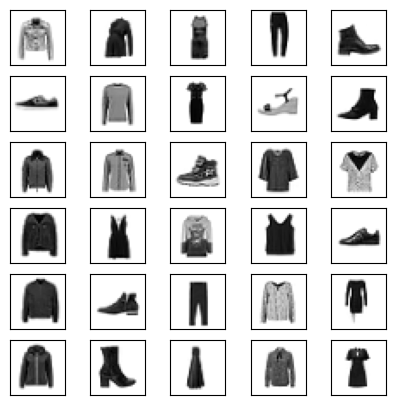

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
# Show only the first 30 pictures
for i in range(30):
    plt.subplot(6,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.array(Xtrain.iloc[i, :]).reshape(32,32), cmap=plt.cm.binary)

Data, se kterými budu dále pracovat, jsou tedy černobílé obrázky oblečení či obuvi. Obrázky mají 32 x 32 pixelů což dává dohromady 1024 příznaků - pixelů. Příznaky nabývají hodnot od 0 do 255, číslo vyjadřuje odstím šedé. 

In [6]:
print(ydata.unique())

[3 7 9 5 1 6 0 4 8 2]


Z tohohle vidíme, že v tomto úkolu budeme přiřazocat obrázky do 10 různých kategorií.

Nejprve jsem data převedla do formátu tenzoru, poté vytvořila dávky na dávkové učení a nakonec se zkusila podívat jestli to proběhlo v pořádku.

In [110]:
Xtrain_t = torch.utils.data.TensorDataset(torch.tensor(Xtrain.values.reshape(-1, 1, 32, 32), dtype=torch.float32), torch.Tensor(np.array(ytrain)).type(torch.long))
Xval_t = torch.utils.data.TensorDataset(torch.tensor(Xval.values.reshape(-1, 1, 32, 32), dtype=torch.float32), torch.Tensor(np.array(yval)).type(torch.long))
Xtest_t = torch.utils.data.TensorDataset(torch.tensor(Xtest.values.reshape(-1, 1, 32, 32), dtype=torch.float32), torch.Tensor(np.array(ytest)).type(torch.long))

In [111]:
training_loader = torch.utils.data.DataLoader(Xtrain_t, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(Xval_t, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(Xtest_t, batch_size=128, shuffle=False)

In [112]:
dataiter = iter(training_loader)
images,labels = next(dataiter)
print(images.shape)
print(labels.shape)

torch.Size([32, 1, 32, 32])
torch.Size([32])


Nachystala jsem si ztrátovou funkci CrossEntropyLoss a vytvořila jsem si funkci train_epoch

In [207]:
loss_fn = torch.nn.CrossEntropyLoss()

In [208]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_epoch(model, loss_fn, optimizer, training_loader):
    running_loss = 0.
    correct = 0
    for data in tqdm(training_loader, total = len(training_loader)):
        input, label = data
        input = input.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output,label)
        loss.backward()
        optimizer.step()
        last_mean_loss = loss.item()
        running_loss += last_mean_loss * input.shape[0]
    return running_loss/len(Xtrain_t)
#loss1 = train_epoch(model, loss_fn, optimizer1, training_loader)

torch.cuda.empty_cache()


In [209]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_more_epochs(num_epochs, training_loader, optimizer, model, loss_fn):
    epochs = []
    train_loss = []
    validation_loss = []    
    for epoch in range(num_epochs):
        print('EPOCH {}:'.format(epoch + 1))
        model.train(True)
        avg_loss = train_epoch(model, loss_fn, optimizer, training_loader)
        model.train(False)

        running_loss_val = 0.0
        correct_val = 0
        for i, data_val in enumerate(validation_loader):
            inputs_val, labels_val = data_val
            inputs_val = inputs_val.to(device)
            labels_val = labels_val.to(device)
            with torch.no_grad():
                outputs_val = model(inputs_val)
                loss_val = loss_fn(outputs_val, labels_val)
            running_loss_val += loss_val * inputs_val.shape[0]
            # count the correctly classified samoples
            correct_val += (outputs_val.argmax(1) == labels_val).float().sum()
        # Get average loss and accuraccy
        avg_loss_val = running_loss_val / len(Xval_t)
        acc_val = correct_val / len(Xval_t)

        epochs.append(epoch)
        validation_loss.append(avg_loss_val)
        train_loss.append(avg_loss)

        # Report progress
        print(f"TRAIN loss: {avg_loss:.3f}, VALIDATION loss: {avg_loss_val:.3f}, accuraccy: {acc_val:.3f}")
        #return epochs, validation_loss, train_loss
    epochs = np.array(epochs)
    validation_loss = np.array(validation_loss)
    plt.plot(epochs,train_loss, '.-', markersize = 10, label='Train loss')
    plt.plot(epochs,validation_loss, '.-', markersize = 10, label='Validation loss')
    plt.plot([epochs[np.argmin(validation_loss)]], [validation_loss[np.argmin(validation_loss)]],'x', color = 'red', markersize = 10, label='Best val loss')
    plt.legend()
    plt.show()

torch.cuda.empty_cache()

Zároveň jsem si připravila i standardizovaná a normalizovaná data.

In [170]:
from sklearn.preprocessing import StandardScaler
st_scaler = StandardScaler().fit(Xtrain)
Xtrain_sc = st_scaler.transform(Xtrain)
Xval_sc = st_scaler.transform(Xval)
Xtrain_sc_t = torch.utils.data.TensorDataset(torch.tensor(Xtrain_sc.reshape(-1, 1, 32, 32), dtype=torch.float32), torch.Tensor(np.array(ytrain)).type(torch.long))
Xval_sc_t = torch.utils.data.TensorDataset(torch.tensor(Xval_sc.reshape(-1, 1, 32, 32), dtype=torch.float32), torch.Tensor(np.array(yval)).type(torch.long))
Xtest_sc_t = torch.utils.data.TensorDataset(torch.tensor(Xtest.values.reshape(-1, 1, 32, 32), dtype=torch.float32), torch.Tensor(np.array(ytest)).type(torch.long))
training_loader_sc = torch.utils.data.DataLoader(Xtrain_sc_t, batch_size=32, shuffle=True)
validation_loader_sc = torch.utils.data.DataLoader(Xval_sc_t, batch_size=128, shuffle=False)
test_loader_sc = torch.utils.data.DataLoader(Xtest_t, batch_size=128, shuffle=False)

In [220]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler().fit(Xtrain)
Xtrain_mm = mm_scaler.transform(Xtrain)
Xval_mm = mm_scaler.transform(Xval)
Xtrain_mm_t = torch.utils.data.TensorDataset(torch.tensor(Xtrain_mm.reshape(-1, 1, 32, 32), dtype=torch.float32), torch.Tensor(np.array(ytrain)).type(torch.long))
Xval_mm_t = torch.utils.data.TensorDataset(torch.tensor(Xval_mm.reshape(-1, 1, 32, 32), dtype=torch.float32), torch.Tensor(np.array(yval)).type(torch.long))
Xtest_t = torch.utils.data.TensorDataset(torch.tensor(Xtest.values.reshape(-1, 1, 32, 32), dtype=torch.float32), torch.Tensor(np.array(ytest)).type(torch.long))
training_loader_mm = torch.utils.data.DataLoader(Xtrain_mm_t, batch_size=32, shuffle=True)
validation_loader_mm = torch.utils.data.DataLoader(Xval_mm_t, batch_size=128, shuffle=False)
test_loader_mm = torch.utils.data.DataLoader(Xtest_t, batch_size=128, shuffle=False)

1. Dopředná NN

Začala jsem s úplně jednoduchou sítí, která má pouze dvě vrstvy.

In [32]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 16)
        self.fco = nn.Linear(16, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = self.fco(x)
        return x

model01 = MyNet()

# zkusíme tam dát data
outputs = model01(images)
print(images.shape, outputs.shape)

torch.Size([32, 1, 32, 32]) torch.Size([32, 10])


In [33]:
optimizer01 = torch.optim.Adam(model01.parameters())

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model01 = MyNet().to(device)
loss01 = train_epoch(model01, loss_fn, optimizer01, training_loader)
print(loss01)
del model01
torch.cuda.empty_cache()

100%|██████████| 985/985 [00:02<00:00, 431.81it/s]

17.912909363519578


Připravila jsem si funkci train_more_epochs_es(), pomocí které můžu trénovat model, součástí je i forma regularizace - early stopping

In [210]:
def train_more_epochs_es(num_epochs, stop_epochs, model, loss_fn, optimizer, training_loader_t, validation_loader_t):
    epochs = []
    train_loss = []
    validation_loss = []    
    best_loss_val = 1000000.
    best_acc = 0.
    epochs_from_best = 0
    validation_acc = []

    for epoch in range(num_epochs):
        print('EPOCH {}:'.format(epoch + 1))
        model.train(True)
        avg_loss = train_epoch(model, loss_fn, optimizer, training_loader_t)
        model.eval()

        running_loss_val = 0.0
        correct_val = 0
        for i, data_val in enumerate(validation_loader_t):
            inputs_val, labels_val = data_val
            inputs_val = inputs_val.to(device)
            labels_val = labels_val.to(device)
            with torch.no_grad():
                outputs_val = model(inputs_val)
                loss_val = loss_fn(outputs_val, labels_val)
            running_loss_val += loss_val * inputs_val.shape[0]
            # count the correctly classified samoples
            correct_val += (outputs_val.argmax(1) == labels_val).float().sum()
        # Get average loss and accuraccy
        avg_loss_val = running_loss_val / len(Xval_t)
        acc_val = correct_val / len(Xval_t)

        epochs.append(epoch)
        validation_loss.append(avg_loss_val)
        train_loss.append(avg_loss)
        validation_acc.append(acc_val)

        # Report progress
        print(f"TRAIN loss: {avg_loss:.3f}, VALIDATION loss: {avg_loss_val:.3f}, accuraccy: {acc_val:.3f}")
        #return epochs, validation_loss, train_loss
        
        if acc_val > best_acc:
            print("Saving best model")
            best_acc = acc_val
            model_path = "saves/best_model.pt"
            torch.save(model.state_dict(), model_path)
            epochs_from_best = 0
        else:
            print("No improvement in this epoch.")
            epochs_from_best += 1
        
    # EARLY STOPPING
        if epochs_from_best > stop_epochs:
            print("Early stopping now")
            break

    epochs = np.array(epochs)
    validation_loss_np = [loss.cpu().detach().numpy() for loss in validation_loss]
    validation_acc_np = [loss.cpu().detach().numpy() for loss in validation_acc]
    plt.plot(epochs,train_loss, '.-', markersize = 10, label='Train loss')
    plt.plot(epochs,validation_loss_np, '.-', markersize = 10, label='Validation loss')
    plt.plot([epochs[np.argmin(validation_loss_np)]], [validation_loss_np[np.argmin(validation_loss_np)]],'x', color = 'red', markersize = 10, label='Best val loss')
    plt.legend()
    plt.show()
    plt.plot(epochs,validation_acc_np, '.-', markersize = 10, label='Validation acc')

EPOCH 1:


100%|██████████| 985/985 [00:02<00:00, 392.61it/s]


TRAIN loss: 20.356, VALIDATION loss: 20.379, accuraccy: 0.125
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:02<00:00, 368.24it/s]


TRAIN loss: 20.356, VALIDATION loss: 20.379, accuraccy: 0.125
No improvement in this epoch.
EPOCH 3:


100%|██████████| 985/985 [00:02<00:00, 381.90it/s]


TRAIN loss: 20.356, VALIDATION loss: 20.379, accuraccy: 0.125
No improvement in this epoch.
EPOCH 4:


100%|██████████| 985/985 [00:02<00:00, 348.51it/s]


TRAIN loss: 20.356, VALIDATION loss: 20.379, accuraccy: 0.125
No improvement in this epoch.
EPOCH 5:


100%|██████████| 985/985 [00:03<00:00, 315.44it/s]


TRAIN loss: 20.356, VALIDATION loss: 20.379, accuraccy: 0.125
No improvement in this epoch.
Early stopping now


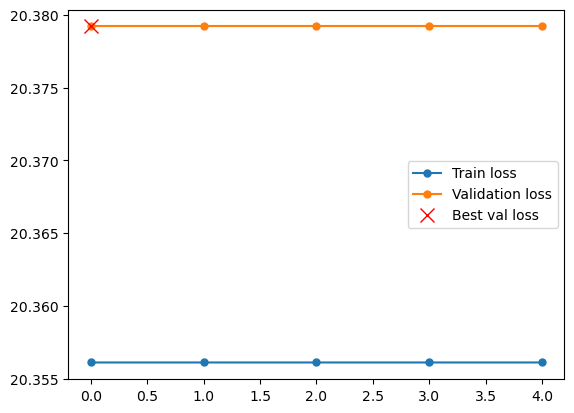

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model01 = MyNet().to(device)
train_more_epochs_es(25,3,model01,loss_fn,optimizer01,training_loader)
del model01
torch.cuda.empty_cache()

Takto plytká síť samozřejmě nefunguje dobře, zvýšila jsem tedy hloubku na 3 vrstvy.

In [53]:
class Model02(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fco = nn.Linear(20, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fco(x)
        return x

model02 = Model02()
outputs = model02(images)
print(images.shape, outputs.shape)

torch.Size([32, 1, 32, 32]) torch.Size([32, 10])


EPOCH 1:


100%|██████████| 985/985 [00:03<00:00, 285.77it/s]


TRAIN loss: 1.117, VALIDATION loss: 0.794, accuraccy: 0.675
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:03<00:00, 250.14it/s]


TRAIN loss: 0.757, VALIDATION loss: 0.850, accuraccy: 0.690
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:03<00:00, 252.99it/s]


TRAIN loss: 0.712, VALIDATION loss: 0.733, accuraccy: 0.716
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:03<00:00, 249.48it/s]


TRAIN loss: 0.686, VALIDATION loss: 0.720, accuraccy: 0.744
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:04<00:00, 235.61it/s]


TRAIN loss: 0.660, VALIDATION loss: 0.664, accuraccy: 0.757
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:03<00:00, 259.15it/s]


TRAIN loss: 0.648, VALIDATION loss: 0.727, accuraccy: 0.739
No improvement in this epoch.
EPOCH 7:


100%|██████████| 985/985 [00:04<00:00, 239.50it/s]


TRAIN loss: 0.626, VALIDATION loss: 0.660, accuraccy: 0.748
No improvement in this epoch.
EPOCH 8:


100%|██████████| 985/985 [00:03<00:00, 255.55it/s]


TRAIN loss: 0.622, VALIDATION loss: 0.639, accuraccy: 0.769
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:03<00:00, 251.49it/s]


TRAIN loss: 0.609, VALIDATION loss: 0.687, accuraccy: 0.756
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:04<00:00, 221.57it/s]


TRAIN loss: 0.598, VALIDATION loss: 0.678, accuraccy: 0.760
No improvement in this epoch.
EPOCH 11:


100%|██████████| 985/985 [00:04<00:00, 227.27it/s]


TRAIN loss: 0.587, VALIDATION loss: 0.643, accuraccy: 0.770
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:03<00:00, 250.86it/s]


TRAIN loss: 0.585, VALIDATION loss: 0.634, accuraccy: 0.776
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:04<00:00, 224.14it/s]


TRAIN loss: 0.573, VALIDATION loss: 0.633, accuraccy: 0.776
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:03<00:00, 256.45it/s]


TRAIN loss: 0.573, VALIDATION loss: 0.623, accuraccy: 0.779
Saving best model
EPOCH 15:


100%|██████████| 985/985 [00:03<00:00, 262.23it/s]


TRAIN loss: 0.569, VALIDATION loss: 0.627, accuraccy: 0.775
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:03<00:00, 260.33it/s]


TRAIN loss: 0.561, VALIDATION loss: 0.649, accuraccy: 0.769
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:03<00:00, 264.75it/s]


TRAIN loss: 0.569, VALIDATION loss: 0.628, accuraccy: 0.777
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:03<00:00, 278.07it/s]


TRAIN loss: 0.554, VALIDATION loss: 0.688, accuraccy: 0.757
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:03<00:00, 270.08it/s]


TRAIN loss: 0.560, VALIDATION loss: 0.651, accuraccy: 0.778
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:03<00:00, 276.49it/s]


TRAIN loss: 0.552, VALIDATION loss: 0.646, accuraccy: 0.769
No improvement in this epoch.
Early stopping now


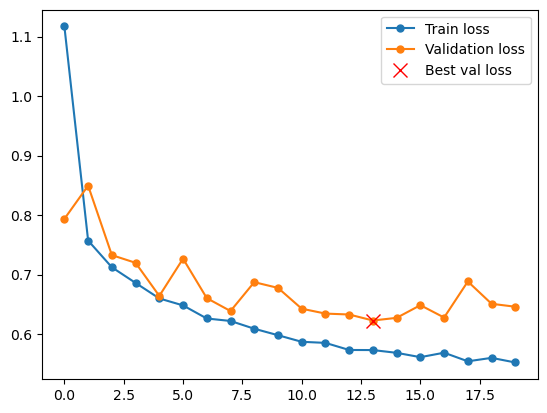

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model02 = Model02().to(device)
optimizer02 = torch.optim.Adam(model02.parameters())
train_more_epochs_es(25,5,model02,loss_fn,optimizer02,training_loader)
del model02
torch.cuda.empty_cache()

Maximální accuracy této sítě je 0.779, přešla jsem tedy na síť větší hloubky.

EPOCH 1:


100%|██████████| 985/985 [00:04<00:00, 243.03it/s]


TRAIN loss: 0.893, VALIDATION loss: 0.729, accuraccy: 0.728
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:03<00:00, 247.57it/s]


TRAIN loss: 0.651, VALIDATION loss: 0.617, accuraccy: 0.768
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:04<00:00, 231.64it/s]


TRAIN loss: 0.597, VALIDATION loss: 0.610, accuraccy: 0.774
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:04<00:00, 201.16it/s]


TRAIN loss: 0.558, VALIDATION loss: 0.602, accuraccy: 0.783
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:04<00:00, 203.64it/s]


TRAIN loss: 0.529, VALIDATION loss: 0.558, accuraccy: 0.799
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:05<00:00, 181.06it/s]


TRAIN loss: 0.505, VALIDATION loss: 0.560, accuraccy: 0.791
No improvement in this epoch.
EPOCH 7:


100%|██████████| 985/985 [00:04<00:00, 211.74it/s]


TRAIN loss: 0.491, VALIDATION loss: 0.541, accuraccy: 0.802
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:04<00:00, 220.01it/s]


TRAIN loss: 0.477, VALIDATION loss: 0.525, accuraccy: 0.813
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:05<00:00, 191.25it/s]


TRAIN loss: 0.467, VALIDATION loss: 0.539, accuraccy: 0.802
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:04<00:00, 197.54it/s]


TRAIN loss: 0.458, VALIDATION loss: 0.593, accuraccy: 0.796
No improvement in this epoch.
EPOCH 11:


100%|██████████| 985/985 [00:05<00:00, 185.43it/s]


TRAIN loss: 0.445, VALIDATION loss: 0.567, accuraccy: 0.795
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:05<00:00, 178.90it/s]


TRAIN loss: 0.436, VALIDATION loss: 0.583, accuraccy: 0.792
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:05<00:00, 183.96it/s]


TRAIN loss: 0.429, VALIDATION loss: 0.502, accuraccy: 0.822
Saving best model
EPOCH 14:


100%|██████████| 985/985 [00:05<00:00, 189.19it/s]


TRAIN loss: 0.417, VALIDATION loss: 0.570, accuraccy: 0.810
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:04<00:00, 197.71it/s]


TRAIN loss: 0.411, VALIDATION loss: 0.519, accuraccy: 0.821
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:05<00:00, 196.95it/s]


TRAIN loss: 0.399, VALIDATION loss: 0.509, accuraccy: 0.827
Saving best model
EPOCH 17:


100%|██████████| 985/985 [00:05<00:00, 164.31it/s]


TRAIN loss: 0.398, VALIDATION loss: 0.528, accuraccy: 0.816
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:05<00:00, 190.51it/s]


TRAIN loss: 0.389, VALIDATION loss: 0.532, accuraccy: 0.822
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:05<00:00, 194.92it/s]


TRAIN loss: 0.388, VALIDATION loss: 0.537, accuraccy: 0.820
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:05<00:00, 185.48it/s]


TRAIN loss: 0.377, VALIDATION loss: 0.521, accuraccy: 0.828
Saving best model
EPOCH 21:


100%|██████████| 985/985 [00:05<00:00, 190.98it/s]


TRAIN loss: 0.377, VALIDATION loss: 0.539, accuraccy: 0.822
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:05<00:00, 185.53it/s]


TRAIN loss: 0.376, VALIDATION loss: 0.550, accuraccy: 0.816
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:05<00:00, 194.40it/s]


TRAIN loss: 0.368, VALIDATION loss: 0.563, accuraccy: 0.819
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:05<00:00, 170.54it/s]


TRAIN loss: 0.363, VALIDATION loss: 0.539, accuraccy: 0.827
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:05<00:00, 188.96it/s]


TRAIN loss: 0.363, VALIDATION loss: 0.544, accuraccy: 0.820
No improvement in this epoch.


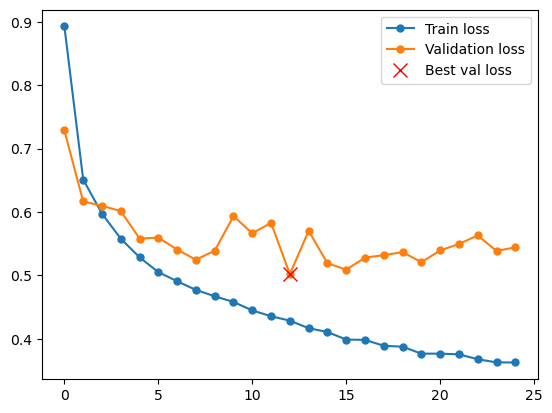

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Model03(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 60)
        self.fc2 = nn.Linear(60, 40)
        self.fc3 = nn.Linear(40, 30)
        self.fc4 = nn.Linear(30, 20)
        self.fc5 = nn.Linear(20, 15)
        self.fco = nn.Linear(15, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fco(x)
        return x

#model03 = Model03()
#outputs = model02(images)
#rint(images.shape, outputs.shape)
model03 = Model03().to(device)
optimizer03 = torch.optim.Adam(model03.parameters())
train_more_epochs_es(25,5,model03,loss_fn,optimizer03,training_loader)
del model03
torch.cuda.empty_cache()

Síť s 6 vrstvami už dosahuje accuracy 0.828, zkusila jsem tedy jaký vliv by mělo přídání více neuronů do ednotlivých vrstev

EPOCH 1:


100%|██████████| 985/985 [00:04<00:00, 219.49it/s]


TRAIN loss: 0.830, VALIDATION loss: 0.679, accuraccy: 0.736
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:04<00:00, 232.73it/s]


TRAIN loss: 0.626, VALIDATION loss: 0.669, accuraccy: 0.762
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:04<00:00, 223.71it/s]


TRAIN loss: 0.561, VALIDATION loss: 0.576, accuraccy: 0.789
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:06<00:00, 162.10it/s]


TRAIN loss: 0.537, VALIDATION loss: 0.563, accuraccy: 0.794
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:05<00:00, 176.28it/s]


TRAIN loss: 0.513, VALIDATION loss: 0.551, accuraccy: 0.795
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:07<00:00, 135.03it/s]


TRAIN loss: 0.491, VALIDATION loss: 0.536, accuraccy: 0.806
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:04<00:00, 204.04it/s]


TRAIN loss: 0.472, VALIDATION loss: 0.532, accuraccy: 0.808
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:07<00:00, 132.32it/s]


TRAIN loss: 0.459, VALIDATION loss: 0.528, accuraccy: 0.813
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:06<00:00, 162.26it/s]


TRAIN loss: 0.445, VALIDATION loss: 0.541, accuraccy: 0.802
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:05<00:00, 196.41it/s]


TRAIN loss: 0.436, VALIDATION loss: 0.522, accuraccy: 0.817
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:05<00:00, 189.39it/s]


TRAIN loss: 0.423, VALIDATION loss: 0.504, accuraccy: 0.823
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:05<00:00, 196.72it/s]


TRAIN loss: 0.414, VALIDATION loss: 0.497, accuraccy: 0.824
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:05<00:00, 186.61it/s]


TRAIN loss: 0.411, VALIDATION loss: 0.554, accuraccy: 0.809
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:05<00:00, 194.78it/s]


TRAIN loss: 0.400, VALIDATION loss: 0.544, accuraccy: 0.817
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:05<00:00, 192.95it/s]


TRAIN loss: 0.392, VALIDATION loss: 0.507, accuraccy: 0.825
Saving best model
EPOCH 16:


100%|██████████| 985/985 [00:05<00:00, 190.05it/s]


TRAIN loss: 0.379, VALIDATION loss: 0.531, accuraccy: 0.821
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:05<00:00, 193.47it/s]


TRAIN loss: 0.374, VALIDATION loss: 0.512, accuraccy: 0.823
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:05<00:00, 191.82it/s]


TRAIN loss: 0.370, VALIDATION loss: 0.518, accuraccy: 0.823
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:06<00:00, 161.10it/s]


TRAIN loss: 0.364, VALIDATION loss: 0.559, accuraccy: 0.813
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:05<00:00, 185.86it/s]


TRAIN loss: 0.358, VALIDATION loss: 0.529, accuraccy: 0.821
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:04<00:00, 199.44it/s]


TRAIN loss: 0.355, VALIDATION loss: 0.539, accuraccy: 0.823
No improvement in this epoch.
Early stopping now


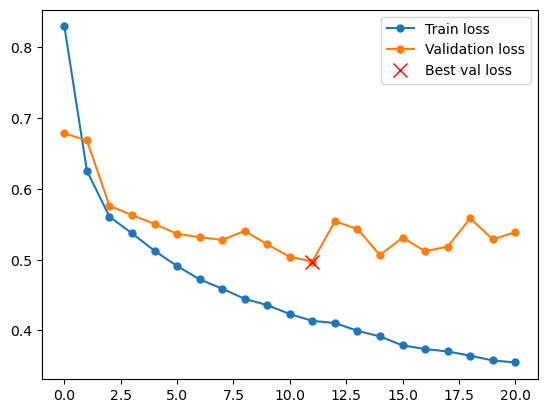

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Model04(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 100)
        self.fc2 = nn.Linear(100, 40)
        self.fc3 = nn.Linear(40, 30)
        self.fc4 = nn.Linear(30, 30)
        self.fc5 = nn.Linear(30, 20)
        self.fco = nn.Linear(20, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fco(x)
        return x

#model03 = Model03()
#outputs = model02(images)
#rint(images.shape, outputs.shape)
model04 = Model04().to(device)
optimizer04 = torch.optim.Adam(model04.parameters())
train_more_epochs_es(25,5,model04,loss_fn,optimizer04,training_loader)
del model04
torch.cuda.empty_cache()

K velké pozitivní změněn nedošlo, přecházím tedy na hlubší síť s 9 vrstvami.

EPOCH 1:


100%|██████████| 985/985 [00:07<00:00, 136.12it/s]


TRAIN loss: 0.969, VALIDATION loss: 0.729, accuraccy: 0.720
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:07<00:00, 123.28it/s]


TRAIN loss: 0.675, VALIDATION loss: 0.658, accuraccy: 0.750
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:07<00:00, 135.89it/s]


TRAIN loss: 0.599, VALIDATION loss: 0.605, accuraccy: 0.766
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:08<00:00, 121.45it/s]


TRAIN loss: 0.554, VALIDATION loss: 0.565, accuraccy: 0.792
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:08<00:00, 121.84it/s]


TRAIN loss: 0.526, VALIDATION loss: 0.564, accuraccy: 0.794
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:08<00:00, 113.29it/s]


TRAIN loss: 0.505, VALIDATION loss: 0.550, accuraccy: 0.805
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:07<00:00, 132.14it/s]


TRAIN loss: 0.479, VALIDATION loss: 0.589, accuraccy: 0.794
No improvement in this epoch.
EPOCH 8:


100%|██████████| 985/985 [00:07<00:00, 133.32it/s]


TRAIN loss: 0.467, VALIDATION loss: 0.560, accuraccy: 0.797
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:07<00:00, 129.71it/s]


TRAIN loss: 0.455, VALIDATION loss: 0.544, accuraccy: 0.803
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:08<00:00, 122.16it/s]


TRAIN loss: 0.439, VALIDATION loss: 0.514, accuraccy: 0.820
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:08<00:00, 117.88it/s]


TRAIN loss: 0.426, VALIDATION loss: 0.537, accuraccy: 0.818
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:07<00:00, 123.90it/s]


TRAIN loss: 0.416, VALIDATION loss: 0.497, accuraccy: 0.825
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:08<00:00, 111.35it/s]


TRAIN loss: 0.413, VALIDATION loss: 0.539, accuraccy: 0.815
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:07<00:00, 127.19it/s]


TRAIN loss: 0.401, VALIDATION loss: 0.508, accuraccy: 0.817
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:08<00:00, 121.86it/s]


TRAIN loss: 0.390, VALIDATION loss: 0.499, accuraccy: 0.822
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:07<00:00, 126.26it/s]


TRAIN loss: 0.388, VALIDATION loss: 0.488, accuraccy: 0.830
Saving best model
EPOCH 17:


100%|██████████| 985/985 [00:07<00:00, 133.44it/s]


TRAIN loss: 0.379, VALIDATION loss: 0.541, accuraccy: 0.810
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:11<00:00, 83.28it/s] 


TRAIN loss: 0.365, VALIDATION loss: 0.504, accuraccy: 0.823
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:10<00:00, 89.74it/s] 


TRAIN loss: 0.366, VALIDATION loss: 0.509, accuraccy: 0.828
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:12<00:00, 81.01it/s] 


TRAIN loss: 0.365, VALIDATION loss: 0.503, accuraccy: 0.831
Saving best model
EPOCH 21:


100%|██████████| 985/985 [00:10<00:00, 96.30it/s] 


TRAIN loss: 0.362, VALIDATION loss: 0.514, accuraccy: 0.828
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:09<00:00, 101.86it/s]


TRAIN loss: 0.353, VALIDATION loss: 0.523, accuraccy: 0.820
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:08<00:00, 111.57it/s]


TRAIN loss: 0.347, VALIDATION loss: 0.530, accuraccy: 0.824
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:08<00:00, 112.26it/s]


TRAIN loss: 0.343, VALIDATION loss: 0.551, accuraccy: 0.817
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:09<00:00, 103.92it/s]


TRAIN loss: 0.338, VALIDATION loss: 0.505, accuraccy: 0.837
Saving best model


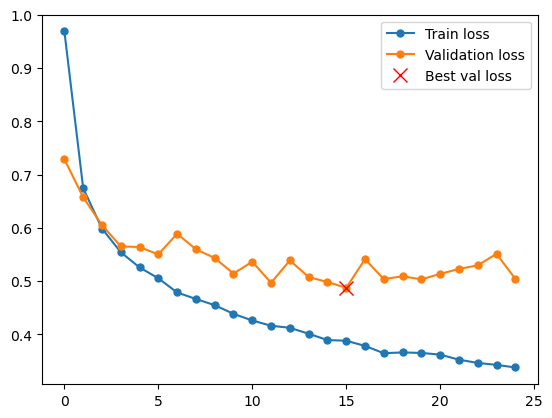

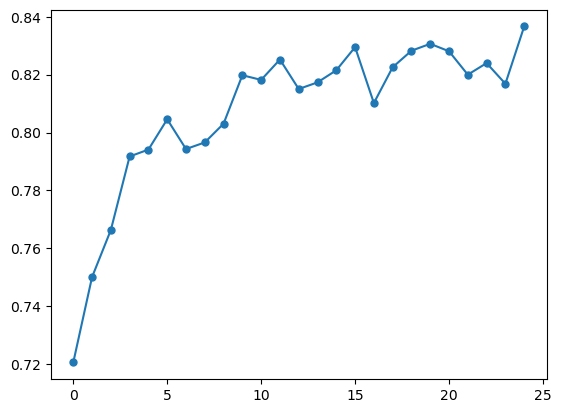

In [186]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Model08(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 100)
        self.fc2 = nn.Linear(100, 60)
        self.fc3 = nn.Linear(60, 40)
        self.fc4 = nn.Linear(40, 40)
        self.fc5 = nn.Linear(40, 30)
        self.fc6 = nn.Linear(30, 30)
        self.fc7 = nn.Linear(30, 30)
        self.fc8 = nn.Linear(30, 20)
        self.fco = nn.Linear(20, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = self.fco(x)
        return x

#model03 = Model03()
#outputs = model02(images)
#rint(images.shape, outputs.shape)
model08 = Model08().to(device)
optimizer08 = torch.optim.Adam(model08.parameters())
train_more_epochs_es(25,5,model08,loss_fn,optimizer08,training_loader,validation_loader)
del model08
torch.cuda.empty_cache()

Dostávám se nejlépe na 0.837 a ze zajímavosti zkouším i 12 vrstev.

EPOCH 1:


100%|██████████| 985/985 [00:05<00:00, 167.53it/s]


TRAIN loss: 1.032, VALIDATION loss: 0.808, accuraccy: 0.678
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:05<00:00, 169.89it/s]


TRAIN loss: 0.716, VALIDATION loss: 0.690, accuraccy: 0.743
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:07<00:00, 135.12it/s]


TRAIN loss: 0.636, VALIDATION loss: 0.631, accuraccy: 0.768
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:07<00:00, 138.43it/s]


TRAIN loss: 0.581, VALIDATION loss: 0.624, accuraccy: 0.784
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:08<00:00, 122.18it/s]


TRAIN loss: 0.554, VALIDATION loss: 0.586, accuraccy: 0.789
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:06<00:00, 144.58it/s]


TRAIN loss: 0.527, VALIDATION loss: 0.574, accuraccy: 0.783
No improvement in this epoch.
EPOCH 7:


100%|██████████| 985/985 [00:07<00:00, 138.32it/s]


TRAIN loss: 0.505, VALIDATION loss: 0.547, accuraccy: 0.800
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:08<00:00, 121.87it/s]


TRAIN loss: 0.490, VALIDATION loss: 0.605, accuraccy: 0.794
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:08<00:00, 113.38it/s]


TRAIN loss: 0.470, VALIDATION loss: 0.553, accuraccy: 0.806
Saving best model
EPOCH 10:


100%|██████████| 985/985 [00:07<00:00, 130.48it/s]


TRAIN loss: 0.458, VALIDATION loss: 0.523, accuraccy: 0.820
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:07<00:00, 134.22it/s]


TRAIN loss: 0.438, VALIDATION loss: 0.506, accuraccy: 0.822
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:07<00:00, 131.54it/s]


TRAIN loss: 0.427, VALIDATION loss: 0.522, accuraccy: 0.821
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:08<00:00, 121.54it/s]


TRAIN loss: 0.424, VALIDATION loss: 0.481, accuraccy: 0.827
Saving best model
EPOCH 14:


100%|██████████| 985/985 [00:07<00:00, 130.45it/s]


TRAIN loss: 0.414, VALIDATION loss: 0.510, accuraccy: 0.824
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:07<00:00, 129.79it/s]


TRAIN loss: 0.401, VALIDATION loss: 0.490, accuraccy: 0.827
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:07<00:00, 133.53it/s]


TRAIN loss: 0.402, VALIDATION loss: 0.527, accuraccy: 0.825
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:07<00:00, 131.48it/s]


TRAIN loss: 0.385, VALIDATION loss: 0.619, accuraccy: 0.817
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:07<00:00, 131.92it/s]


TRAIN loss: 0.382, VALIDATION loss: 0.493, accuraccy: 0.830
Saving best model
EPOCH 19:


100%|██████████| 985/985 [00:07<00:00, 137.02it/s]


TRAIN loss: 0.374, VALIDATION loss: 0.488, accuraccy: 0.833
Saving best model
EPOCH 20:


100%|██████████| 985/985 [00:07<00:00, 136.29it/s]


TRAIN loss: 0.371, VALIDATION loss: 0.496, accuraccy: 0.835
Saving best model
EPOCH 21:


100%|██████████| 985/985 [00:06<00:00, 141.24it/s]


TRAIN loss: 0.362, VALIDATION loss: 0.545, accuraccy: 0.816
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:06<00:00, 141.63it/s]


TRAIN loss: 0.361, VALIDATION loss: 0.487, accuraccy: 0.835
Saving best model
EPOCH 23:


100%|██████████| 985/985 [00:06<00:00, 146.84it/s]


TRAIN loss: 0.365, VALIDATION loss: 0.492, accuraccy: 0.830
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:06<00:00, 156.61it/s]


TRAIN loss: 0.346, VALIDATION loss: 0.502, accuraccy: 0.836
Saving best model
EPOCH 25:


100%|██████████| 985/985 [00:06<00:00, 147.27it/s]


TRAIN loss: 0.342, VALIDATION loss: 0.512, accuraccy: 0.830
No improvement in this epoch.


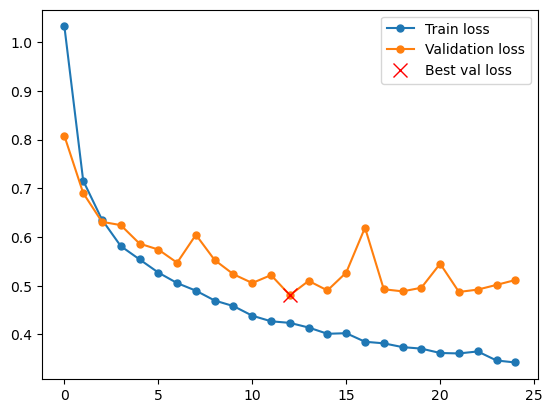

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Model05(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 80)
        self.fc4 = nn.Linear(80, 80)
        self.fc5 = nn.Linear(80, 60)
        self.fc6 = nn.Linear(60, 60)
        self.fc7 = nn.Linear(60, 40)
        self.fc8 = nn.Linear(40, 30)
        self.fc9 = nn.Linear(30, 30)
        self.fc10 = nn.Linear(30, 20)
        self.fc11 = nn.Linear(20, 20)
        self.fco = nn.Linear(20, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = F.relu(self.fc9(x))
        x = F.relu(self.fc10(x))
        x = F.relu(self.fc11(x))
        x = self.fco(x)
        return x

#model03 = Model03()
#outputs = model02(images)
#rint(images.shape, outputs.shape)
model05 = Model05().to(device)
optimizer05 = torch.optim.Adam(model05.parameters())
train_more_epochs_es(25,5,model05,loss_fn,optimizer05,training_loader)
del model05
torch.cuda.empty_cache()

Dostávám výsledek 0.836 acccuracy, což je jeden z nejlepších! Zkusím u tohoto modelu zvětšit počet neuronů v jednotlivých vrstvách.

EPOCH 1:


100%|██████████| 985/985 [00:07<00:00, 134.90it/s]


TRAIN loss: 1.250, VALIDATION loss: 0.896, accuraccy: 0.659
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:07<00:00, 126.82it/s]


TRAIN loss: 0.797, VALIDATION loss: 0.719, accuraccy: 0.716
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:07<00:00, 123.29it/s]


TRAIN loss: 0.703, VALIDATION loss: 0.712, accuraccy: 0.746
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:07<00:00, 126.13it/s]


TRAIN loss: 0.645, VALIDATION loss: 0.695, accuraccy: 0.750
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:07<00:00, 125.07it/s]


TRAIN loss: 0.615, VALIDATION loss: 0.631, accuraccy: 0.758
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:08<00:00, 118.39it/s]


TRAIN loss: 0.577, VALIDATION loss: 0.584, accuraccy: 0.792
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:09<00:00, 108.85it/s]


TRAIN loss: 0.548, VALIDATION loss: 0.589, accuraccy: 0.796
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:10<00:00, 97.29it/s] 


TRAIN loss: 0.541, VALIDATION loss: 0.573, accuraccy: 0.794
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:10<00:00, 93.96it/s] 


TRAIN loss: 0.520, VALIDATION loss: 0.564, accuraccy: 0.796
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:08<00:00, 110.58it/s]


TRAIN loss: 0.501, VALIDATION loss: 0.562, accuraccy: 0.798
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:08<00:00, 111.67it/s]


TRAIN loss: 0.487, VALIDATION loss: 0.580, accuraccy: 0.800
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:08<00:00, 111.14it/s]


TRAIN loss: 0.480, VALIDATION loss: 0.537, accuraccy: 0.804
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:09<00:00, 102.55it/s]


TRAIN loss: 0.470, VALIDATION loss: 0.576, accuraccy: 0.797
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:08<00:00, 112.57it/s]


TRAIN loss: 0.500, VALIDATION loss: 0.534, accuraccy: 0.812
Saving best model
EPOCH 15:


100%|██████████| 985/985 [00:09<00:00, 104.22it/s]


TRAIN loss: 0.467, VALIDATION loss: 0.567, accuraccy: 0.805
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:08<00:00, 115.51it/s]


TRAIN loss: 0.461, VALIDATION loss: 0.566, accuraccy: 0.809
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:08<00:00, 115.51it/s]


TRAIN loss: 0.433, VALIDATION loss: 0.685, accuraccy: 0.783
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:09<00:00, 104.31it/s]


TRAIN loss: 0.447, VALIDATION loss: 0.537, accuraccy: 0.811
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:07<00:00, 125.32it/s]


TRAIN loss: 0.419, VALIDATION loss: 0.518, accuraccy: 0.823
Saving best model
EPOCH 20:


100%|██████████| 985/985 [00:08<00:00, 115.21it/s]


TRAIN loss: 0.409, VALIDATION loss: 0.523, accuraccy: 0.822
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:07<00:00, 128.29it/s]


TRAIN loss: 0.422, VALIDATION loss: 0.567, accuraccy: 0.802
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:08<00:00, 114.21it/s]


TRAIN loss: 0.393, VALIDATION loss: 0.520, accuraccy: 0.828
Saving best model
EPOCH 23:


100%|██████████| 985/985 [00:07<00:00, 125.43it/s]


TRAIN loss: 0.441, VALIDATION loss: 0.528, accuraccy: 0.823
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:09<00:00, 107.10it/s]


TRAIN loss: 0.397, VALIDATION loss: 0.636, accuraccy: 0.764
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:09<00:00, 107.16it/s]


TRAIN loss: 0.398, VALIDATION loss: 0.527, accuraccy: 0.820
No improvement in this epoch.


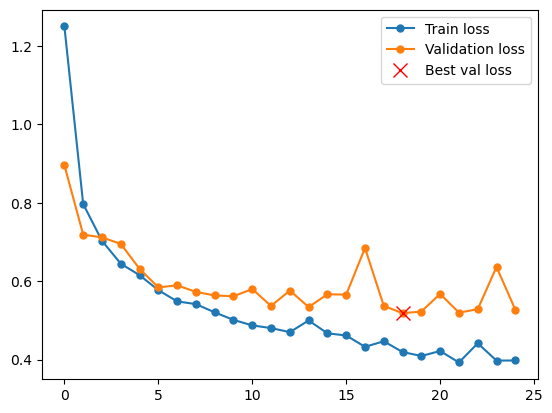

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Model06(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 150)
        self.fc2 = nn.Linear(150, 120)
        self.fc3 = nn.Linear(120, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 80)
        self.fc6 = nn.Linear(80, 60)
        self.fc7 = nn.Linear(60, 60)
        self.fc8 = nn.Linear(60, 40)
        self.fc9 = nn.Linear(40, 30)
        self.fc10 = nn.Linear(30, 30)
        self.fc11 = nn.Linear(30, 20)
        self.fc12 = nn.Linear(20, 30)
        self.fc13 = nn.Linear(30, 20)
        self.fc14 = nn.Linear(20, 20)
        self.fco = nn.Linear(20, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = F.relu(self.fc9(x))
        x = F.relu(self.fc10(x))
        x = F.relu(self.fc11(x))
        x = F.relu(self.fc12(x))
        x = F.relu(self.fc13(x))
        x = F.relu(self.fc14(x))
        x = self.fco(x)
        return x

model06 = Model06().to(device)
optimizer06 = torch.optim.Adam(model06.parameters())
train_more_epochs_es(25,5,model06,loss_fn,optimizer06,training_loader)
del model06
torch.cuda.empty_cache()

Nepomohlo to , ze zajímavosti ještě zkusím model o 20 vstvách.

EPOCH 1:


100%|██████████| 985/985 [00:09<00:00, 100.15it/s]


TRAIN loss: 1.429, VALIDATION loss: 1.036, accuraccy: 0.569
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:09<00:00, 105.01it/s]


TRAIN loss: 0.963, VALIDATION loss: 0.956, accuraccy: 0.602
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:10<00:00, 90.96it/s]


TRAIN loss: 0.868, VALIDATION loss: 1.067, accuraccy: 0.643
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:11<00:00, 84.02it/s]


TRAIN loss: 0.831, VALIDATION loss: 0.821, accuraccy: 0.695
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:10<00:00, 90.60it/s]


TRAIN loss: 0.775, VALIDATION loss: 0.842, accuraccy: 0.711
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:11<00:00, 87.16it/s]


TRAIN loss: 0.760, VALIDATION loss: 0.770, accuraccy: 0.731
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:12<00:00, 77.07it/s]


TRAIN loss: 0.707, VALIDATION loss: 0.793, accuraccy: 0.742
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:11<00:00, 85.64it/s]


TRAIN loss: 0.716, VALIDATION loss: 0.709, accuraccy: 0.761
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:10<00:00, 90.58it/s]


TRAIN loss: 0.751, VALIDATION loss: 0.836, accuraccy: 0.730
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:10<00:00, 90.29it/s]


TRAIN loss: 1.048, VALIDATION loss: 1.077, accuraccy: 0.626
No improvement in this epoch.
EPOCH 11:


100%|██████████| 985/985 [00:10<00:00, 90.73it/s]


TRAIN loss: 0.864, VALIDATION loss: 0.872, accuraccy: 0.707
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:11<00:00, 86.23it/s]


TRAIN loss: 0.828, VALIDATION loss: 0.879, accuraccy: 0.681
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:11<00:00, 88.65it/s]


TRAIN loss: 0.809, VALIDATION loss: 0.843, accuraccy: 0.692
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:12<00:00, 80.34it/s]


TRAIN loss: 0.769, VALIDATION loss: 0.809, accuraccy: 0.743
No improvement in this epoch.
Early stopping now


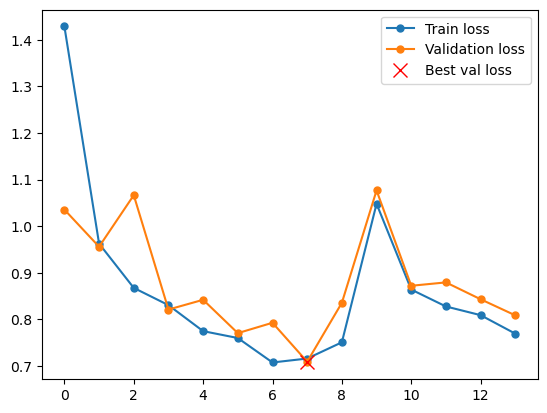

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Model07(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 512)
        self.fc2 = nn.Linear(512, 384)
        self.fc3 = nn.Linear(384, 256)
        self.fc4 = nn.Linear(256, 180)
        self.fc5 = nn.Linear(180, 120)
        self.fc6 = nn.Linear(120, 100)
        self.fc7 = nn.Linear(100, 80)
        self.fc8 = nn.Linear(80, 60)
        self.fc9 = nn.Linear(60, 60)
        self.fc10 = nn.Linear(60, 40)
        self.fc11 = nn.Linear(40, 40)
        self.fc12 = nn.Linear(40, 30)
        self.fc13 = nn.Linear(30, 30)
        self.fc14 = nn.Linear(30, 20)
        self.fc15 = nn.Linear(20, 30)
        self.fc16 = nn.Linear(30, 20)
        self.fc17 = nn.Linear(20, 20)
        self.fc18 = nn.Linear(20, 20)
        self.fc19 = nn.Linear(20, 20)
        self.fco = nn.Linear(20, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = F.relu(self.fc9(x))
        x = F.relu(self.fc10(x))
        x = F.relu(self.fc11(x))
        x = F.relu(self.fc12(x))
        x = F.relu(self.fc13(x))
        x = F.relu(self.fc14(x))
        x = F.relu(self.fc15(x))
        x = F.relu(self.fc16(x))
        x = F.relu(self.fc17(x))
        x = F.relu(self.fc18(x))
        x = F.relu(self.fc19(x))
        x = self.fco(x)
        return x

model07 = Model07().to(device)
optimizer07 = torch.optim.Adam(model07.parameters())
train_more_epochs_es(25,5,model07,loss_fn,optimizer07,training_loader)
del model07
torch.cuda.empty_cache()

20 vrtev už je moc, výpočet trvá dlouho a model má moc parametrů.

Nejlépe tedy výcházely sítě s 9 a 12 vrstvami, zkusím dál zjistit jak accuracy ovlivní počet neuronů v jednotlivých vrstvách. 

EPOCH 1:


100%|██████████| 985/985 [00:07<00:00, 134.77it/s]


TRAIN loss: 1.063, VALIDATION loss: 0.861, accuraccy: 0.675
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:06<00:00, 155.06it/s]


TRAIN loss: 0.786, VALIDATION loss: 0.775, accuraccy: 0.717
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:07<00:00, 140.34it/s]


TRAIN loss: 0.691, VALIDATION loss: 0.700, accuraccy: 0.715
No improvement in this epoch.
EPOCH 4:


100%|██████████| 985/985 [00:07<00:00, 131.33it/s]


TRAIN loss: 0.643, VALIDATION loss: 0.750, accuraccy: 0.713
No improvement in this epoch.
EPOCH 5:


100%|██████████| 985/985 [00:07<00:00, 128.79it/s]


TRAIN loss: 0.608, VALIDATION loss: 0.633, accuraccy: 0.767
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:07<00:00, 128.40it/s]


TRAIN loss: 0.579, VALIDATION loss: 0.598, accuraccy: 0.777
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:07<00:00, 131.12it/s]


TRAIN loss: 0.547, VALIDATION loss: 0.602, accuraccy: 0.772
No improvement in this epoch.
EPOCH 8:


100%|██████████| 985/985 [00:07<00:00, 138.77it/s]


TRAIN loss: 0.547, VALIDATION loss: 0.597, accuraccy: 0.785
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:08<00:00, 122.94it/s]


TRAIN loss: 0.533, VALIDATION loss: 0.565, accuraccy: 0.797
Saving best model
EPOCH 10:


100%|██████████| 985/985 [00:07<00:00, 138.55it/s]


TRAIN loss: 0.519, VALIDATION loss: 0.562, accuraccy: 0.800
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:07<00:00, 130.93it/s]


TRAIN loss: 0.494, VALIDATION loss: 0.587, accuraccy: 0.797
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:06<00:00, 144.98it/s]


TRAIN loss: 0.499, VALIDATION loss: 0.579, accuraccy: 0.779
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:07<00:00, 132.83it/s]


TRAIN loss: 0.460, VALIDATION loss: 0.543, accuraccy: 0.805
Saving best model
EPOCH 14:


100%|██████████| 985/985 [00:06<00:00, 145.11it/s]


TRAIN loss: 0.466, VALIDATION loss: 0.547, accuraccy: 0.812
Saving best model
EPOCH 15:


100%|██████████| 985/985 [00:06<00:00, 144.26it/s]


TRAIN loss: 0.453, VALIDATION loss: 0.558, accuraccy: 0.802
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:07<00:00, 125.35it/s]


TRAIN loss: 0.445, VALIDATION loss: 0.567, accuraccy: 0.797
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:07<00:00, 126.46it/s]


TRAIN loss: 0.434, VALIDATION loss: 0.532, accuraccy: 0.811
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:07<00:00, 134.57it/s]


TRAIN loss: 0.426, VALIDATION loss: 0.516, accuraccy: 0.821
Saving best model
EPOCH 19:


100%|██████████| 985/985 [00:07<00:00, 134.68it/s]


TRAIN loss: 0.424, VALIDATION loss: 0.567, accuraccy: 0.803
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:10<00:00, 98.03it/s] 


TRAIN loss: 0.414, VALIDATION loss: 0.512, accuraccy: 0.824
Saving best model
EPOCH 21:


100%|██████████| 985/985 [00:09<00:00, 100.76it/s]


TRAIN loss: 0.402, VALIDATION loss: 0.567, accuraccy: 0.806
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:07<00:00, 129.23it/s]


TRAIN loss: 0.427, VALIDATION loss: 0.603, accuraccy: 0.792
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:07<00:00, 133.33it/s]


TRAIN loss: 0.398, VALIDATION loss: 0.506, accuraccy: 0.826
Saving best model
EPOCH 24:


100%|██████████| 985/985 [00:07<00:00, 129.32it/s]


TRAIN loss: 0.391, VALIDATION loss: 0.631, accuraccy: 0.820
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:06<00:00, 141.58it/s]


TRAIN loss: 0.416, VALIDATION loss: 0.571, accuraccy: 0.812
No improvement in this epoch.


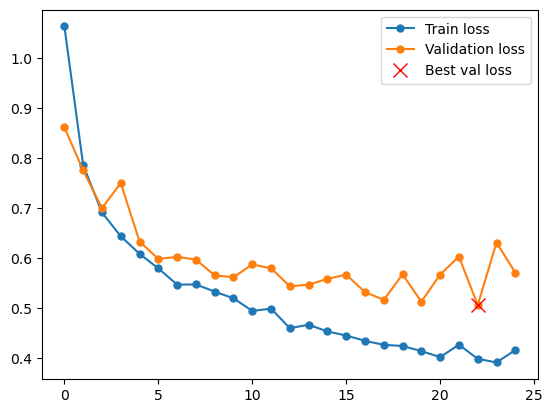

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Model051(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 250)
        self.fc2 = nn.Linear(250, 200)
        self.fc3 = nn.Linear(200, 150)
        self.fc4 = nn.Linear(150, 100)
        self.fc5 = nn.Linear(100, 80)
        self.fc6 = nn.Linear(80, 60)
        self.fc7 = nn.Linear(60, 40)
        self.fc8 = nn.Linear(40, 30)
        self.fc9 = nn.Linear(30, 30)
        self.fc10 = nn.Linear(30, 20)
        self.fc11 = nn.Linear(20, 20)
        self.fco = nn.Linear(20, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = F.relu(self.fc9(x))
        x = F.relu(self.fc10(x))
        x = F.relu(self.fc11(x))
        x = self.fco(x)
        return x

#model03 = Model03()
#outputs = model02(images)
#rint(images.shape, outputs.shape)
model051 = Model051().to(device)
optimizer051 = torch.optim.Adam(model051.parameters())
train_more_epochs_es(25,5,model051,loss_fn,optimizer051,training_loader)
del model051
torch.cuda.empty_cache()

EPOCH 1:


100%|██████████| 985/985 [00:06<00:00, 159.28it/s]


TRAIN loss: 1.088, VALIDATION loss: 0.785, accuraccy: 0.690
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:06<00:00, 151.49it/s]


TRAIN loss: 0.766, VALIDATION loss: 0.742, accuraccy: 0.728
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:07<00:00, 128.68it/s]


TRAIN loss: 0.678, VALIDATION loss: 0.661, accuraccy: 0.756
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:07<00:00, 130.56it/s]


TRAIN loss: 0.624, VALIDATION loss: 0.620, accuraccy: 0.766
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:07<00:00, 131.31it/s]


TRAIN loss: 0.592, VALIDATION loss: 0.595, accuraccy: 0.780
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:07<00:00, 131.19it/s]


TRAIN loss: 0.569, VALIDATION loss: 0.600, accuraccy: 0.775
No improvement in this epoch.
EPOCH 7:


100%|██████████| 985/985 [00:07<00:00, 131.53it/s]


TRAIN loss: 0.549, VALIDATION loss: 0.588, accuraccy: 0.778
No improvement in this epoch.
EPOCH 8:


100%|██████████| 985/985 [00:10<00:00, 96.69it/s] 


TRAIN loss: 0.524, VALIDATION loss: 0.583, accuraccy: 0.783
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:08<00:00, 110.39it/s]


TRAIN loss: 0.501, VALIDATION loss: 0.562, accuraccy: 0.794
Saving best model
EPOCH 10:


100%|██████████| 985/985 [00:07<00:00, 128.81it/s]


TRAIN loss: 0.489, VALIDATION loss: 0.543, accuraccy: 0.804
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:09<00:00, 103.82it/s]


TRAIN loss: 0.473, VALIDATION loss: 0.549, accuraccy: 0.808
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:07<00:00, 126.65it/s]


TRAIN loss: 0.464, VALIDATION loss: 0.530, accuraccy: 0.813
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:07<00:00, 132.21it/s]


TRAIN loss: 0.450, VALIDATION loss: 0.559, accuraccy: 0.808
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:09<00:00, 108.01it/s]


TRAIN loss: 0.450, VALIDATION loss: 0.519, accuraccy: 0.815
Saving best model
EPOCH 15:


100%|██████████| 985/985 [00:08<00:00, 115.22it/s]


TRAIN loss: 0.439, VALIDATION loss: 0.522, accuraccy: 0.821
Saving best model
EPOCH 16:


100%|██████████| 985/985 [00:08<00:00, 121.49it/s]


TRAIN loss: 0.430, VALIDATION loss: 0.517, accuraccy: 0.820
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:08<00:00, 115.51it/s]


TRAIN loss: 0.426, VALIDATION loss: 0.547, accuraccy: 0.809
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:09<00:00, 102.41it/s]


TRAIN loss: 0.417, VALIDATION loss: 0.538, accuraccy: 0.816
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:08<00:00, 122.82it/s]


TRAIN loss: 0.412, VALIDATION loss: 0.636, accuraccy: 0.785
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:08<00:00, 119.42it/s]


TRAIN loss: 0.408, VALIDATION loss: 0.554, accuraccy: 0.809
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:07<00:00, 133.85it/s]


TRAIN loss: 0.409, VALIDATION loss: 0.541, accuraccy: 0.822
Saving best model
EPOCH 22:


100%|██████████| 985/985 [00:07<00:00, 130.23it/s]


TRAIN loss: 0.407, VALIDATION loss: 0.573, accuraccy: 0.788
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:07<00:00, 126.80it/s]


TRAIN loss: 0.387, VALIDATION loss: 0.575, accuraccy: 0.805
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:07<00:00, 128.57it/s]


TRAIN loss: 0.387, VALIDATION loss: 0.557, accuraccy: 0.813
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:07<00:00, 132.13it/s]


TRAIN loss: 0.383, VALIDATION loss: 0.513, accuraccy: 0.822
Saving best model


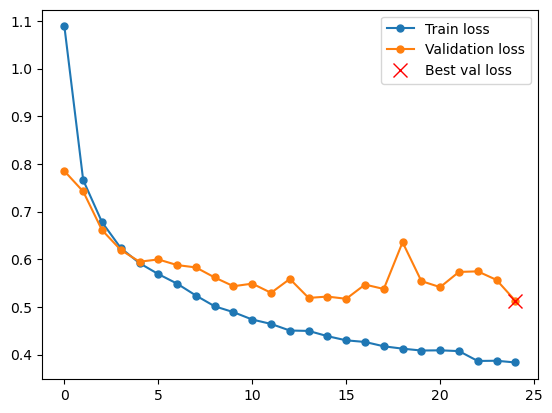

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Model052(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 60)
        self.fc2 = nn.Linear(60, 50)
        self.fc3 = nn.Linear(50, 40)
        self.fc4 = nn.Linear(40, 40)
        self.fc5 = nn.Linear(40, 35)
        self.fc6 = nn.Linear(35, 30)
        self.fc7 = nn.Linear(30, 30)
        self.fc8 = nn.Linear(30, 25)
        self.fc9 = nn.Linear(25, 20)
        self.fc10 = nn.Linear(20, 20)
        self.fc11 = nn.Linear(20, 15)
        self.fco = nn.Linear(15, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = F.relu(self.fc9(x))
        x = F.relu(self.fc10(x))
        x = F.relu(self.fc11(x))
        x = self.fco(x)
        return x

#model03 = Model03()
#outputs = model02(images)
#rint(images.shape, outputs.shape)
model052 = Model052().to(device)
optimizer052= torch.optim.Adam(model052.parameters())
train_more_epochs_es(25,5,model052,loss_fn,optimizer052,training_loader)
del model052
torch.cuda.empty_cache()

Zvýšení ani snížení počtu neuronů síti s 12 vrstvami nepomohlo, nejlepší tedy asi bdue původní počet.

Největší smysl má síť o hloubce 9 vrstev, zkusím teď zvýšt počet neuronů.

EPOCH 1:


100%|██████████| 985/985 [00:05<00:00, 181.01it/s]


TRAIN loss: 0.953, VALIDATION loss: 0.849, accuraccy: 0.676
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:04<00:00, 201.23it/s]


TRAIN loss: 0.675, VALIDATION loss: 0.664, accuraccy: 0.756
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:04<00:00, 197.64it/s]


TRAIN loss: 0.592, VALIDATION loss: 0.569, accuraccy: 0.791
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:05<00:00, 167.15it/s]


TRAIN loss: 0.551, VALIDATION loss: 0.565, accuraccy: 0.797
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:07<00:00, 139.17it/s]


TRAIN loss: 0.512, VALIDATION loss: 0.601, accuraccy: 0.772
No improvement in this epoch.
EPOCH 6:


100%|██████████| 985/985 [00:05<00:00, 173.06it/s]


TRAIN loss: 0.490, VALIDATION loss: 0.516, accuraccy: 0.812
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:06<00:00, 159.42it/s]


TRAIN loss: 0.471, VALIDATION loss: 0.508, accuraccy: 0.816
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:06<00:00, 142.17it/s]


TRAIN loss: 0.457, VALIDATION loss: 0.544, accuraccy: 0.811
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:06<00:00, 145.27it/s]


TRAIN loss: 0.443, VALIDATION loss: 0.560, accuraccy: 0.803
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:06<00:00, 144.67it/s]


TRAIN loss: 0.426, VALIDATION loss: 0.487, accuraccy: 0.828
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:07<00:00, 132.21it/s]


TRAIN loss: 0.407, VALIDATION loss: 0.503, accuraccy: 0.818
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:05<00:00, 170.56it/s]


TRAIN loss: 0.404, VALIDATION loss: 0.534, accuraccy: 0.820
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:05<00:00, 169.66it/s]


TRAIN loss: 0.389, VALIDATION loss: 0.516, accuraccy: 0.823
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:05<00:00, 174.08it/s]


TRAIN loss: 0.381, VALIDATION loss: 0.485, accuraccy: 0.832
Saving best model
EPOCH 15:


100%|██████████| 985/985 [00:05<00:00, 170.00it/s]


TRAIN loss: 0.370, VALIDATION loss: 0.506, accuraccy: 0.823
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:06<00:00, 149.79it/s]


TRAIN loss: 0.368, VALIDATION loss: 0.529, accuraccy: 0.821
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:07<00:00, 138.70it/s]


TRAIN loss: 0.362, VALIDATION loss: 0.494, accuraccy: 0.836
Saving best model
EPOCH 18:


100%|██████████| 985/985 [00:07<00:00, 133.82it/s]


TRAIN loss: 0.356, VALIDATION loss: 0.516, accuraccy: 0.829
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:06<00:00, 148.00it/s]


TRAIN loss: 0.346, VALIDATION loss: 0.553, accuraccy: 0.813
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:06<00:00, 149.12it/s]


TRAIN loss: 0.340, VALIDATION loss: 0.584, accuraccy: 0.812
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:06<00:00, 140.97it/s]


TRAIN loss: 0.341, VALIDATION loss: 0.509, accuraccy: 0.844
Saving best model
EPOCH 22:


100%|██████████| 985/985 [00:07<00:00, 133.32it/s]


TRAIN loss: 0.325, VALIDATION loss: 0.521, accuraccy: 0.831
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:06<00:00, 150.28it/s]


TRAIN loss: 0.322, VALIDATION loss: 0.510, accuraccy: 0.834
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:07<00:00, 139.74it/s]


TRAIN loss: 0.321, VALIDATION loss: 0.520, accuraccy: 0.834
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:06<00:00, 146.90it/s]


TRAIN loss: 0.323, VALIDATION loss: 0.527, accuraccy: 0.831
No improvement in this epoch.


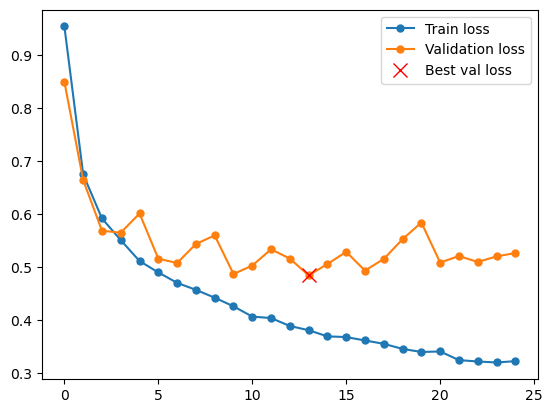

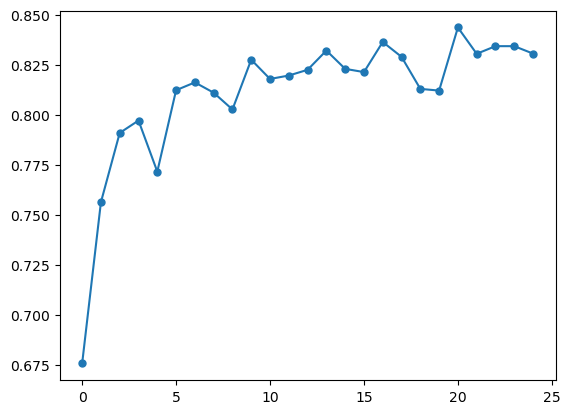

In [189]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Model081(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 150)
        self.fc2 = nn.Linear(150, 100)
        self.fc3 = nn.Linear(100, 80)
        self.fc4 = nn.Linear(80, 60)
        self.fc5 = nn.Linear(60, 40)
        self.fc6 = nn.Linear(40, 30)
        self.fc7 = nn.Linear(30, 30)
        self.fc8 = nn.Linear(30, 20)
        self.fco = nn.Linear(20, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = self.fco(x)
        return x

#model03 = Model03()
#outputs = model02(images)
#rint(images.shape, outputs.shape)
model081= Model081().to(device)
optimizer081 = torch.optim.Adam(model081.parameters())
train_more_epochs_es(25,5,model081,loss_fn,optimizer081,training_loader,validation_loader)
del model081
torch.cuda.empty_cache()

EPOCH 1:


100%|██████████| 985/985 [00:05<00:00, 186.25it/s]


TRAIN loss: 0.897, VALIDATION loss: 0.917, accuraccy: 0.660
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:05<00:00, 193.16it/s]


TRAIN loss: 0.643, VALIDATION loss: 0.592, accuraccy: 0.788
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:05<00:00, 183.39it/s]


TRAIN loss: 0.572, VALIDATION loss: 0.569, accuraccy: 0.791
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:06<00:00, 154.63it/s]


TRAIN loss: 0.526, VALIDATION loss: 0.589, accuraccy: 0.787
No improvement in this epoch.
EPOCH 5:


100%|██████████| 985/985 [00:06<00:00, 163.42it/s]


TRAIN loss: 0.499, VALIDATION loss: 0.558, accuraccy: 0.799
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:05<00:00, 172.55it/s]


TRAIN loss: 0.479, VALIDATION loss: 0.570, accuraccy: 0.801
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:05<00:00, 168.13it/s]


TRAIN loss: 0.461, VALIDATION loss: 0.543, accuraccy: 0.813
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:07<00:00, 136.93it/s]


TRAIN loss: 0.439, VALIDATION loss: 0.493, accuraccy: 0.822
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:05<00:00, 170.35it/s]


TRAIN loss: 0.425, VALIDATION loss: 0.521, accuraccy: 0.818
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:06<00:00, 157.14it/s]


TRAIN loss: 0.419, VALIDATION loss: 0.503, accuraccy: 0.823
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:06<00:00, 160.47it/s]


TRAIN loss: 0.406, VALIDATION loss: 0.559, accuraccy: 0.808
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:05<00:00, 174.18it/s]


TRAIN loss: 0.398, VALIDATION loss: 0.498, accuraccy: 0.831
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:06<00:00, 154.91it/s]


TRAIN loss: 0.384, VALIDATION loss: 0.504, accuraccy: 0.830
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:06<00:00, 153.92it/s]


TRAIN loss: 0.377, VALIDATION loss: 0.499, accuraccy: 0.832
Saving best model
EPOCH 15:


100%|██████████| 985/985 [00:05<00:00, 166.84it/s]


TRAIN loss: 0.367, VALIDATION loss: 0.514, accuraccy: 0.830
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:06<00:00, 159.34it/s]


TRAIN loss: 0.360, VALIDATION loss: 0.515, accuraccy: 0.829
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:05<00:00, 164.63it/s]


TRAIN loss: 0.348, VALIDATION loss: 0.480, accuraccy: 0.830
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:06<00:00, 153.66it/s]


TRAIN loss: 0.346, VALIDATION loss: 0.525, accuraccy: 0.828
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:06<00:00, 162.51it/s]


TRAIN loss: 0.337, VALIDATION loss: 0.499, accuraccy: 0.829
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:05<00:00, 175.80it/s]


TRAIN loss: 0.338, VALIDATION loss: 0.518, accuraccy: 0.834
Saving best model
EPOCH 21:


100%|██████████| 985/985 [00:06<00:00, 162.39it/s]


TRAIN loss: 0.330, VALIDATION loss: 0.535, accuraccy: 0.831
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:06<00:00, 158.33it/s]


TRAIN loss: 0.316, VALIDATION loss: 0.560, accuraccy: 0.823
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:05<00:00, 175.57it/s]


TRAIN loss: 0.317, VALIDATION loss: 0.482, accuraccy: 0.844
Saving best model
EPOCH 24:


100%|██████████| 985/985 [00:06<00:00, 152.63it/s]


TRAIN loss: 0.304, VALIDATION loss: 0.527, accuraccy: 0.838
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:05<00:00, 167.11it/s]


TRAIN loss: 0.308, VALIDATION loss: 0.495, accuraccy: 0.835
No improvement in this epoch.
EPOCH 26:


100%|██████████| 985/985 [00:05<00:00, 179.26it/s]


TRAIN loss: 0.309, VALIDATION loss: 0.570, accuraccy: 0.839
No improvement in this epoch.
EPOCH 27:


100%|██████████| 985/985 [00:07<00:00, 139.52it/s]


TRAIN loss: 0.308, VALIDATION loss: 0.559, accuraccy: 0.836
No improvement in this epoch.
EPOCH 28:


100%|██████████| 985/985 [00:05<00:00, 176.07it/s]


TRAIN loss: 0.297, VALIDATION loss: 0.511, accuraccy: 0.842
No improvement in this epoch.
EPOCH 29:


100%|██████████| 985/985 [00:05<00:00, 168.87it/s]


TRAIN loss: 0.296, VALIDATION loss: 0.525, accuraccy: 0.835
No improvement in this epoch.
Early stopping now


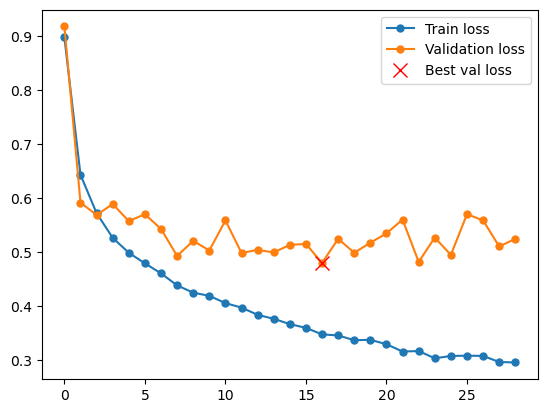

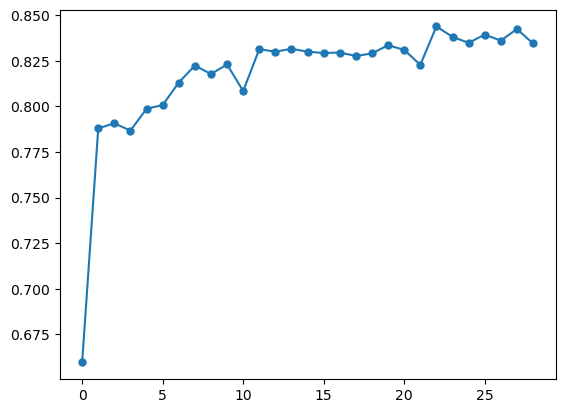

In [190]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Model082(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 200)
        self.fc2 = nn.Linear(200, 150)
        self.fc3 = nn.Linear(150, 100)
        self.fc4 = nn.Linear(100, 80)
        self.fc5 = nn.Linear(80, 60)
        self.fc6 = nn.Linear(60, 40)
        self.fc7 = nn.Linear(40, 30)
        self.fc8 = nn.Linear(30, 20)
        self.fco = nn.Linear(20, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = self.fco(x)
        return x

#model03 = Model03()
#outputs = model02(images)
#rint(images.shape, outputs.shape)
model082= Model082().to(device)
optimizer082 = torch.optim.Adam(model082.parameters())
train_more_epochs_es(30,5,model082,loss_fn,optimizer082,training_loader,validation_loader)
del model082
torch.cuda.empty_cache()

S ještě vyšším počtem neuronů se dostávám na 0.841 validační accuracy

EPOCH 1:


100%|██████████| 985/985 [00:05<00:00, 184.40it/s]


TRAIN loss: 0.952, VALIDATION loss: 0.718, accuraccy: 0.725
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:05<00:00, 184.89it/s]


TRAIN loss: 0.658, VALIDATION loss: 0.625, accuraccy: 0.774
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:05<00:00, 184.84it/s]


TRAIN loss: 0.572, VALIDATION loss: 0.626, accuraccy: 0.773
No improvement in this epoch.
EPOCH 4:


100%|██████████| 985/985 [00:06<00:00, 146.83it/s]


TRAIN loss: 0.533, VALIDATION loss: 0.551, accuraccy: 0.808
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:06<00:00, 161.71it/s]


TRAIN loss: 0.501, VALIDATION loss: 0.527, accuraccy: 0.805
No improvement in this epoch.
EPOCH 6:


100%|██████████| 985/985 [00:05<00:00, 164.25it/s]


TRAIN loss: 0.475, VALIDATION loss: 0.506, accuraccy: 0.820
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:06<00:00, 157.11it/s]


TRAIN loss: 0.456, VALIDATION loss: 0.524, accuraccy: 0.809
No improvement in this epoch.
EPOCH 8:


100%|██████████| 985/985 [00:05<00:00, 164.86it/s]


TRAIN loss: 0.444, VALIDATION loss: 0.540, accuraccy: 0.814
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:06<00:00, 149.87it/s]


TRAIN loss: 0.429, VALIDATION loss: 0.510, accuraccy: 0.822
Saving best model
EPOCH 10:


100%|██████████| 985/985 [00:06<00:00, 151.11it/s]


TRAIN loss: 0.415, VALIDATION loss: 0.501, accuraccy: 0.823
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:05<00:00, 165.35it/s]


TRAIN loss: 0.395, VALIDATION loss: 0.517, accuraccy: 0.821
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:05<00:00, 169.72it/s]


TRAIN loss: 0.385, VALIDATION loss: 0.510, accuraccy: 0.828
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:06<00:00, 144.53it/s]


TRAIN loss: 0.375, VALIDATION loss: 0.492, accuraccy: 0.835
Saving best model
EPOCH 14:


100%|██████████| 985/985 [00:05<00:00, 166.51it/s]


TRAIN loss: 0.368, VALIDATION loss: 0.534, accuraccy: 0.820
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:06<00:00, 163.84it/s]


TRAIN loss: 0.359, VALIDATION loss: 0.507, accuraccy: 0.831
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:05<00:00, 172.03it/s]


TRAIN loss: 0.353, VALIDATION loss: 0.520, accuraccy: 0.833
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:05<00:00, 169.75it/s]


TRAIN loss: 0.344, VALIDATION loss: 0.518, accuraccy: 0.829
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:05<00:00, 165.82it/s]


TRAIN loss: 0.340, VALIDATION loss: 0.524, accuraccy: 0.837
Saving best model
EPOCH 19:


100%|██████████| 985/985 [00:06<00:00, 145.71it/s]


TRAIN loss: 0.331, VALIDATION loss: 0.537, accuraccy: 0.835
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:06<00:00, 150.27it/s]


TRAIN loss: 0.322, VALIDATION loss: 0.544, accuraccy: 0.836
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:06<00:00, 149.34it/s]


TRAIN loss: 0.331, VALIDATION loss: 0.488, accuraccy: 0.842
Saving best model
EPOCH 22:


100%|██████████| 985/985 [00:05<00:00, 176.66it/s]


TRAIN loss: 0.323, VALIDATION loss: 0.514, accuraccy: 0.836
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:05<00:00, 171.89it/s]


TRAIN loss: 0.304, VALIDATION loss: 0.536, accuraccy: 0.838
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:06<00:00, 164.05it/s]


TRAIN loss: 0.306, VALIDATION loss: 0.518, accuraccy: 0.837
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:05<00:00, 173.02it/s]


TRAIN loss: 0.297, VALIDATION loss: 0.551, accuraccy: 0.843
Saving best model
EPOCH 26:


100%|██████████| 985/985 [00:05<00:00, 168.10it/s]


TRAIN loss: 0.298, VALIDATION loss: 0.537, accuraccy: 0.847
Saving best model
EPOCH 27:


100%|██████████| 985/985 [00:06<00:00, 149.64it/s]


TRAIN loss: 0.299, VALIDATION loss: 0.550, accuraccy: 0.835
No improvement in this epoch.
EPOCH 28:


100%|██████████| 985/985 [00:05<00:00, 164.84it/s]


TRAIN loss: 0.287, VALIDATION loss: 0.523, accuraccy: 0.836
No improvement in this epoch.
EPOCH 29:


100%|██████████| 985/985 [00:06<00:00, 151.65it/s]


TRAIN loss: 0.284, VALIDATION loss: 0.543, accuraccy: 0.840
No improvement in this epoch.
EPOCH 30:


100%|██████████| 985/985 [00:06<00:00, 152.71it/s]


TRAIN loss: 0.280, VALIDATION loss: 0.525, accuraccy: 0.837
No improvement in this epoch.


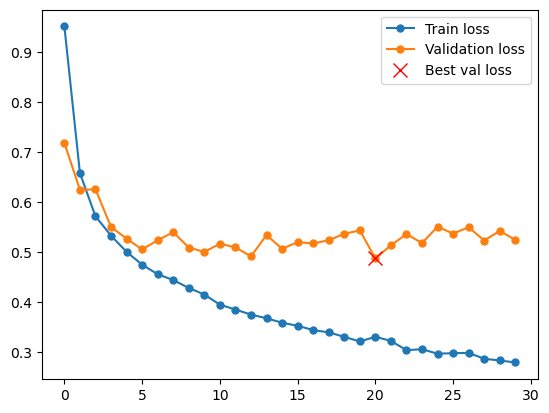

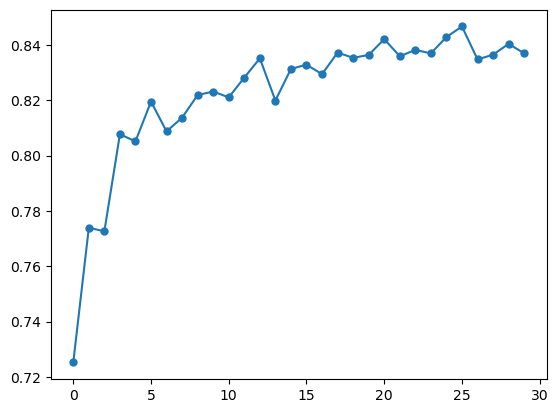

In [193]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Model083(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 250)
        self.fc2 = nn.Linear(250, 150)
        self.fc3 = nn.Linear(150, 100)
        self.fc4 = nn.Linear(100, 60)
        self.fc5 = nn.Linear(60, 40)
        self.fc6 = nn.Linear(40, 30)
        self.fc7 = nn.Linear(30, 30)
        self.fc8 = nn.Linear(30, 20)
        self.fco = nn.Linear(20, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = self.fco(x)
        return x

#model03 = Model03()
#outputs = model02(images)
#rint(images.shape, outputs.shape)
model083= Model083().to(device)
optimizer083 = torch.optim.Adam(model083.parameters())
train_more_epochs_es(30,5,model083,loss_fn,optimizer083,training_loader,validation_loader)
del model083
torch.cuda.empty_cache()

Toto je zatím nejlepší výsledek, zkusím tento model ještě na standardizovaných a normalizovaných datech.

EPOCH 1:


100%|██████████| 985/985 [00:06<00:00, 141.11it/s]


TRAIN loss: 0.968, VALIDATION loss: 0.708, accuraccy: 0.727
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:06<00:00, 159.63it/s]


TRAIN loss: 0.654, VALIDATION loss: 0.616, accuraccy: 0.778
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:06<00:00, 162.69it/s]


TRAIN loss: 0.567, VALIDATION loss: 0.594, accuraccy: 0.785
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:06<00:00, 162.32it/s]


TRAIN loss: 0.513, VALIDATION loss: 0.557, accuraccy: 0.794
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:05<00:00, 165.73it/s]


TRAIN loss: 0.474, VALIDATION loss: 0.558, accuraccy: 0.801
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:06<00:00, 150.63it/s]


TRAIN loss: 0.448, VALIDATION loss: 0.526, accuraccy: 0.810
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:05<00:00, 166.15it/s]


TRAIN loss: 0.421, VALIDATION loss: 0.534, accuraccy: 0.812
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:06<00:00, 153.60it/s]


TRAIN loss: 0.399, VALIDATION loss: 0.502, accuraccy: 0.826
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:06<00:00, 141.14it/s]


TRAIN loss: 0.376, VALIDATION loss: 0.539, accuraccy: 0.812
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:07<00:00, 139.12it/s]


TRAIN loss: 0.367, VALIDATION loss: 0.495, accuraccy: 0.824
No improvement in this epoch.
EPOCH 11:


100%|██████████| 985/985 [00:06<00:00, 153.09it/s]


TRAIN loss: 0.348, VALIDATION loss: 0.557, accuraccy: 0.812
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:05<00:00, 167.25it/s]


TRAIN loss: 0.330, VALIDATION loss: 0.493, accuraccy: 0.830
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:05<00:00, 166.42it/s]


TRAIN loss: 0.323, VALIDATION loss: 0.514, accuraccy: 0.831
Saving best model
EPOCH 14:


100%|██████████| 985/985 [00:06<00:00, 156.99it/s]


TRAIN loss: 0.304, VALIDATION loss: 0.509, accuraccy: 0.833
Saving best model
EPOCH 15:


100%|██████████| 985/985 [00:06<00:00, 155.35it/s]


TRAIN loss: 0.301, VALIDATION loss: 0.506, accuraccy: 0.832
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:05<00:00, 171.44it/s]


TRAIN loss: 0.288, VALIDATION loss: 0.533, accuraccy: 0.828
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:06<00:00, 158.95it/s]


TRAIN loss: 0.276, VALIDATION loss: 0.558, accuraccy: 0.825
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:05<00:00, 168.87it/s]


TRAIN loss: 0.265, VALIDATION loss: 0.543, accuraccy: 0.832
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:05<00:00, 166.44it/s]


TRAIN loss: 0.260, VALIDATION loss: 0.548, accuraccy: 0.835
Saving best model
EPOCH 20:


100%|██████████| 985/985 [00:07<00:00, 137.26it/s]


TRAIN loss: 0.251, VALIDATION loss: 0.577, accuraccy: 0.823
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:05<00:00, 170.38it/s]


TRAIN loss: 0.240, VALIDATION loss: 0.559, accuraccy: 0.837
Saving best model
EPOCH 22:


100%|██████████| 985/985 [00:05<00:00, 171.37it/s]


TRAIN loss: 0.232, VALIDATION loss: 0.574, accuraccy: 0.824
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:06<00:00, 160.35it/s]


TRAIN loss: 0.229, VALIDATION loss: 0.558, accuraccy: 0.831
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:07<00:00, 137.82it/s]


TRAIN loss: 0.218, VALIDATION loss: 0.567, accuraccy: 0.835
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:05<00:00, 171.80it/s]


TRAIN loss: 0.208, VALIDATION loss: 0.608, accuraccy: 0.834
No improvement in this epoch.
EPOCH 26:


100%|██████████| 985/985 [00:06<00:00, 159.80it/s]


TRAIN loss: 0.204, VALIDATION loss: 0.634, accuraccy: 0.838
Saving best model
EPOCH 27:


100%|██████████| 985/985 [00:06<00:00, 161.13it/s]


TRAIN loss: 0.203, VALIDATION loss: 0.623, accuraccy: 0.826
No improvement in this epoch.
EPOCH 28:


100%|██████████| 985/985 [00:05<00:00, 170.17it/s]


TRAIN loss: 0.198, VALIDATION loss: 0.640, accuraccy: 0.830
No improvement in this epoch.
EPOCH 29:


100%|██████████| 985/985 [00:07<00:00, 125.46it/s]


TRAIN loss: 0.183, VALIDATION loss: 0.599, accuraccy: 0.838
No improvement in this epoch.
EPOCH 30:


100%|██████████| 985/985 [00:06<00:00, 150.53it/s]


TRAIN loss: 0.176, VALIDATION loss: 0.655, accuraccy: 0.836
No improvement in this epoch.


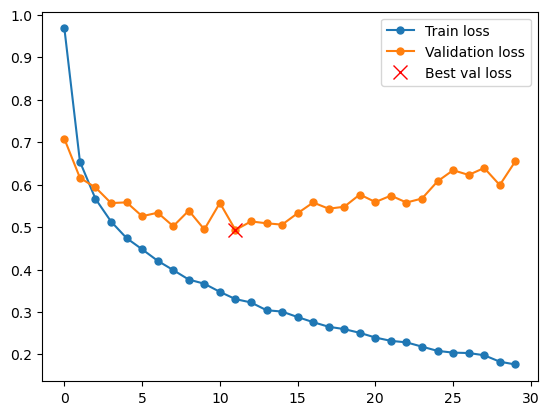

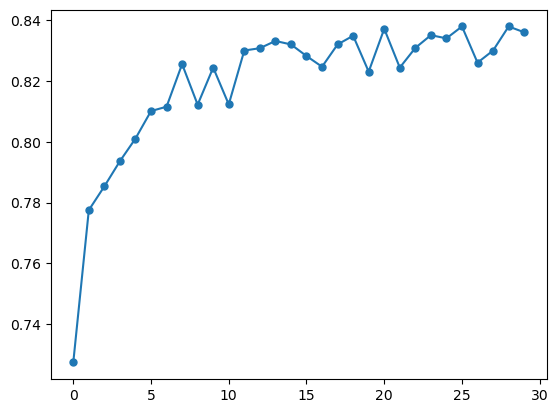

In [194]:
model084 = Model083().to(device)
optimizer084 = torch.optim.Adam(model084.parameters())
train_more_epochs_es(30,5,model084,loss_fn,optimizer084,training_loader_sc, validation_loader_sc)
del model084
torch.cuda.empty_cache()

EPOCH 1:


  0%|          | 0/985 [00:00<?, ?it/s]

100%|██████████| 985/985 [00:08<00:00, 121.39it/s]


TRAIN loss: 1.177, VALIDATION loss: 0.889, accuraccy: 0.629
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:05<00:00, 173.17it/s]


TRAIN loss: 0.788, VALIDATION loss: 0.755, accuraccy: 0.703
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:07<00:00, 136.29it/s]


TRAIN loss: 0.686, VALIDATION loss: 0.654, accuraccy: 0.758
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:07<00:00, 135.50it/s]


TRAIN loss: 0.613, VALIDATION loss: 0.620, accuraccy: 0.768
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:06<00:00, 153.37it/s]


TRAIN loss: 0.553, VALIDATION loss: 0.570, accuraccy: 0.795
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:05<00:00, 186.83it/s]


TRAIN loss: 0.511, VALIDATION loss: 0.543, accuraccy: 0.801
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:06<00:00, 163.23it/s]


TRAIN loss: 0.475, VALIDATION loss: 0.624, accuraccy: 0.763
No improvement in this epoch.
EPOCH 8:


100%|██████████| 985/985 [00:06<00:00, 159.54it/s]


TRAIN loss: 0.457, VALIDATION loss: 0.550, accuraccy: 0.802
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:08<00:00, 116.53it/s]


TRAIN loss: 0.439, VALIDATION loss: 0.512, accuraccy: 0.812
Saving best model
EPOCH 10:


100%|██████████| 985/985 [00:06<00:00, 160.88it/s]


TRAIN loss: 0.415, VALIDATION loss: 0.538, accuraccy: 0.818
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:05<00:00, 190.47it/s]


TRAIN loss: 0.400, VALIDATION loss: 0.484, accuraccy: 0.830
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:06<00:00, 160.67it/s]


TRAIN loss: 0.385, VALIDATION loss: 0.488, accuraccy: 0.824
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:05<00:00, 180.43it/s]


TRAIN loss: 0.372, VALIDATION loss: 0.477, accuraccy: 0.831
Saving best model
EPOCH 14:


100%|██████████| 985/985 [00:05<00:00, 184.57it/s]


TRAIN loss: 0.361, VALIDATION loss: 0.468, accuraccy: 0.831
Saving best model
EPOCH 15:


100%|██████████| 985/985 [00:06<00:00, 153.37it/s]


TRAIN loss: 0.354, VALIDATION loss: 0.509, accuraccy: 0.817
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:05<00:00, 180.98it/s]


TRAIN loss: 0.338, VALIDATION loss: 0.480, accuraccy: 0.836
Saving best model
EPOCH 17:


100%|██████████| 985/985 [00:06<00:00, 144.55it/s]


TRAIN loss: 0.330, VALIDATION loss: 0.474, accuraccy: 0.838
Saving best model
EPOCH 18:


100%|██████████| 985/985 [00:05<00:00, 170.66it/s]


TRAIN loss: 0.323, VALIDATION loss: 0.482, accuraccy: 0.838
Saving best model
EPOCH 19:


100%|██████████| 985/985 [00:05<00:00, 170.73it/s]


TRAIN loss: 0.315, VALIDATION loss: 0.530, accuraccy: 0.828
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:06<00:00, 158.39it/s]


TRAIN loss: 0.308, VALIDATION loss: 0.488, accuraccy: 0.842
Saving best model
EPOCH 21:


100%|██████████| 985/985 [00:06<00:00, 156.62it/s]


TRAIN loss: 0.294, VALIDATION loss: 0.524, accuraccy: 0.841
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:05<00:00, 172.15it/s]


TRAIN loss: 0.289, VALIDATION loss: 0.526, accuraccy: 0.836
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:05<00:00, 165.17it/s]


TRAIN loss: 0.279, VALIDATION loss: 0.524, accuraccy: 0.835
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:05<00:00, 171.54it/s]


TRAIN loss: 0.273, VALIDATION loss: 0.534, accuraccy: 0.834
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:05<00:00, 169.35it/s]


TRAIN loss: 0.267, VALIDATION loss: 0.553, accuraccy: 0.832
No improvement in this epoch.
EPOCH 26:


100%|██████████| 985/985 [00:07<00:00, 137.76it/s]


TRAIN loss: 0.262, VALIDATION loss: 0.525, accuraccy: 0.838
No improvement in this epoch.
Early stopping now


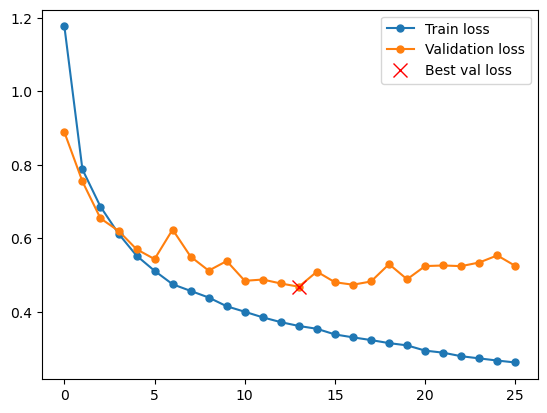

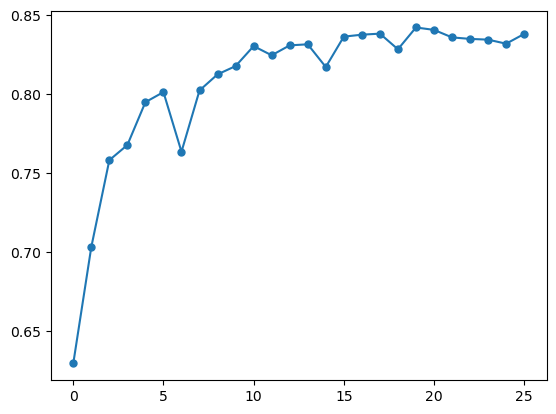

In [195]:
model085 = Model083().to(device)
optimizer085 = torch.optim.Adam(model085.parameters())
train_more_epochs_es(30,5,model085,loss_fn,optimizer085,training_loader_mm, validation_loader_mm)
del model085
torch.cuda.empty_cache()

Tedˇse budu snažit zoptimalizovat model 83 pomocí dropoutu a batch normalizace.

Nejprve zkusím samotný dropout a to s pravděpodobností 0.1, zkoušela jsem i vyšší (např. 0.5 nebo 0.25), ale výsledky byly o hodně horší. Budu používat dropout po každé vrstvě a vyzkouším to i na standardizovaných a normalizovanýh datech.

EPOCH 1:


  0%|          | 0/985 [00:00<?, ?it/s]

100%|██████████| 985/985 [00:07<00:00, 130.17it/s]


TRAIN loss: 1.096, VALIDATION loss: 0.842, accuraccy: 0.680
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:08<00:00, 115.22it/s]


TRAIN loss: 0.808, VALIDATION loss: 0.732, accuraccy: 0.726
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:07<00:00, 138.24it/s]


TRAIN loss: 0.715, VALIDATION loss: 0.664, accuraccy: 0.752
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:06<00:00, 142.49it/s]


TRAIN loss: 0.665, VALIDATION loss: 0.633, accuraccy: 0.758
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:07<00:00, 125.17it/s]


TRAIN loss: 0.643, VALIDATION loss: 0.596, accuraccy: 0.779
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:07<00:00, 123.64it/s]


TRAIN loss: 0.617, VALIDATION loss: 0.601, accuraccy: 0.779
No improvement in this epoch.
EPOCH 7:


100%|██████████| 985/985 [00:07<00:00, 125.37it/s]


TRAIN loss: 0.598, VALIDATION loss: 0.601, accuraccy: 0.775
No improvement in this epoch.
EPOCH 8:


100%|██████████| 985/985 [00:07<00:00, 135.65it/s]


TRAIN loss: 0.586, VALIDATION loss: 0.579, accuraccy: 0.789
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:08<00:00, 113.08it/s]


TRAIN loss: 0.574, VALIDATION loss: 0.614, accuraccy: 0.788
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:07<00:00, 136.57it/s]


TRAIN loss: 0.576, VALIDATION loss: 0.562, accuraccy: 0.800
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:07<00:00, 137.61it/s]


TRAIN loss: 0.548, VALIDATION loss: 0.600, accuraccy: 0.777
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:07<00:00, 135.49it/s]


TRAIN loss: 0.554, VALIDATION loss: 0.538, accuraccy: 0.797
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:06<00:00, 140.81it/s]


TRAIN loss: 0.533, VALIDATION loss: 0.562, accuraccy: 0.804
Saving best model
EPOCH 14:


100%|██████████| 985/985 [00:07<00:00, 128.70it/s]


TRAIN loss: 0.533, VALIDATION loss: 0.538, accuraccy: 0.805
Saving best model
EPOCH 15:


100%|██████████| 985/985 [00:07<00:00, 135.69it/s]


TRAIN loss: 0.530, VALIDATION loss: 0.554, accuraccy: 0.803
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:08<00:00, 116.97it/s]


TRAIN loss: 0.518, VALIDATION loss: 0.534, accuraccy: 0.811
Saving best model
EPOCH 17:


100%|██████████| 985/985 [00:07<00:00, 131.31it/s]


TRAIN loss: 0.512, VALIDATION loss: 0.534, accuraccy: 0.811
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:06<00:00, 146.77it/s]


TRAIN loss: 0.505, VALIDATION loss: 0.538, accuraccy: 0.807
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:07<00:00, 134.78it/s]


TRAIN loss: 0.500, VALIDATION loss: 0.541, accuraccy: 0.811
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:06<00:00, 145.57it/s]


TRAIN loss: 0.500, VALIDATION loss: 0.550, accuraccy: 0.803
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:06<00:00, 147.73it/s]


TRAIN loss: 0.485, VALIDATION loss: 0.552, accuraccy: 0.813
Saving best model
EPOCH 22:


100%|██████████| 985/985 [00:07<00:00, 132.43it/s]


TRAIN loss: 0.485, VALIDATION loss: 0.522, accuraccy: 0.805
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:07<00:00, 127.17it/s]


TRAIN loss: 0.494, VALIDATION loss: 0.509, accuraccy: 0.820
Saving best model
EPOCH 24:


100%|██████████| 985/985 [00:07<00:00, 129.60it/s]


TRAIN loss: 0.477, VALIDATION loss: 0.504, accuraccy: 0.821
Saving best model
EPOCH 25:


100%|██████████| 985/985 [00:08<00:00, 109.84it/s]


TRAIN loss: 0.475, VALIDATION loss: 0.525, accuraccy: 0.813
No improvement in this epoch.
EPOCH 26:


100%|██████████| 985/985 [00:07<00:00, 132.74it/s]


TRAIN loss: 0.472, VALIDATION loss: 0.538, accuraccy: 0.808
No improvement in this epoch.
EPOCH 27:


100%|██████████| 985/985 [00:06<00:00, 143.92it/s]


TRAIN loss: 0.465, VALIDATION loss: 0.508, accuraccy: 0.824
Saving best model
EPOCH 28:


100%|██████████| 985/985 [00:07<00:00, 129.29it/s]


TRAIN loss: 0.493, VALIDATION loss: 0.518, accuraccy: 0.820
No improvement in this epoch.
EPOCH 29:


100%|██████████| 985/985 [00:07<00:00, 128.73it/s]


TRAIN loss: 0.464, VALIDATION loss: 0.532, accuraccy: 0.804
No improvement in this epoch.
EPOCH 30:


100%|██████████| 985/985 [00:07<00:00, 134.93it/s]


TRAIN loss: 0.464, VALIDATION loss: 0.538, accuraccy: 0.820
No improvement in this epoch.


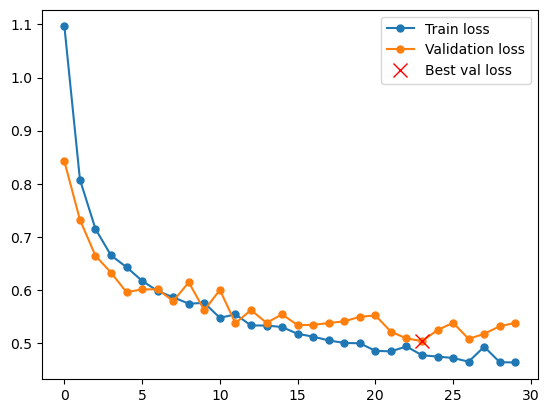

<All keys matched successfully>

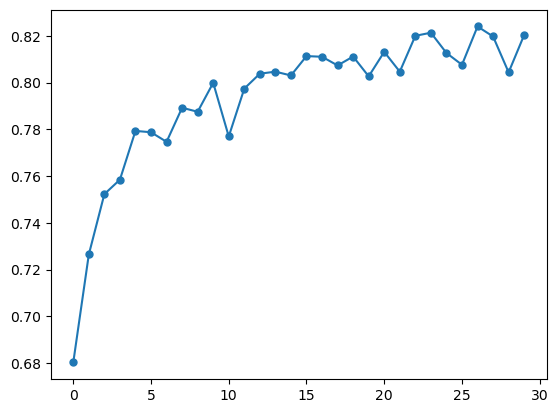

In [199]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Model0831(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 250)
        self.dropout1 = nn.Dropout(0.10)
        self.fc2 = nn.Linear(250, 150)
        self.dropout2 = nn.Dropout(0.10)
        self.fc3 = nn.Linear(150, 100)
        self.dropout3 = nn.Dropout(0.10)
        self.fc4 = nn.Linear(100, 60)
        self.dropout4 = nn.Dropout(0.10)
        self.fc5 = nn.Linear(60, 40)
        self.dropout5 = nn.Dropout(0.10)
        self.fc6 = nn.Linear(40, 30)
        self.dropout6 = nn.Dropout(0.10)
        self.fc7 = nn.Linear(30, 30)
        self.dropout7 = nn.Dropout(0.10)
        self.fc8 = nn.Linear(30, 20)
        self.dropout8 = nn.Dropout(0.10)
        self.fco = nn.Linear(20, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = F.relu(self.fc4(x))
        x = self.dropout4(x)
        x = F.relu(self.fc5(x))
        x = self.dropout5(x)
        x = F.relu(self.fc6(x))
        x = self.dropout6(x)
        x = F.relu(self.fc7(x))
        x = self.dropout7(x)
        x = F.relu(self.fc8(x))
        x = self.fco(x)
        return x

#model03 = Model03()
#outputs = model02(images)
#rint(images.shape, outputs.shape)
model0831= Model0831().to(device)
optimizer0831 = torch.optim.Adam(model0831.parameters())
train_more_epochs_es(30,5,model0831,loss_fn,optimizer0831,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model0831.load_state_dict(torch.load(model_path))

EPOCH 1:


  0%|          | 0/985 [00:00<?, ?it/s]

100%|██████████| 985/985 [00:08<00:00, 113.78it/s]


TRAIN loss: 1.450, VALIDATION loss: 0.981, accuraccy: 0.584
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:09<00:00, 108.24it/s]


TRAIN loss: 0.931, VALIDATION loss: 0.838, accuraccy: 0.623
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:07<00:00, 132.59it/s]


TRAIN loss: 0.841, VALIDATION loss: 0.789, accuraccy: 0.636
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:07<00:00, 128.90it/s]


TRAIN loss: 0.790, VALIDATION loss: 0.752, accuraccy: 0.708
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:07<00:00, 123.77it/s]


TRAIN loss: 0.722, VALIDATION loss: 0.660, accuraccy: 0.748
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:07<00:00, 125.09it/s]


TRAIN loss: 0.646, VALIDATION loss: 0.625, accuraccy: 0.757
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:07<00:00, 133.11it/s]


TRAIN loss: 0.610, VALIDATION loss: 0.586, accuraccy: 0.775
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:06<00:00, 145.00it/s]


TRAIN loss: 0.593, VALIDATION loss: 0.600, accuraccy: 0.773
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:07<00:00, 133.13it/s]


TRAIN loss: 0.570, VALIDATION loss: 0.569, accuraccy: 0.783
Saving best model
EPOCH 10:


100%|██████████| 985/985 [00:07<00:00, 138.91it/s]


TRAIN loss: 0.557, VALIDATION loss: 0.558, accuraccy: 0.790
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:06<00:00, 142.53it/s]


TRAIN loss: 0.542, VALIDATION loss: 0.550, accuraccy: 0.789
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:07<00:00, 139.64it/s]


TRAIN loss: 0.524, VALIDATION loss: 0.569, accuraccy: 0.795
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:06<00:00, 142.34it/s]


TRAIN loss: 0.517, VALIDATION loss: 0.545, accuraccy: 0.799
Saving best model
EPOCH 14:


100%|██████████| 985/985 [00:07<00:00, 127.55it/s]


TRAIN loss: 0.509, VALIDATION loss: 0.540, accuraccy: 0.806
Saving best model
EPOCH 15:


100%|██████████| 985/985 [00:07<00:00, 125.40it/s]


TRAIN loss: 0.499, VALIDATION loss: 0.551, accuraccy: 0.806
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:06<00:00, 146.68it/s]


TRAIN loss: 0.490, VALIDATION loss: 0.524, accuraccy: 0.808
Saving best model
EPOCH 17:


100%|██████████| 985/985 [00:06<00:00, 140.80it/s]


TRAIN loss: 0.484, VALIDATION loss: 0.514, accuraccy: 0.816
Saving best model
EPOCH 18:


100%|██████████| 985/985 [00:06<00:00, 145.54it/s]


TRAIN loss: 0.465, VALIDATION loss: 0.522, accuraccy: 0.811
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:06<00:00, 146.56it/s]


TRAIN loss: 0.456, VALIDATION loss: 0.507, accuraccy: 0.817
Saving best model
EPOCH 20:


100%|██████████| 985/985 [00:06<00:00, 153.27it/s]


TRAIN loss: 0.451, VALIDATION loss: 0.534, accuraccy: 0.815
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:06<00:00, 148.59it/s]


TRAIN loss: 0.444, VALIDATION loss: 0.503, accuraccy: 0.819
Saving best model
EPOCH 22:


100%|██████████| 985/985 [00:07<00:00, 140.35it/s]


TRAIN loss: 0.441, VALIDATION loss: 0.505, accuraccy: 0.822
Saving best model
EPOCH 23:


100%|██████████| 985/985 [00:07<00:00, 136.34it/s]


TRAIN loss: 0.447, VALIDATION loss: 0.515, accuraccy: 0.822
Saving best model
EPOCH 24:


100%|██████████| 985/985 [00:07<00:00, 140.37it/s]


TRAIN loss: 0.422, VALIDATION loss: 0.495, accuraccy: 0.827
Saving best model
EPOCH 25:


100%|██████████| 985/985 [00:06<00:00, 147.10it/s]


TRAIN loss: 0.429, VALIDATION loss: 0.504, accuraccy: 0.826
No improvement in this epoch.
EPOCH 26:


100%|██████████| 985/985 [00:07<00:00, 124.86it/s]


TRAIN loss: 0.425, VALIDATION loss: 0.496, accuraccy: 0.831
Saving best model
EPOCH 27:


100%|██████████| 985/985 [00:07<00:00, 140.50it/s]


TRAIN loss: 0.412, VALIDATION loss: 0.523, accuraccy: 0.816
No improvement in this epoch.
EPOCH 28:


100%|██████████| 985/985 [00:06<00:00, 149.20it/s]


TRAIN loss: 0.406, VALIDATION loss: 0.506, accuraccy: 0.828
No improvement in this epoch.
EPOCH 29:


100%|██████████| 985/985 [00:06<00:00, 141.62it/s]


TRAIN loss: 0.400, VALIDATION loss: 0.499, accuraccy: 0.831
Saving best model
EPOCH 30:


100%|██████████| 985/985 [00:07<00:00, 140.71it/s]


TRAIN loss: 0.398, VALIDATION loss: 0.481, accuraccy: 0.835
Saving best model
EPOCH 31:


100%|██████████| 985/985 [00:06<00:00, 148.49it/s]


TRAIN loss: 0.394, VALIDATION loss: 0.483, accuraccy: 0.831
No improvement in this epoch.
EPOCH 32:


100%|██████████| 985/985 [00:07<00:00, 126.28it/s]


TRAIN loss: 0.397, VALIDATION loss: 0.482, accuraccy: 0.833
No improvement in this epoch.
EPOCH 33:


100%|██████████| 985/985 [00:06<00:00, 144.81it/s]


TRAIN loss: 0.386, VALIDATION loss: 0.519, accuraccy: 0.824
No improvement in this epoch.
EPOCH 34:


100%|██████████| 985/985 [00:07<00:00, 127.28it/s]


TRAIN loss: 0.389, VALIDATION loss: 0.477, accuraccy: 0.836
Saving best model
EPOCH 35:


100%|██████████| 985/985 [00:06<00:00, 140.99it/s]


TRAIN loss: 0.375, VALIDATION loss: 0.487, accuraccy: 0.838
Saving best model


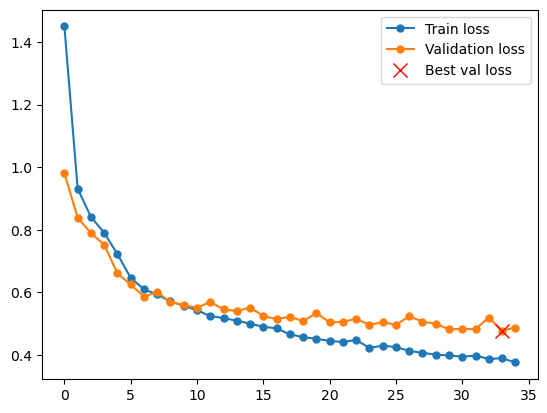

<All keys matched successfully>

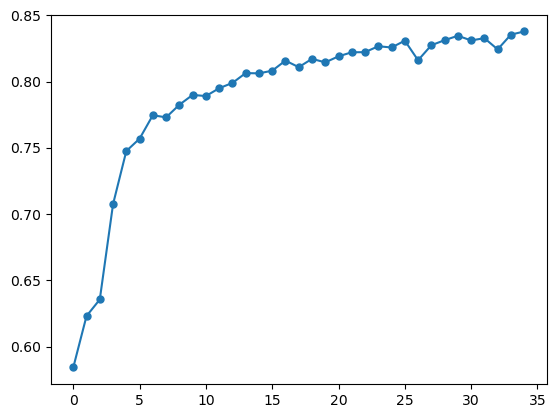

In [202]:
model0831_mm= Model0831().to(device)
optimizer0831_mm = torch.optim.Adam(model0831_mm.parameters())
train_more_epochs_es(35,5,model0831_mm,loss_fn,optimizer0831_mm,training_loader_mm,validation_loader_mm)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model0831_mm.load_state_dict(torch.load(model_path))

EPOCH 1:


  0%|          | 0/985 [00:00<?, ?it/s]

100%|██████████| 985/985 [00:06<00:00, 153.03it/s]


TRAIN loss: 1.144, VALIDATION loss: 0.855, accuraccy: 0.638
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:07<00:00, 134.27it/s]


TRAIN loss: 0.831, VALIDATION loss: 0.759, accuraccy: 0.686
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:08<00:00, 110.15it/s]


TRAIN loss: 0.746, VALIDATION loss: 0.689, accuraccy: 0.742
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:09<00:00, 105.80it/s]


TRAIN loss: 0.663, VALIDATION loss: 0.627, accuraccy: 0.768
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:10<00:00, 90.79it/s] 


TRAIN loss: 0.623, VALIDATION loss: 0.589, accuraccy: 0.771
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:10<00:00, 92.39it/s] 


TRAIN loss: 0.590, VALIDATION loss: 0.604, accuraccy: 0.776
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:09<00:00, 108.16it/s]


TRAIN loss: 0.568, VALIDATION loss: 0.576, accuraccy: 0.792
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:08<00:00, 115.03it/s]


TRAIN loss: 0.549, VALIDATION loss: 0.583, accuraccy: 0.789
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:08<00:00, 112.79it/s]


TRAIN loss: 0.528, VALIDATION loss: 0.594, accuraccy: 0.800
Saving best model
EPOCH 10:


100%|██████████| 985/985 [00:08<00:00, 110.60it/s]


TRAIN loss: 0.513, VALIDATION loss: 0.564, accuraccy: 0.798
No improvement in this epoch.
EPOCH 11:


100%|██████████| 985/985 [00:07<00:00, 126.85it/s]


TRAIN loss: 0.493, VALIDATION loss: 0.545, accuraccy: 0.804
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:07<00:00, 124.13it/s]


TRAIN loss: 0.472, VALIDATION loss: 0.537, accuraccy: 0.814
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:08<00:00, 112.52it/s]


TRAIN loss: 0.466, VALIDATION loss: 0.506, accuraccy: 0.822
Saving best model
EPOCH 14:


100%|██████████| 985/985 [00:08<00:00, 116.31it/s]


TRAIN loss: 0.457, VALIDATION loss: 0.512, accuraccy: 0.822
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:07<00:00, 123.37it/s]


TRAIN loss: 0.443, VALIDATION loss: 0.504, accuraccy: 0.823
Saving best model
EPOCH 16:


100%|██████████| 985/985 [00:07<00:00, 124.79it/s]


TRAIN loss: 0.435, VALIDATION loss: 0.515, accuraccy: 0.820
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:07<00:00, 134.27it/s]


TRAIN loss: 0.426, VALIDATION loss: 0.521, accuraccy: 0.822
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:07<00:00, 133.09it/s]


TRAIN loss: 0.419, VALIDATION loss: 0.506, accuraccy: 0.829
Saving best model
EPOCH 19:


100%|██████████| 985/985 [00:08<00:00, 122.85it/s]


TRAIN loss: 0.412, VALIDATION loss: 0.525, accuraccy: 0.822
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:09<00:00, 107.85it/s]


TRAIN loss: 0.405, VALIDATION loss: 0.521, accuraccy: 0.822
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:07<00:00, 135.06it/s]


TRAIN loss: 0.406, VALIDATION loss: 0.582, accuraccy: 0.816
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:07<00:00, 134.09it/s]


TRAIN loss: 0.399, VALIDATION loss: 0.516, accuraccy: 0.828
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:07<00:00, 132.55it/s]


TRAIN loss: 0.388, VALIDATION loss: 0.534, accuraccy: 0.820
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:06<00:00, 144.45it/s]


TRAIN loss: 0.380, VALIDATION loss: 0.520, accuraccy: 0.830
Saving best model
EPOCH 25:


100%|██████████| 985/985 [00:07<00:00, 128.60it/s]


TRAIN loss: 0.377, VALIDATION loss: 0.530, accuraccy: 0.827
No improvement in this epoch.
EPOCH 26:


100%|██████████| 985/985 [00:07<00:00, 136.29it/s]


TRAIN loss: 0.375, VALIDATION loss: 0.547, accuraccy: 0.820
No improvement in this epoch.
EPOCH 27:


100%|██████████| 985/985 [00:07<00:00, 138.14it/s]


TRAIN loss: 0.370, VALIDATION loss: 0.534, accuraccy: 0.831
Saving best model
EPOCH 28:


100%|██████████| 985/985 [00:08<00:00, 119.97it/s]


TRAIN loss: 0.362, VALIDATION loss: 0.532, accuraccy: 0.836
Saving best model
EPOCH 29:


100%|██████████| 985/985 [00:08<00:00, 119.99it/s]


TRAIN loss: 0.357, VALIDATION loss: 0.542, accuraccy: 0.827
No improvement in this epoch.
EPOCH 30:


100%|██████████| 985/985 [00:10<00:00, 93.55it/s] 


TRAIN loss: 0.358, VALIDATION loss: 0.555, accuraccy: 0.825
No improvement in this epoch.
EPOCH 31:


100%|██████████| 985/985 [00:07<00:00, 123.22it/s]


TRAIN loss: 0.356, VALIDATION loss: 0.534, accuraccy: 0.828
No improvement in this epoch.
EPOCH 32:


100%|██████████| 985/985 [00:07<00:00, 136.34it/s]


TRAIN loss: 0.362, VALIDATION loss: 0.525, accuraccy: 0.829
No improvement in this epoch.
EPOCH 33:


100%|██████████| 985/985 [00:07<00:00, 135.56it/s]


TRAIN loss: 0.346, VALIDATION loss: 0.524, accuraccy: 0.831
No improvement in this epoch.
EPOCH 34:


100%|██████████| 985/985 [00:09<00:00, 108.88it/s]


TRAIN loss: 0.346, VALIDATION loss: 0.524, accuraccy: 0.826
No improvement in this epoch.
Early stopping now


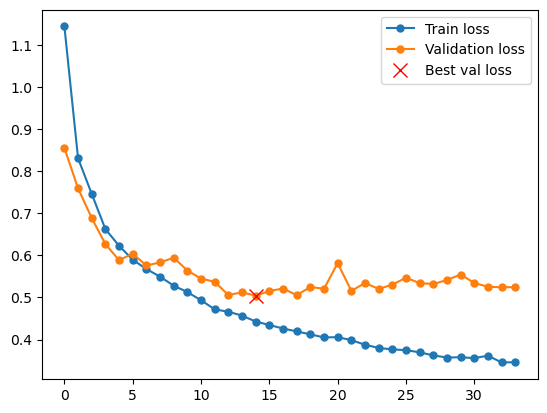

<All keys matched successfully>

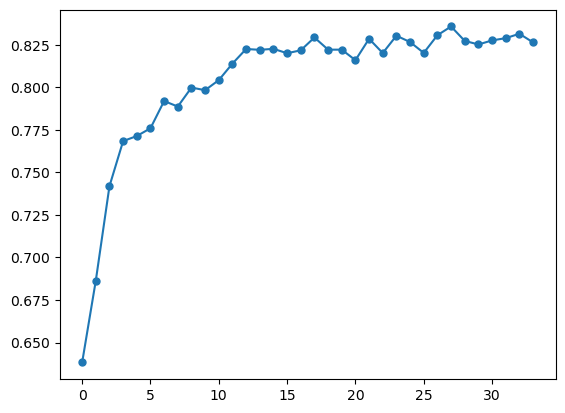

In [203]:
model0831_sc= Model0831().to(device)
optimizer0831_sc = torch.optim.Adam(model0831_sc.parameters())
train_more_epochs_es(35,5,model0831_sc,loss_fn,optimizer0831_sc,training_loader_sc,validation_loader_sc)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model0831_sc.load_state_dict(torch.load(model_path))

EPOCH 1:


100%|██████████| 985/985 [00:05<00:00, 164.54it/s]


TRAIN loss: 0.926, VALIDATION loss: 0.696, accuraccy: 0.750
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:06<00:00, 160.61it/s]


TRAIN loss: 0.651, VALIDATION loss: 0.665, accuraccy: 0.753
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:07<00:00, 125.21it/s]


TRAIN loss: 0.588, VALIDATION loss: 0.572, accuraccy: 0.792
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:06<00:00, 141.84it/s]


TRAIN loss: 0.550, VALIDATION loss: 0.585, accuraccy: 0.793
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:06<00:00, 155.65it/s]


TRAIN loss: 0.524, VALIDATION loss: 0.538, accuraccy: 0.811
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:06<00:00, 144.10it/s]


TRAIN loss: 0.492, VALIDATION loss: 0.536, accuraccy: 0.808
No improvement in this epoch.
EPOCH 7:


100%|██████████| 985/985 [00:06<00:00, 145.73it/s]


TRAIN loss: 0.480, VALIDATION loss: 0.533, accuraccy: 0.804
No improvement in this epoch.
EPOCH 8:


100%|██████████| 985/985 [00:06<00:00, 157.67it/s]


TRAIN loss: 0.468, VALIDATION loss: 0.500, accuraccy: 0.815
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:06<00:00, 147.87it/s]


TRAIN loss: 0.448, VALIDATION loss: 0.486, accuraccy: 0.828
Saving best model
EPOCH 10:


100%|██████████| 985/985 [00:06<00:00, 142.11it/s]


TRAIN loss: 0.437, VALIDATION loss: 0.549, accuraccy: 0.809
No improvement in this epoch.
EPOCH 11:


100%|██████████| 985/985 [00:06<00:00, 144.81it/s]


TRAIN loss: 0.428, VALIDATION loss: 0.525, accuraccy: 0.816
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:07<00:00, 132.67it/s]


TRAIN loss: 0.418, VALIDATION loss: 0.515, accuraccy: 0.822
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:06<00:00, 161.78it/s]


TRAIN loss: 0.405, VALIDATION loss: 0.492, accuraccy: 0.829
Saving best model
EPOCH 14:


100%|██████████| 985/985 [00:06<00:00, 153.57it/s]


TRAIN loss: 0.395, VALIDATION loss: 0.492, accuraccy: 0.828
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:06<00:00, 147.40it/s]


TRAIN loss: 0.394, VALIDATION loss: 0.507, accuraccy: 0.824
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:06<00:00, 152.07it/s]


TRAIN loss: 0.391, VALIDATION loss: 0.519, accuraccy: 0.819
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:06<00:00, 152.60it/s]


TRAIN loss: 0.381, VALIDATION loss: 0.486, accuraccy: 0.833
Saving best model
EPOCH 18:


100%|██████████| 985/985 [00:06<00:00, 150.29it/s]


TRAIN loss: 0.372, VALIDATION loss: 0.506, accuraccy: 0.830
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:06<00:00, 162.37it/s]


TRAIN loss: 0.367, VALIDATION loss: 0.481, accuraccy: 0.834
Saving best model
EPOCH 20:


100%|██████████| 985/985 [00:06<00:00, 150.12it/s]


TRAIN loss: 0.359, VALIDATION loss: 0.483, accuraccy: 0.839
Saving best model
EPOCH 21:


100%|██████████| 985/985 [00:07<00:00, 135.63it/s]


TRAIN loss: 0.351, VALIDATION loss: 0.494, accuraccy: 0.832
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:06<00:00, 147.78it/s]


TRAIN loss: 0.352, VALIDATION loss: 0.525, accuraccy: 0.827
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:06<00:00, 154.87it/s]


TRAIN loss: 0.337, VALIDATION loss: 0.510, accuraccy: 0.842
Saving best model
EPOCH 24:


100%|██████████| 985/985 [00:06<00:00, 149.47it/s]


TRAIN loss: 0.344, VALIDATION loss: 0.565, accuraccy: 0.835
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:07<00:00, 136.98it/s]


TRAIN loss: 0.334, VALIDATION loss: 0.509, accuraccy: 0.819
No improvement in this epoch.
EPOCH 26:


100%|██████████| 985/985 [00:06<00:00, 156.59it/s]


TRAIN loss: 0.327, VALIDATION loss: 0.493, accuraccy: 0.833
No improvement in this epoch.
EPOCH 27:


100%|██████████| 985/985 [00:06<00:00, 147.38it/s]


TRAIN loss: 0.325, VALIDATION loss: 0.526, accuraccy: 0.831
No improvement in this epoch.
EPOCH 28:


100%|██████████| 985/985 [00:06<00:00, 147.12it/s]


TRAIN loss: 0.325, VALIDATION loss: 0.605, accuraccy: 0.833
No improvement in this epoch.
EPOCH 29:


100%|██████████| 985/985 [00:07<00:00, 138.79it/s]


TRAIN loss: 0.340, VALIDATION loss: 0.518, accuraccy: 0.834
No improvement in this epoch.
Early stopping now


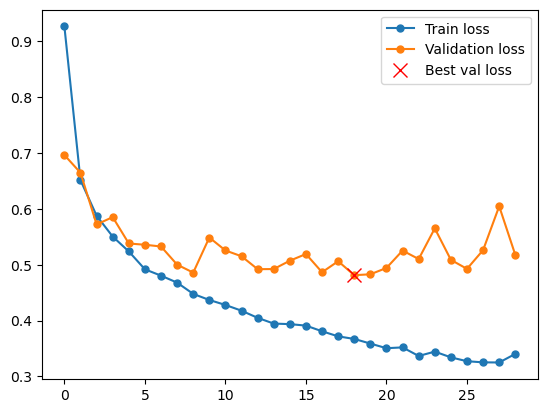

<All keys matched successfully>

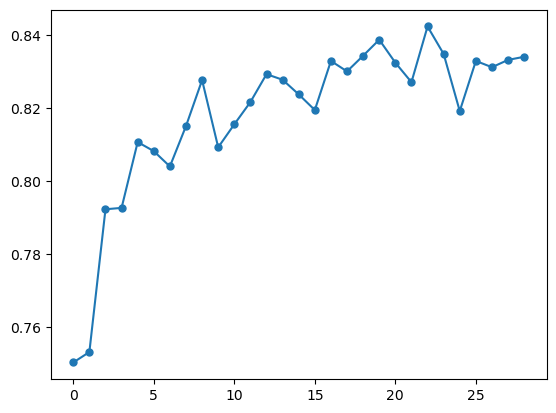

In [206]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Model0838(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 250)
        #self.dropout1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(250, 150)
        self.dropout2 = nn.Dropout(0.10)
        self.fc3 = nn.Linear(150, 100)
        self.dropout3 = nn.Dropout(0.10)
        self.fc4 = nn.Linear(100, 60)
        #self.dropout4 = nn.Dropout(0.25)
        self.fc5 = nn.Linear(60, 40)
        #self.dropout5 = nn.Dropout(0.25)
        self.fc6 = nn.Linear(40, 30)
        #self.dropout6 = nn.Dropout(0.25)
        self.fc7 = nn.Linear(30, 30)
        #self.dropout7 = nn.Dropout(0.25)
        self.fc8 = nn.Linear(30, 20)
        #self.dropout8 = nn.Dropout(0.25)
        self.fco = nn.Linear(20, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        #x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = F.relu(self.fc4(x))
        #x = self.dropout4(x)
        x = F.relu(self.fc5(x))
        #x = self.dropout5(x)
        x = F.relu(self.fc6(x))
        #x = self.dropout6(x)
        x = F.relu(self.fc7(x))
        #x = self.dropout7(x)
        x = F.relu(self.fc8(x))
        x = self.fco(x)
        return x

#model03 = Model03()
#outputs = model02(images)
#rint(images.shape, outputs.shape)
model0838= Model0838().to(device)
optimizer0838 = torch.optim.Adam(model0838.parameters())
train_more_epochs_es(35,5,model0838,loss_fn,optimizer0838,training_loader,validation_loader)
#del model0838
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model0838.load_state_dict(torch.load(model_path))

EPOCH 1:


100%|██████████| 985/985 [00:07<00:00, 139.65it/s]


TRAIN loss: 1.095, VALIDATION loss: 0.744, accuraccy: 0.723
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:07<00:00, 134.28it/s]


TRAIN loss: 0.679, VALIDATION loss: 0.645, accuraccy: 0.757
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:07<00:00, 137.35it/s]


TRAIN loss: 0.587, VALIDATION loss: 0.615, accuraccy: 0.777
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:07<00:00, 128.05it/s]


TRAIN loss: 0.532, VALIDATION loss: 0.562, accuraccy: 0.801
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:07<00:00, 130.55it/s]


TRAIN loss: 0.496, VALIDATION loss: 0.551, accuraccy: 0.798
No improvement in this epoch.
EPOCH 6:


100%|██████████| 985/985 [00:06<00:00, 143.92it/s]


TRAIN loss: 0.462, VALIDATION loss: 0.533, accuraccy: 0.811
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:08<00:00, 122.06it/s]


TRAIN loss: 0.439, VALIDATION loss: 0.532, accuraccy: 0.812
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:08<00:00, 112.94it/s]


TRAIN loss: 0.422, VALIDATION loss: 0.529, accuraccy: 0.812
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:07<00:00, 133.78it/s]


TRAIN loss: 0.403, VALIDATION loss: 0.501, accuraccy: 0.822
Saving best model
EPOCH 10:


100%|██████████| 985/985 [00:07<00:00, 125.34it/s]


TRAIN loss: 0.383, VALIDATION loss: 0.509, accuraccy: 0.820
No improvement in this epoch.
EPOCH 11:


100%|██████████| 985/985 [00:07<00:00, 132.48it/s]


TRAIN loss: 0.374, VALIDATION loss: 0.513, accuraccy: 0.829
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:07<00:00, 130.09it/s]


TRAIN loss: 0.354, VALIDATION loss: 0.491, accuraccy: 0.832
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:07<00:00, 135.15it/s]


TRAIN loss: 0.348, VALIDATION loss: 0.508, accuraccy: 0.832
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:07<00:00, 140.65it/s]


TRAIN loss: 0.332, VALIDATION loss: 0.530, accuraccy: 0.827
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:08<00:00, 116.06it/s]


TRAIN loss: 0.322, VALIDATION loss: 0.498, accuraccy: 0.834
Saving best model
EPOCH 16:


100%|██████████| 985/985 [00:06<00:00, 144.68it/s]


TRAIN loss: 0.313, VALIDATION loss: 0.542, accuraccy: 0.832
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:07<00:00, 135.54it/s]


TRAIN loss: 0.304, VALIDATION loss: 0.497, accuraccy: 0.835
Saving best model
EPOCH 18:


100%|██████████| 985/985 [00:07<00:00, 129.17it/s]


TRAIN loss: 0.294, VALIDATION loss: 0.522, accuraccy: 0.832
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:07<00:00, 137.90it/s]


TRAIN loss: 0.290, VALIDATION loss: 0.532, accuraccy: 0.828
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:07<00:00, 139.98it/s]


TRAIN loss: 0.280, VALIDATION loss: 0.534, accuraccy: 0.828
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:07<00:00, 128.78it/s]


TRAIN loss: 0.271, VALIDATION loss: 0.528, accuraccy: 0.834
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:07<00:00, 129.38it/s]


TRAIN loss: 0.262, VALIDATION loss: 0.558, accuraccy: 0.832
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:07<00:00, 124.86it/s]


TRAIN loss: 0.257, VALIDATION loss: 0.515, accuraccy: 0.840
Saving best model
EPOCH 24:


100%|██████████| 985/985 [00:07<00:00, 133.74it/s]


TRAIN loss: 0.248, VALIDATION loss: 0.558, accuraccy: 0.839
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:07<00:00, 134.68it/s]


TRAIN loss: 0.241, VALIDATION loss: 0.560, accuraccy: 0.843
Saving best model
EPOCH 26:


100%|██████████| 985/985 [00:07<00:00, 133.62it/s]


TRAIN loss: 0.250, VALIDATION loss: 0.533, accuraccy: 0.841
No improvement in this epoch.
EPOCH 27:


100%|██████████| 985/985 [00:07<00:00, 132.03it/s]


TRAIN loss: 0.231, VALIDATION loss: 0.590, accuraccy: 0.840
No improvement in this epoch.
EPOCH 28:


100%|██████████| 985/985 [00:07<00:00, 138.54it/s]


TRAIN loss: 0.222, VALIDATION loss: 0.560, accuraccy: 0.835
No improvement in this epoch.
EPOCH 29:


100%|██████████| 985/985 [00:07<00:00, 126.67it/s]


TRAIN loss: 0.235, VALIDATION loss: 0.570, accuraccy: 0.834
No improvement in this epoch.
EPOCH 30:


100%|██████████| 985/985 [00:09<00:00, 108.16it/s]


TRAIN loss: 0.214, VALIDATION loss: 0.584, accuraccy: 0.843
Saving best model
EPOCH 31:


100%|██████████| 985/985 [00:08<00:00, 116.14it/s]


TRAIN loss: 0.202, VALIDATION loss: 0.632, accuraccy: 0.834
No improvement in this epoch.
EPOCH 32:


100%|██████████| 985/985 [00:07<00:00, 133.33it/s]


TRAIN loss: 0.205, VALIDATION loss: 0.601, accuraccy: 0.840
No improvement in this epoch.
EPOCH 33:


100%|██████████| 985/985 [00:07<00:00, 133.42it/s]


TRAIN loss: 0.213, VALIDATION loss: 0.653, accuraccy: 0.835
No improvement in this epoch.
EPOCH 34:


100%|██████████| 985/985 [00:08<00:00, 109.47it/s]


TRAIN loss: 0.202, VALIDATION loss: 0.620, accuraccy: 0.839
No improvement in this epoch.
EPOCH 35:


100%|██████████| 985/985 [00:08<00:00, 109.63it/s]


TRAIN loss: 0.192, VALIDATION loss: 0.624, accuraccy: 0.840
No improvement in this epoch.


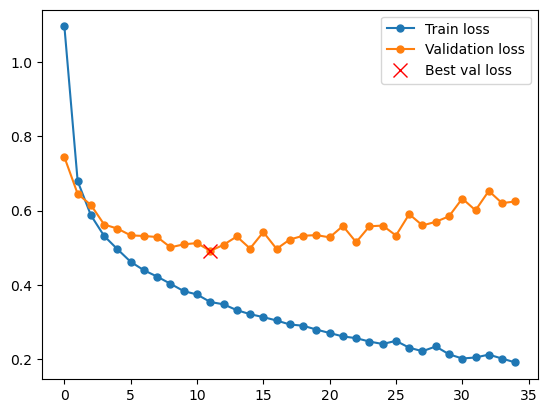

<All keys matched successfully>

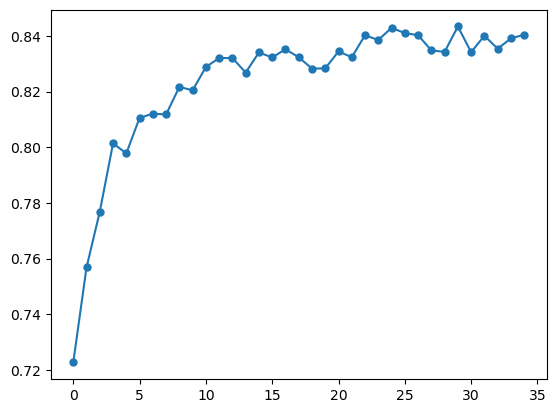

In [210]:
model0838_sc= Model0838().to(device)
optimizer0838_sc = torch.optim.Adam(model0838_sc.parameters())
train_more_epochs_es(35,5,model0838_sc,loss_fn,optimizer0838_sc,training_loader_sc,validation_loader_sc)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model0838_sc.load_state_dict(torch.load(model_path))

EPOCH 1:


100%|██████████| 985/985 [00:07<00:00, 136.41it/s]


TRAIN loss: 1.183, VALIDATION loss: 0.783, accuraccy: 0.703
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:07<00:00, 134.48it/s]


TRAIN loss: 0.760, VALIDATION loss: 0.678, accuraccy: 0.742
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:06<00:00, 153.26it/s]


TRAIN loss: 0.676, VALIDATION loss: 0.625, accuraccy: 0.767
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:10<00:00, 95.37it/s] 


TRAIN loss: 0.626, VALIDATION loss: 0.617, accuraccy: 0.774
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:13<00:00, 72.93it/s] 


TRAIN loss: 0.597, VALIDATION loss: 0.587, accuraccy: 0.788
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:08<00:00, 110.02it/s]


TRAIN loss: 0.570, VALIDATION loss: 0.576, accuraccy: 0.794
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:12<00:00, 81.35it/s] 


TRAIN loss: 0.543, VALIDATION loss: 0.566, accuraccy: 0.796
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:09<00:00, 109.09it/s]


TRAIN loss: 0.537, VALIDATION loss: 0.573, accuraccy: 0.793
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:12<00:00, 78.76it/s] 


TRAIN loss: 0.520, VALIDATION loss: 0.555, accuraccy: 0.799
Saving best model
EPOCH 10:


100%|██████████| 985/985 [00:08<00:00, 115.16it/s]


TRAIN loss: 0.505, VALIDATION loss: 0.533, accuraccy: 0.806
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:07<00:00, 126.75it/s]


TRAIN loss: 0.485, VALIDATION loss: 0.568, accuraccy: 0.814
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:07<00:00, 127.24it/s]


TRAIN loss: 0.472, VALIDATION loss: 0.548, accuraccy: 0.812
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:09<00:00, 106.01it/s]


TRAIN loss: 0.461, VALIDATION loss: 0.530, accuraccy: 0.817
Saving best model
EPOCH 14:


100%|██████████| 985/985 [00:08<00:00, 122.27it/s]


TRAIN loss: 0.450, VALIDATION loss: 0.520, accuraccy: 0.818
Saving best model
EPOCH 15:


100%|██████████| 985/985 [00:08<00:00, 119.61it/s]


TRAIN loss: 0.433, VALIDATION loss: 0.518, accuraccy: 0.816
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:10<00:00, 96.86it/s] 


TRAIN loss: 0.434, VALIDATION loss: 0.502, accuraccy: 0.821
Saving best model
EPOCH 17:


100%|██████████| 985/985 [00:11<00:00, 88.44it/s] 


TRAIN loss: 0.421, VALIDATION loss: 0.497, accuraccy: 0.826
Saving best model
EPOCH 18:


100%|██████████| 985/985 [00:10<00:00, 98.15it/s] 


TRAIN loss: 0.412, VALIDATION loss: 0.508, accuraccy: 0.828
Saving best model
EPOCH 19:


100%|██████████| 985/985 [00:09<00:00, 103.44it/s]


TRAIN loss: 0.405, VALIDATION loss: 0.500, accuraccy: 0.826
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:11<00:00, 84.15it/s] 


TRAIN loss: 0.400, VALIDATION loss: 0.510, accuraccy: 0.829
Saving best model
EPOCH 21:


100%|██████████| 985/985 [00:12<00:00, 79.05it/s] 


TRAIN loss: 0.403, VALIDATION loss: 0.491, accuraccy: 0.832
Saving best model
EPOCH 22:


100%|██████████| 985/985 [00:11<00:00, 83.63it/s] 


TRAIN loss: 0.392, VALIDATION loss: 0.492, accuraccy: 0.826
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:14<00:00, 67.97it/s] 


TRAIN loss: 0.386, VALIDATION loss: 0.513, accuraccy: 0.827
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:11<00:00, 86.55it/s] 


TRAIN loss: 0.373, VALIDATION loss: 0.491, accuraccy: 0.830
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:07<00:00, 126.98it/s]


TRAIN loss: 0.372, VALIDATION loss: 0.511, accuraccy: 0.831
No improvement in this epoch.
EPOCH 26:


100%|██████████| 985/985 [00:07<00:00, 135.17it/s]


TRAIN loss: 0.372, VALIDATION loss: 0.540, accuraccy: 0.825
No improvement in this epoch.
EPOCH 27:


100%|██████████| 985/985 [00:07<00:00, 124.85it/s]


TRAIN loss: 0.370, VALIDATION loss: 0.519, accuraccy: 0.832
Saving best model
EPOCH 28:


100%|██████████| 985/985 [00:08<00:00, 120.40it/s]


TRAIN loss: 0.369, VALIDATION loss: 0.497, accuraccy: 0.838
Saving best model
EPOCH 29:


100%|██████████| 985/985 [00:07<00:00, 139.47it/s]


TRAIN loss: 0.356, VALIDATION loss: 0.543, accuraccy: 0.826
No improvement in this epoch.
EPOCH 30:


100%|██████████| 985/985 [00:07<00:00, 131.94it/s]


TRAIN loss: 0.353, VALIDATION loss: 0.502, accuraccy: 0.836
No improvement in this epoch.
EPOCH 31:


100%|██████████| 985/985 [00:07<00:00, 135.98it/s]


TRAIN loss: 0.346, VALIDATION loss: 0.505, accuraccy: 0.833
No improvement in this epoch.
EPOCH 32:


100%|██████████| 985/985 [00:07<00:00, 140.56it/s]


TRAIN loss: 0.355, VALIDATION loss: 0.517, accuraccy: 0.832
No improvement in this epoch.
EPOCH 33:


100%|██████████| 985/985 [00:07<00:00, 124.88it/s]


TRAIN loss: 0.341, VALIDATION loss: 0.527, accuraccy: 0.830
No improvement in this epoch.
EPOCH 34:


100%|██████████| 985/985 [00:08<00:00, 113.30it/s]


TRAIN loss: 0.347, VALIDATION loss: 0.515, accuraccy: 0.831
No improvement in this epoch.
Early stopping now


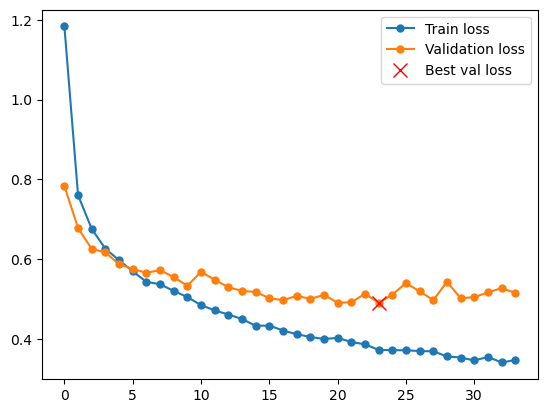

<All keys matched successfully>

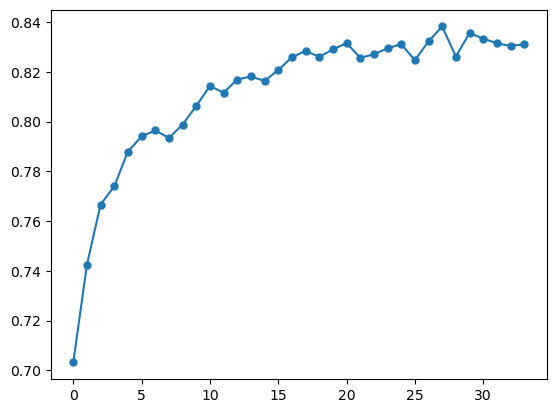

In [225]:
model0838_mm= Model0831().to(device)
optimizer0838_mm = torch.optim.Adam(model0838_mm.parameters())
train_more_epochs_es(35,5,model0838_mm,loss_fn,optimizer0838_mm,training_loader_sc,validation_loader_sc)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model0838_mm.load_state_dict(torch.load(model_path))

K oboum modelům teď zkusím přidat batch normalizaci.

EPOCH 1:


100%|██████████| 985/985 [00:07<00:00, 132.66it/s]


TRAIN loss: 0.988, VALIDATION loss: 1.134, accuraccy: 0.731
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:07<00:00, 123.65it/s]


TRAIN loss: 0.713, VALIDATION loss: 1.737, accuraccy: 0.760
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:07<00:00, 136.27it/s]


TRAIN loss: 0.641, VALIDATION loss: 0.735, accuraccy: 0.771
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:07<00:00, 126.45it/s]


TRAIN loss: 0.588, VALIDATION loss: 1.327, accuraccy: 0.785
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:06<00:00, 141.65it/s]


TRAIN loss: 0.592, VALIDATION loss: 0.763, accuraccy: 0.759
No improvement in this epoch.
EPOCH 6:


100%|██████████| 985/985 [00:08<00:00, 122.47it/s]


TRAIN loss: 0.577, VALIDATION loss: 1.560, accuraccy: 0.796
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:07<00:00, 127.94it/s]


TRAIN loss: 0.542, VALIDATION loss: 1.376, accuraccy: 0.800
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:07<00:00, 134.07it/s]


TRAIN loss: 0.514, VALIDATION loss: 4.476, accuraccy: 0.791
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:07<00:00, 125.27it/s]


TRAIN loss: 0.503, VALIDATION loss: 11.319, accuraccy: 0.797
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:07<00:00, 136.76it/s]


TRAIN loss: 0.482, VALIDATION loss: 0.859, accuraccy: 0.820
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:07<00:00, 125.58it/s]


TRAIN loss: 0.474, VALIDATION loss: 0.608, accuraccy: 0.807
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:07<00:00, 128.63it/s]


TRAIN loss: 0.459, VALIDATION loss: 4.325, accuraccy: 0.825
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:07<00:00, 139.49it/s]


TRAIN loss: 0.443, VALIDATION loss: 0.802, accuraccy: 0.813
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:09<00:00, 105.00it/s]


TRAIN loss: 0.441, VALIDATION loss: 0.914, accuraccy: 0.823
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:06<00:00, 146.47it/s]


TRAIN loss: 0.425, VALIDATION loss: 0.474, accuraccy: 0.830
Saving best model
EPOCH 16:


100%|██████████| 985/985 [00:07<00:00, 132.70it/s]


TRAIN loss: 0.418, VALIDATION loss: 0.901, accuraccy: 0.829
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:07<00:00, 126.18it/s]


TRAIN loss: 0.405, VALIDATION loss: 0.528, accuraccy: 0.829
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:07<00:00, 129.08it/s]


TRAIN loss: 0.400, VALIDATION loss: 0.595, accuraccy: 0.816
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:07<00:00, 138.71it/s]


TRAIN loss: 0.398, VALIDATION loss: 0.519, accuraccy: 0.832
Saving best model
EPOCH 20:


100%|██████████| 985/985 [00:07<00:00, 140.28it/s]


TRAIN loss: 0.384, VALIDATION loss: 0.620, accuraccy: 0.833
Saving best model
EPOCH 21:


100%|██████████| 985/985 [00:08<00:00, 111.90it/s]


TRAIN loss: 0.373, VALIDATION loss: 0.532, accuraccy: 0.835
Saving best model
EPOCH 22:


100%|██████████| 985/985 [00:07<00:00, 129.79it/s]


TRAIN loss: 0.372, VALIDATION loss: 0.474, accuraccy: 0.834
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:07<00:00, 128.89it/s]


TRAIN loss: 0.365, VALIDATION loss: 0.589, accuraccy: 0.833
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:06<00:00, 144.10it/s]


TRAIN loss: 0.359, VALIDATION loss: 0.548, accuraccy: 0.797
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:07<00:00, 134.16it/s]


TRAIN loss: 0.360, VALIDATION loss: 0.488, accuraccy: 0.826
No improvement in this epoch.
EPOCH 26:


100%|██████████| 985/985 [00:06<00:00, 140.96it/s]


TRAIN loss: 0.358, VALIDATION loss: 0.666, accuraccy: 0.832
No improvement in this epoch.
EPOCH 27:


100%|██████████| 985/985 [00:07<00:00, 128.36it/s]


TRAIN loss: 0.333, VALIDATION loss: 0.544, accuraccy: 0.841
Saving best model
EPOCH 28:


100%|██████████| 985/985 [00:07<00:00, 126.59it/s]


TRAIN loss: 0.335, VALIDATION loss: 0.703, accuraccy: 0.837
No improvement in this epoch.
EPOCH 29:


100%|██████████| 985/985 [00:07<00:00, 133.72it/s]


TRAIN loss: 0.329, VALIDATION loss: 0.816, accuraccy: 0.827
No improvement in this epoch.
EPOCH 30:


100%|██████████| 985/985 [00:08<00:00, 123.10it/s]


TRAIN loss: 0.327, VALIDATION loss: 3.237, accuraccy: 0.836
No improvement in this epoch.
EPOCH 31:


100%|██████████| 985/985 [00:08<00:00, 119.43it/s]


TRAIN loss: 0.322, VALIDATION loss: 2.059, accuraccy: 0.837
No improvement in this epoch.
EPOCH 32:


100%|██████████| 985/985 [00:07<00:00, 134.86it/s]


TRAIN loss: 0.317, VALIDATION loss: 0.689, accuraccy: 0.843
Saving best model
EPOCH 33:


100%|██████████| 985/985 [00:08<00:00, 117.98it/s]


TRAIN loss: 0.315, VALIDATION loss: 1.420, accuraccy: 0.843
No improvement in this epoch.
EPOCH 34:


100%|██████████| 985/985 [00:07<00:00, 131.42it/s]


TRAIN loss: 0.312, VALIDATION loss: 0.926, accuraccy: 0.827
No improvement in this epoch.
EPOCH 35:


100%|██████████| 985/985 [00:07<00:00, 123.48it/s]


TRAIN loss: 0.307, VALIDATION loss: 0.509, accuraccy: 0.833
No improvement in this epoch.
EPOCH 36:


100%|██████████| 985/985 [00:08<00:00, 115.87it/s]


TRAIN loss: 0.307, VALIDATION loss: 0.712, accuraccy: 0.839
No improvement in this epoch.
EPOCH 37:


100%|██████████| 985/985 [00:07<00:00, 130.31it/s]


TRAIN loss: 0.296, VALIDATION loss: 0.816, accuraccy: 0.847
Saving best model
EPOCH 38:


100%|██████████| 985/985 [00:09<00:00, 106.82it/s]


TRAIN loss: 0.292, VALIDATION loss: 1.397, accuraccy: 0.840
No improvement in this epoch.
EPOCH 39:


100%|██████████| 985/985 [00:09<00:00, 100.93it/s]


TRAIN loss: 0.299, VALIDATION loss: 0.562, accuraccy: 0.838
No improvement in this epoch.
EPOCH 40:


100%|██████████| 985/985 [00:07<00:00, 129.42it/s]


TRAIN loss: 0.289, VALIDATION loss: 0.865, accuraccy: 0.839
No improvement in this epoch.
EPOCH 41:


100%|██████████| 985/985 [00:07<00:00, 129.51it/s]


TRAIN loss: 0.282, VALIDATION loss: 0.723, accuraccy: 0.842
No improvement in this epoch.
EPOCH 42:


100%|██████████| 985/985 [00:07<00:00, 124.82it/s]


TRAIN loss: 0.284, VALIDATION loss: 1.485, accuraccy: 0.830
No improvement in this epoch.
EPOCH 43:


100%|██████████| 985/985 [00:09<00:00, 108.80it/s]


TRAIN loss: 0.282, VALIDATION loss: 1.128, accuraccy: 0.834
No improvement in this epoch.
Early stopping now


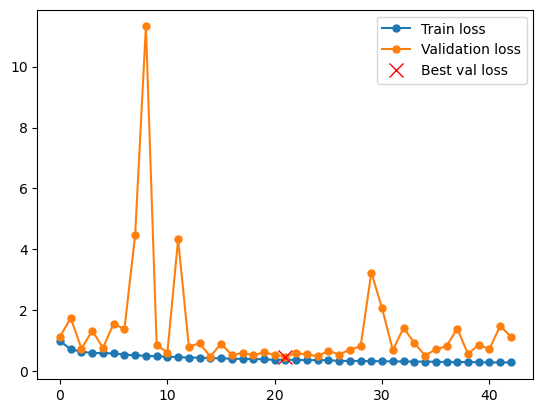

<All keys matched successfully>

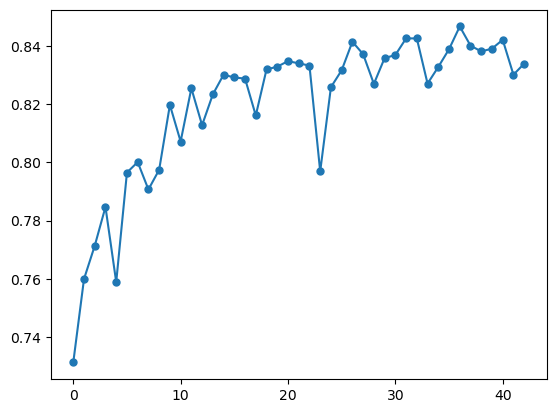

In [226]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Model08381(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 250)
        self.bn1 = nn.BatchNorm1d(250)
        self.fc2 = nn.Linear(250, 150)
        self.bn2 = nn.BatchNorm1d(150)
        self.dropout2 = nn.Dropout(0.10)
        self.fc3 = nn.Linear(150, 100)
        self.bn3 = nn.BatchNorm1d(100)
        self.dropout3 = nn.Dropout(0.10)
        self.fc4 = nn.Linear(100, 60)
        self.fc5 = nn.Linear(60, 40)
        self.fc6 = nn.Linear(40, 30)
        self.fc7 = nn.Linear(30, 30)
        self.fc8 = nn.Linear(30, 20)
        self.fco = nn.Linear(20, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = self.bn2(F.relu(self.fc2(x)))
        x = self.dropout2(x)
        x = self.bn3(F.relu(self.fc3(x)))
        x = self.dropout3(x)
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = self.fco(x)
        return x

model08381= Model08381().to(device)
optimizer08381 = torch.optim.Adam(model08381.parameters())
train_more_epochs_es(50,5,model08381,loss_fn,optimizer08381,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model08381.load_state_dict(torch.load(model_path))

EPOCH 1:


100%|██████████| 985/985 [00:06<00:00, 147.98it/s]


TRAIN loss: 0.976, VALIDATION loss: 0.765, accuraccy: 0.710
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:08<00:00, 121.54it/s]


TRAIN loss: 0.667, VALIDATION loss: 0.605, accuraccy: 0.769
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:07<00:00, 124.17it/s]


TRAIN loss: 0.605, VALIDATION loss: 0.762, accuraccy: 0.769
No improvement in this epoch.
EPOCH 4:


100%|██████████| 985/985 [00:07<00:00, 123.74it/s]


TRAIN loss: 0.555, VALIDATION loss: 0.549, accuraccy: 0.793
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:07<00:00, 136.72it/s]


TRAIN loss: 0.521, VALIDATION loss: 0.562, accuraccy: 0.788
No improvement in this epoch.
EPOCH 6:


100%|██████████| 985/985 [00:07<00:00, 127.34it/s]


TRAIN loss: 0.501, VALIDATION loss: 0.531, accuraccy: 0.807
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:08<00:00, 116.06it/s]


TRAIN loss: 0.478, VALIDATION loss: 0.542, accuraccy: 0.804
No improvement in this epoch.
EPOCH 8:


100%|██████████| 985/985 [00:07<00:00, 132.08it/s]


TRAIN loss: 0.459, VALIDATION loss: 0.520, accuraccy: 0.811
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:07<00:00, 125.39it/s]


TRAIN loss: 0.448, VALIDATION loss: 0.487, accuraccy: 0.821
Saving best model
EPOCH 10:


100%|██████████| 985/985 [00:07<00:00, 138.78it/s]


TRAIN loss: 0.432, VALIDATION loss: 0.473, accuraccy: 0.826
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:08<00:00, 114.30it/s]


TRAIN loss: 0.425, VALIDATION loss: 0.492, accuraccy: 0.816
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:07<00:00, 125.54it/s]


TRAIN loss: 0.409, VALIDATION loss: 0.474, accuraccy: 0.822
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:07<00:00, 137.87it/s]


TRAIN loss: 0.399, VALIDATION loss: 0.492, accuraccy: 0.824
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:07<00:00, 131.86it/s]


TRAIN loss: 0.394, VALIDATION loss: 0.483, accuraccy: 0.822
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:07<00:00, 140.19it/s]


TRAIN loss: 0.377, VALIDATION loss: 0.470, accuraccy: 0.836
Saving best model
EPOCH 16:


100%|██████████| 985/985 [00:07<00:00, 132.07it/s]


TRAIN loss: 0.374, VALIDATION loss: 0.467, accuraccy: 0.832
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:07<00:00, 137.22it/s]


TRAIN loss: 0.365, VALIDATION loss: 0.459, accuraccy: 0.834
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:07<00:00, 138.41it/s]


TRAIN loss: 0.359, VALIDATION loss: 0.558, accuraccy: 0.799
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:08<00:00, 121.61it/s]


TRAIN loss: 0.359, VALIDATION loss: 0.463, accuraccy: 0.836
Saving best model
EPOCH 20:


100%|██████████| 985/985 [00:07<00:00, 140.61it/s]


TRAIN loss: 0.348, VALIDATION loss: 0.477, accuraccy: 0.833
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:07<00:00, 136.04it/s]


TRAIN loss: 0.342, VALIDATION loss: 0.486, accuraccy: 0.831
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:09<00:00, 107.65it/s]


TRAIN loss: 0.343, VALIDATION loss: 0.505, accuraccy: 0.818
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:07<00:00, 129.66it/s]


TRAIN loss: 0.327, VALIDATION loss: 0.495, accuraccy: 0.826
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:07<00:00, 124.01it/s]


TRAIN loss: 0.322, VALIDATION loss: 0.462, accuraccy: 0.839
Saving best model
EPOCH 25:


100%|██████████| 985/985 [00:07<00:00, 126.67it/s]


TRAIN loss: 0.319, VALIDATION loss: 0.487, accuraccy: 0.836
No improvement in this epoch.
EPOCH 26:


100%|██████████| 985/985 [00:08<00:00, 111.12it/s]


TRAIN loss: 0.315, VALIDATION loss: 0.488, accuraccy: 0.836
No improvement in this epoch.
EPOCH 27:


100%|██████████| 985/985 [00:09<00:00, 100.25it/s]


TRAIN loss: 0.312, VALIDATION loss: 0.467, accuraccy: 0.841
Saving best model
EPOCH 28:


100%|██████████| 985/985 [00:09<00:00, 104.14it/s]


TRAIN loss: 0.306, VALIDATION loss: 0.479, accuraccy: 0.828
No improvement in this epoch.
EPOCH 29:


100%|██████████| 985/985 [00:09<00:00, 101.84it/s]


TRAIN loss: 0.298, VALIDATION loss: 0.489, accuraccy: 0.838
No improvement in this epoch.
EPOCH 30:


100%|██████████| 985/985 [00:09<00:00, 104.18it/s]


TRAIN loss: 0.294, VALIDATION loss: 0.486, accuraccy: 0.838
No improvement in this epoch.
EPOCH 31:


100%|██████████| 985/985 [00:07<00:00, 127.43it/s]


TRAIN loss: 0.290, VALIDATION loss: 0.491, accuraccy: 0.836
No improvement in this epoch.
EPOCH 32:


100%|██████████| 985/985 [00:07<00:00, 136.31it/s]


TRAIN loss: 0.287, VALIDATION loss: 0.517, accuraccy: 0.831
No improvement in this epoch.
EPOCH 33:


100%|██████████| 985/985 [00:07<00:00, 136.14it/s]


TRAIN loss: 0.286, VALIDATION loss: 0.461, accuraccy: 0.842
Saving best model
EPOCH 34:


100%|██████████| 985/985 [00:07<00:00, 123.35it/s]


TRAIN loss: 0.282, VALIDATION loss: 0.490, accuraccy: 0.843
Saving best model
EPOCH 35:


100%|██████████| 985/985 [00:07<00:00, 132.59it/s]


TRAIN loss: 0.280, VALIDATION loss: 0.488, accuraccy: 0.843
No improvement in this epoch.
EPOCH 36:


100%|██████████| 985/985 [00:07<00:00, 131.15it/s]


TRAIN loss: 0.274, VALIDATION loss: 0.479, accuraccy: 0.841
No improvement in this epoch.
EPOCH 37:


100%|██████████| 985/985 [00:08<00:00, 119.24it/s]


TRAIN loss: 0.269, VALIDATION loss: 0.501, accuraccy: 0.844
Saving best model
EPOCH 38:


100%|██████████| 985/985 [00:08<00:00, 116.97it/s]


TRAIN loss: 0.268, VALIDATION loss: 0.497, accuraccy: 0.844
Saving best model
EPOCH 39:


100%|██████████| 985/985 [00:08<00:00, 111.97it/s]


TRAIN loss: 0.260, VALIDATION loss: 0.499, accuraccy: 0.843
No improvement in this epoch.
EPOCH 40:


100%|██████████| 985/985 [00:07<00:00, 124.11it/s]


TRAIN loss: 0.263, VALIDATION loss: 0.477, accuraccy: 0.844
No improvement in this epoch.
EPOCH 41:


100%|██████████| 985/985 [00:08<00:00, 118.20it/s]


TRAIN loss: 0.257, VALIDATION loss: 0.504, accuraccy: 0.842
No improvement in this epoch.
EPOCH 42:


100%|██████████| 985/985 [00:08<00:00, 110.37it/s]


TRAIN loss: 0.258, VALIDATION loss: 0.494, accuraccy: 0.836
No improvement in this epoch.
EPOCH 43:


100%|██████████| 985/985 [00:08<00:00, 109.94it/s]


TRAIN loss: 0.255, VALIDATION loss: 0.518, accuraccy: 0.834
No improvement in this epoch.
EPOCH 44:


100%|██████████| 985/985 [00:07<00:00, 133.83it/s]


TRAIN loss: 0.268, VALIDATION loss: 0.487, accuraccy: 0.843
No improvement in this epoch.
EPOCH 45:


100%|██████████| 985/985 [00:07<00:00, 132.20it/s]


TRAIN loss: 0.253, VALIDATION loss: 0.483, accuraccy: 0.845
Saving best model
EPOCH 46:


100%|██████████| 985/985 [00:08<00:00, 117.37it/s]


TRAIN loss: 0.244, VALIDATION loss: 0.500, accuraccy: 0.840
No improvement in this epoch.
EPOCH 47:


100%|██████████| 985/985 [00:07<00:00, 131.87it/s]


TRAIN loss: 0.243, VALIDATION loss: 0.500, accuraccy: 0.841
No improvement in this epoch.
EPOCH 48:


100%|██████████| 985/985 [00:08<00:00, 121.58it/s]


TRAIN loss: 0.239, VALIDATION loss: 0.479, accuraccy: 0.842
No improvement in this epoch.
EPOCH 49:


100%|██████████| 985/985 [00:07<00:00, 131.37it/s]


TRAIN loss: 0.248, VALIDATION loss: 0.503, accuraccy: 0.846
Saving best model
EPOCH 50:


100%|██████████| 985/985 [00:09<00:00, 106.08it/s]


TRAIN loss: 0.236, VALIDATION loss: 0.517, accuraccy: 0.845
No improvement in this epoch.


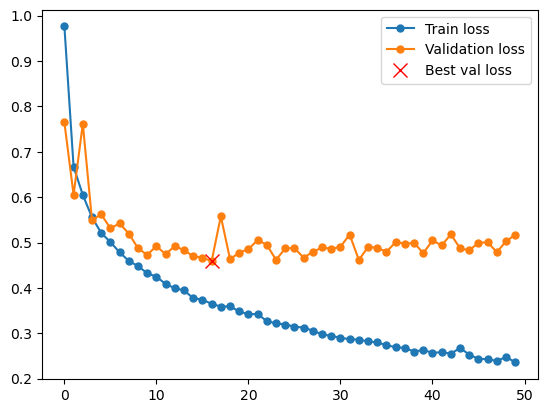

<All keys matched successfully>

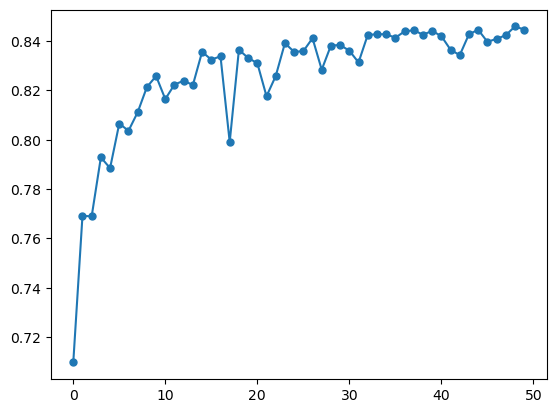

In [229]:
model08381_mm= Model08381().to(device)
optimizer08381_mm = torch.optim.Adam(model08381_mm.parameters())
train_more_epochs_es(50,7,model08381_mm,loss_fn,optimizer08381_mm,training_loader_mm,validation_loader_mm)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model08381_mm.load_state_dict(torch.load(model_path))

EPOCH 1:


100%|██████████| 985/985 [00:07<00:00, 133.69it/s]


TRAIN loss: 0.991, VALIDATION loss: 0.729, accuraccy: 0.708
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:07<00:00, 130.16it/s]


TRAIN loss: 0.667, VALIDATION loss: 0.588, accuraccy: 0.784
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:07<00:00, 123.21it/s]


TRAIN loss: 0.585, VALIDATION loss: 0.563, accuraccy: 0.794
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:07<00:00, 129.73it/s]


TRAIN loss: 0.566, VALIDATION loss: 0.545, accuraccy: 0.802
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:07<00:00, 127.59it/s]


TRAIN loss: 0.523, VALIDATION loss: 0.532, accuraccy: 0.806
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:08<00:00, 121.38it/s]


TRAIN loss: 0.497, VALIDATION loss: 0.535, accuraccy: 0.812
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:08<00:00, 120.68it/s]


TRAIN loss: 0.475, VALIDATION loss: 0.499, accuraccy: 0.819
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:08<00:00, 109.47it/s]


TRAIN loss: 0.454, VALIDATION loss: 0.547, accuraccy: 0.807
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:07<00:00, 126.46it/s]


TRAIN loss: 0.447, VALIDATION loss: 0.496, accuraccy: 0.819
Saving best model
EPOCH 10:


100%|██████████| 985/985 [00:08<00:00, 120.74it/s]


TRAIN loss: 0.429, VALIDATION loss: 0.468, accuraccy: 0.828
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:07<00:00, 134.20it/s]


TRAIN loss: 0.409, VALIDATION loss: 0.487, accuraccy: 0.831
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:07<00:00, 124.84it/s]


TRAIN loss: 0.400, VALIDATION loss: 0.483, accuraccy: 0.830
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:07<00:00, 137.94it/s]


TRAIN loss: 0.390, VALIDATION loss: 0.491, accuraccy: 0.829
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:06<00:00, 142.02it/s]


TRAIN loss: 0.383, VALIDATION loss: 0.486, accuraccy: 0.828
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:08<00:00, 112.57it/s]


TRAIN loss: 0.367, VALIDATION loss: 0.475, accuraccy: 0.834
Saving best model
EPOCH 16:


100%|██████████| 985/985 [00:07<00:00, 127.11it/s]


TRAIN loss: 0.357, VALIDATION loss: 0.492, accuraccy: 0.830
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:07<00:00, 126.36it/s]


TRAIN loss: 0.354, VALIDATION loss: 0.473, accuraccy: 0.836
Saving best model
EPOCH 18:


100%|██████████| 985/985 [00:07<00:00, 134.66it/s]


TRAIN loss: 0.340, VALIDATION loss: 0.501, accuraccy: 0.829
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:08<00:00, 119.16it/s]


TRAIN loss: 0.336, VALIDATION loss: 0.622, accuraccy: 0.837
Saving best model
EPOCH 20:


100%|██████████| 985/985 [00:07<00:00, 135.99it/s]


TRAIN loss: 0.330, VALIDATION loss: 0.535, accuraccy: 0.841
Saving best model
EPOCH 21:


100%|██████████| 985/985 [00:07<00:00, 137.75it/s]


TRAIN loss: 0.315, VALIDATION loss: 0.477, accuraccy: 0.837
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:07<00:00, 132.58it/s]


TRAIN loss: 0.308, VALIDATION loss: 0.492, accuraccy: 0.838
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:06<00:00, 146.63it/s]


TRAIN loss: 0.302, VALIDATION loss: 0.508, accuraccy: 0.839
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:06<00:00, 144.15it/s]


TRAIN loss: 0.295, VALIDATION loss: 0.470, accuraccy: 0.839
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:07<00:00, 125.80it/s]


TRAIN loss: 0.291, VALIDATION loss: 0.479, accuraccy: 0.837
No improvement in this epoch.
EPOCH 26:


100%|██████████| 985/985 [00:07<00:00, 131.94it/s]


TRAIN loss: 0.282, VALIDATION loss: 0.521, accuraccy: 0.838
No improvement in this epoch.
EPOCH 27:


100%|██████████| 985/985 [00:08<00:00, 123.04it/s]


TRAIN loss: 0.282, VALIDATION loss: 0.490, accuraccy: 0.836
No improvement in this epoch.
EPOCH 28:


100%|██████████| 985/985 [00:07<00:00, 135.61it/s]


TRAIN loss: 0.277, VALIDATION loss: 0.480, accuraccy: 0.843
Saving best model
EPOCH 29:


100%|██████████| 985/985 [00:07<00:00, 130.27it/s]


TRAIN loss: 0.264, VALIDATION loss: 0.513, accuraccy: 0.836
No improvement in this epoch.
EPOCH 30:


100%|██████████| 985/985 [00:07<00:00, 128.10it/s]


TRAIN loss: 0.262, VALIDATION loss: 0.495, accuraccy: 0.843
Saving best model
EPOCH 31:


100%|██████████| 985/985 [00:07<00:00, 135.39it/s]


TRAIN loss: 0.257, VALIDATION loss: 0.523, accuraccy: 0.840
No improvement in this epoch.
EPOCH 32:


100%|██████████| 985/985 [00:07<00:00, 139.64it/s]


TRAIN loss: 0.249, VALIDATION loss: 0.529, accuraccy: 0.839
No improvement in this epoch.
EPOCH 33:


100%|██████████| 985/985 [00:08<00:00, 122.16it/s]


TRAIN loss: 0.250, VALIDATION loss: 0.503, accuraccy: 0.842
No improvement in this epoch.
EPOCH 34:


100%|██████████| 985/985 [00:07<00:00, 133.28it/s]


TRAIN loss: 0.248, VALIDATION loss: 0.545, accuraccy: 0.842
No improvement in this epoch.
EPOCH 35:


100%|██████████| 985/985 [00:07<00:00, 125.89it/s]


TRAIN loss: 0.262, VALIDATION loss: 0.538, accuraccy: 0.839
No improvement in this epoch.
EPOCH 36:


100%|██████████| 985/985 [00:07<00:00, 131.12it/s]


TRAIN loss: 0.242, VALIDATION loss: 0.594, accuraccy: 0.839
No improvement in this epoch.
EPOCH 37:


100%|██████████| 985/985 [00:08<00:00, 109.91it/s]


TRAIN loss: 0.229, VALIDATION loss: 0.562, accuraccy: 0.844
Saving best model
EPOCH 38:


100%|██████████| 985/985 [00:07<00:00, 136.58it/s]


TRAIN loss: 0.230, VALIDATION loss: 0.515, accuraccy: 0.835
No improvement in this epoch.
EPOCH 39:


100%|██████████| 985/985 [00:07<00:00, 127.19it/s]


TRAIN loss: 0.222, VALIDATION loss: 0.512, accuraccy: 0.835
No improvement in this epoch.
EPOCH 40:


100%|██████████| 985/985 [00:07<00:00, 125.18it/s]


TRAIN loss: 0.219, VALIDATION loss: 0.741, accuraccy: 0.839
No improvement in this epoch.
EPOCH 41:


100%|██████████| 985/985 [00:07<00:00, 126.33it/s]


TRAIN loss: 0.218, VALIDATION loss: 0.579, accuraccy: 0.820
No improvement in this epoch.
EPOCH 42:


100%|██████████| 985/985 [00:07<00:00, 126.01it/s]


TRAIN loss: 0.221, VALIDATION loss: 0.544, accuraccy: 0.840
No improvement in this epoch.
EPOCH 43:


100%|██████████| 985/985 [00:07<00:00, 136.10it/s]


TRAIN loss: 0.209, VALIDATION loss: 0.527, accuraccy: 0.833
No improvement in this epoch.
EPOCH 44:


100%|██████████| 985/985 [00:08<00:00, 122.15it/s]


TRAIN loss: 0.208, VALIDATION loss: 0.573, accuraccy: 0.843
No improvement in this epoch.
EPOCH 45:


100%|██████████| 985/985 [00:07<00:00, 127.05it/s]


TRAIN loss: 0.206, VALIDATION loss: 0.558, accuraccy: 0.840
No improvement in this epoch.
Early stopping now


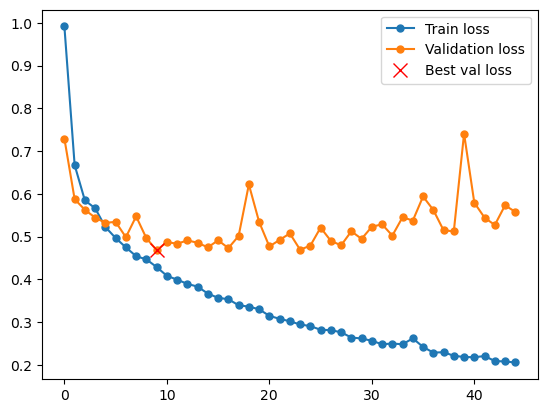

<All keys matched successfully>

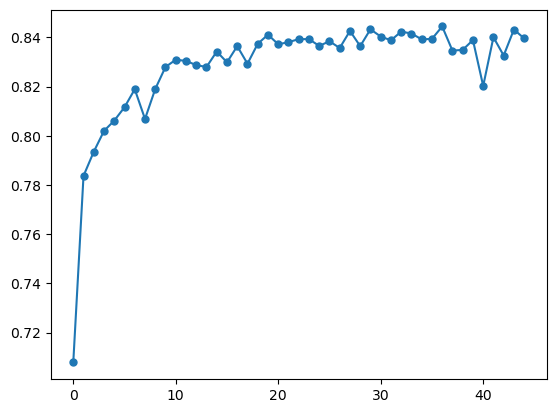

In [235]:
model08381_sc= Model08381().to(device)
optimizer08381_sc = torch.optim.Adam(model08381_sc.parameters())
train_more_epochs_es(50,7,model08381_sc,loss_fn,optimizer08381_sc,training_loader_sc,validation_loader_sc)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model08381_sc.load_state_dict(torch.load(model_path))

EPOCH 1:


100%|██████████| 985/985 [00:10<00:00, 94.25it/s] 


TRAIN loss: 1.118, VALIDATION loss: 1.072, accuraccy: 0.728
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:10<00:00, 92.57it/s] 


TRAIN loss: 0.817, VALIDATION loss: 0.934, accuraccy: 0.746
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:11<00:00, 87.90it/s]


TRAIN loss: 0.762, VALIDATION loss: 1.142, accuraccy: 0.768
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:10<00:00, 91.10it/s] 


TRAIN loss: 0.735, VALIDATION loss: 1.305, accuraccy: 0.777
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:09<00:00, 103.72it/s]


TRAIN loss: 0.694, VALIDATION loss: 2.700, accuraccy: 0.787
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:09<00:00, 101.95it/s]


TRAIN loss: 0.670, VALIDATION loss: 1.810, accuraccy: 0.792
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:11<00:00, 86.15it/s]


TRAIN loss: 0.643, VALIDATION loss: 1.414, accuraccy: 0.794
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:12<00:00, 79.22it/s]


TRAIN loss: 0.626, VALIDATION loss: 0.766, accuraccy: 0.800
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:12<00:00, 80.75it/s]


TRAIN loss: 0.609, VALIDATION loss: 1.122, accuraccy: 0.802
Saving best model
EPOCH 10:


100%|██████████| 985/985 [00:10<00:00, 95.80it/s] 


TRAIN loss: 0.586, VALIDATION loss: 1.812, accuraccy: 0.808
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:10<00:00, 98.05it/s] 


TRAIN loss: 0.580, VALIDATION loss: 1.556, accuraccy: 0.810
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:10<00:00, 92.59it/s] 


TRAIN loss: 0.574, VALIDATION loss: 1.151, accuraccy: 0.804
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:09<00:00, 101.04it/s]


TRAIN loss: 0.558, VALIDATION loss: 1.345, accuraccy: 0.810
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:10<00:00, 90.65it/s] 


TRAIN loss: 0.553, VALIDATION loss: 1.059, accuraccy: 0.813
Saving best model
EPOCH 15:


100%|██████████| 985/985 [00:10<00:00, 94.21it/s] 


TRAIN loss: 0.547, VALIDATION loss: 2.361, accuraccy: 0.821
Saving best model
EPOCH 16:


100%|██████████| 985/985 [00:10<00:00, 97.23it/s] 


TRAIN loss: 0.540, VALIDATION loss: 3.259, accuraccy: 0.818
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:09<00:00, 105.32it/s]


TRAIN loss: 0.528, VALIDATION loss: 2.270, accuraccy: 0.818
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:10<00:00, 90.98it/s] 


TRAIN loss: 0.522, VALIDATION loss: 1.947, accuraccy: 0.825
Saving best model
EPOCH 19:


100%|██████████| 985/985 [00:11<00:00, 86.92it/s]


TRAIN loss: 0.511, VALIDATION loss: 1.388, accuraccy: 0.824
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:12<00:00, 78.67it/s]


TRAIN loss: 0.506, VALIDATION loss: 1.891, accuraccy: 0.816
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:11<00:00, 87.30it/s]


TRAIN loss: 0.501, VALIDATION loss: 2.127, accuraccy: 0.825
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:13<00:00, 72.87it/s]


TRAIN loss: 0.499, VALIDATION loss: 3.040, accuraccy: 0.813
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:11<00:00, 84.46it/s]


TRAIN loss: 0.499, VALIDATION loss: 2.441, accuraccy: 0.832
Saving best model
EPOCH 24:


100%|██████████| 985/985 [00:11<00:00, 83.64it/s]


TRAIN loss: 0.488, VALIDATION loss: 2.827, accuraccy: 0.832
Saving best model
EPOCH 25:


100%|██████████| 985/985 [00:13<00:00, 71.49it/s]


TRAIN loss: 0.481, VALIDATION loss: 1.352, accuraccy: 0.831
No improvement in this epoch.
EPOCH 26:


100%|██████████| 985/985 [00:11<00:00, 83.72it/s]


TRAIN loss: 0.474, VALIDATION loss: 0.858, accuraccy: 0.835
Saving best model
EPOCH 27:


100%|██████████| 985/985 [00:11<00:00, 83.39it/s]


TRAIN loss: 0.477, VALIDATION loss: 2.430, accuraccy: 0.834
No improvement in this epoch.
EPOCH 28:


100%|██████████| 985/985 [00:11<00:00, 87.21it/s]


TRAIN loss: 0.465, VALIDATION loss: 1.447, accuraccy: 0.830
No improvement in this epoch.
EPOCH 29:


100%|██████████| 985/985 [00:11<00:00, 83.38it/s]


TRAIN loss: 0.466, VALIDATION loss: 1.216, accuraccy: 0.829
No improvement in this epoch.
EPOCH 30:


100%|██████████| 985/985 [00:13<00:00, 72.26it/s]


TRAIN loss: 0.458, VALIDATION loss: 2.664, accuraccy: 0.832
No improvement in this epoch.
EPOCH 31:


100%|██████████| 985/985 [00:11<00:00, 86.23it/s]


TRAIN loss: 0.462, VALIDATION loss: 2.356, accuraccy: 0.835
Saving best model
EPOCH 32:


100%|██████████| 985/985 [00:12<00:00, 82.01it/s]


TRAIN loss: 0.448, VALIDATION loss: 2.153, accuraccy: 0.835
No improvement in this epoch.
EPOCH 33:


100%|██████████| 985/985 [00:11<00:00, 86.91it/s]


TRAIN loss: 0.458, VALIDATION loss: 1.423, accuraccy: 0.831
No improvement in this epoch.
EPOCH 34:


100%|██████████| 985/985 [00:11<00:00, 83.80it/s]


TRAIN loss: 0.445, VALIDATION loss: 2.290, accuraccy: 0.832
No improvement in this epoch.
EPOCH 35:


100%|██████████| 985/985 [00:13<00:00, 75.12it/s]


TRAIN loss: 0.448, VALIDATION loss: 4.212, accuraccy: 0.833
No improvement in this epoch.
EPOCH 36:


100%|██████████| 985/985 [00:12<00:00, 80.98it/s]


TRAIN loss: 0.447, VALIDATION loss: 1.065, accuraccy: 0.836
Saving best model
EPOCH 37:


100%|██████████| 985/985 [00:11<00:00, 84.78it/s]


TRAIN loss: 0.432, VALIDATION loss: 0.998, accuraccy: 0.840
Saving best model
EPOCH 38:


100%|██████████| 985/985 [00:12<00:00, 81.53it/s]


TRAIN loss: 0.431, VALIDATION loss: 1.239, accuraccy: 0.841
Saving best model
EPOCH 39:


100%|██████████| 985/985 [00:12<00:00, 77.51it/s]


TRAIN loss: 0.435, VALIDATION loss: 1.524, accuraccy: 0.836
No improvement in this epoch.
EPOCH 40:


100%|██████████| 985/985 [00:11<00:00, 87.48it/s]


TRAIN loss: 0.426, VALIDATION loss: 1.504, accuraccy: 0.832
No improvement in this epoch.
EPOCH 41:


100%|██████████| 985/985 [00:11<00:00, 83.48it/s]


TRAIN loss: 0.424, VALIDATION loss: 2.721, accuraccy: 0.841
Saving best model
EPOCH 42:


100%|██████████| 985/985 [00:09<00:00, 98.58it/s] 


TRAIN loss: 0.416, VALIDATION loss: 1.938, accuraccy: 0.832
No improvement in this epoch.
EPOCH 43:


100%|██████████| 985/985 [00:09<00:00, 103.15it/s]


TRAIN loss: 0.418, VALIDATION loss: 2.693, accuraccy: 0.845
Saving best model
EPOCH 44:


100%|██████████| 985/985 [00:09<00:00, 99.10it/s] 


TRAIN loss: 0.415, VALIDATION loss: 2.787, accuraccy: 0.844
No improvement in this epoch.
EPOCH 45:


100%|██████████| 985/985 [00:09<00:00, 99.49it/s] 


TRAIN loss: 0.412, VALIDATION loss: 2.806, accuraccy: 0.841
No improvement in this epoch.
EPOCH 46:


100%|██████████| 985/985 [00:09<00:00, 103.88it/s]


TRAIN loss: 0.412, VALIDATION loss: 1.836, accuraccy: 0.834
No improvement in this epoch.
EPOCH 47:


100%|██████████| 985/985 [00:10<00:00, 98.33it/s] 


TRAIN loss: 0.415, VALIDATION loss: 2.040, accuraccy: 0.838
No improvement in this epoch.
EPOCH 48:


100%|██████████| 985/985 [00:09<00:00, 104.33it/s]


TRAIN loss: 0.410, VALIDATION loss: 1.624, accuraccy: 0.842
No improvement in this epoch.
EPOCH 49:


100%|██████████| 985/985 [00:09<00:00, 101.75it/s]


TRAIN loss: 0.406, VALIDATION loss: 2.100, accuraccy: 0.840
No improvement in this epoch.
EPOCH 50:


100%|██████████| 985/985 [00:09<00:00, 102.69it/s]


TRAIN loss: 0.401, VALIDATION loss: 1.635, accuraccy: 0.836
No improvement in this epoch.
Early stopping now


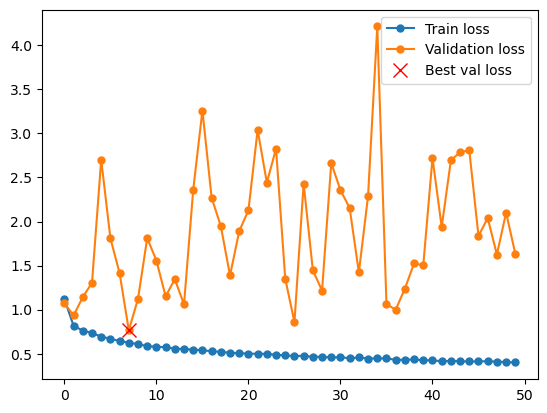

<All keys matched successfully>

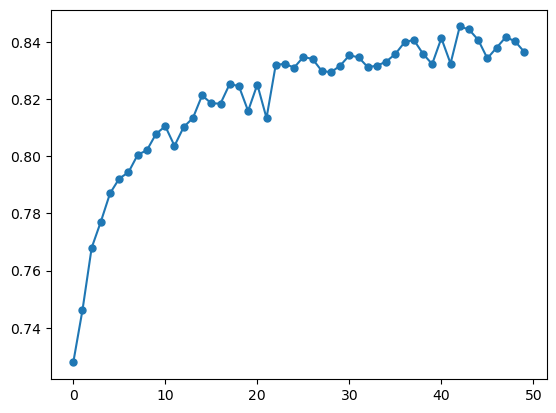

In [237]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Model08311(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 250)
        self.bn1 = nn.BatchNorm1d(250)
        self.dropout1 = nn.Dropout(0.10)
        self.fc2 = nn.Linear(250, 150)
        self.bn2 = nn.BatchNorm1d(150)
        self.dropout2 = nn.Dropout(0.10)
        self.fc3 = nn.Linear(150, 100)
        self.bn3 = nn.BatchNorm1d(100)
        self.dropout3 = nn.Dropout(0.10)
        self.fc4 = nn.Linear(100, 60)
        self.bn4 = nn.BatchNorm1d(60)
        self.dropout4 = nn.Dropout(0.10)
        self.fc5 = nn.Linear(60, 40)
        self.bn5 = nn.BatchNorm1d(40)
        self.dropout5 = nn.Dropout(0.10)
        self.fc6 = nn.Linear(40, 30)
        self.bn6 = nn.BatchNorm1d(30)
        self.dropout6 = nn.Dropout(0.10)
        self.fc7 = nn.Linear(30, 30)
        self.bn7 = nn.BatchNorm1d(30)
        self.dropout7 = nn.Dropout(0.10)
        self.fc8 = nn.Linear(30, 20)
        self.bn8 = nn.BatchNorm1d(20)
        self.dropout8 = nn.Dropout(0.10)
        self.fco = nn.Linear(20, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.dropout1(x)
        x = self.bn2(F.relu(self.fc2(x)))
        x = self.dropout2(x)
        x = self.bn3(F.relu(self.fc3(x)))
        x = self.dropout3(x)
        x = self.bn4(F.relu(self.fc4(x)))
        x = self.dropout4(x)
        x = self.bn5(F.relu(self.fc5(x)))
        x = self.dropout5(x)
        x = self.bn6(F.relu(self.fc6(x)))
        x = self.dropout6(x)
        x = self.bn7(F.relu(self.fc7(x)))
        x = self.dropout7(x)
        x = self.bn8(F.relu(self.fc8(x)))
        x = self.fco(x)
        return x

model08311= Model08311().to(device)
optimizer08311 = torch.optim.Adam(model08311.parameters())
train_more_epochs_es(50,6,model08311,loss_fn,optimizer08311,training_loader,validation_loader)
#del model0838
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model08311.load_state_dict(torch.load(model_path))

EPOCH 1:


100%|██████████| 985/985 [00:06<00:00, 145.47it/s]


TRAIN loss: 0.954, VALIDATION loss: 0.681, accuraccy: 0.744
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:07<00:00, 129.69it/s]


TRAIN loss: 0.664, VALIDATION loss: 0.615, accuraccy: 0.774
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:07<00:00, 133.65it/s]


TRAIN loss: 0.600, VALIDATION loss: 0.583, accuraccy: 0.783
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:07<00:00, 133.39it/s]


TRAIN loss: 0.565, VALIDATION loss: 0.542, accuraccy: 0.802
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:06<00:00, 142.36it/s]


TRAIN loss: 0.529, VALIDATION loss: 0.539, accuraccy: 0.808
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:07<00:00, 138.80it/s]


TRAIN loss: 0.507, VALIDATION loss: 0.684, accuraccy: 0.745
No improvement in this epoch.
EPOCH 7:


100%|██████████| 985/985 [00:08<00:00, 119.05it/s]


TRAIN loss: 0.491, VALIDATION loss: 0.504, accuraccy: 0.818
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:08<00:00, 121.94it/s]


TRAIN loss: 0.465, VALIDATION loss: 0.504, accuraccy: 0.819
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:08<00:00, 121.49it/s]


TRAIN loss: 0.451, VALIDATION loss: 0.485, accuraccy: 0.823
Saving best model
EPOCH 10:


100%|██████████| 985/985 [00:07<00:00, 128.15it/s]


TRAIN loss: 0.439, VALIDATION loss: 0.473, accuraccy: 0.831
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:07<00:00, 131.70it/s]


TRAIN loss: 0.425, VALIDATION loss: 0.504, accuraccy: 0.820
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:07<00:00, 126.26it/s]


TRAIN loss: 0.413, VALIDATION loss: 0.488, accuraccy: 0.823
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:07<00:00, 132.65it/s]


TRAIN loss: 0.409, VALIDATION loss: 0.479, accuraccy: 0.825
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:07<00:00, 133.60it/s]


TRAIN loss: 0.398, VALIDATION loss: 0.472, accuraccy: 0.827
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:08<00:00, 123.09it/s]


TRAIN loss: 0.389, VALIDATION loss: 0.474, accuraccy: 0.827
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:08<00:00, 117.44it/s]


TRAIN loss: 0.383, VALIDATION loss: 0.472, accuraccy: 0.829
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:07<00:00, 131.83it/s]


TRAIN loss: 0.373, VALIDATION loss: 0.460, accuraccy: 0.836
Saving best model
EPOCH 18:


100%|██████████| 985/985 [00:08<00:00, 115.96it/s]


TRAIN loss: 0.364, VALIDATION loss: 0.482, accuraccy: 0.826
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:07<00:00, 129.65it/s]


TRAIN loss: 0.361, VALIDATION loss: 0.471, accuraccy: 0.836
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:07<00:00, 133.91it/s]


TRAIN loss: 0.353, VALIDATION loss: 0.459, accuraccy: 0.836
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:07<00:00, 140.64it/s]


TRAIN loss: 0.348, VALIDATION loss: 0.482, accuraccy: 0.837
Saving best model
EPOCH 22:


100%|██████████| 985/985 [00:07<00:00, 129.10it/s]


TRAIN loss: 0.346, VALIDATION loss: 0.480, accuraccy: 0.837
Saving best model
EPOCH 23:


100%|██████████| 985/985 [00:09<00:00, 107.99it/s]


TRAIN loss: 0.339, VALIDATION loss: 0.477, accuraccy: 0.837
Saving best model
EPOCH 24:


100%|██████████| 985/985 [00:07<00:00, 133.99it/s]


TRAIN loss: 0.335, VALIDATION loss: 0.458, accuraccy: 0.837
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:07<00:00, 132.51it/s]


TRAIN loss: 0.325, VALIDATION loss: 0.479, accuraccy: 0.841
Saving best model
EPOCH 26:


100%|██████████| 985/985 [00:07<00:00, 138.82it/s]


TRAIN loss: 0.322, VALIDATION loss: 0.465, accuraccy: 0.839
No improvement in this epoch.
EPOCH 27:


100%|██████████| 985/985 [00:07<00:00, 126.02it/s]


TRAIN loss: 0.316, VALIDATION loss: 0.478, accuraccy: 0.838
No improvement in this epoch.
EPOCH 28:


100%|██████████| 985/985 [00:07<00:00, 131.83it/s]


TRAIN loss: 0.309, VALIDATION loss: 0.501, accuraccy: 0.830
No improvement in this epoch.
EPOCH 29:


100%|██████████| 985/985 [00:07<00:00, 126.65it/s]


TRAIN loss: 0.310, VALIDATION loss: 0.484, accuraccy: 0.839
No improvement in this epoch.
EPOCH 30:


100%|██████████| 985/985 [00:07<00:00, 130.31it/s]


TRAIN loss: 0.303, VALIDATION loss: 0.471, accuraccy: 0.838
No improvement in this epoch.
EPOCH 31:


100%|██████████| 985/985 [00:07<00:00, 131.41it/s]


TRAIN loss: 0.299, VALIDATION loss: 0.470, accuraccy: 0.838
No improvement in this epoch.
EPOCH 32:


100%|██████████| 985/985 [00:08<00:00, 112.08it/s]


TRAIN loss: 0.296, VALIDATION loss: 0.484, accuraccy: 0.834
No improvement in this epoch.
EPOCH 33:


100%|██████████| 985/985 [00:07<00:00, 129.86it/s]


TRAIN loss: 0.289, VALIDATION loss: 0.482, accuraccy: 0.838
No improvement in this epoch.
Early stopping now


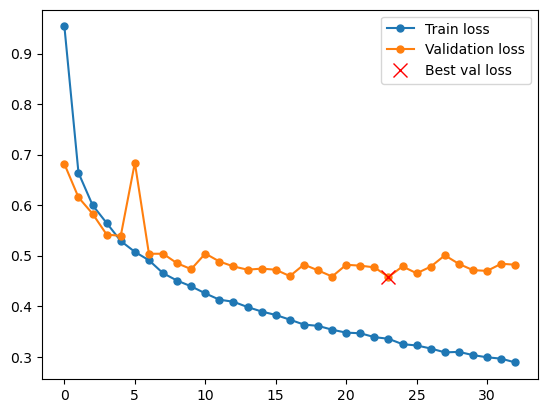

<All keys matched successfully>

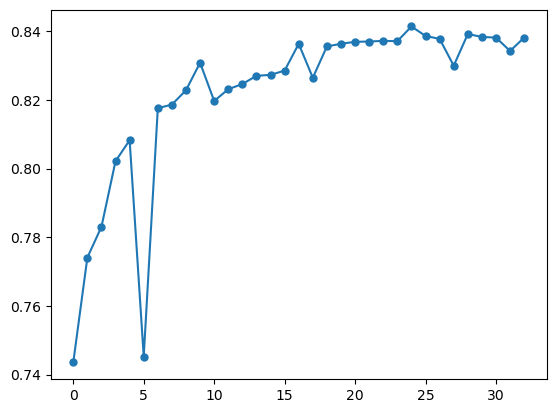

In [239]:
model08311_mm= Model08381().to(device)
optimizer08311_mm = torch.optim.Adam(model08311_mm.parameters())
train_more_epochs_es(50,7,model08311_mm,loss_fn,optimizer08311_mm,training_loader_mm,validation_loader_mm)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model08311_mm.load_state_dict(torch.load(model_path))

EPOCH 1:


100%|██████████| 985/985 [00:06<00:00, 158.86it/s]


TRAIN loss: 1.013, VALIDATION loss: 0.700, accuraccy: 0.742
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:08<00:00, 118.30it/s]


TRAIN loss: 0.666, VALIDATION loss: 0.601, accuraccy: 0.773
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:11<00:00, 87.95it/s] 


TRAIN loss: 0.598, VALIDATION loss: 0.579, accuraccy: 0.791
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:12<00:00, 76.39it/s] 


TRAIN loss: 0.557, VALIDATION loss: 0.536, accuraccy: 0.804
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:06<00:00, 144.10it/s]


TRAIN loss: 0.524, VALIDATION loss: 0.572, accuraccy: 0.792
No improvement in this epoch.
EPOCH 6:


100%|██████████| 985/985 [00:08<00:00, 122.70it/s]


TRAIN loss: 0.495, VALIDATION loss: 0.524, accuraccy: 0.808
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:12<00:00, 81.21it/s] 


TRAIN loss: 0.478, VALIDATION loss: 0.512, accuraccy: 0.813
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:12<00:00, 80.59it/s] 


TRAIN loss: 0.457, VALIDATION loss: 0.524, accuraccy: 0.810
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:11<00:00, 88.36it/s] 


TRAIN loss: 0.452, VALIDATION loss: 0.535, accuraccy: 0.808
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:11<00:00, 83.04it/s] 


TRAIN loss: 0.436, VALIDATION loss: 0.496, accuraccy: 0.821
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:08<00:00, 117.68it/s]


TRAIN loss: 0.412, VALIDATION loss: 0.576, accuraccy: 0.812
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:07<00:00, 124.94it/s]


TRAIN loss: 0.403, VALIDATION loss: 0.482, accuraccy: 0.824
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:10<00:00, 98.09it/s] 


TRAIN loss: 0.388, VALIDATION loss: 0.620, accuraccy: 0.827
Saving best model
EPOCH 14:


100%|██████████| 985/985 [00:08<00:00, 114.03it/s]


TRAIN loss: 0.377, VALIDATION loss: 0.872, accuraccy: 0.828
Saving best model
EPOCH 15:


100%|██████████| 985/985 [00:08<00:00, 120.72it/s]


TRAIN loss: 0.369, VALIDATION loss: 0.475, accuraccy: 0.828
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:08<00:00, 110.83it/s]


TRAIN loss: 0.361, VALIDATION loss: 0.476, accuraccy: 0.836
Saving best model
EPOCH 17:


100%|██████████| 985/985 [00:07<00:00, 125.30it/s]


TRAIN loss: 0.352, VALIDATION loss: 0.488, accuraccy: 0.820
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:08<00:00, 122.06it/s]


TRAIN loss: 0.339, VALIDATION loss: 0.459, accuraccy: 0.835
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:08<00:00, 117.46it/s]


TRAIN loss: 0.335, VALIDATION loss: 0.504, accuraccy: 0.825
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:09<00:00, 109.00it/s]


TRAIN loss: 0.322, VALIDATION loss: 0.480, accuraccy: 0.834
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:08<00:00, 119.84it/s]


TRAIN loss: 0.321, VALIDATION loss: 0.468, accuraccy: 0.838
Saving best model
EPOCH 22:


100%|██████████| 985/985 [00:08<00:00, 122.10it/s]


TRAIN loss: 0.309, VALIDATION loss: 0.483, accuraccy: 0.836
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:08<00:00, 115.78it/s]


TRAIN loss: 0.304, VALIDATION loss: 0.478, accuraccy: 0.832
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:08<00:00, 113.01it/s]


TRAIN loss: 0.296, VALIDATION loss: 0.478, accuraccy: 0.838
Saving best model
EPOCH 25:


100%|██████████| 985/985 [00:08<00:00, 117.12it/s]


TRAIN loss: 0.291, VALIDATION loss: 0.481, accuraccy: 0.837
No improvement in this epoch.
EPOCH 26:


100%|██████████| 985/985 [00:08<00:00, 117.23it/s]


TRAIN loss: 0.287, VALIDATION loss: 0.484, accuraccy: 0.839
Saving best model
EPOCH 27:


100%|██████████| 985/985 [00:09<00:00, 102.76it/s]


TRAIN loss: 0.301, VALIDATION loss: 0.470, accuraccy: 0.842
Saving best model
EPOCH 28:


100%|██████████| 985/985 [00:09<00:00, 102.76it/s]


TRAIN loss: 0.276, VALIDATION loss: 0.490, accuraccy: 0.839
No improvement in this epoch.
EPOCH 29:


100%|██████████| 985/985 [00:09<00:00, 105.81it/s]


TRAIN loss: 0.272, VALIDATION loss: 0.505, accuraccy: 0.840
No improvement in this epoch.
EPOCH 30:


100%|██████████| 985/985 [00:09<00:00, 107.13it/s]


TRAIN loss: 0.265, VALIDATION loss: 0.530, accuraccy: 0.832
No improvement in this epoch.
EPOCH 31:


100%|██████████| 985/985 [00:08<00:00, 118.51it/s]


TRAIN loss: 0.264, VALIDATION loss: 0.497, accuraccy: 0.836
No improvement in this epoch.
EPOCH 32:


100%|██████████| 985/985 [00:08<00:00, 113.41it/s]


TRAIN loss: 0.257, VALIDATION loss: 0.486, accuraccy: 0.843
Saving best model
EPOCH 33:


100%|██████████| 985/985 [00:09<00:00, 103.69it/s]


TRAIN loss: 0.251, VALIDATION loss: 0.521, accuraccy: 0.834
No improvement in this epoch.
EPOCH 34:


100%|██████████| 985/985 [00:07<00:00, 123.99it/s]


TRAIN loss: 0.244, VALIDATION loss: 0.552, accuraccy: 0.833
No improvement in this epoch.
EPOCH 35:


100%|██████████| 985/985 [00:08<00:00, 121.14it/s]


TRAIN loss: 0.245, VALIDATION loss: 0.528, accuraccy: 0.837
No improvement in this epoch.
EPOCH 36:


100%|██████████| 985/985 [00:07<00:00, 124.58it/s]


TRAIN loss: 0.243, VALIDATION loss: 0.515, accuraccy: 0.839
No improvement in this epoch.
EPOCH 37:


100%|██████████| 985/985 [00:08<00:00, 122.57it/s]


TRAIN loss: 0.235, VALIDATION loss: 0.524, accuraccy: 0.840
No improvement in this epoch.
EPOCH 38:


100%|██████████| 985/985 [00:09<00:00, 107.47it/s]


TRAIN loss: 0.228, VALIDATION loss: 0.534, accuraccy: 0.836
No improvement in this epoch.
EPOCH 39:


100%|██████████| 985/985 [00:08<00:00, 121.98it/s]


TRAIN loss: 0.226, VALIDATION loss: 0.548, accuraccy: 0.839
No improvement in this epoch.
EPOCH 40:


100%|██████████| 985/985 [00:09<00:00, 106.00it/s]


TRAIN loss: 0.223, VALIDATION loss: 0.541, accuraccy: 0.844
Saving best model
EPOCH 41:


100%|██████████| 985/985 [00:08<00:00, 114.66it/s]


TRAIN loss: 0.215, VALIDATION loss: 0.557, accuraccy: 0.843
No improvement in this epoch.
EPOCH 42:


100%|██████████| 985/985 [00:08<00:00, 119.91it/s]


TRAIN loss: 0.215, VALIDATION loss: 0.542, accuraccy: 0.842
No improvement in this epoch.
EPOCH 43:


100%|██████████| 985/985 [00:08<00:00, 114.64it/s]


TRAIN loss: 0.212, VALIDATION loss: 0.509, accuraccy: 0.840
No improvement in this epoch.
EPOCH 44:


100%|██████████| 985/985 [00:09<00:00, 101.06it/s]


TRAIN loss: 0.206, VALIDATION loss: 0.572, accuraccy: 0.836
No improvement in this epoch.
EPOCH 45:


100%|██████████| 985/985 [00:08<00:00, 115.33it/s]


TRAIN loss: 0.206, VALIDATION loss: 0.538, accuraccy: 0.839
No improvement in this epoch.
EPOCH 46:


100%|██████████| 985/985 [00:08<00:00, 111.30it/s]


TRAIN loss: 0.201, VALIDATION loss: 0.550, accuraccy: 0.840
No improvement in this epoch.
EPOCH 47:


100%|██████████| 985/985 [00:08<00:00, 120.12it/s]


TRAIN loss: 0.208, VALIDATION loss: 0.527, accuraccy: 0.840
No improvement in this epoch.
EPOCH 48:


100%|██████████| 985/985 [00:07<00:00, 124.08it/s]


TRAIN loss: 0.199, VALIDATION loss: 0.531, accuraccy: 0.843
No improvement in this epoch.
Early stopping now


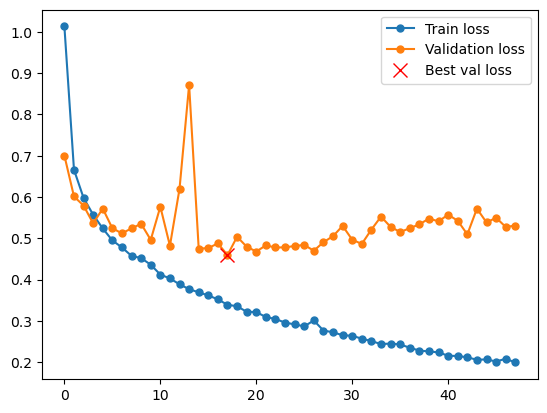

<All keys matched successfully>

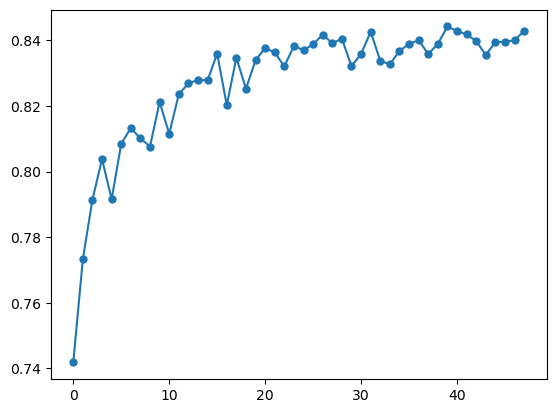

In [240]:
model08311_sc= Model08381().to(device)
optimizer08311_sc = torch.optim.Adam(model08311_sc.parameters())
train_more_epochs_es(50,7,model08311_sc,loss_fn,optimizer08311_sc,training_loader_sc,validation_loader_sc)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model08311_sc.load_state_dict(torch.load(model_path))

EPOCH 1:


100%|██████████| 985/985 [00:06<00:00, 149.76it/s]


TRAIN loss: 1.090, VALIDATION loss: 0.972, accuraccy: 0.652
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:05<00:00, 165.77it/s]


TRAIN loss: 0.761, VALIDATION loss: 1.471, accuraccy: 0.725
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:06<00:00, 147.66it/s]


TRAIN loss: 0.682, VALIDATION loss: 0.751, accuraccy: 0.762
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:07<00:00, 125.97it/s]


TRAIN loss: 0.616, VALIDATION loss: 1.715, accuraccy: 0.778
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:06<00:00, 144.38it/s]


TRAIN loss: 0.586, VALIDATION loss: 0.586, accuraccy: 0.796
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:06<00:00, 151.20it/s]


TRAIN loss: 0.551, VALIDATION loss: 0.824, accuraccy: 0.785
No improvement in this epoch.
EPOCH 7:


100%|██████████| 985/985 [00:06<00:00, 149.39it/s]


TRAIN loss: 0.533, VALIDATION loss: 0.531, accuraccy: 0.810
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:06<00:00, 150.52it/s]


TRAIN loss: 0.497, VALIDATION loss: 0.580, accuraccy: 0.794
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:07<00:00, 128.95it/s]


TRAIN loss: 0.487, VALIDATION loss: 0.536, accuraccy: 0.807
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:06<00:00, 148.07it/s]


TRAIN loss: 0.464, VALIDATION loss: 0.602, accuraccy: 0.795
No improvement in this epoch.
EPOCH 11:


100%|██████████| 985/985 [00:06<00:00, 150.82it/s]


TRAIN loss: 0.450, VALIDATION loss: 0.697, accuraccy: 0.815
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:07<00:00, 140.66it/s]


TRAIN loss: 0.438, VALIDATION loss: 0.570, accuraccy: 0.823
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:07<00:00, 138.79it/s]


TRAIN loss: 0.435, VALIDATION loss: 0.575, accuraccy: 0.819
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:07<00:00, 135.26it/s]


TRAIN loss: 0.415, VALIDATION loss: 0.808, accuraccy: 0.783
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:06<00:00, 145.27it/s]


TRAIN loss: 0.412, VALIDATION loss: 0.503, accuraccy: 0.830
Saving best model
EPOCH 16:


100%|██████████| 985/985 [00:06<00:00, 154.73it/s]


TRAIN loss: 0.397, VALIDATION loss: 0.569, accuraccy: 0.828
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:06<00:00, 152.27it/s]


TRAIN loss: 0.397, VALIDATION loss: 0.519, accuraccy: 0.824
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:06<00:00, 140.72it/s]


TRAIN loss: 0.378, VALIDATION loss: 1.900, accuraccy: 0.827
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:06<00:00, 148.51it/s]


TRAIN loss: 0.370, VALIDATION loss: 0.541, accuraccy: 0.820
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:06<00:00, 150.93it/s]


TRAIN loss: 0.363, VALIDATION loss: 0.735, accuraccy: 0.833
Saving best model
EPOCH 21:


100%|██████████| 985/985 [00:07<00:00, 139.27it/s]


TRAIN loss: 0.359, VALIDATION loss: 0.600, accuraccy: 0.831
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:06<00:00, 140.87it/s]


TRAIN loss: 0.347, VALIDATION loss: 0.677, accuraccy: 0.836
Saving best model
EPOCH 23:


100%|██████████| 985/985 [00:07<00:00, 136.54it/s]


TRAIN loss: 0.349, VALIDATION loss: 0.708, accuraccy: 0.835
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:06<00:00, 153.68it/s]


TRAIN loss: 0.360, VALIDATION loss: 0.648, accuraccy: 0.826
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:06<00:00, 150.57it/s]


TRAIN loss: 0.358, VALIDATION loss: 0.540, accuraccy: 0.826
No improvement in this epoch.
EPOCH 26:


100%|██████████| 985/985 [00:07<00:00, 125.67it/s]


TRAIN loss: 0.340, VALIDATION loss: 0.875, accuraccy: 0.826
No improvement in this epoch.
EPOCH 27:


100%|██████████| 985/985 [00:06<00:00, 160.86it/s]


TRAIN loss: 0.327, VALIDATION loss: 0.524, accuraccy: 0.842
Saving best model
EPOCH 28:


100%|██████████| 985/985 [00:06<00:00, 152.45it/s]


TRAIN loss: 0.320, VALIDATION loss: 0.620, accuraccy: 0.836
No improvement in this epoch.
EPOCH 29:


100%|██████████| 985/985 [00:07<00:00, 135.09it/s]


TRAIN loss: 0.312, VALIDATION loss: 2.166, accuraccy: 0.830
No improvement in this epoch.
EPOCH 30:


100%|██████████| 985/985 [00:06<00:00, 144.65it/s]


TRAIN loss: 0.312, VALIDATION loss: 0.726, accuraccy: 0.837
No improvement in this epoch.
EPOCH 31:


100%|██████████| 985/985 [00:06<00:00, 150.31it/s]


TRAIN loss: 0.306, VALIDATION loss: 0.611, accuraccy: 0.838
No improvement in this epoch.
EPOCH 32:


100%|██████████| 985/985 [00:07<00:00, 133.52it/s]


TRAIN loss: 0.308, VALIDATION loss: 0.529, accuraccy: 0.842
No improvement in this epoch.
EPOCH 33:


100%|██████████| 985/985 [00:06<00:00, 151.31it/s]


TRAIN loss: 0.298, VALIDATION loss: 0.490, accuraccy: 0.833
No improvement in this epoch.
Early stopping now


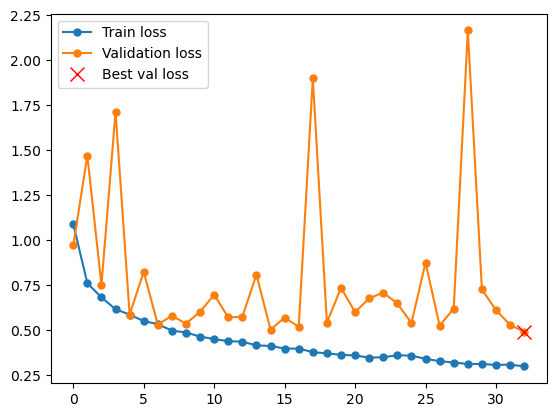

<All keys matched successfully>

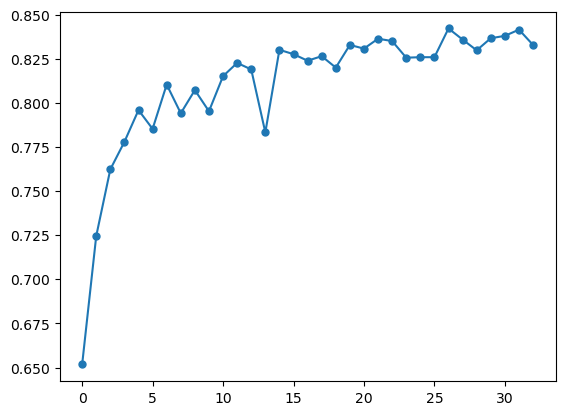

In [244]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Model08382(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 250)
        self.bn1 = nn.BatchNorm1d(250)
        self.fc2 = nn.Linear(250, 150)
        self.bn2 = nn.BatchNorm1d(150)
        self.dropout2 = nn.Dropout(0.10)
        self.fc3 = nn.Linear(150, 100)
        self.bn3 = nn.BatchNorm1d(100)
        self.dropout3 = nn.Dropout(0.10)
        self.fc4 = nn.Linear(100, 60)
        self.fc5 = nn.Linear(60, 40)
        self.fc6 = nn.Linear(40, 30)
        self.fc7 = nn.Linear(30, 30)
        self.fc8 = nn.Linear(30, 20)
        self.fco = nn.Linear(20, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = self.bn2(F.relu(self.fc2(x)))
        x = self.dropout2(x)
        x = (F.relu(self.fc3(x)))
        x = self.dropout3(x)
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = self.fco(x)
        return x

model08382= Model08382().to(device)
optimizer08382 = torch.optim.Adam(model08382.parameters())
train_more_epochs_es(50,5,model08382,loss_fn,optimizer08382,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model08382.load_state_dict(torch.load(model_path))

EPOCH 1:


100%|██████████| 985/985 [00:07<00:00, 131.29it/s]


TRAIN loss: 1.042, VALIDATION loss: 0.775, accuraccy: 0.703
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:08<00:00, 113.72it/s]


TRAIN loss: 0.695, VALIDATION loss: 0.625, accuraccy: 0.771
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:08<00:00, 115.42it/s]


TRAIN loss: 0.609, VALIDATION loss: 0.563, accuraccy: 0.789
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:07<00:00, 128.88it/s]


TRAIN loss: 0.553, VALIDATION loss: 0.563, accuraccy: 0.796
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:07<00:00, 126.27it/s]


TRAIN loss: 0.519, VALIDATION loss: 0.549, accuraccy: 0.803
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:10<00:00, 90.98it/s] 


TRAIN loss: 0.499, VALIDATION loss: 0.516, accuraccy: 0.813
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:12<00:00, 81.73it/s]


TRAIN loss: 0.475, VALIDATION loss: 0.520, accuraccy: 0.818
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:11<00:00, 84.70it/s] 


TRAIN loss: 0.455, VALIDATION loss: 0.492, accuraccy: 0.825
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:07<00:00, 132.10it/s]


TRAIN loss: 0.470, VALIDATION loss: 0.524, accuraccy: 0.816
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:07<00:00, 137.73it/s]


TRAIN loss: 0.430, VALIDATION loss: 0.509, accuraccy: 0.821
No improvement in this epoch.
EPOCH 11:


100%|██████████| 985/985 [00:07<00:00, 125.36it/s]


TRAIN loss: 0.413, VALIDATION loss: 0.523, accuraccy: 0.814
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:09<00:00, 104.18it/s]


TRAIN loss: 0.408, VALIDATION loss: 0.472, accuraccy: 0.827
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:09<00:00, 100.41it/s]


TRAIN loss: 0.390, VALIDATION loss: 0.491, accuraccy: 0.825
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:11<00:00, 88.13it/s]


TRAIN loss: 0.378, VALIDATION loss: 0.472, accuraccy: 0.831
Saving best model
EPOCH 15:


100%|██████████| 985/985 [00:11<00:00, 89.15it/s]


TRAIN loss: 0.368, VALIDATION loss: 0.498, accuraccy: 0.826
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:10<00:00, 92.90it/s] 


TRAIN loss: 0.356, VALIDATION loss: 0.508, accuraccy: 0.823
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:12<00:00, 80.82it/s]


TRAIN loss: 0.350, VALIDATION loss: 0.504, accuraccy: 0.829
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:08<00:00, 114.01it/s]


TRAIN loss: 0.349, VALIDATION loss: 0.520, accuraccy: 0.827
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:08<00:00, 120.94it/s]


TRAIN loss: 0.337, VALIDATION loss: 0.467, accuraccy: 0.837
Saving best model
EPOCH 20:


100%|██████████| 985/985 [00:08<00:00, 113.75it/s]


TRAIN loss: 0.336, VALIDATION loss: 0.485, accuraccy: 0.835
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:08<00:00, 116.60it/s]


TRAIN loss: 0.325, VALIDATION loss: 0.484, accuraccy: 0.833
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:08<00:00, 119.27it/s]


TRAIN loss: 0.315, VALIDATION loss: 0.501, accuraccy: 0.838
Saving best model
EPOCH 23:


100%|██████████| 985/985 [00:09<00:00, 104.69it/s]


TRAIN loss: 0.304, VALIDATION loss: 0.480, accuraccy: 0.838
Saving best model
EPOCH 24:


100%|██████████| 985/985 [00:09<00:00, 100.43it/s]


TRAIN loss: 0.300, VALIDATION loss: 0.485, accuraccy: 0.837
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:07<00:00, 123.48it/s]


TRAIN loss: 0.302, VALIDATION loss: 0.486, accuraccy: 0.839
Saving best model
EPOCH 26:


100%|██████████| 985/985 [00:09<00:00, 105.79it/s]


TRAIN loss: 0.311, VALIDATION loss: 0.477, accuraccy: 0.841
Saving best model
EPOCH 27:


100%|██████████| 985/985 [00:08<00:00, 116.12it/s]


TRAIN loss: 0.284, VALIDATION loss: 0.513, accuraccy: 0.839
No improvement in this epoch.
EPOCH 28:


100%|██████████| 985/985 [00:11<00:00, 88.62it/s] 


TRAIN loss: 0.279, VALIDATION loss: 0.499, accuraccy: 0.837
No improvement in this epoch.
EPOCH 29:


100%|██████████| 985/985 [00:08<00:00, 120.98it/s]


TRAIN loss: 0.275, VALIDATION loss: 0.472, accuraccy: 0.839
No improvement in this epoch.
EPOCH 30:


100%|██████████| 985/985 [00:08<00:00, 122.68it/s]


TRAIN loss: 0.276, VALIDATION loss: 0.493, accuraccy: 0.838
No improvement in this epoch.
EPOCH 31:


100%|██████████| 985/985 [00:07<00:00, 125.62it/s]


TRAIN loss: 0.263, VALIDATION loss: 0.503, accuraccy: 0.839
No improvement in this epoch.
EPOCH 32:


100%|██████████| 985/985 [00:08<00:00, 122.07it/s]


TRAIN loss: 0.254, VALIDATION loss: 0.492, accuraccy: 0.843
Saving best model
EPOCH 33:


100%|██████████| 985/985 [00:09<00:00, 107.12it/s]


TRAIN loss: 0.252, VALIDATION loss: 0.528, accuraccy: 0.840
No improvement in this epoch.
EPOCH 34:


100%|██████████| 985/985 [00:09<00:00, 104.17it/s]


TRAIN loss: 0.251, VALIDATION loss: 0.519, accuraccy: 0.838
No improvement in this epoch.
EPOCH 35:


100%|██████████| 985/985 [00:08<00:00, 110.54it/s]


TRAIN loss: 0.252, VALIDATION loss: 0.495, accuraccy: 0.843
No improvement in this epoch.
EPOCH 36:


100%|██████████| 985/985 [00:07<00:00, 132.93it/s]


TRAIN loss: 0.239, VALIDATION loss: 0.527, accuraccy: 0.841
No improvement in this epoch.
EPOCH 37:


100%|██████████| 985/985 [00:07<00:00, 130.64it/s]


TRAIN loss: 0.240, VALIDATION loss: 0.545, accuraccy: 0.835
No improvement in this epoch.
EPOCH 38:


100%|██████████| 985/985 [00:08<00:00, 119.43it/s]


TRAIN loss: 0.232, VALIDATION loss: 0.566, accuraccy: 0.837
No improvement in this epoch.
Early stopping now


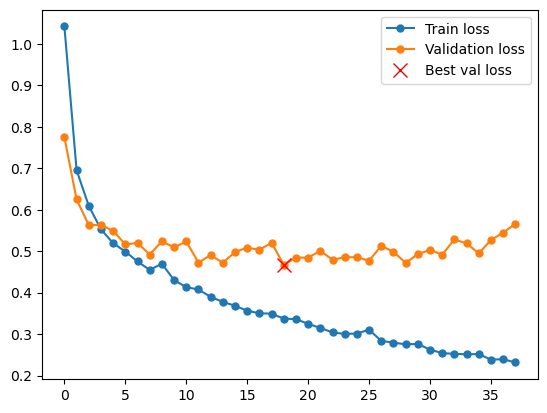

<All keys matched successfully>

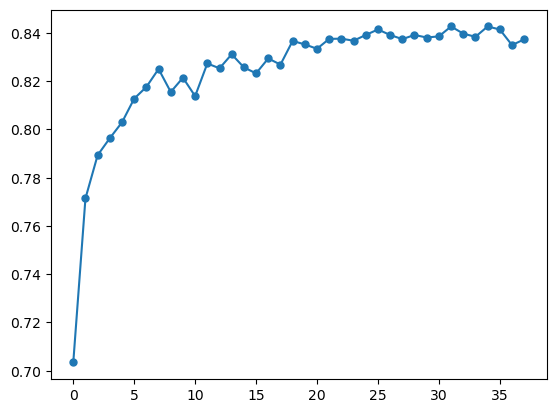

In [247]:
model08382_sc= Model08382().to(device)
optimizer08382_sc = torch.optim.Adam(model08382_sc.parameters())
train_more_epochs_es(50,5,model08382_sc,loss_fn,optimizer08382_sc,training_loader_sc,validation_loader_sc)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model08382_sc.load_state_dict(torch.load(model_path))

EPOCH 1:


100%|██████████| 985/985 [00:07<00:00, 140.43it/s]


TRAIN loss: 1.022, VALIDATION loss: 0.760, accuraccy: 0.710
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:07<00:00, 128.33it/s]


TRAIN loss: 0.717, VALIDATION loss: 0.650, accuraccy: 0.759
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:09<00:00, 101.63it/s]


TRAIN loss: 0.634, VALIDATION loss: 0.621, accuraccy: 0.775
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:07<00:00, 126.84it/s]


TRAIN loss: 0.586, VALIDATION loss: 0.586, accuraccy: 0.784
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:08<00:00, 116.07it/s]


TRAIN loss: 0.559, VALIDATION loss: 0.551, accuraccy: 0.800
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:09<00:00, 106.29it/s]


TRAIN loss: 0.517, VALIDATION loss: 0.543, accuraccy: 0.803
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:07<00:00, 126.17it/s]


TRAIN loss: 0.494, VALIDATION loss: 0.546, accuraccy: 0.811
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:08<00:00, 121.26it/s]


TRAIN loss: 0.476, VALIDATION loss: 0.502, accuraccy: 0.818
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:07<00:00, 137.07it/s]


TRAIN loss: 0.462, VALIDATION loss: 0.540, accuraccy: 0.812
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:07<00:00, 127.83it/s]


TRAIN loss: 0.449, VALIDATION loss: 0.503, accuraccy: 0.816
No improvement in this epoch.
EPOCH 11:


100%|██████████| 985/985 [00:07<00:00, 131.55it/s]


TRAIN loss: 0.438, VALIDATION loss: 0.493, accuraccy: 0.824
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:07<00:00, 136.31it/s]


TRAIN loss: 0.420, VALIDATION loss: 0.489, accuraccy: 0.822
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:07<00:00, 128.90it/s]


TRAIN loss: 0.418, VALIDATION loss: 0.483, accuraccy: 0.830
Saving best model
EPOCH 14:


100%|██████████| 985/985 [00:07<00:00, 137.66it/s]


TRAIN loss: 0.403, VALIDATION loss: 0.488, accuraccy: 0.821
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:07<00:00, 137.35it/s]


TRAIN loss: 0.396, VALIDATION loss: 0.531, accuraccy: 0.826
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:08<00:00, 111.10it/s]


TRAIN loss: 0.389, VALIDATION loss: 0.483, accuraccy: 0.825
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:06<00:00, 143.01it/s]


TRAIN loss: 0.382, VALIDATION loss: 0.512, accuraccy: 0.823
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:06<00:00, 145.08it/s]


TRAIN loss: 0.377, VALIDATION loss: 0.486, accuraccy: 0.829
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:07<00:00, 134.20it/s]


TRAIN loss: 0.368, VALIDATION loss: 0.485, accuraccy: 0.831
Saving best model
EPOCH 20:


100%|██████████| 985/985 [00:07<00:00, 140.15it/s]


TRAIN loss: 0.365, VALIDATION loss: 0.479, accuraccy: 0.831
Saving best model
EPOCH 21:


100%|██████████| 985/985 [00:07<00:00, 129.70it/s]


TRAIN loss: 0.355, VALIDATION loss: 0.498, accuraccy: 0.822
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:06<00:00, 146.98it/s]


TRAIN loss: 0.351, VALIDATION loss: 0.474, accuraccy: 0.836
Saving best model
EPOCH 23:


100%|██████████| 985/985 [00:06<00:00, 141.27it/s]


TRAIN loss: 0.343, VALIDATION loss: 0.473, accuraccy: 0.834
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:07<00:00, 138.32it/s]


TRAIN loss: 0.343, VALIDATION loss: 0.522, accuraccy: 0.826
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:07<00:00, 127.86it/s]


TRAIN loss: 0.336, VALIDATION loss: 0.479, accuraccy: 0.831
No improvement in this epoch.
EPOCH 26:


100%|██████████| 985/985 [00:06<00:00, 149.69it/s]


TRAIN loss: 0.331, VALIDATION loss: 0.532, accuraccy: 0.825
No improvement in this epoch.
EPOCH 27:


100%|██████████| 985/985 [00:07<00:00, 136.68it/s]


TRAIN loss: 0.327, VALIDATION loss: 0.478, accuraccy: 0.834
No improvement in this epoch.
EPOCH 28:


100%|██████████| 985/985 [00:07<00:00, 132.14it/s]


TRAIN loss: 0.320, VALIDATION loss: 0.513, accuraccy: 0.831
No improvement in this epoch.
EPOCH 29:


100%|██████████| 985/985 [00:07<00:00, 140.36it/s]


TRAIN loss: 0.319, VALIDATION loss: 0.490, accuraccy: 0.828
No improvement in this epoch.
EPOCH 30:


100%|██████████| 985/985 [00:08<00:00, 119.15it/s]


TRAIN loss: 0.310, VALIDATION loss: 0.502, accuraccy: 0.834
No improvement in this epoch.
Early stopping now


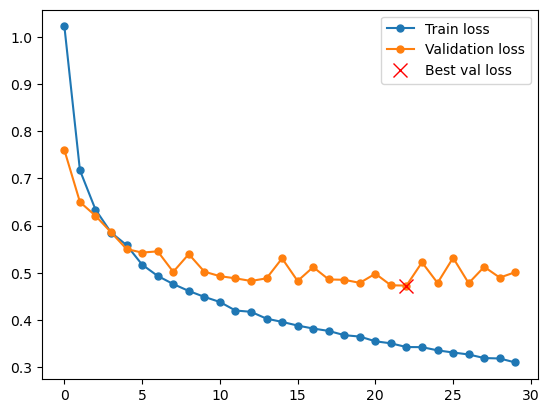

<All keys matched successfully>

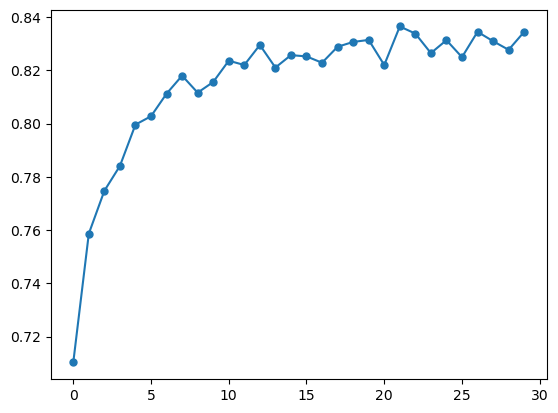

In [250]:
model08382_mm= Model08382().to(device)
optimizer08382_mm = torch.optim.Adam(model08382_mm.parameters())
train_more_epochs_es(50,7,model08382_mm,loss_fn,optimizer08382_mm,training_loader_mm,validation_loader_mm)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model08382_mm.load_state_dict(torch.load(model_path))

Nejlépe mi vyšel model 08381 s neuprvenými daty, zkusím ho ještě použít s jiným optimalizátorem.

EPOCH 1:


  0%|          | 0/985 [00:00<?, ?it/s]

100%|██████████| 985/985 [00:08<00:00, 116.97it/s]


TRAIN loss: 1.190, VALIDATION loss: 886.434, accuraccy: 0.513
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:09<00:00, 99.94it/s] 


TRAIN loss: 0.871, VALIDATION loss: 13.553, accuraccy: 0.658
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:09<00:00, 105.56it/s]


TRAIN loss: 0.774, VALIDATION loss: 34.009, accuraccy: 0.701
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:10<00:00, 98.17it/s] 


TRAIN loss: 0.745, VALIDATION loss: 0.892, accuraccy: 0.628
No improvement in this epoch.
EPOCH 5:


100%|██████████| 985/985 [00:08<00:00, 114.17it/s]


TRAIN loss: 0.696, VALIDATION loss: 58.256, accuraccy: 0.690
No improvement in this epoch.
EPOCH 6:


100%|██████████| 985/985 [00:08<00:00, 109.97it/s]


TRAIN loss: 0.679, VALIDATION loss: 4.462, accuraccy: 0.747
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:08<00:00, 112.34it/s]


TRAIN loss: 0.670, VALIDATION loss: 0.813, accuraccy: 0.763
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:07<00:00, 129.01it/s]


TRAIN loss: 0.645, VALIDATION loss: 0.645, accuraccy: 0.772
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:08<00:00, 122.91it/s]


TRAIN loss: 0.666, VALIDATION loss: 91.879, accuraccy: 0.765
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:07<00:00, 140.26it/s]


TRAIN loss: 0.663, VALIDATION loss: 1.102, accuraccy: 0.774
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:07<00:00, 124.96it/s]


TRAIN loss: 0.668, VALIDATION loss: 0.673, accuraccy: 0.771
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:09<00:00, 107.50it/s]


TRAIN loss: 0.665, VALIDATION loss: 1.923, accuraccy: 0.768
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:10<00:00, 89.67it/s] 


TRAIN loss: 0.657, VALIDATION loss: 0.673, accuraccy: 0.773
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:10<00:00, 93.99it/s] 


TRAIN loss: 0.644, VALIDATION loss: 189.714, accuraccy: 0.758
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:09<00:00, 99.68it/s] 


TRAIN loss: 0.648, VALIDATION loss: 0.628, accuraccy: 0.780
Saving best model
EPOCH 16:


100%|██████████| 985/985 [00:09<00:00, 103.33it/s]


TRAIN loss: 0.613, VALIDATION loss: 0.636, accuraccy: 0.770
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:08<00:00, 121.35it/s]


TRAIN loss: 0.654, VALIDATION loss: 3.677, accuraccy: 0.728
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:09<00:00, 101.45it/s]


TRAIN loss: 0.631, VALIDATION loss: 0.699, accuraccy: 0.745
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:10<00:00, 93.71it/s] 


TRAIN loss: 0.628, VALIDATION loss: 0.632, accuraccy: 0.765
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:08<00:00, 115.86it/s]


TRAIN loss: 0.624, VALIDATION loss: 0.755, accuraccy: 0.743
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:09<00:00, 105.23it/s]


TRAIN loss: 0.655, VALIDATION loss: 0.636, accuraccy: 0.765
No improvement in this epoch.
Early stopping now


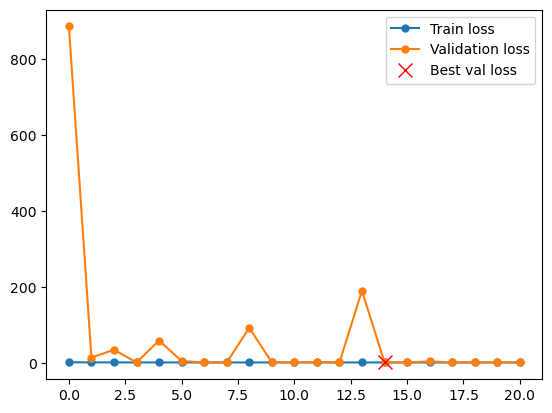

<All keys matched successfully>

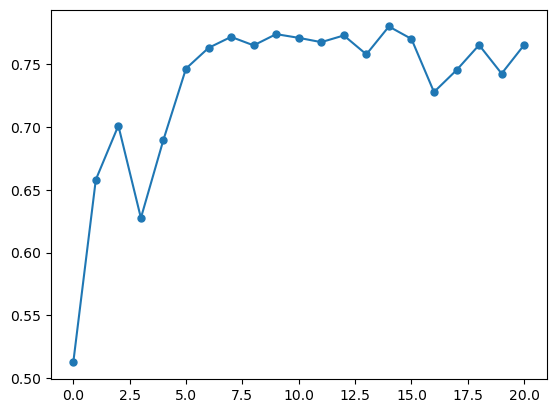

In [252]:
model08381a= Model08381().to(device)
optimizer08381a = torch.optim.RMSprop(model08381a.parameters())
train_more_epochs_es(35,5,model08381a,loss_fn,optimizer08381a,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model08381a.load_state_dict(torch.load(model_path))

Vidíme, že použití jiného optimalizátoru než je Adam vede k horším výsledkům.

Nejlepším modelem dopředné neuronové sítě je tedy model 08381, který má 9 vrstev, dropout a batch normalizaci pro druhou a třetí vrstvu. Nejvyšší dosažená přesnost an validační množině je 0.847.

Myslím si, že model konvoluční neuronové sítě bude pro tuto úlohu mnohem vhodnější než klasický model dopředné sítě.

2. Konvoluční neuronová síť

V druhé části úkolu budu hldat co nejlepší konvoluční síť. Konvoluční sítě jsou vhodné právě na úlohy jako j zpracování obázkových dat, myslím si tedy, že dostanu lepší výsledek než u klasických dopředných sítí.

Na začátek vyzkouším úplně jednoduchou konvoluční síť se dvěma vrstvami.

c:\Users\Pavel\miniconda3\envs\torchenv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


EPOCH 1:


100%|██████████| 985/985 [00:07<00:00, 124.15it/s]


TRAIN loss: 1.201, VALIDATION loss: 0.937, accuraccy: 0.666
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:08<00:00, 119.19it/s]


TRAIN loss: 0.800, VALIDATION loss: 0.825, accuraccy: 0.709
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:07<00:00, 124.23it/s]


TRAIN loss: 0.729, VALIDATION loss: 0.731, accuraccy: 0.730
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:07<00:00, 123.58it/s]


TRAIN loss: 0.679, VALIDATION loss: 0.738, accuraccy: 0.746
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:08<00:00, 118.64it/s]


TRAIN loss: 0.632, VALIDATION loss: 0.695, accuraccy: 0.743
No improvement in this epoch.
EPOCH 6:


100%|██████████| 985/985 [00:08<00:00, 121.95it/s]


TRAIN loss: 0.612, VALIDATION loss: 0.684, accuraccy: 0.750
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:08<00:00, 120.93it/s]


TRAIN loss: 0.592, VALIDATION loss: 0.677, accuraccy: 0.752
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:08<00:00, 122.72it/s]


TRAIN loss: 0.580, VALIDATION loss: 0.673, accuraccy: 0.758
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:07<00:00, 123.77it/s]


TRAIN loss: 0.558, VALIDATION loss: 0.714, accuraccy: 0.739
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:07<00:00, 123.68it/s]


TRAIN loss: 0.538, VALIDATION loss: 0.703, accuraccy: 0.752
No improvement in this epoch.
EPOCH 11:


100%|██████████| 985/985 [00:08<00:00, 117.15it/s]


TRAIN loss: 0.514, VALIDATION loss: 0.655, accuraccy: 0.764
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:08<00:00, 119.90it/s]


TRAIN loss: 0.513, VALIDATION loss: 0.679, accuraccy: 0.763
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:08<00:00, 119.27it/s]


TRAIN loss: 0.488, VALIDATION loss: 0.668, accuraccy: 0.765
Saving best model
EPOCH 14:


100%|██████████| 985/985 [00:08<00:00, 118.33it/s]


TRAIN loss: 0.483, VALIDATION loss: 0.659, accuraccy: 0.774
Saving best model
EPOCH 15:


100%|██████████| 985/985 [00:09<00:00, 105.53it/s]


TRAIN loss: 0.474, VALIDATION loss: 0.704, accuraccy: 0.769
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:08<00:00, 123.00it/s]


TRAIN loss: 0.459, VALIDATION loss: 0.743, accuraccy: 0.764
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:08<00:00, 118.69it/s]


TRAIN loss: 0.454, VALIDATION loss: 0.733, accuraccy: 0.763
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:08<00:00, 121.05it/s]


TRAIN loss: 0.444, VALIDATION loss: 0.732, accuraccy: 0.757
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:08<00:00, 115.34it/s]


TRAIN loss: 0.440, VALIDATION loss: 0.769, accuraccy: 0.762
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:08<00:00, 114.06it/s]


TRAIN loss: 0.424, VALIDATION loss: 0.764, accuraccy: 0.769
No improvement in this epoch.
Early stopping now


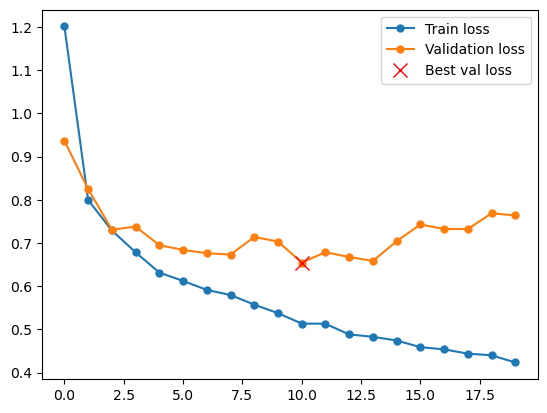

<All keys matched successfully>

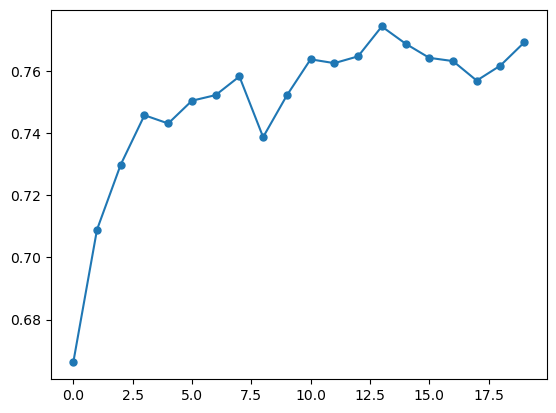

In [264]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ConvModel1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=16,kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.fco = nn.LazyLinear(10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.flatten(start_dim =1)
        x = self.fco(x)
        return x       

model1 = ConvModel1().to(device)
optimizer1 = torch.optim.Adam(model1.parameters())
train_more_epochs_es(25,5,model1,loss_fn,optimizer1,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model1.load_state_dict(torch.load(model_path))

Tato síť očividně není vhodná, zkusím sítě o větší hloubce.

c:\Users\Pavel\miniconda3\envs\torchenv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


EPOCH 1:


100%|██████████| 985/985 [00:11<00:00, 86.30it/s]


TRAIN loss: 0.642, VALIDATION loss: 0.537, accuraccy: 0.807
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:11<00:00, 87.00it/s]


TRAIN loss: 0.471, VALIDATION loss: 0.481, accuraccy: 0.822
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:11<00:00, 88.98it/s]


TRAIN loss: 0.417, VALIDATION loss: 0.436, accuraccy: 0.845
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:11<00:00, 87.92it/s]


TRAIN loss: 0.387, VALIDATION loss: 0.446, accuraccy: 0.837
No improvement in this epoch.
EPOCH 5:


100%|██████████| 985/985 [00:11<00:00, 87.82it/s]


TRAIN loss: 0.369, VALIDATION loss: 0.435, accuraccy: 0.842
No improvement in this epoch.
EPOCH 6:


100%|██████████| 985/985 [00:11<00:00, 85.41it/s]


TRAIN loss: 0.349, VALIDATION loss: 0.431, accuraccy: 0.848
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:11<00:00, 87.16it/s]


TRAIN loss: 0.336, VALIDATION loss: 0.433, accuraccy: 0.855
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:11<00:00, 88.39it/s]


TRAIN loss: 0.326, VALIDATION loss: 0.416, accuraccy: 0.854
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:11<00:00, 86.33it/s]


TRAIN loss: 0.315, VALIDATION loss: 0.468, accuraccy: 0.841
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:11<00:00, 88.28it/s]


TRAIN loss: 0.308, VALIDATION loss: 0.430, accuraccy: 0.847
No improvement in this epoch.
EPOCH 11:


100%|██████████| 985/985 [00:11<00:00, 84.57it/s]


TRAIN loss: 0.299, VALIDATION loss: 0.462, accuraccy: 0.844
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:11<00:00, 87.07it/s]


TRAIN loss: 0.288, VALIDATION loss: 0.451, accuraccy: 0.856
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:11<00:00, 88.33it/s]


TRAIN loss: 0.289, VALIDATION loss: 0.435, accuraccy: 0.852
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:11<00:00, 87.75it/s]


TRAIN loss: 0.275, VALIDATION loss: 0.459, accuraccy: 0.855
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:11<00:00, 88.65it/s]


TRAIN loss: 0.279, VALIDATION loss: 0.452, accuraccy: 0.849
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:11<00:00, 85.30it/s]


TRAIN loss: 0.266, VALIDATION loss: 0.456, accuraccy: 0.849
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:11<00:00, 87.15it/s]


TRAIN loss: 0.266, VALIDATION loss: 0.440, accuraccy: 0.850
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:11<00:00, 86.57it/s]


TRAIN loss: 0.257, VALIDATION loss: 0.500, accuraccy: 0.846
No improvement in this epoch.
Early stopping now


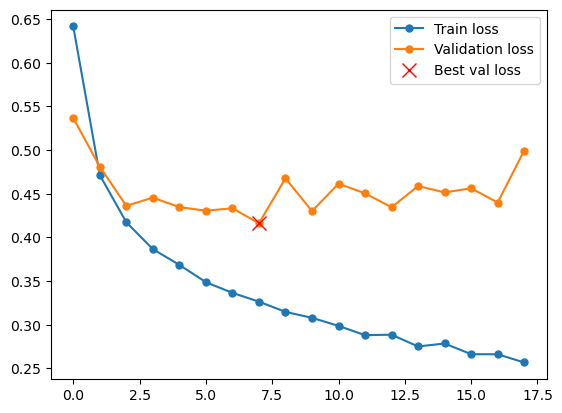

<All keys matched successfully>

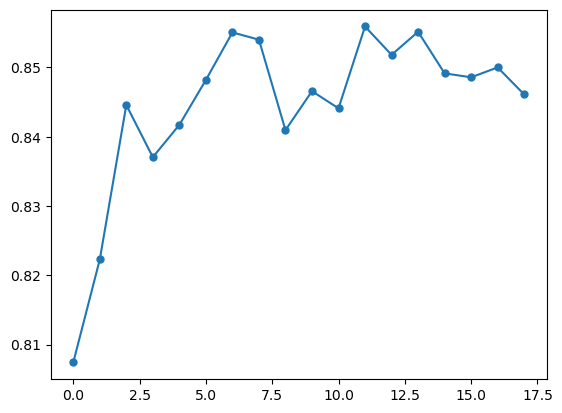

In [266]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ConvModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv3 = nn.Conv2d(in_channels=16,out_channels=10,kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv4 = nn.Conv2d(in_channels=10,out_channels=8,kernel_size=3)
        self.pool4 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.fco1 = nn.LazyLinear(10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.flatten(start_dim =1)
        x = self.fco1(x)
        return x
    
model2 = ConvModel2().to(device)
optimizer2 = torch.optim.Adam(model2.parameters())
train_more_epochs_es(25,5,model2,loss_fn,optimizer2,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model2.load_state_dict(torch.load(model_path))

Dostávám mnohem lepší výsledek! Zkusím změnit i počet fully connected vrstev.

c:\Users\Pavel\miniconda3\envs\torchenv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


EPOCH 1:


100%|██████████| 985/985 [00:11<00:00, 85.93it/s]


TRAIN loss: 0.630, VALIDATION loss: 0.527, accuraccy: 0.809
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:11<00:00, 85.36it/s]


TRAIN loss: 0.465, VALIDATION loss: 0.452, accuraccy: 0.838
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:11<00:00, 84.73it/s]


TRAIN loss: 0.411, VALIDATION loss: 0.431, accuraccy: 0.843
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:11<00:00, 87.46it/s]


TRAIN loss: 0.383, VALIDATION loss: 0.429, accuraccy: 0.842
No improvement in this epoch.
EPOCH 5:


100%|██████████| 985/985 [00:11<00:00, 87.32it/s]


TRAIN loss: 0.362, VALIDATION loss: 0.407, accuraccy: 0.856
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:11<00:00, 83.14it/s]


TRAIN loss: 0.344, VALIDATION loss: 0.402, accuraccy: 0.856
No improvement in this epoch.
EPOCH 7:


100%|██████████| 985/985 [00:11<00:00, 87.32it/s]


TRAIN loss: 0.327, VALIDATION loss: 0.389, accuraccy: 0.863
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:11<00:00, 84.84it/s]


TRAIN loss: 0.316, VALIDATION loss: 0.421, accuraccy: 0.854
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:12<00:00, 80.05it/s]


TRAIN loss: 0.305, VALIDATION loss: 0.419, accuraccy: 0.856
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:11<00:00, 82.34it/s]


TRAIN loss: 0.292, VALIDATION loss: 0.459, accuraccy: 0.849
No improvement in this epoch.
EPOCH 11:


100%|██████████| 985/985 [00:11<00:00, 85.65it/s]


TRAIN loss: 0.285, VALIDATION loss: 0.431, accuraccy: 0.858
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:11<00:00, 86.85it/s]


TRAIN loss: 0.273, VALIDATION loss: 0.415, accuraccy: 0.860
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:11<00:00, 84.73it/s]


TRAIN loss: 0.265, VALIDATION loss: 0.414, accuraccy: 0.865
Saving best model
EPOCH 14:


100%|██████████| 985/985 [00:11<00:00, 85.26it/s]


TRAIN loss: 0.252, VALIDATION loss: 0.451, accuraccy: 0.861
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:11<00:00, 85.38it/s]


TRAIN loss: 0.248, VALIDATION loss: 0.438, accuraccy: 0.867
Saving best model
EPOCH 16:


100%|██████████| 985/985 [00:11<00:00, 82.98it/s]


TRAIN loss: 0.239, VALIDATION loss: 0.452, accuraccy: 0.863
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:11<00:00, 85.05it/s]


TRAIN loss: 0.235, VALIDATION loss: 0.466, accuraccy: 0.854
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:14<00:00, 68.11it/s]


TRAIN loss: 0.236, VALIDATION loss: 0.477, accuraccy: 0.860
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:14<00:00, 68.94it/s]


TRAIN loss: 0.227, VALIDATION loss: 0.465, accuraccy: 0.860
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:12<00:00, 80.18it/s]


TRAIN loss: 0.220, VALIDATION loss: 0.472, accuraccy: 0.858
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:11<00:00, 86.01it/s]


TRAIN loss: 0.219, VALIDATION loss: 0.484, accuraccy: 0.856
No improvement in this epoch.
Early stopping now


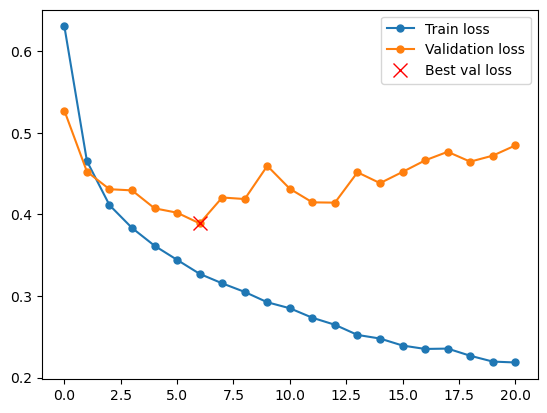

<All keys matched successfully>

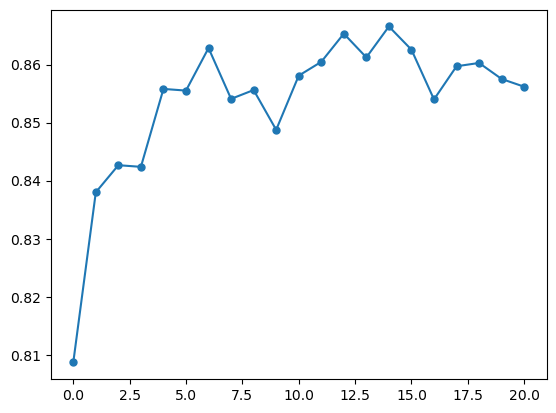

In [267]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ConvModel3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv3 = nn.Conv2d(in_channels=16,out_channels=10,kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv4 = nn.Conv2d(in_channels=10,out_channels=8,kernel_size=3)
        self.pool4 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.fco1 = nn.LazyLinear(10)
        self.fco2 = nn.LazyLinear(10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.flatten(start_dim =1)
        x = self.fco1(x)
        x = self.fco2(x)
        return x
    
model3 = ConvModel3().to(device)
optimizer3 = torch.optim.Adam(model3.parameters())
train_more_epochs_es(25,5,model3,loss_fn,optimizer3,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model3.load_state_dict(torch.load(model_path))

Dostáváme zatím nejlepší model, zkusím jaký vliv bude mít změna kernelu na 5.

c:\Users\Pavel\miniconda3\envs\torchenv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


EPOCH 1:


  0%|          | 0/985 [00:00<?, ?it/s]c:\Users\Pavel\miniconda3\envs\torchenv\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 985/985 [00:10<00:00, 93.99it/s]


TRAIN loss: 0.940, VALIDATION loss: 0.703, accuraccy: 0.748
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:10<00:00, 96.03it/s] 


TRAIN loss: 0.618, VALIDATION loss: 0.613, accuraccy: 0.773
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:10<00:00, 92.41it/s] 


TRAIN loss: 0.556, VALIDATION loss: 0.544, accuraccy: 0.808
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:10<00:00, 95.20it/s] 


TRAIN loss: 0.513, VALIDATION loss: 0.515, accuraccy: 0.818
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:10<00:00, 93.91it/s] 


TRAIN loss: 0.488, VALIDATION loss: 0.514, accuraccy: 0.815
No improvement in this epoch.
EPOCH 6:


100%|██████████| 985/985 [00:10<00:00, 95.37it/s] 


TRAIN loss: 0.464, VALIDATION loss: 0.501, accuraccy: 0.825
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:10<00:00, 89.66it/s]


TRAIN loss: 0.447, VALIDATION loss: 0.463, accuraccy: 0.833
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:10<00:00, 93.93it/s] 


TRAIN loss: 0.430, VALIDATION loss: 0.486, accuraccy: 0.828
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:10<00:00, 98.44it/s] 


TRAIN loss: 0.425, VALIDATION loss: 0.506, accuraccy: 0.829
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:10<00:00, 94.90it/s] 


TRAIN loss: 0.415, VALIDATION loss: 0.472, accuraccy: 0.838
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:10<00:00, 97.66it/s] 


TRAIN loss: 0.406, VALIDATION loss: 0.476, accuraccy: 0.828
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:10<00:00, 94.26it/s]


TRAIN loss: 0.401, VALIDATION loss: 0.481, accuraccy: 0.835
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:11<00:00, 84.06it/s]


TRAIN loss: 0.396, VALIDATION loss: 0.498, accuraccy: 0.825
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:10<00:00, 97.39it/s]


TRAIN loss: 0.387, VALIDATION loss: 0.486, accuraccy: 0.826
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:10<00:00, 91.73it/s]


TRAIN loss: 0.385, VALIDATION loss: 0.453, accuraccy: 0.838
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:11<00:00, 84.80it/s]


TRAIN loss: 0.379, VALIDATION loss: 0.450, accuraccy: 0.843
Saving best model
EPOCH 17:


100%|██████████| 985/985 [00:11<00:00, 86.67it/s]


TRAIN loss: 0.372, VALIDATION loss: 0.442, accuraccy: 0.840
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:13<00:00, 73.75it/s]


TRAIN loss: 0.375, VALIDATION loss: 0.464, accuraccy: 0.844
Saving best model
EPOCH 19:


100%|██████████| 985/985 [00:12<00:00, 81.28it/s]


TRAIN loss: 0.363, VALIDATION loss: 0.464, accuraccy: 0.836
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:11<00:00, 82.69it/s]


TRAIN loss: 0.358, VALIDATION loss: 0.450, accuraccy: 0.842
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:11<00:00, 89.30it/s]


TRAIN loss: 0.356, VALIDATION loss: 0.517, accuraccy: 0.828
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:11<00:00, 86.08it/s]


TRAIN loss: 0.362, VALIDATION loss: 0.478, accuraccy: 0.839
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:14<00:00, 69.85it/s]


TRAIN loss: 0.354, VALIDATION loss: 0.439, accuraccy: 0.848
Saving best model
EPOCH 24:


100%|██████████| 985/985 [00:14<00:00, 66.08it/s]


TRAIN loss: 0.346, VALIDATION loss: 0.444, accuraccy: 0.843
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:13<00:00, 71.95it/s]


TRAIN loss: 0.348, VALIDATION loss: 0.503, accuraccy: 0.834
No improvement in this epoch.


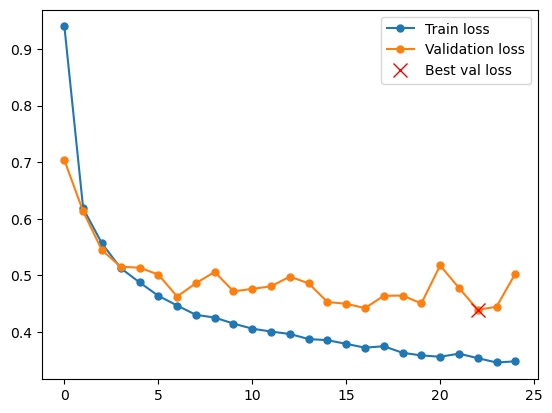

<All keys matched successfully>

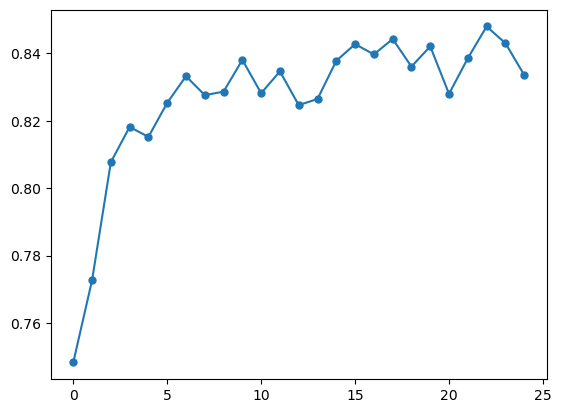

In [268]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ConvModel31(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=16,kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv3 = nn.Conv2d(in_channels=16,out_channels=10,kernel_size=5)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv4 = nn.Conv2d(in_channels=10,out_channels=8,kernel_size=5)
        self.pool4 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.fco1 = nn.LazyLinear(10)
        self.fco2 = nn.LazyLinear(10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.flatten(start_dim =1)
        x = self.fco1(x)
        x = self.fco2(x)
        return x
    
model31 = ConvModel31().to(device)
optimizer31 = torch.optim.Adam(model31.parameters())
train_more_epochs_es(25,5,model31,loss_fn,optimizer31,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model31.load_state_dict(torch.load(model_path))

Kernel 5 je očividně horší, vrátím se zpět ke kernel 3 a zkusím přidat ještě více konvolučních vrstev.

c:\Users\Pavel\miniconda3\envs\torchenv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


EPOCH 1:


100%|██████████| 985/985 [00:16<00:00, 58.90it/s]


TRAIN loss: 1.302, VALIDATION loss: 0.995, accuraccy: 0.644
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:17<00:00, 57.77it/s]


TRAIN loss: 0.772, VALIDATION loss: 0.684, accuraccy: 0.755
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:17<00:00, 57.36it/s]


TRAIN loss: 0.636, VALIDATION loss: 0.598, accuraccy: 0.775
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:16<00:00, 59.11it/s]


TRAIN loss: 0.578, VALIDATION loss: 0.571, accuraccy: 0.791
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:17<00:00, 57.18it/s]


TRAIN loss: 0.525, VALIDATION loss: 0.516, accuraccy: 0.816
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:18<00:00, 54.53it/s]


TRAIN loss: 0.489, VALIDATION loss: 0.500, accuraccy: 0.818
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:17<00:00, 57.48it/s]


TRAIN loss: 0.466, VALIDATION loss: 0.495, accuraccy: 0.815
No improvement in this epoch.
EPOCH 8:


100%|██████████| 985/985 [00:17<00:00, 56.42it/s]


TRAIN loss: 0.448, VALIDATION loss: 0.468, accuraccy: 0.829
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:18<00:00, 53.75it/s]


TRAIN loss: 0.434, VALIDATION loss: 0.470, accuraccy: 0.827
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:17<00:00, 57.68it/s]


TRAIN loss: 0.424, VALIDATION loss: 0.434, accuraccy: 0.845
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:16<00:00, 57.95it/s]


TRAIN loss: 0.410, VALIDATION loss: 0.445, accuraccy: 0.841
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:18<00:00, 52.04it/s]


TRAIN loss: 0.400, VALIDATION loss: 0.438, accuraccy: 0.842
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:19<00:00, 50.46it/s]


TRAIN loss: 0.397, VALIDATION loss: 0.439, accuraccy: 0.841
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:20<00:00, 47.69it/s]


TRAIN loss: 0.383, VALIDATION loss: 0.467, accuraccy: 0.836
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:23<00:00, 41.72it/s]


TRAIN loss: 0.384, VALIDATION loss: 0.428, accuraccy: 0.843
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:16<00:00, 58.12it/s]


TRAIN loss: 0.378, VALIDATION loss: 0.440, accuraccy: 0.843
No improvement in this epoch.
Early stopping now


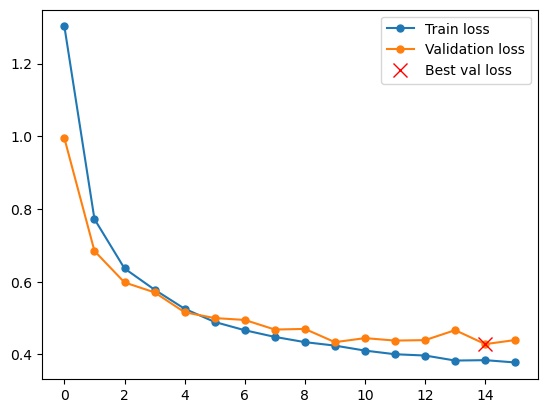

<All keys matched successfully>

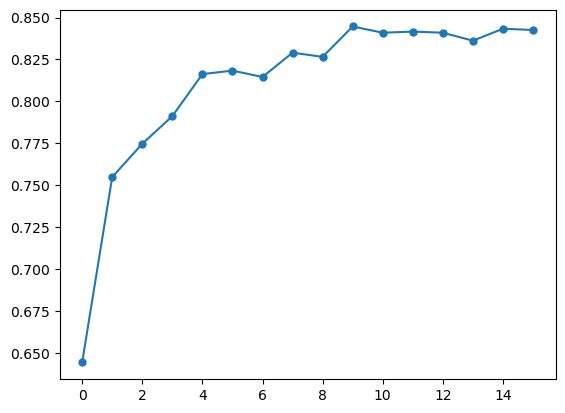

In [269]:
class ConvModel4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=24,kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv3 = nn.Conv2d(in_channels=24,out_channels=20,kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv4 = nn.Conv2d(in_channels=20,out_channels=16,kernel_size=3)
        self.pool4 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv5 = nn.Conv2d(in_channels=16,out_channels=12,kernel_size=3)
        self.pool5 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv6 = nn.Conv2d(in_channels=12,out_channels=10,kernel_size=3)
        self.pool6 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.fco1 = nn.LazyLinear(10)
        self.fco2 = nn.LazyLinear(10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = F.relu(self.conv5(x))
        x = self.pool5(x)
        x = F.relu(self.conv6(x))
        x = self.pool6(x)
        x = x.flatten(start_dim =1)
        x = F.relu(self.fco1(x))
        x = (self.fco2(x))
        return x
    
model4 = ConvModel4().to(device)
optimizer4 = torch.optim.Adam(model4.parameters())
train_more_epochs_es(25,5,model4,loss_fn,optimizer4,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model4.load_state_dict(torch.load(model_path))

Takto hluboká síť dosahuje horších výsledků než při menším počtu vrsteva výpočet je znatelně náročnější. Vrátím se tedy k modelu s 4 konv. vrstvami a zkusím měnit počet neuronů, přidat dropout...

Nejprve zvýším počet neuronů v druhé lineární vrstě.

EPOCH 1:


100%|██████████| 985/985 [00:12<00:00, 78.51it/s]


TRAIN loss: 0.689, VALIDATION loss: 0.604, accuraccy: 0.792
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:12<00:00, 77.90it/s]


TRAIN loss: 0.503, VALIDATION loss: 0.501, accuraccy: 0.817
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:12<00:00, 80.10it/s]


TRAIN loss: 0.448, VALIDATION loss: 0.454, accuraccy: 0.833
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:12<00:00, 81.13it/s]


TRAIN loss: 0.421, VALIDATION loss: 0.444, accuraccy: 0.842
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:12<00:00, 76.90it/s]


TRAIN loss: 0.400, VALIDATION loss: 0.459, accuraccy: 0.833
No improvement in this epoch.
EPOCH 6:


100%|██████████| 985/985 [00:12<00:00, 78.98it/s]


TRAIN loss: 0.383, VALIDATION loss: 0.447, accuraccy: 0.838
No improvement in this epoch.
EPOCH 7:


100%|██████████| 985/985 [00:12<00:00, 77.04it/s]


TRAIN loss: 0.368, VALIDATION loss: 0.436, accuraccy: 0.850
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:12<00:00, 80.51it/s]


TRAIN loss: 0.354, VALIDATION loss: 0.474, accuraccy: 0.836
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:12<00:00, 76.71it/s]


TRAIN loss: 0.342, VALIDATION loss: 0.484, accuraccy: 0.841
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:12<00:00, 79.41it/s]


TRAIN loss: 0.331, VALIDATION loss: 0.453, accuraccy: 0.837
No improvement in this epoch.
EPOCH 11:


100%|██████████| 985/985 [00:12<00:00, 75.98it/s]


TRAIN loss: 0.326, VALIDATION loss: 0.456, accuraccy: 0.848
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:13<00:00, 75.18it/s]


TRAIN loss: 0.321, VALIDATION loss: 0.452, accuraccy: 0.848
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:12<00:00, 80.93it/s]


TRAIN loss: 0.308, VALIDATION loss: 0.466, accuraccy: 0.841
No improvement in this epoch.
Early stopping now


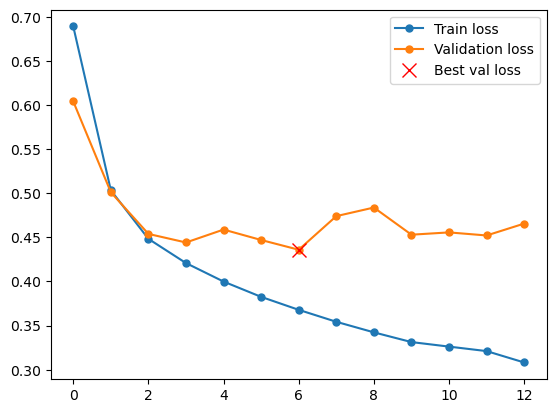

<All keys matched successfully>

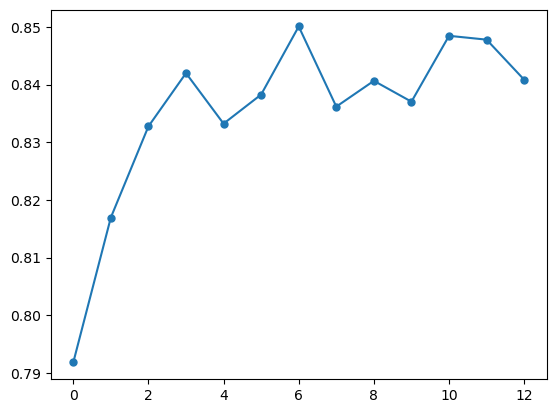

In [274]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ConvModel31(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv3 = nn.Conv2d(in_channels=16,out_channels=10,kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv4 = nn.Conv2d(in_channels=10,out_channels=8,kernel_size=3)
        self.pool4 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.fco1 = nn.LazyLinear(100)
        self.fco2 = nn.LazyLinear(10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.flatten(start_dim =1)
        x = self.fco1(x)
        #x = x.flatten(start_dim =1)
        x = self.fco2(x)
        return x
    
model31 = ConvModel31().to(device)
optimizer311 = torch.optim.Adam(model31.parameters())
train_more_epochs_es(25,5,model31,loss_fn,optimizer311,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model31.load_state_dict(torch.load(model_path))

Dostávám horší výsledek, vrátím se k nižšímu počtu a tentokrát zkusím změnit počet kanálů v kovolučních vrstvách.

EPOCH 1:


  0%|          | 0/985 [00:00<?, ?it/s]

100%|██████████| 985/985 [00:15<00:00, 63.88it/s]


TRAIN loss: 0.781, VALIDATION loss: 0.558, accuraccy: 0.804
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:15<00:00, 65.01it/s]


TRAIN loss: 0.505, VALIDATION loss: 0.501, accuraccy: 0.822
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:19<00:00, 50.81it/s]


TRAIN loss: 0.446, VALIDATION loss: 0.437, accuraccy: 0.844
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:16<00:00, 61.07it/s]


TRAIN loss: 0.406, VALIDATION loss: 0.436, accuraccy: 0.845
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:16<00:00, 61.37it/s]


TRAIN loss: 0.382, VALIDATION loss: 0.430, accuraccy: 0.847
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:16<00:00, 60.90it/s]


TRAIN loss: 0.362, VALIDATION loss: 0.432, accuraccy: 0.850
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:14<00:00, 66.41it/s]


TRAIN loss: 0.345, VALIDATION loss: 0.404, accuraccy: 0.854
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:15<00:00, 64.57it/s]


TRAIN loss: 0.330, VALIDATION loss: 0.393, accuraccy: 0.861
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:14<00:00, 66.09it/s]


TRAIN loss: 0.324, VALIDATION loss: 0.405, accuraccy: 0.855
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:15<00:00, 63.88it/s]


TRAIN loss: 0.305, VALIDATION loss: 0.393, accuraccy: 0.868
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:15<00:00, 62.67it/s]


TRAIN loss: 0.294, VALIDATION loss: 0.439, accuraccy: 0.846
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:15<00:00, 63.44it/s]


TRAIN loss: 0.285, VALIDATION loss: 0.404, accuraccy: 0.862
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:15<00:00, 62.65it/s]


TRAIN loss: 0.279, VALIDATION loss: 0.409, accuraccy: 0.865
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:15<00:00, 63.86it/s]


TRAIN loss: 0.271, VALIDATION loss: 0.467, accuraccy: 0.855
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:16<00:00, 61.40it/s]


TRAIN loss: 0.264, VALIDATION loss: 0.452, accuraccy: 0.855
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:16<00:00, 59.53it/s]


TRAIN loss: 0.258, VALIDATION loss: 0.465, accuraccy: 0.856
No improvement in this epoch.
Early stopping now


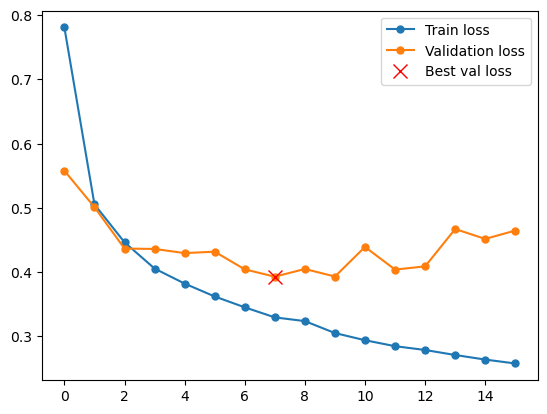

<All keys matched successfully>

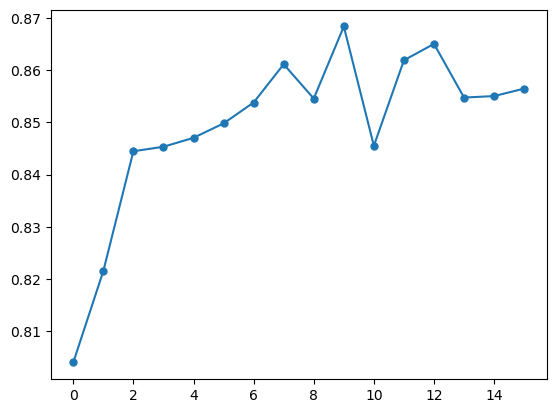

In [277]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ConvModel32(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv4 = nn.Conv2d(in_channels=16,out_channels=8,kernel_size=3)
        self.pool4 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.fco1 = nn.LazyLinear(10)
        self.fco2 = nn.LazyLinear(10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.flatten(start_dim =1)
        x = self.fco1(x)
        #x = x.flatten(start_dim =1)
        x = self.fco2(x)
        return x
    
model32 = ConvModel32().to(device)
optimizer32 = torch.optim.Adam(model32.parameters())
train_more_epochs_es(25,5,model32,loss_fn,optimizer32,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model32.load_state_dict(torch.load(model_path))

EPOCH 1:


  0%|          | 0/985 [00:00<?, ?it/s]

100%|██████████| 985/985 [00:21<00:00, 45.96it/s]


TRAIN loss: 0.768, VALIDATION loss: 0.577, accuraccy: 0.790
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:21<00:00, 46.61it/s]


TRAIN loss: 0.504, VALIDATION loss: 0.467, accuraccy: 0.832
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:21<00:00, 45.29it/s]


TRAIN loss: 0.435, VALIDATION loss: 0.433, accuraccy: 0.846
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:21<00:00, 45.65it/s]


TRAIN loss: 0.396, VALIDATION loss: 0.427, accuraccy: 0.847
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:21<00:00, 44.84it/s]


TRAIN loss: 0.364, VALIDATION loss: 0.488, accuraccy: 0.831
No improvement in this epoch.
EPOCH 6:


100%|██████████| 985/985 [00:21<00:00, 46.11it/s]


TRAIN loss: 0.347, VALIDATION loss: 0.422, accuraccy: 0.849
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:21<00:00, 46.19it/s]


TRAIN loss: 0.328, VALIDATION loss: 0.404, accuraccy: 0.857
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:21<00:00, 45.23it/s]


TRAIN loss: 0.312, VALIDATION loss: 0.434, accuraccy: 0.839
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:21<00:00, 45.48it/s]


TRAIN loss: 0.298, VALIDATION loss: 0.389, accuraccy: 0.861
Saving best model
EPOCH 10:


100%|██████████| 985/985 [00:21<00:00, 45.09it/s]


TRAIN loss: 0.281, VALIDATION loss: 0.408, accuraccy: 0.863
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:21<00:00, 45.14it/s]


TRAIN loss: 0.270, VALIDATION loss: 0.419, accuraccy: 0.859
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:21<00:00, 46.51it/s]


TRAIN loss: 0.263, VALIDATION loss: 0.399, accuraccy: 0.864
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:21<00:00, 46.04it/s]


TRAIN loss: 0.246, VALIDATION loss: 0.432, accuraccy: 0.864
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:21<00:00, 46.64it/s]


TRAIN loss: 0.246, VALIDATION loss: 0.448, accuraccy: 0.855
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:21<00:00, 46.56it/s]


TRAIN loss: 0.233, VALIDATION loss: 0.495, accuraccy: 0.848
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:21<00:00, 45.99it/s]


TRAIN loss: 0.227, VALIDATION loss: 0.430, accuraccy: 0.865
Saving best model
EPOCH 17:


100%|██████████| 985/985 [00:21<00:00, 46.77it/s]


TRAIN loss: 0.213, VALIDATION loss: 0.494, accuraccy: 0.863
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:21<00:00, 45.79it/s]


TRAIN loss: 0.210, VALIDATION loss: 0.509, accuraccy: 0.844
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:21<00:00, 46.84it/s]


TRAIN loss: 0.206, VALIDATION loss: 0.508, accuraccy: 0.864
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:20<00:00, 46.96it/s]


TRAIN loss: 0.199, VALIDATION loss: 0.509, accuraccy: 0.852
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:21<00:00, 45.60it/s]


TRAIN loss: 0.187, VALIDATION loss: 0.524, accuraccy: 0.860
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:21<00:00, 46.67it/s]


TRAIN loss: 0.177, VALIDATION loss: 0.555, accuraccy: 0.845
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:21<00:00, 45.87it/s]


TRAIN loss: 0.182, VALIDATION loss: 0.559, accuraccy: 0.858
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:21<00:00, 46.59it/s]


TRAIN loss: 0.171, VALIDATION loss: 0.534, accuraccy: 0.860
No improvement in this epoch.
Early stopping now


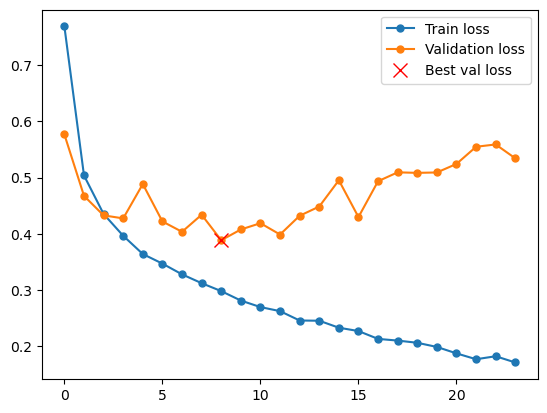

<All keys matched successfully>

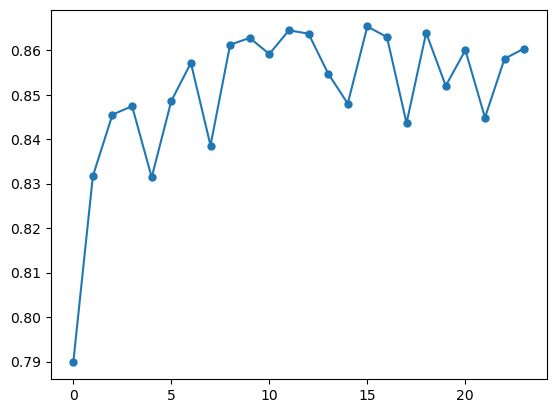

In [280]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ConvModel33(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv4 = nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3)
        self.pool4 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.fco1 = nn.LazyLinear(10)
        self.fco2 = nn.LazyLinear(10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.flatten(start_dim =1)
        x = self.fco1(x)
        #x = x.flatten(start_dim =1)
        x = self.fco2(x)
        return x
    
model33 = ConvModel33().to(device)
optimizer33 = torch.optim.Adam(model33.parameters())
train_more_epochs_es(25,7,model33,loss_fn,optimizer33,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model33.load_state_dict(torch.load(model_path))

Víceméně nedošlo ke změně, zkusím relu aktivační funkci pro první fully connected vrstvu.

c:\Users\Pavel\miniconda3\envs\torchenv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


EPOCH 1:


100%|██████████| 985/985 [00:22<00:00, 42.99it/s]


TRAIN loss: 0.618, VALIDATION loss: 0.465, accuraccy: 0.832
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:22<00:00, 43.20it/s]


TRAIN loss: 0.417, VALIDATION loss: 0.405, accuraccy: 0.849
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:23<00:00, 42.55it/s]


TRAIN loss: 0.356, VALIDATION loss: 0.386, accuraccy: 0.861
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:22<00:00, 43.47it/s]


TRAIN loss: 0.314, VALIDATION loss: 0.389, accuraccy: 0.860
No improvement in this epoch.
EPOCH 5:


100%|██████████| 985/985 [00:22<00:00, 43.56it/s]


TRAIN loss: 0.280, VALIDATION loss: 0.377, accuraccy: 0.873
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:22<00:00, 44.70it/s]


TRAIN loss: 0.255, VALIDATION loss: 0.410, accuraccy: 0.868
No improvement in this epoch.
EPOCH 7:


100%|██████████| 985/985 [00:22<00:00, 44.16it/s]


TRAIN loss: 0.226, VALIDATION loss: 0.394, accuraccy: 0.870
No improvement in this epoch.
EPOCH 8:


100%|██████████| 985/985 [00:22<00:00, 43.69it/s]


TRAIN loss: 0.204, VALIDATION loss: 0.447, accuraccy: 0.855
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:22<00:00, 44.43it/s]


TRAIN loss: 0.187, VALIDATION loss: 0.452, accuraccy: 0.863
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:22<00:00, 43.77it/s]


TRAIN loss: 0.167, VALIDATION loss: 0.472, accuraccy: 0.863
No improvement in this epoch.
EPOCH 11:


100%|██████████| 985/985 [00:22<00:00, 43.66it/s]


TRAIN loss: 0.156, VALIDATION loss: 0.535, accuraccy: 0.859
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:23<00:00, 41.90it/s]


TRAIN loss: 0.139, VALIDATION loss: 0.545, accuraccy: 0.867
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:24<00:00, 40.70it/s]


TRAIN loss: 0.129, VALIDATION loss: 0.606, accuraccy: 0.862
No improvement in this epoch.
Early stopping now


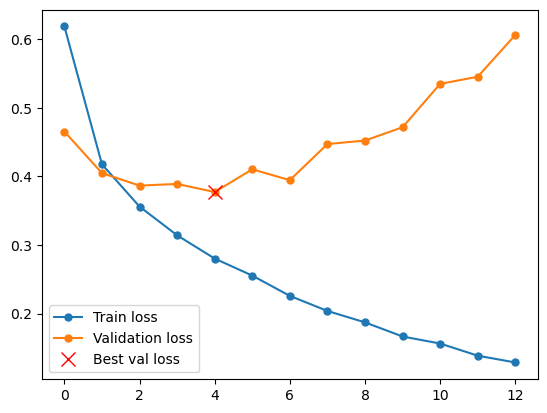

<All keys matched successfully>

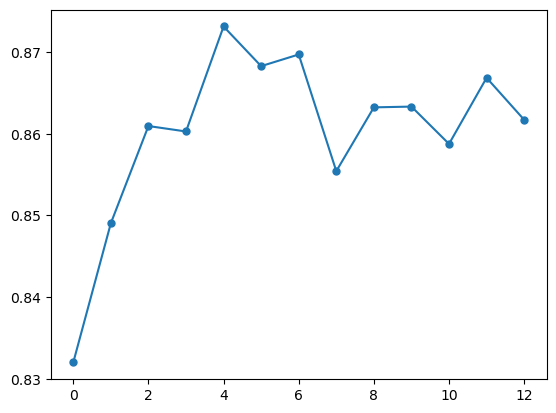

In [285]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ConvModel5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv4 = nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3)
        self.pool4 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.fco1 = nn.LazyLinear(100)
        self.fco2 = nn.LazyLinear(10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.flatten(start_dim =1)
        x = F.relu(self.fco1(x))
        #x = x.flatten(start_dim =1)
        x = (self.fco2(x))
        return x
    
model5 = ConvModel5().to(device)
optimizer5 = torch.optim.Adam(model5.parameters())
train_more_epochs_es(25,7,model5,loss_fn,optimizer5,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model5.load_state_dict(torch.load(model_path))

Očividně to pomohlo, dostávám se na zatím nejvyšší accuracy a o 0.873, zkusím snížit počet neuronů v první fully conected vrstvě.

c:\Users\Pavel\miniconda3\envs\torchenv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


EPOCH 1:


100%|██████████| 985/985 [00:22<00:00, 43.78it/s]


TRAIN loss: 0.655, VALIDATION loss: 0.542, accuraccy: 0.804
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:22<00:00, 43.91it/s]


TRAIN loss: 0.452, VALIDATION loss: 0.459, accuraccy: 0.833
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:22<00:00, 44.19it/s]


TRAIN loss: 0.393, VALIDATION loss: 0.405, accuraccy: 0.850
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:22<00:00, 44.67it/s]


TRAIN loss: 0.356, VALIDATION loss: 0.416, accuraccy: 0.848
No improvement in this epoch.
EPOCH 5:


100%|██████████| 985/985 [00:21<00:00, 44.90it/s]


TRAIN loss: 0.331, VALIDATION loss: 0.406, accuraccy: 0.858
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:21<00:00, 45.42it/s]


TRAIN loss: 0.312, VALIDATION loss: 0.391, accuraccy: 0.862
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:22<00:00, 44.61it/s]


TRAIN loss: 0.290, VALIDATION loss: 0.419, accuraccy: 0.861
No improvement in this epoch.
EPOCH 8:


100%|██████████| 985/985 [00:22<00:00, 44.52it/s]


TRAIN loss: 0.269, VALIDATION loss: 0.419, accuraccy: 0.856
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:22<00:00, 43.95it/s]


TRAIN loss: 0.251, VALIDATION loss: 0.463, accuraccy: 0.850
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:21<00:00, 44.92it/s]


TRAIN loss: 0.241, VALIDATION loss: 0.428, accuraccy: 0.863
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:21<00:00, 45.02it/s]


TRAIN loss: 0.222, VALIDATION loss: 0.460, accuraccy: 0.862
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:21<00:00, 45.62it/s]


TRAIN loss: 0.210, VALIDATION loss: 0.452, accuraccy: 0.869
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:21<00:00, 44.88it/s]


TRAIN loss: 0.202, VALIDATION loss: 0.478, accuraccy: 0.861
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:22<00:00, 44.75it/s]


TRAIN loss: 0.182, VALIDATION loss: 0.571, accuraccy: 0.855
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:23<00:00, 41.39it/s]


TRAIN loss: 0.183, VALIDATION loss: 0.511, accuraccy: 0.858
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:26<00:00, 37.34it/s]


TRAIN loss: 0.170, VALIDATION loss: 0.571, accuraccy: 0.858
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:24<00:00, 40.68it/s]


TRAIN loss: 0.158, VALIDATION loss: 0.578, accuraccy: 0.859
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:21<00:00, 45.14it/s]


TRAIN loss: 0.145, VALIDATION loss: 0.612, accuraccy: 0.850
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:21<00:00, 44.86it/s]


TRAIN loss: 0.145, VALIDATION loss: 0.682, accuraccy: 0.854
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:23<00:00, 42.46it/s]


TRAIN loss: 0.145, VALIDATION loss: 0.665, accuraccy: 0.860
No improvement in this epoch.
Early stopping now


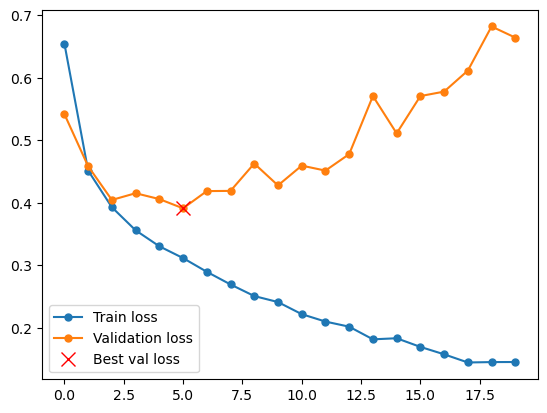

<All keys matched successfully>

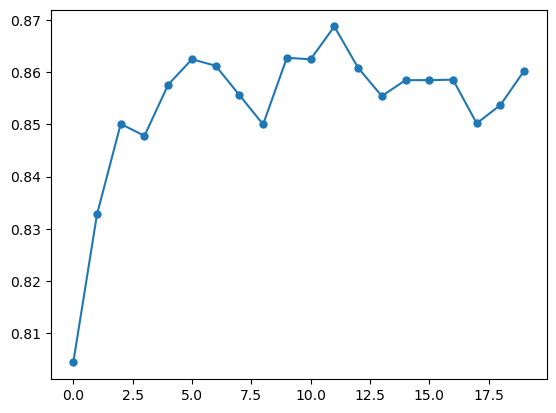

In [286]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ConvModel51(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv4 = nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3)
        self.pool4 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.fco1 = nn.LazyLinear(60)
        self.fco2 = nn.LazyLinear(10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.flatten(start_dim =1)
        x = F.relu(self.fco1(x))
        #x = x.flatten(start_dim =1)
        x = (self.fco2(x))
        return x
    
model51 = ConvModel51().to(device)
optimizer51 = torch.optim.Adam(model51.parameters())
train_more_epochs_es(25,7,model51,loss_fn,optimizer51,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model51.load_state_dict(torch.load(model_path))

Nyní k tom modelu zkusím přidat dropout po každé konvoluční vrstvě, nastavím pravděpodobnost na 0.2

c:\Users\Pavel\miniconda3\envs\torchenv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


EPOCH 1:


100%|██████████| 985/985 [00:22<00:00, 43.35it/s]


TRAIN loss: 0.809, VALIDATION loss: 0.601, accuraccy: 0.797
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:22<00:00, 43.30it/s]


TRAIN loss: 0.524, VALIDATION loss: 0.449, accuraccy: 0.834
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:22<00:00, 43.93it/s]


TRAIN loss: 0.456, VALIDATION loss: 0.424, accuraccy: 0.848
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:23<00:00, 42.44it/s]


TRAIN loss: 0.413, VALIDATION loss: 0.418, accuraccy: 0.851
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:23<00:00, 42.76it/s]


TRAIN loss: 0.393, VALIDATION loss: 0.392, accuraccy: 0.858
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:23<00:00, 42.70it/s]


TRAIN loss: 0.373, VALIDATION loss: 0.414, accuraccy: 0.851
No improvement in this epoch.
EPOCH 7:


100%|██████████| 985/985 [00:23<00:00, 42.14it/s]


TRAIN loss: 0.361, VALIDATION loss: 0.410, accuraccy: 0.854
No improvement in this epoch.
EPOCH 8:


100%|██████████| 985/985 [00:22<00:00, 43.55it/s]


TRAIN loss: 0.350, VALIDATION loss: 0.359, accuraccy: 0.865
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:22<00:00, 43.10it/s]


TRAIN loss: 0.328, VALIDATION loss: 0.441, accuraccy: 0.849
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:23<00:00, 42.13it/s]


TRAIN loss: 0.335, VALIDATION loss: 0.350, accuraccy: 0.872
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:23<00:00, 41.30it/s]


TRAIN loss: 0.324, VALIDATION loss: 0.352, accuraccy: 0.875
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:23<00:00, 41.21it/s]


TRAIN loss: 0.312, VALIDATION loss: 0.368, accuraccy: 0.867
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:23<00:00, 42.81it/s]


TRAIN loss: 0.303, VALIDATION loss: 0.368, accuraccy: 0.870
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:22<00:00, 42.83it/s]


TRAIN loss: 0.304, VALIDATION loss: 0.350, accuraccy: 0.873
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:23<00:00, 42.70it/s]


TRAIN loss: 0.293, VALIDATION loss: 0.367, accuraccy: 0.869
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:23<00:00, 42.22it/s]


TRAIN loss: 0.297, VALIDATION loss: 0.375, accuraccy: 0.859
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:23<00:00, 42.76it/s]


TRAIN loss: 0.288, VALIDATION loss: 0.351, accuraccy: 0.875
Saving best model
EPOCH 18:


100%|██████████| 985/985 [00:23<00:00, 42.67it/s]


TRAIN loss: 0.286, VALIDATION loss: 0.359, accuraccy: 0.876
Saving best model
EPOCH 19:


100%|██████████| 985/985 [00:23<00:00, 42.78it/s]


TRAIN loss: 0.280, VALIDATION loss: 0.347, accuraccy: 0.875
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:22<00:00, 43.02it/s]


TRAIN loss: 0.278, VALIDATION loss: 0.367, accuraccy: 0.868
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:23<00:00, 42.44it/s]


TRAIN loss: 0.278, VALIDATION loss: 0.369, accuraccy: 0.871
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:22<00:00, 42.91it/s]


TRAIN loss: 0.274, VALIDATION loss: 0.371, accuraccy: 0.870
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:22<00:00, 43.13it/s]


TRAIN loss: 0.269, VALIDATION loss: 0.369, accuraccy: 0.869
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:23<00:00, 42.61it/s]


TRAIN loss: 0.265, VALIDATION loss: 0.390, accuraccy: 0.860
No improvement in this epoch.
Early stopping now


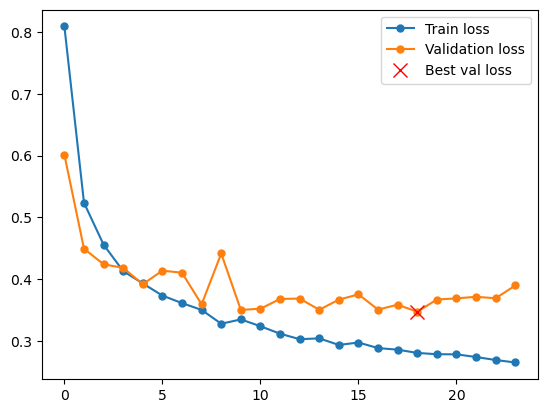

<All keys matched successfully>

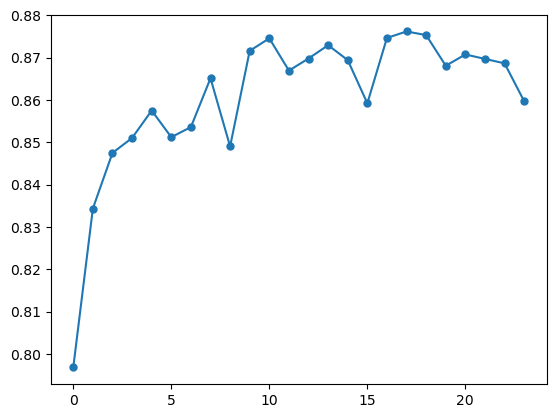

In [288]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ConvModel52(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv4 = nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3)
        self.pool4 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.drop = nn.Dropout(0.2)
        self.fco1 = nn.LazyLinear(64)
        self.fco2 = nn.LazyLinear(10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.drop(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.drop(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.drop(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = self.drop(x)
        x = x.flatten(start_dim =1)
        x = F.relu(self.fco1(x))
        #x = x.flatten(start_dim =1)
        x = (self.fco2(x))
        return x
    
model52 = ConvModel52().to(device)
optimizer52 = torch.optim.Adam(model52.parameters())
train_more_epochs_es(25,5,model52,loss_fn,optimizer52,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model52.load_state_dict(torch.load(model_path))

Přidání dropoutu vylepšilo model, zkusím vyšší dropout 0.25.

c:\Users\Pavel\miniconda3\envs\torchenv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


EPOCH 1:


100%|██████████| 985/985 [00:22<00:00, 43.10it/s]


TRAIN loss: 0.850, VALIDATION loss: 0.627, accuraccy: 0.802
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:22<00:00, 42.97it/s]


TRAIN loss: 0.529, VALIDATION loss: 0.519, accuraccy: 0.831
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:22<00:00, 42.84it/s]


TRAIN loss: 0.470, VALIDATION loss: 0.483, accuraccy: 0.817
No improvement in this epoch.
EPOCH 4:


100%|██████████| 985/985 [00:22<00:00, 43.36it/s]


TRAIN loss: 0.441, VALIDATION loss: 0.436, accuraccy: 0.843
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:22<00:00, 43.54it/s]


TRAIN loss: 0.418, VALIDATION loss: 0.411, accuraccy: 0.854
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:22<00:00, 43.81it/s]


TRAIN loss: 0.400, VALIDATION loss: 0.405, accuraccy: 0.855
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:22<00:00, 43.57it/s]


TRAIN loss: 0.386, VALIDATION loss: 0.394, accuraccy: 0.857
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:22<00:00, 43.20it/s]


TRAIN loss: 0.375, VALIDATION loss: 0.410, accuraccy: 0.856
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:22<00:00, 43.48it/s]


TRAIN loss: 0.365, VALIDATION loss: 0.390, accuraccy: 0.860
Saving best model
EPOCH 10:


100%|██████████| 985/985 [00:23<00:00, 42.68it/s]


TRAIN loss: 0.349, VALIDATION loss: 0.388, accuraccy: 0.858
No improvement in this epoch.
EPOCH 11:


100%|██████████| 985/985 [00:23<00:00, 42.37it/s]


TRAIN loss: 0.344, VALIDATION loss: 0.377, accuraccy: 0.861
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:22<00:00, 43.32it/s]


TRAIN loss: 0.355, VALIDATION loss: 0.372, accuraccy: 0.867
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:22<00:00, 43.60it/s]


TRAIN loss: 0.333, VALIDATION loss: 0.366, accuraccy: 0.867
Saving best model
EPOCH 14:


100%|██████████| 985/985 [00:22<00:00, 43.58it/s]


TRAIN loss: 0.328, VALIDATION loss: 0.387, accuraccy: 0.861
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:22<00:00, 43.73it/s]


TRAIN loss: 0.332, VALIDATION loss: 0.386, accuraccy: 0.854
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:22<00:00, 43.57it/s]


TRAIN loss: 0.316, VALIDATION loss: 0.346, accuraccy: 0.875
Saving best model
EPOCH 17:


100%|██████████| 985/985 [00:22<00:00, 42.99it/s]


TRAIN loss: 0.318, VALIDATION loss: 0.380, accuraccy: 0.861
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:23<00:00, 42.18it/s]


TRAIN loss: 0.316, VALIDATION loss: 0.367, accuraccy: 0.868
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:23<00:00, 41.83it/s]


TRAIN loss: 0.315, VALIDATION loss: 0.375, accuraccy: 0.863
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:23<00:00, 41.96it/s]


TRAIN loss: 0.313, VALIDATION loss: 0.376, accuraccy: 0.863
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:22<00:00, 43.26it/s]


TRAIN loss: 0.301, VALIDATION loss: 0.380, accuraccy: 0.862
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:22<00:00, 42.91it/s]


TRAIN loss: 0.308, VALIDATION loss: 0.370, accuraccy: 0.865
No improvement in this epoch.
Early stopping now


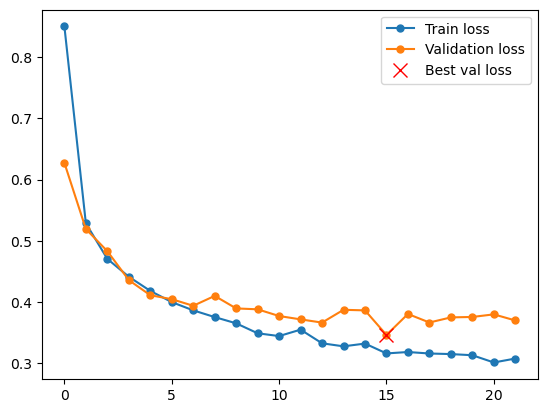

<All keys matched successfully>

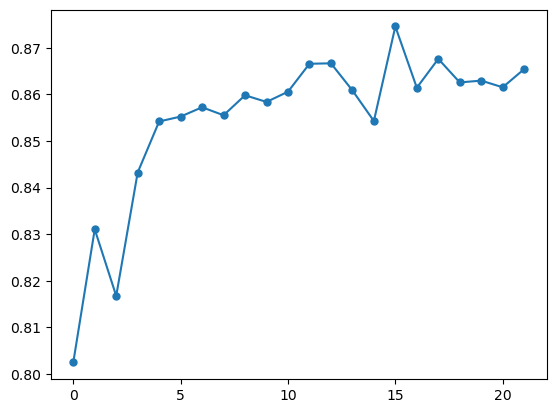

In [320]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ConvModel521(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv4 = nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3)
        self.pool4 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.drop = nn.Dropout(0.25)
        self.fco1 = nn.LazyLinear(64)
        self.fco2 = nn.LazyLinear(10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.drop(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.drop(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.drop(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = self.drop(x)
        x = x.flatten(start_dim =1)
        x = F.relu(self.fco1(x))
        #x = x.flatten(start_dim =1)
        x = (self.fco2(x))
        return x
    
model521 = ConvModel521().to(device)
optimizer521 = torch.optim.Adam(model521.parameters())
train_more_epochs_es(25,5,model521,loss_fn,optimizer521,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model521.load_state_dict(torch.load(model_path))

Dropout 0.25 je lepší, zkusím ještě změnit počet konvolučníh vrstev.

c:\Users\Pavel\miniconda3\envs\torchenv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


EPOCH 1:


100%|██████████| 985/985 [00:22<00:00, 43.40it/s]


TRAIN loss: 1.078, VALIDATION loss: 0.624, accuraccy: 0.774
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:22<00:00, 43.50it/s]


TRAIN loss: 0.583, VALIDATION loss: 0.539, accuraccy: 0.805
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:22<00:00, 43.82it/s]


TRAIN loss: 0.519, VALIDATION loss: 0.489, accuraccy: 0.823
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:22<00:00, 43.82it/s]


TRAIN loss: 0.459, VALIDATION loss: 0.430, accuraccy: 0.841
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:22<00:00, 43.62it/s]


TRAIN loss: 0.409, VALIDATION loss: 0.406, accuraccy: 0.848
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:22<00:00, 43.22it/s]


TRAIN loss: 0.382, VALIDATION loss: 0.395, accuraccy: 0.856
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:22<00:00, 43.35it/s]


TRAIN loss: 0.355, VALIDATION loss: 0.380, accuraccy: 0.860
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:23<00:00, 42.24it/s]


TRAIN loss: 0.331, VALIDATION loss: 0.380, accuraccy: 0.862
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:22<00:00, 43.26it/s]


TRAIN loss: 0.323, VALIDATION loss: 0.369, accuraccy: 0.864
Saving best model
EPOCH 10:


100%|██████████| 985/985 [00:23<00:00, 42.71it/s]


TRAIN loss: 0.307, VALIDATION loss: 0.374, accuraccy: 0.864
No improvement in this epoch.
EPOCH 11:


100%|██████████| 985/985 [00:22<00:00, 43.79it/s]


TRAIN loss: 0.297, VALIDATION loss: 0.377, accuraccy: 0.866
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:22<00:00, 43.72it/s]


TRAIN loss: 0.283, VALIDATION loss: 0.356, accuraccy: 0.875
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:22<00:00, 43.16it/s]


TRAIN loss: 0.272, VALIDATION loss: 0.376, accuraccy: 0.864
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:22<00:00, 43.31it/s]


TRAIN loss: 0.261, VALIDATION loss: 0.369, accuraccy: 0.874
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:22<00:00, 43.16it/s]


TRAIN loss: 0.259, VALIDATION loss: 0.401, accuraccy: 0.859
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:23<00:00, 42.46it/s]


TRAIN loss: 0.248, VALIDATION loss: 0.400, accuraccy: 0.870
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:22<00:00, 43.29it/s]


TRAIN loss: 0.243, VALIDATION loss: 0.368, accuraccy: 0.874
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:23<00:00, 42.42it/s]


TRAIN loss: 0.228, VALIDATION loss: 0.389, accuraccy: 0.870
No improvement in this epoch.
Early stopping now


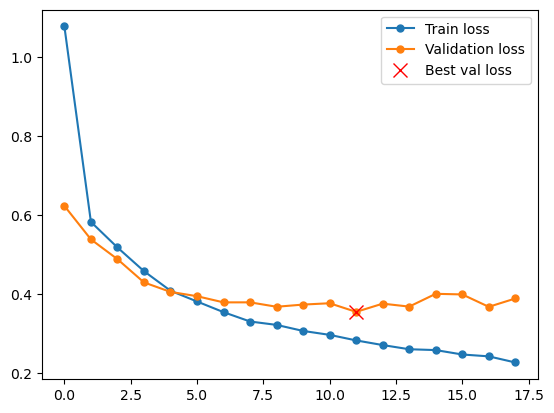

<All keys matched successfully>

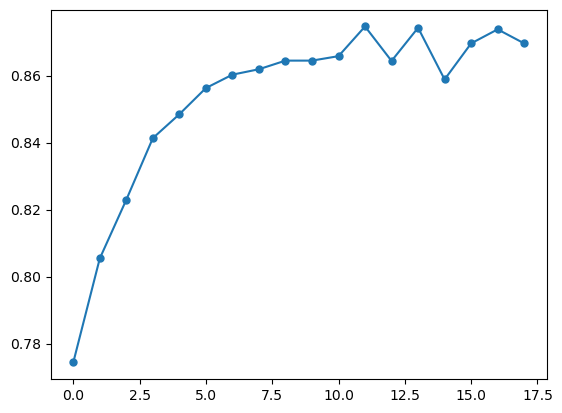

In [322]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ConvModel522(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.drop = nn.Dropout(0.25)
        self.fco1 = nn.LazyLinear(64)
        self.fco2 = nn.LazyLinear(10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.drop(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.drop(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.drop(x)
        x = x.flatten(start_dim =1)
        x = F.relu(self.fco1(x))
        #x = x.flatten(start_dim =1)
        x = (self.fco2(x))
        return x
    
model522 = ConvModel522().to(device)
optimizer522 = torch.optim.Adam(model522.parameters())
train_more_epochs_es(25,5,model522,loss_fn,optimizer522,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model522.load_state_dict(torch.load(model_path))

Accuracy je stále stejná, zkusím změnit kernel na 2 a stride u max poolingu taky na 2.

c:\Users\Pavel\miniconda3\envs\torchenv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


EPOCH 1:


100%|██████████| 985/985 [00:10<00:00, 94.71it/s] 


TRAIN loss: 1.154, VALIDATION loss: 0.691, accuraccy: 0.725
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:10<00:00, 98.09it/s] 


TRAIN loss: 0.716, VALIDATION loss: 0.612, accuraccy: 0.764
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:13<00:00, 71.44it/s]


TRAIN loss: 0.639, VALIDATION loss: 0.545, accuraccy: 0.788
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:10<00:00, 93.05it/s] 


TRAIN loss: 0.585, VALIDATION loss: 0.512, accuraccy: 0.807
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:10<00:00, 89.95it/s] 


TRAIN loss: 0.552, VALIDATION loss: 0.472, accuraccy: 0.826
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:11<00:00, 85.28it/s] 


TRAIN loss: 0.516, VALIDATION loss: 0.443, accuraccy: 0.836
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:10<00:00, 89.76it/s] 


TRAIN loss: 0.497, VALIDATION loss: 0.426, accuraccy: 0.845
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:10<00:00, 95.66it/s] 


TRAIN loss: 0.478, VALIDATION loss: 0.397, accuraccy: 0.854
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:11<00:00, 84.27it/s] 


TRAIN loss: 0.467, VALIDATION loss: 0.399, accuraccy: 0.851
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:10<00:00, 94.99it/s] 


TRAIN loss: 0.457, VALIDATION loss: 0.381, accuraccy: 0.860
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:09<00:00, 99.32it/s] 


TRAIN loss: 0.451, VALIDATION loss: 0.391, accuraccy: 0.862
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:10<00:00, 97.08it/s] 


TRAIN loss: 0.434, VALIDATION loss: 0.362, accuraccy: 0.871
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:11<00:00, 89.51it/s] 


TRAIN loss: 0.430, VALIDATION loss: 0.368, accuraccy: 0.865
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:10<00:00, 91.44it/s] 


TRAIN loss: 0.429, VALIDATION loss: 0.365, accuraccy: 0.866
No improvement in this epoch.
EPOCH 15:


100%|██████████| 985/985 [00:10<00:00, 95.49it/s] 


TRAIN loss: 0.418, VALIDATION loss: 0.381, accuraccy: 0.857
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:09<00:00, 98.66it/s] 


TRAIN loss: 0.418, VALIDATION loss: 0.349, accuraccy: 0.874
Saving best model
EPOCH 17:


100%|██████████| 985/985 [00:09<00:00, 99.36it/s] 


TRAIN loss: 0.406, VALIDATION loss: 0.357, accuraccy: 0.872
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:10<00:00, 97.62it/s] 


TRAIN loss: 0.404, VALIDATION loss: 0.359, accuraccy: 0.865
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:13<00:00, 70.44it/s] 


TRAIN loss: 0.402, VALIDATION loss: 0.373, accuraccy: 0.858
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:10<00:00, 92.76it/s] 


TRAIN loss: 0.403, VALIDATION loss: 0.363, accuraccy: 0.872
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:10<00:00, 96.96it/s] 


TRAIN loss: 0.402, VALIDATION loss: 0.346, accuraccy: 0.872
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:09<00:00, 106.18it/s]


TRAIN loss: 0.397, VALIDATION loss: 0.378, accuraccy: 0.859
No improvement in this epoch.
Early stopping now


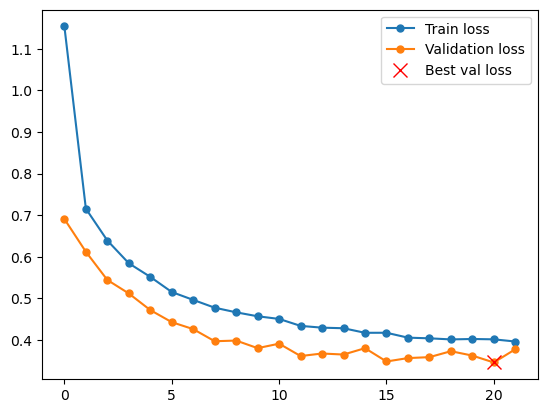

<All keys matched successfully>

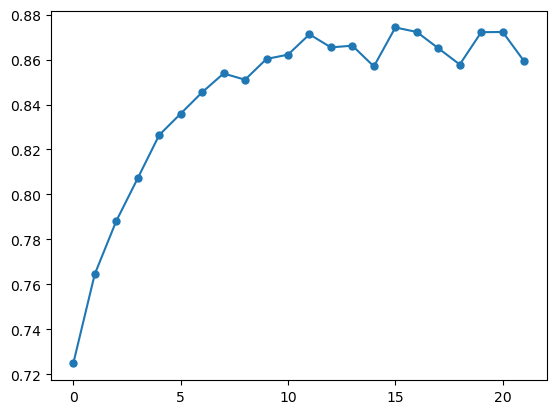

In [323]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ConvModel5221(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=32,kernel_size=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.drop = nn.Dropout(0.25)
        self.fco1 = nn.LazyLinear(64)
        self.fco2 = nn.LazyLinear(10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.drop(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.drop(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.drop(x)
        x = x.flatten(start_dim =1)
        x = F.relu(self.fco1(x))
        #x = x.flatten(start_dim =1)
        x = (self.fco2(x))
        return x
    
model5221 = ConvModel5221().to(device)
optimizer5221 = torch.optim.Adam(model5221.parameters())
train_more_epochs_es(25,5,model5221,loss_fn,optimizer5221,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model5221.load_state_dict(torch.load(model_path))

Stále dostávám více méně stejnou accuracy, zkusím tedy ještě změnit počet kanálů - zvětším poslední konvoluční vrtvu.

c:\Users\Pavel\miniconda3\envs\torchenv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


EPOCH 1:


100%|██████████| 985/985 [00:09<00:00, 109.14it/s]


TRAIN loss: 0.980, VALIDATION loss: 0.650, accuraccy: 0.747
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:09<00:00, 107.58it/s]


TRAIN loss: 0.631, VALIDATION loss: 0.538, accuraccy: 0.805
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:09<00:00, 101.08it/s]


TRAIN loss: 0.561, VALIDATION loss: 0.543, accuraccy: 0.790
No improvement in this epoch.
EPOCH 4:


100%|██████████| 985/985 [00:08<00:00, 122.17it/s]


TRAIN loss: 0.517, VALIDATION loss: 0.444, accuraccy: 0.846
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:08<00:00, 121.42it/s]


TRAIN loss: 0.484, VALIDATION loss: 0.416, accuraccy: 0.851
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:08<00:00, 113.99it/s]


TRAIN loss: 0.465, VALIDATION loss: 0.392, accuraccy: 0.861
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:08<00:00, 115.49it/s]


TRAIN loss: 0.442, VALIDATION loss: 0.394, accuraccy: 0.860
No improvement in this epoch.
EPOCH 8:


100%|██████████| 985/985 [00:09<00:00, 100.88it/s]


TRAIN loss: 0.435, VALIDATION loss: 0.372, accuraccy: 0.863
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:08<00:00, 111.60it/s]


TRAIN loss: 0.423, VALIDATION loss: 0.379, accuraccy: 0.860
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:08<00:00, 116.89it/s]


TRAIN loss: 0.412, VALIDATION loss: 0.356, accuraccy: 0.872
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:07<00:00, 123.39it/s]


TRAIN loss: 0.410, VALIDATION loss: 0.354, accuraccy: 0.872
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:08<00:00, 123.12it/s]


TRAIN loss: 0.398, VALIDATION loss: 0.344, accuraccy: 0.872
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:08<00:00, 118.15it/s]


TRAIN loss: 0.393, VALIDATION loss: 0.351, accuraccy: 0.870
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:09<00:00, 101.85it/s]


TRAIN loss: 0.388, VALIDATION loss: 0.339, accuraccy: 0.878
Saving best model
EPOCH 15:


100%|██████████| 985/985 [00:08<00:00, 118.25it/s]


TRAIN loss: 0.390, VALIDATION loss: 0.379, accuraccy: 0.859
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:07<00:00, 126.20it/s]


TRAIN loss: 0.388, VALIDATION loss: 0.339, accuraccy: 0.876
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:08<00:00, 119.49it/s]


TRAIN loss: 0.378, VALIDATION loss: 0.339, accuraccy: 0.876
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:08<00:00, 120.70it/s]


TRAIN loss: 0.378, VALIDATION loss: 0.353, accuraccy: 0.874
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:07<00:00, 125.14it/s]


TRAIN loss: 0.371, VALIDATION loss: 0.349, accuraccy: 0.871
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:07<00:00, 124.94it/s]


TRAIN loss: 0.377, VALIDATION loss: 0.353, accuraccy: 0.869
No improvement in this epoch.
Early stopping now


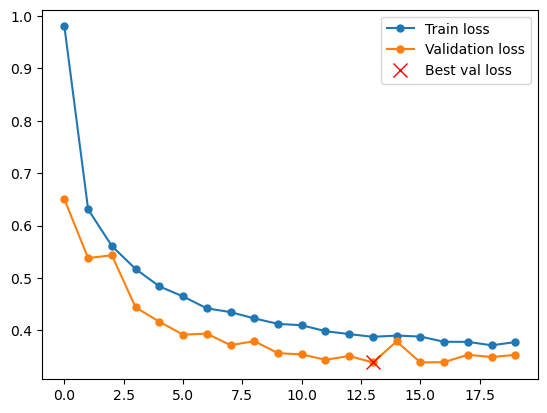

<All keys matched successfully>

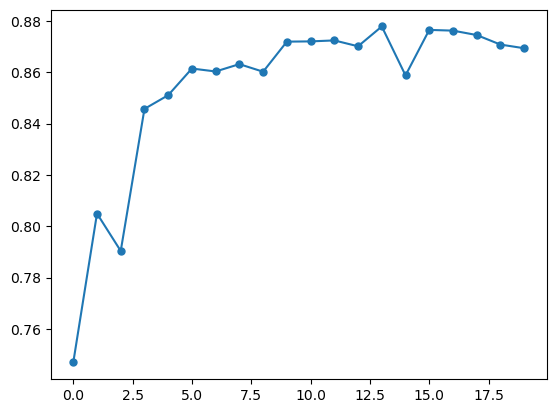

In [324]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ConvModel5221a(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.drop = nn.Dropout(0.25)
        self.fco1 = nn.LazyLinear(64)
        self.fco2 = nn.LazyLinear(10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.drop(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.drop(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.drop(x)
        x = x.flatten(start_dim =1)
        x = F.relu(self.fco1(x))
        #x = x.flatten(start_dim =1)
        x = (self.fco2(x))
        return x
    
model5221a = ConvModel5221a().to(device)
optimizer5221a = torch.optim.Adam(model5221a.parameters())
train_more_epochs_es(25,5,model5221a,loss_fn,optimizer5221a,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model5221a.load_state_dict(torch.load(model_path))

To očividně pomohlo! Nechám tedy tohle nastavení hyperparametrů a přidám dropout po první fully connected vrstě.

c:\Users\Pavel\miniconda3\envs\torchenv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


EPOCH 1:


100%|█████████▉| 982/985 [00:07<00:00, 124.37it/s]c:\Users\Pavel\miniconda3\envs\torchenv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 985/985 [00:07<00:00, 132.22it/s]


TRAIN loss: 0.925, VALIDATION loss: 0.566, accuraccy: 0.774
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:08<00:00, 121.37it/s]


TRAIN loss: 0.643, VALIDATION loss: 0.500, accuraccy: 0.803
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:08<00:00, 109.98it/s]


TRAIN loss: 0.572, VALIDATION loss: 0.447, accuraccy: 0.835
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:08<00:00, 122.65it/s]


TRAIN loss: 0.534, VALIDATION loss: 0.441, accuraccy: 0.839
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:07<00:00, 140.28it/s]


TRAIN loss: 0.500, VALIDATION loss: 0.443, accuraccy: 0.833
No improvement in this epoch.
EPOCH 6:


100%|██████████| 985/985 [00:07<00:00, 135.38it/s]


TRAIN loss: 0.490, VALIDATION loss: 0.405, accuraccy: 0.847
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:07<00:00, 131.32it/s]


TRAIN loss: 0.473, VALIDATION loss: 0.382, accuraccy: 0.859
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:07<00:00, 139.51it/s]


TRAIN loss: 0.465, VALIDATION loss: 0.362, accuraccy: 0.868
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:06<00:00, 142.66it/s]


TRAIN loss: 0.450, VALIDATION loss: 0.369, accuraccy: 0.862
No improvement in this epoch.
EPOCH 10:


100%|██████████| 985/985 [00:07<00:00, 134.27it/s]


TRAIN loss: 0.442, VALIDATION loss: 0.388, accuraccy: 0.856
No improvement in this epoch.
EPOCH 11:


100%|██████████| 985/985 [00:07<00:00, 137.10it/s]


TRAIN loss: 0.431, VALIDATION loss: 0.351, accuraccy: 0.872
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:08<00:00, 120.53it/s]


TRAIN loss: 0.417, VALIDATION loss: 0.347, accuraccy: 0.870
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:06<00:00, 140.87it/s]


TRAIN loss: 0.416, VALIDATION loss: 0.349, accuraccy: 0.871
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:07<00:00, 137.77it/s]


TRAIN loss: 0.412, VALIDATION loss: 0.342, accuraccy: 0.875
Saving best model
EPOCH 15:


100%|██████████| 985/985 [00:07<00:00, 132.30it/s]


TRAIN loss: 0.401, VALIDATION loss: 0.337, accuraccy: 0.876
Saving best model
EPOCH 16:


100%|██████████| 985/985 [00:07<00:00, 137.22it/s]


TRAIN loss: 0.396, VALIDATION loss: 0.378, accuraccy: 0.851
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:07<00:00, 129.96it/s]


TRAIN loss: 0.391, VALIDATION loss: 0.325, accuraccy: 0.879
Saving best model
EPOCH 18:


100%|██████████| 985/985 [00:07<00:00, 139.09it/s]


TRAIN loss: 0.388, VALIDATION loss: 0.323, accuraccy: 0.879
Saving best model
EPOCH 19:


100%|██████████| 985/985 [00:07<00:00, 124.34it/s]


TRAIN loss: 0.393, VALIDATION loss: 0.338, accuraccy: 0.875
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:08<00:00, 114.14it/s]


TRAIN loss: 0.381, VALIDATION loss: 0.368, accuraccy: 0.861
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:07<00:00, 137.27it/s]


TRAIN loss: 0.379, VALIDATION loss: 0.340, accuraccy: 0.869
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:07<00:00, 139.71it/s]


TRAIN loss: 0.378, VALIDATION loss: 0.319, accuraccy: 0.879
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:07<00:00, 131.28it/s]


TRAIN loss: 0.370, VALIDATION loss: 0.329, accuraccy: 0.877
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:07<00:00, 131.86it/s]


TRAIN loss: 0.369, VALIDATION loss: 0.321, accuraccy: 0.880
Saving best model
EPOCH 25:


100%|██████████| 985/985 [00:07<00:00, 133.03it/s]


TRAIN loss: 0.365, VALIDATION loss: 0.326, accuraccy: 0.877
No improvement in this epoch.


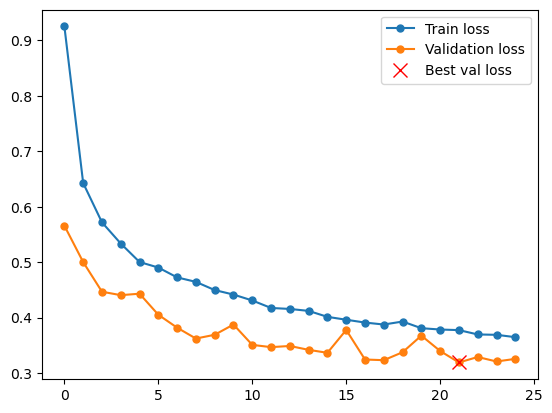

<All keys matched successfully>

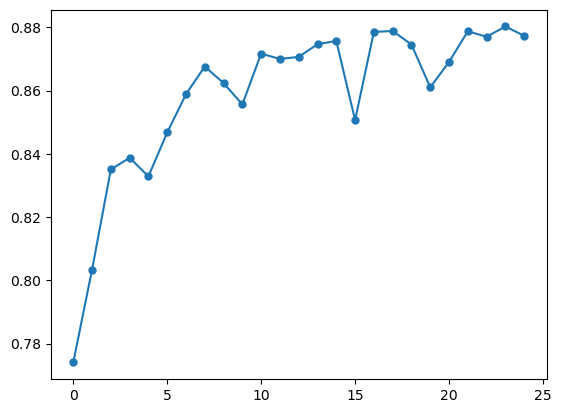

In [296]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ConvModel53(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.25)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(p=0.25)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2)
        self.dropout3 = nn.Dropout(p=0.25)
        self.fc1 = nn.LazyLinear(64)
        self.dropout4 = nn.Dropout(p=0.2)
        self.fc2 = nn.LazyLinear(10)  # Output classes

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = F.relu(self.conv3(x))
        x = self.dropout3(x)
        x = x.flatten(start_dim =1)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x
    
model53 = ConvModel53().to(device)
optimizer53 = torch.optim.Adam(model53.parameters())
train_more_epochs_es(25,5,model53,loss_fn,optimizer53,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model53.load_state_dict(torch.load(model_path))

Dostávám zatím nejvyšší accuray! Pustím model znova, tentokrát na více epoch.

c:\Users\Pavel\miniconda3\envs\torchenv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


EPOCH 1:


100%|██████████| 985/985 [00:07<00:00, 134.43it/s]


TRAIN loss: 0.918, VALIDATION loss: 0.599, accuraccy: 0.755
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:07<00:00, 123.45it/s]


TRAIN loss: 0.652, VALIDATION loss: 0.516, accuraccy: 0.804
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:07<00:00, 132.64it/s]


TRAIN loss: 0.582, VALIDATION loss: 0.458, accuraccy: 0.832
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:07<00:00, 132.52it/s]


TRAIN loss: 0.542, VALIDATION loss: 0.415, accuraccy: 0.849
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:07<00:00, 129.57it/s]


TRAIN loss: 0.504, VALIDATION loss: 0.413, accuraccy: 0.844
No improvement in this epoch.
EPOCH 6:


100%|██████████| 985/985 [00:07<00:00, 133.16it/s]


TRAIN loss: 0.492, VALIDATION loss: 0.384, accuraccy: 0.862
Saving best model
EPOCH 7:


100%|██████████| 985/985 [00:07<00:00, 130.77it/s]


TRAIN loss: 0.474, VALIDATION loss: 0.378, accuraccy: 0.864
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:08<00:00, 114.63it/s]


TRAIN loss: 0.461, VALIDATION loss: 0.378, accuraccy: 0.865
Saving best model
EPOCH 9:


100%|██████████| 985/985 [00:07<00:00, 131.03it/s]


TRAIN loss: 0.442, VALIDATION loss: 0.372, accuraccy: 0.866
Saving best model
EPOCH 10:


100%|██████████| 985/985 [00:07<00:00, 123.88it/s]


TRAIN loss: 0.435, VALIDATION loss: 0.369, accuraccy: 0.865
No improvement in this epoch.
EPOCH 11:


100%|██████████| 985/985 [00:07<00:00, 129.29it/s]


TRAIN loss: 0.436, VALIDATION loss: 0.372, accuraccy: 0.863
No improvement in this epoch.
EPOCH 12:


100%|██████████| 985/985 [00:07<00:00, 134.55it/s]


TRAIN loss: 0.427, VALIDATION loss: 0.359, accuraccy: 0.863
No improvement in this epoch.
EPOCH 13:


100%|██████████| 985/985 [00:07<00:00, 129.64it/s]


TRAIN loss: 0.420, VALIDATION loss: 0.372, accuraccy: 0.865
No improvement in this epoch.
EPOCH 14:


100%|██████████| 985/985 [00:07<00:00, 135.61it/s]


TRAIN loss: 0.414, VALIDATION loss: 0.351, accuraccy: 0.874
Saving best model
EPOCH 15:


100%|██████████| 985/985 [00:08<00:00, 119.31it/s]


TRAIN loss: 0.409, VALIDATION loss: 0.338, accuraccy: 0.874
Saving best model
EPOCH 16:


100%|██████████| 985/985 [00:07<00:00, 133.22it/s]


TRAIN loss: 0.404, VALIDATION loss: 0.352, accuraccy: 0.863
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:08<00:00, 123.07it/s]


TRAIN loss: 0.405, VALIDATION loss: 0.375, accuraccy: 0.858
No improvement in this epoch.
EPOCH 18:


100%|██████████| 985/985 [00:07<00:00, 129.27it/s]


TRAIN loss: 0.401, VALIDATION loss: 0.339, accuraccy: 0.870
No improvement in this epoch.
EPOCH 19:


100%|██████████| 985/985 [00:07<00:00, 132.54it/s]


TRAIN loss: 0.392, VALIDATION loss: 0.330, accuraccy: 0.873
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:07<00:00, 131.92it/s]


TRAIN loss: 0.390, VALIDATION loss: 0.346, accuraccy: 0.870
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:07<00:00, 135.76it/s]


TRAIN loss: 0.384, VALIDATION loss: 0.335, accuraccy: 0.876
Saving best model
EPOCH 22:


100%|██████████| 985/985 [00:07<00:00, 133.17it/s]


TRAIN loss: 0.382, VALIDATION loss: 0.327, accuraccy: 0.880
Saving best model
EPOCH 23:


100%|██████████| 985/985 [00:08<00:00, 122.33it/s]


TRAIN loss: 0.381, VALIDATION loss: 0.346, accuraccy: 0.874
No improvement in this epoch.
EPOCH 24:


100%|██████████| 985/985 [00:07<00:00, 131.66it/s]


TRAIN loss: 0.380, VALIDATION loss: 0.321, accuraccy: 0.883
Saving best model
EPOCH 25:


100%|██████████| 985/985 [00:07<00:00, 128.53it/s]


TRAIN loss: 0.378, VALIDATION loss: 0.338, accuraccy: 0.873
No improvement in this epoch.
EPOCH 26:


100%|██████████| 985/985 [00:07<00:00, 131.44it/s]


TRAIN loss: 0.368, VALIDATION loss: 0.332, accuraccy: 0.876
No improvement in this epoch.
EPOCH 27:


100%|██████████| 985/985 [00:07<00:00, 127.10it/s]


TRAIN loss: 0.368, VALIDATION loss: 0.328, accuraccy: 0.878
No improvement in this epoch.
EPOCH 28:


100%|██████████| 985/985 [00:07<00:00, 127.24it/s]


TRAIN loss: 0.370, VALIDATION loss: 0.331, accuraccy: 0.878
No improvement in this epoch.
EPOCH 29:


100%|██████████| 985/985 [00:07<00:00, 126.27it/s]


TRAIN loss: 0.369, VALIDATION loss: 0.338, accuraccy: 0.877
No improvement in this epoch.
EPOCH 30:


100%|██████████| 985/985 [00:07<00:00, 129.15it/s]


TRAIN loss: 0.367, VALIDATION loss: 0.331, accuraccy: 0.880
No improvement in this epoch.
EPOCH 31:


100%|██████████| 985/985 [00:07<00:00, 128.30it/s]


TRAIN loss: 0.371, VALIDATION loss: 0.346, accuraccy: 0.871
No improvement in this epoch.
EPOCH 32:


100%|██████████| 985/985 [00:07<00:00, 123.78it/s]


TRAIN loss: 0.361, VALIDATION loss: 0.318, accuraccy: 0.882
No improvement in this epoch.
Early stopping now


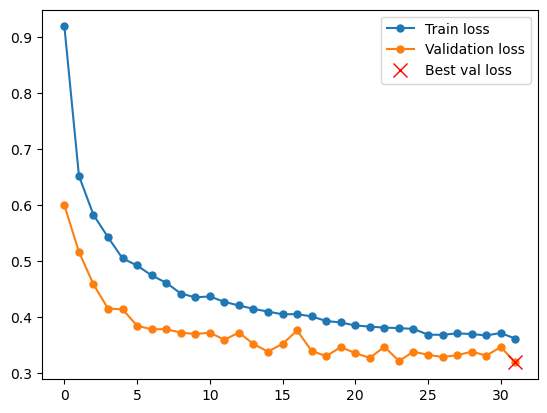

<All keys matched successfully>

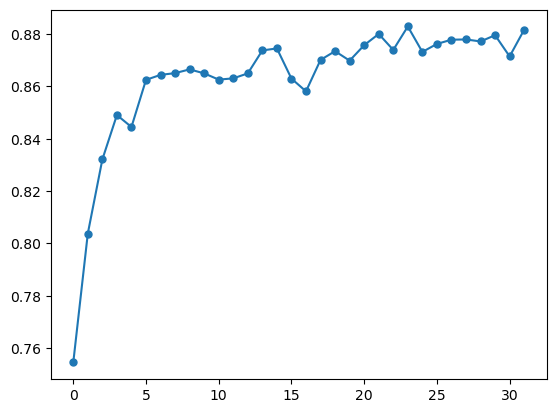

In [297]:
model53a = ConvModel53().to(device)
optimizer53a = torch.optim.Adam(model53a.parameters())
train_more_epochs_es(50,7,model53a,loss_fn,optimizer53a,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model53a.load_state_dict(torch.load(model_path))

Dostávám se na njvýše na accuracy 0.883, tento nejlepší model nechám natrénovt na 100 epochách.

c:\Users\Pavel\miniconda3\envs\torchenv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


EPOCH 1:


100%|██████████| 985/985 [00:07<00:00, 131.35it/s]


TRAIN loss: 0.925, VALIDATION loss: 0.617, accuraccy: 0.757
Saving best model
EPOCH 2:


100%|██████████| 985/985 [00:07<00:00, 131.86it/s]


TRAIN loss: 0.660, VALIDATION loss: 0.525, accuraccy: 0.798
Saving best model
EPOCH 3:


100%|██████████| 985/985 [00:07<00:00, 135.00it/s]


TRAIN loss: 0.590, VALIDATION loss: 0.492, accuraccy: 0.809
Saving best model
EPOCH 4:


100%|██████████| 985/985 [00:08<00:00, 117.89it/s]


TRAIN loss: 0.549, VALIDATION loss: 0.444, accuraccy: 0.834
Saving best model
EPOCH 5:


100%|██████████| 985/985 [00:08<00:00, 122.74it/s]


TRAIN loss: 0.524, VALIDATION loss: 0.427, accuraccy: 0.850
Saving best model
EPOCH 6:


100%|██████████| 985/985 [00:08<00:00, 114.88it/s]


TRAIN loss: 0.500, VALIDATION loss: 0.415, accuraccy: 0.848
No improvement in this epoch.
EPOCH 7:


100%|██████████| 985/985 [00:07<00:00, 125.95it/s]


TRAIN loss: 0.489, VALIDATION loss: 0.398, accuraccy: 0.852
Saving best model
EPOCH 8:


100%|██████████| 985/985 [00:07<00:00, 127.34it/s]


TRAIN loss: 0.466, VALIDATION loss: 0.399, accuraccy: 0.846
No improvement in this epoch.
EPOCH 9:


100%|██████████| 985/985 [00:07<00:00, 123.33it/s]


TRAIN loss: 0.456, VALIDATION loss: 0.384, accuraccy: 0.855
Saving best model
EPOCH 10:


100%|██████████| 985/985 [00:07<00:00, 133.37it/s]


TRAIN loss: 0.441, VALIDATION loss: 0.371, accuraccy: 0.861
Saving best model
EPOCH 11:


100%|██████████| 985/985 [00:07<00:00, 129.97it/s]


TRAIN loss: 0.429, VALIDATION loss: 0.367, accuraccy: 0.863
Saving best model
EPOCH 12:


100%|██████████| 985/985 [00:07<00:00, 133.74it/s]


TRAIN loss: 0.427, VALIDATION loss: 0.361, accuraccy: 0.869
Saving best model
EPOCH 13:


100%|██████████| 985/985 [00:07<00:00, 124.78it/s]


TRAIN loss: 0.413, VALIDATION loss: 0.352, accuraccy: 0.870
Saving best model
EPOCH 14:


100%|██████████| 985/985 [00:08<00:00, 113.18it/s]


TRAIN loss: 0.411, VALIDATION loss: 0.350, accuraccy: 0.871
Saving best model
EPOCH 15:


100%|██████████| 985/985 [00:07<00:00, 134.38it/s]


TRAIN loss: 0.400, VALIDATION loss: 0.366, accuraccy: 0.866
No improvement in this epoch.
EPOCH 16:


100%|██████████| 985/985 [00:07<00:00, 133.01it/s]


TRAIN loss: 0.398, VALIDATION loss: 0.354, accuraccy: 0.866
No improvement in this epoch.
EPOCH 17:


100%|██████████| 985/985 [00:07<00:00, 125.02it/s]


TRAIN loss: 0.394, VALIDATION loss: 0.331, accuraccy: 0.877
Saving best model
EPOCH 18:


100%|██████████| 985/985 [00:07<00:00, 131.06it/s]


TRAIN loss: 0.384, VALIDATION loss: 0.335, accuraccy: 0.877
Saving best model
EPOCH 19:


100%|██████████| 985/985 [00:07<00:00, 126.21it/s]


TRAIN loss: 0.385, VALIDATION loss: 0.340, accuraccy: 0.876
No improvement in this epoch.
EPOCH 20:


100%|██████████| 985/985 [00:07<00:00, 132.42it/s]


TRAIN loss: 0.377, VALIDATION loss: 0.340, accuraccy: 0.872
No improvement in this epoch.
EPOCH 21:


100%|██████████| 985/985 [00:08<00:00, 116.34it/s]


TRAIN loss: 0.374, VALIDATION loss: 0.345, accuraccy: 0.871
No improvement in this epoch.
EPOCH 22:


100%|██████████| 985/985 [00:07<00:00, 126.52it/s]


TRAIN loss: 0.376, VALIDATION loss: 0.342, accuraccy: 0.874
No improvement in this epoch.
EPOCH 23:


100%|██████████| 985/985 [00:07<00:00, 136.81it/s]


TRAIN loss: 0.374, VALIDATION loss: 0.336, accuraccy: 0.880
Saving best model
EPOCH 24:


100%|██████████| 985/985 [00:08<00:00, 114.74it/s]


TRAIN loss: 0.367, VALIDATION loss: 0.340, accuraccy: 0.876
No improvement in this epoch.
EPOCH 25:


100%|██████████| 985/985 [00:07<00:00, 133.19it/s]


TRAIN loss: 0.371, VALIDATION loss: 0.351, accuraccy: 0.875
No improvement in this epoch.
EPOCH 26:


100%|██████████| 985/985 [00:07<00:00, 136.03it/s]


TRAIN loss: 0.357, VALIDATION loss: 0.327, accuraccy: 0.879
No improvement in this epoch.
EPOCH 27:


100%|██████████| 985/985 [00:07<00:00, 129.97it/s]


TRAIN loss: 0.362, VALIDATION loss: 0.352, accuraccy: 0.861
No improvement in this epoch.
EPOCH 28:


100%|██████████| 985/985 [00:07<00:00, 130.39it/s]


TRAIN loss: 0.364, VALIDATION loss: 0.324, accuraccy: 0.877
No improvement in this epoch.
EPOCH 29:


100%|██████████| 985/985 [00:07<00:00, 124.28it/s]


TRAIN loss: 0.357, VALIDATION loss: 0.325, accuraccy: 0.883
Saving best model
EPOCH 30:


100%|██████████| 985/985 [00:07<00:00, 130.28it/s]


TRAIN loss: 0.354, VALIDATION loss: 0.319, accuraccy: 0.882
No improvement in this epoch.
EPOCH 31:


100%|██████████| 985/985 [00:07<00:00, 137.22it/s]


TRAIN loss: 0.355, VALIDATION loss: 0.333, accuraccy: 0.870
No improvement in this epoch.
EPOCH 32:


100%|██████████| 985/985 [00:07<00:00, 136.56it/s]


TRAIN loss: 0.355, VALIDATION loss: 0.322, accuraccy: 0.880
No improvement in this epoch.
EPOCH 33:


100%|██████████| 985/985 [00:07<00:00, 131.92it/s]


TRAIN loss: 0.359, VALIDATION loss: 0.317, accuraccy: 0.884
Saving best model
EPOCH 34:


100%|██████████| 985/985 [00:07<00:00, 138.59it/s]


TRAIN loss: 0.356, VALIDATION loss: 0.326, accuraccy: 0.881
No improvement in this epoch.
EPOCH 35:


100%|██████████| 985/985 [00:07<00:00, 136.56it/s]


TRAIN loss: 0.349, VALIDATION loss: 0.327, accuraccy: 0.878
No improvement in this epoch.
EPOCH 36:


100%|██████████| 985/985 [00:08<00:00, 120.51it/s]


TRAIN loss: 0.342, VALIDATION loss: 0.333, accuraccy: 0.877
No improvement in this epoch.
EPOCH 37:


100%|██████████| 985/985 [00:07<00:00, 133.12it/s]


TRAIN loss: 0.346, VALIDATION loss: 0.318, accuraccy: 0.882
No improvement in this epoch.
EPOCH 38:


100%|██████████| 985/985 [00:07<00:00, 128.89it/s]


TRAIN loss: 0.345, VALIDATION loss: 0.329, accuraccy: 0.878
No improvement in this epoch.
EPOCH 39:


100%|██████████| 985/985 [00:07<00:00, 138.39it/s]


TRAIN loss: 0.345, VALIDATION loss: 0.317, accuraccy: 0.881
No improvement in this epoch.
EPOCH 40:


100%|██████████| 985/985 [00:07<00:00, 136.16it/s]


TRAIN loss: 0.343, VALIDATION loss: 0.316, accuraccy: 0.882
No improvement in this epoch.
EPOCH 41:


100%|██████████| 985/985 [00:07<00:00, 131.00it/s]


TRAIN loss: 0.339, VALIDATION loss: 0.326, accuraccy: 0.881
No improvement in this epoch.
EPOCH 42:


100%|██████████| 985/985 [00:07<00:00, 136.67it/s]


TRAIN loss: 0.340, VALIDATION loss: 0.324, accuraccy: 0.880
No improvement in this epoch.
EPOCH 43:


100%|██████████| 985/985 [00:07<00:00, 137.08it/s]


TRAIN loss: 0.347, VALIDATION loss: 0.322, accuraccy: 0.877
No improvement in this epoch.
EPOCH 44:


100%|██████████| 985/985 [00:08<00:00, 121.01it/s]


TRAIN loss: 0.340, VALIDATION loss: 0.320, accuraccy: 0.883
No improvement in this epoch.
EPOCH 45:


100%|██████████| 985/985 [00:07<00:00, 136.98it/s]


TRAIN loss: 0.340, VALIDATION loss: 0.327, accuraccy: 0.880
No improvement in this epoch.
EPOCH 46:


100%|██████████| 985/985 [00:07<00:00, 128.43it/s]


TRAIN loss: 0.335, VALIDATION loss: 0.307, accuraccy: 0.888
Saving best model
EPOCH 47:


100%|██████████| 985/985 [00:07<00:00, 127.34it/s]


TRAIN loss: 0.331, VALIDATION loss: 0.311, accuraccy: 0.886
No improvement in this epoch.
EPOCH 48:


100%|██████████| 985/985 [00:07<00:00, 136.47it/s]


TRAIN loss: 0.335, VALIDATION loss: 0.321, accuraccy: 0.883
No improvement in this epoch.
EPOCH 49:


100%|██████████| 985/985 [00:07<00:00, 137.91it/s]


TRAIN loss: 0.333, VALIDATION loss: 0.334, accuraccy: 0.877
No improvement in this epoch.
EPOCH 50:


100%|██████████| 985/985 [00:07<00:00, 129.90it/s]


TRAIN loss: 0.332, VALIDATION loss: 0.322, accuraccy: 0.884
No improvement in this epoch.
EPOCH 51:


100%|██████████| 985/985 [00:07<00:00, 127.16it/s]


TRAIN loss: 0.328, VALIDATION loss: 0.331, accuraccy: 0.882
No improvement in this epoch.
EPOCH 52:


100%|██████████| 985/985 [00:07<00:00, 132.19it/s]


TRAIN loss: 0.326, VALIDATION loss: 0.318, accuraccy: 0.884
No improvement in this epoch.
EPOCH 53:


100%|██████████| 985/985 [00:07<00:00, 130.89it/s]


TRAIN loss: 0.331, VALIDATION loss: 0.320, accuraccy: 0.886
No improvement in this epoch.
EPOCH 54:


100%|██████████| 985/985 [00:07<00:00, 128.39it/s]


TRAIN loss: 0.326, VALIDATION loss: 0.325, accuraccy: 0.885
No improvement in this epoch.
EPOCH 55:


100%|██████████| 985/985 [00:07<00:00, 127.95it/s]


TRAIN loss: 0.330, VALIDATION loss: 0.313, accuraccy: 0.889
Saving best model
EPOCH 56:


100%|██████████| 985/985 [00:07<00:00, 128.38it/s]


TRAIN loss: 0.323, VALIDATION loss: 0.335, accuraccy: 0.878
No improvement in this epoch.
EPOCH 57:


100%|██████████| 985/985 [00:07<00:00, 135.28it/s]


TRAIN loss: 0.328, VALIDATION loss: 0.320, accuraccy: 0.884
No improvement in this epoch.
EPOCH 58:


100%|██████████| 985/985 [00:07<00:00, 136.70it/s]


TRAIN loss: 0.331, VALIDATION loss: 0.327, accuraccy: 0.883
No improvement in this epoch.
EPOCH 59:


100%|██████████| 985/985 [00:08<00:00, 117.83it/s]


TRAIN loss: 0.327, VALIDATION loss: 0.321, accuraccy: 0.883
No improvement in this epoch.
EPOCH 60:


100%|██████████| 985/985 [00:07<00:00, 128.96it/s]


TRAIN loss: 0.322, VALIDATION loss: 0.320, accuraccy: 0.884
No improvement in this epoch.
EPOCH 61:


100%|██████████| 985/985 [00:07<00:00, 133.87it/s]


TRAIN loss: 0.321, VALIDATION loss: 0.336, accuraccy: 0.880
No improvement in this epoch.
EPOCH 62:


100%|██████████| 985/985 [00:07<00:00, 126.33it/s]


TRAIN loss: 0.315, VALIDATION loss: 0.327, accuraccy: 0.883
No improvement in this epoch.
EPOCH 63:


100%|██████████| 985/985 [00:07<00:00, 135.49it/s]


TRAIN loss: 0.328, VALIDATION loss: 0.331, accuraccy: 0.883
No improvement in this epoch.
EPOCH 64:


100%|██████████| 985/985 [00:07<00:00, 136.41it/s]


TRAIN loss: 0.325, VALIDATION loss: 0.329, accuraccy: 0.882
No improvement in this epoch.
EPOCH 65:


100%|██████████| 985/985 [00:07<00:00, 134.03it/s]


TRAIN loss: 0.318, VALIDATION loss: 0.321, accuraccy: 0.885
No improvement in this epoch.
EPOCH 66:


100%|██████████| 985/985 [00:07<00:00, 126.93it/s]


TRAIN loss: 0.320, VALIDATION loss: 0.321, accuraccy: 0.883
No improvement in this epoch.
EPOCH 67:


100%|██████████| 985/985 [00:07<00:00, 127.51it/s]


TRAIN loss: 0.316, VALIDATION loss: 0.320, accuraccy: 0.889
No improvement in this epoch.
EPOCH 68:


100%|██████████| 985/985 [00:07<00:00, 134.83it/s]


TRAIN loss: 0.316, VALIDATION loss: 0.330, accuraccy: 0.880
No improvement in this epoch.
EPOCH 69:


100%|██████████| 985/985 [00:07<00:00, 132.06it/s]


TRAIN loss: 0.316, VALIDATION loss: 0.330, accuraccy: 0.880
No improvement in this epoch.
EPOCH 70:


100%|██████████| 985/985 [00:07<00:00, 123.93it/s]


TRAIN loss: 0.317, VALIDATION loss: 0.348, accuraccy: 0.877
No improvement in this epoch.
EPOCH 71:


100%|██████████| 985/985 [00:07<00:00, 127.19it/s]


TRAIN loss: 0.321, VALIDATION loss: 0.332, accuraccy: 0.883
No improvement in this epoch.
EPOCH 72:


100%|██████████| 985/985 [00:07<00:00, 133.13it/s]


TRAIN loss: 0.319, VALIDATION loss: 0.343, accuraccy: 0.875
No improvement in this epoch.
EPOCH 73:


100%|██████████| 985/985 [00:07<00:00, 127.31it/s]


TRAIN loss: 0.314, VALIDATION loss: 0.321, accuraccy: 0.882
No improvement in this epoch.
EPOCH 74:


100%|██████████| 985/985 [00:08<00:00, 119.69it/s]


TRAIN loss: 0.312, VALIDATION loss: 0.323, accuraccy: 0.885
No improvement in this epoch.
EPOCH 75:


100%|██████████| 985/985 [00:07<00:00, 127.35it/s]


TRAIN loss: 0.316, VALIDATION loss: 0.331, accuraccy: 0.884
No improvement in this epoch.
EPOCH 76:


100%|██████████| 985/985 [00:08<00:00, 120.26it/s]


TRAIN loss: 0.314, VALIDATION loss: 0.334, accuraccy: 0.880
No improvement in this epoch.
EPOCH 77:


100%|██████████| 985/985 [00:08<00:00, 121.68it/s]


TRAIN loss: 0.320, VALIDATION loss: 0.326, accuraccy: 0.885
No improvement in this epoch.
EPOCH 78:


100%|██████████| 985/985 [00:08<00:00, 119.56it/s]


TRAIN loss: 0.315, VALIDATION loss: 0.314, accuraccy: 0.889
No improvement in this epoch.
EPOCH 79:


100%|██████████| 985/985 [00:08<00:00, 115.91it/s]


TRAIN loss: 0.312, VALIDATION loss: 0.333, accuraccy: 0.881
No improvement in this epoch.
EPOCH 80:


100%|██████████| 985/985 [00:08<00:00, 114.65it/s]


TRAIN loss: 0.309, VALIDATION loss: 0.313, accuraccy: 0.888
No improvement in this epoch.
EPOCH 81:


100%|██████████| 985/985 [00:10<00:00, 97.19it/s] 


TRAIN loss: 0.317, VALIDATION loss: 0.316, accuraccy: 0.890
Saving best model
EPOCH 82:


100%|██████████| 985/985 [00:07<00:00, 126.92it/s]


TRAIN loss: 0.307, VALIDATION loss: 0.323, accuraccy: 0.884
No improvement in this epoch.
EPOCH 83:


100%|██████████| 985/985 [00:08<00:00, 119.93it/s]


TRAIN loss: 0.312, VALIDATION loss: 0.327, accuraccy: 0.884
No improvement in this epoch.
EPOCH 84:


100%|██████████| 985/985 [00:07<00:00, 123.17it/s]


TRAIN loss: 0.315, VALIDATION loss: 0.347, accuraccy: 0.878
No improvement in this epoch.
EPOCH 85:


100%|██████████| 985/985 [00:07<00:00, 124.07it/s]


TRAIN loss: 0.312, VALIDATION loss: 0.330, accuraccy: 0.885
No improvement in this epoch.
EPOCH 86:


100%|██████████| 985/985 [00:11<00:00, 86.48it/s] 


TRAIN loss: 0.318, VALIDATION loss: 0.316, accuraccy: 0.888
No improvement in this epoch.
EPOCH 87:


100%|██████████| 985/985 [00:09<00:00, 106.23it/s]


TRAIN loss: 0.302, VALIDATION loss: 0.329, accuraccy: 0.886
No improvement in this epoch.
EPOCH 88:


100%|██████████| 985/985 [00:09<00:00, 103.56it/s]


TRAIN loss: 0.312, VALIDATION loss: 0.325, accuraccy: 0.884
No improvement in this epoch.
EPOCH 89:


100%|██████████| 985/985 [00:08<00:00, 122.49it/s]


TRAIN loss: 0.306, VALIDATION loss: 0.331, accuraccy: 0.889
No improvement in this epoch.
EPOCH 90:


100%|██████████| 985/985 [00:09<00:00, 109.38it/s]


TRAIN loss: 0.311, VALIDATION loss: 0.318, accuraccy: 0.886
No improvement in this epoch.
EPOCH 91:


100%|██████████| 985/985 [00:08<00:00, 119.05it/s]


TRAIN loss: 0.309, VALIDATION loss: 0.326, accuraccy: 0.883
No improvement in this epoch.
EPOCH 92:


100%|██████████| 985/985 [00:09<00:00, 104.59it/s]


TRAIN loss: 0.328, VALIDATION loss: 0.323, accuraccy: 0.888
No improvement in this epoch.
EPOCH 93:


100%|██████████| 985/985 [00:08<00:00, 113.19it/s]


TRAIN loss: 0.302, VALIDATION loss: 0.329, accuraccy: 0.882
No improvement in this epoch.
EPOCH 94:


100%|██████████| 985/985 [00:08<00:00, 112.12it/s]


TRAIN loss: 0.304, VALIDATION loss: 0.386, accuraccy: 0.863
No improvement in this epoch.
EPOCH 95:


100%|██████████| 985/985 [00:09<00:00, 101.51it/s]


TRAIN loss: 0.312, VALIDATION loss: 0.326, accuraccy: 0.887
No improvement in this epoch.
EPOCH 96:


100%|██████████| 985/985 [00:09<00:00, 104.94it/s]


TRAIN loss: 0.306, VALIDATION loss: 0.329, accuraccy: 0.887
No improvement in this epoch.
EPOCH 97:


100%|██████████| 985/985 [00:08<00:00, 116.48it/s]


TRAIN loss: 0.306, VALIDATION loss: 0.321, accuraccy: 0.889
No improvement in this epoch.
EPOCH 98:


100%|██████████| 985/985 [00:10<00:00, 97.16it/s] 


TRAIN loss: 0.308, VALIDATION loss: 0.334, accuraccy: 0.882
No improvement in this epoch.
EPOCH 99:


100%|██████████| 985/985 [00:08<00:00, 122.58it/s]


TRAIN loss: 0.312, VALIDATION loss: 0.315, accuraccy: 0.888
No improvement in this epoch.
EPOCH 100:


100%|██████████| 985/985 [00:10<00:00, 92.80it/s] 


TRAIN loss: 0.305, VALIDATION loss: 0.329, accuraccy: 0.885
No improvement in this epoch.


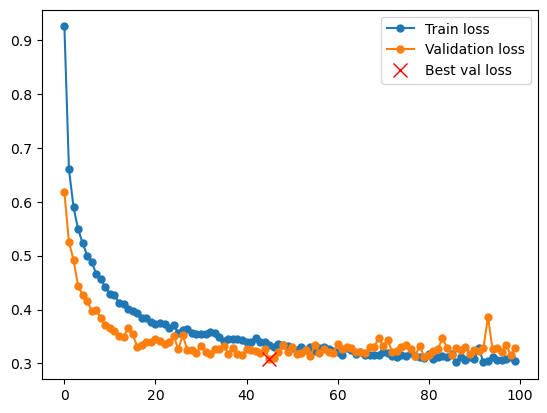

<All keys matched successfully>

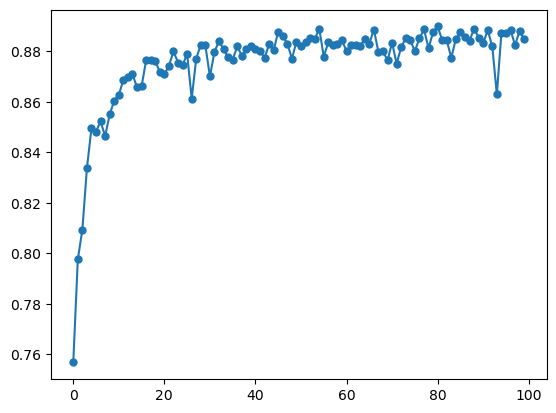

In [305]:
model53aa = ConvModel53().to(device)
optimizer53aa = torch.optim.Adam(model53aa.parameters())
train_more_epochs_es(100,50,model53aa,loss_fn,optimizer53aa,training_loader,validation_loader)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model53aa.load_state_dict(torch.load(model_path))

Po 100 epochách má nejlepší model validační accuracy 0.890. Zajímá mě, jak model ovlivní velikost trénovací bache, zkusím ji tedy zvýšit z 32 na 64 a pustit model znovu.

In [307]:
training_loader2 = torch.utils.data.DataLoader(Xtrain_t, batch_size=64, shuffle=True)
validation_loader2 = torch.utils.data.DataLoader(Xval_t, batch_size=128, shuffle=False)
test_loader2 = torch.utils.data.DataLoader(Xtest_t, batch_size=128, shuffle=False)

c:\Users\Pavel\miniconda3\envs\torchenv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


EPOCH 1:


100%|██████████| 493/493 [00:06<00:00, 82.10it/s]


TRAIN loss: 1.023, VALIDATION loss: 0.607, accuraccy: 0.768
Saving best model
EPOCH 2:


100%|██████████| 493/493 [00:05<00:00, 84.93it/s]


TRAIN loss: 0.668, VALIDATION loss: 0.540, accuraccy: 0.791
Saving best model
EPOCH 3:


100%|██████████| 493/493 [00:05<00:00, 84.27it/s]


TRAIN loss: 0.602, VALIDATION loss: 0.472, accuraccy: 0.821
Saving best model
EPOCH 4:


100%|██████████| 493/493 [00:05<00:00, 82.81it/s]


TRAIN loss: 0.556, VALIDATION loss: 0.445, accuraccy: 0.836
Saving best model
EPOCH 5:


100%|██████████| 493/493 [00:05<00:00, 83.75it/s]


TRAIN loss: 0.525, VALIDATION loss: 0.418, accuraccy: 0.843
Saving best model
EPOCH 6:


100%|██████████| 493/493 [00:06<00:00, 80.35it/s]


TRAIN loss: 0.494, VALIDATION loss: 0.390, accuraccy: 0.854
Saving best model
EPOCH 7:


100%|██████████| 493/493 [00:05<00:00, 82.85it/s]


TRAIN loss: 0.478, VALIDATION loss: 0.401, accuraccy: 0.850
No improvement in this epoch.
EPOCH 8:


100%|██████████| 493/493 [00:06<00:00, 75.68it/s]


TRAIN loss: 0.455, VALIDATION loss: 0.372, accuraccy: 0.862
Saving best model
EPOCH 9:


100%|██████████| 493/493 [00:05<00:00, 83.96it/s]


TRAIN loss: 0.446, VALIDATION loss: 0.374, accuraccy: 0.864
Saving best model
EPOCH 10:


100%|██████████| 493/493 [00:05<00:00, 84.72it/s]


TRAIN loss: 0.437, VALIDATION loss: 0.364, accuraccy: 0.869
Saving best model
EPOCH 11:


100%|██████████| 493/493 [00:06<00:00, 81.47it/s]


TRAIN loss: 0.422, VALIDATION loss: 0.356, accuraccy: 0.870
Saving best model
EPOCH 12:


100%|██████████| 493/493 [00:06<00:00, 79.12it/s]


TRAIN loss: 0.426, VALIDATION loss: 0.349, accuraccy: 0.873
Saving best model
EPOCH 13:


100%|██████████| 493/493 [00:05<00:00, 85.05it/s]


TRAIN loss: 0.409, VALIDATION loss: 0.357, accuraccy: 0.867
No improvement in this epoch.
EPOCH 14:


100%|██████████| 493/493 [00:05<00:00, 84.55it/s]


TRAIN loss: 0.405, VALIDATION loss: 0.345, accuraccy: 0.873
No improvement in this epoch.
EPOCH 15:


100%|██████████| 493/493 [00:06<00:00, 82.10it/s]


TRAIN loss: 0.396, VALIDATION loss: 0.346, accuraccy: 0.872
No improvement in this epoch.
EPOCH 16:


100%|██████████| 493/493 [00:05<00:00, 84.96it/s]


TRAIN loss: 0.394, VALIDATION loss: 0.344, accuraccy: 0.878
Saving best model
EPOCH 17:


100%|██████████| 493/493 [00:06<00:00, 79.63it/s]


TRAIN loss: 0.392, VALIDATION loss: 0.348, accuraccy: 0.869
No improvement in this epoch.
EPOCH 18:


100%|██████████| 493/493 [00:05<00:00, 82.58it/s]


TRAIN loss: 0.383, VALIDATION loss: 0.325, accuraccy: 0.881
Saving best model
EPOCH 19:


100%|██████████| 493/493 [00:06<00:00, 78.63it/s]


TRAIN loss: 0.383, VALIDATION loss: 0.333, accuraccy: 0.878
No improvement in this epoch.
EPOCH 20:


100%|██████████| 493/493 [00:05<00:00, 83.79it/s]


TRAIN loss: 0.380, VALIDATION loss: 0.324, accuraccy: 0.879
No improvement in this epoch.
EPOCH 21:


100%|██████████| 493/493 [00:05<00:00, 85.10it/s]


TRAIN loss: 0.373, VALIDATION loss: 0.323, accuraccy: 0.882
Saving best model
EPOCH 22:


100%|██████████| 493/493 [00:06<00:00, 81.03it/s]


TRAIN loss: 0.363, VALIDATION loss: 0.323, accuraccy: 0.884
Saving best model
EPOCH 23:


100%|██████████| 493/493 [00:05<00:00, 84.07it/s]


TRAIN loss: 0.361, VALIDATION loss: 0.321, accuraccy: 0.886
Saving best model
EPOCH 24:


100%|██████████| 493/493 [00:05<00:00, 84.63it/s]


TRAIN loss: 0.354, VALIDATION loss: 0.322, accuraccy: 0.883
No improvement in this epoch.
EPOCH 25:


100%|██████████| 493/493 [00:05<00:00, 83.89it/s]


TRAIN loss: 0.360, VALIDATION loss: 0.316, accuraccy: 0.884
No improvement in this epoch.
EPOCH 26:


100%|██████████| 493/493 [00:06<00:00, 80.99it/s]


TRAIN loss: 0.350, VALIDATION loss: 0.325, accuraccy: 0.883
No improvement in this epoch.
EPOCH 27:


100%|██████████| 493/493 [00:06<00:00, 80.66it/s]


TRAIN loss: 0.346, VALIDATION loss: 0.312, accuraccy: 0.884
No improvement in this epoch.
EPOCH 28:


100%|██████████| 493/493 [00:05<00:00, 82.95it/s]


TRAIN loss: 0.346, VALIDATION loss: 0.325, accuraccy: 0.880
No improvement in this epoch.
EPOCH 29:


100%|██████████| 493/493 [00:05<00:00, 82.20it/s]


TRAIN loss: 0.340, VALIDATION loss: 0.330, accuraccy: 0.879
No improvement in this epoch.
EPOCH 30:


100%|██████████| 493/493 [00:05<00:00, 84.44it/s]


TRAIN loss: 0.336, VALIDATION loss: 0.317, accuraccy: 0.884
No improvement in this epoch.
EPOCH 31:


100%|██████████| 493/493 [00:05<00:00, 84.27it/s]


TRAIN loss: 0.336, VALIDATION loss: 0.324, accuraccy: 0.882
No improvement in this epoch.
EPOCH 32:


100%|██████████| 493/493 [00:05<00:00, 84.32it/s]


TRAIN loss: 0.333, VALIDATION loss: 0.315, accuraccy: 0.884
No improvement in this epoch.
EPOCH 33:


100%|██████████| 493/493 [00:06<00:00, 81.59it/s]


TRAIN loss: 0.326, VALIDATION loss: 0.313, accuraccy: 0.887
Saving best model
EPOCH 34:


100%|██████████| 493/493 [00:05<00:00, 84.04it/s]


TRAIN loss: 0.331, VALIDATION loss: 0.312, accuraccy: 0.886
No improvement in this epoch.
EPOCH 35:


100%|██████████| 493/493 [00:05<00:00, 85.10it/s]


TRAIN loss: 0.328, VALIDATION loss: 0.306, accuraccy: 0.889
Saving best model
EPOCH 36:


100%|██████████| 493/493 [00:06<00:00, 76.41it/s]


TRAIN loss: 0.332, VALIDATION loss: 0.314, accuraccy: 0.885
No improvement in this epoch.
EPOCH 37:


100%|██████████| 493/493 [00:05<00:00, 83.23it/s]


TRAIN loss: 0.323, VALIDATION loss: 0.320, accuraccy: 0.888
No improvement in this epoch.
EPOCH 38:


100%|██████████| 493/493 [00:05<00:00, 83.10it/s]


TRAIN loss: 0.319, VALIDATION loss: 0.313, accuraccy: 0.888
No improvement in this epoch.
EPOCH 39:


100%|██████████| 493/493 [00:06<00:00, 79.76it/s]


TRAIN loss: 0.324, VALIDATION loss: 0.308, accuraccy: 0.887
No improvement in this epoch.
EPOCH 40:


100%|██████████| 493/493 [00:06<00:00, 75.80it/s]


TRAIN loss: 0.320, VALIDATION loss: 0.314, accuraccy: 0.886
No improvement in this epoch.
EPOCH 41:


100%|██████████| 493/493 [00:05<00:00, 84.74it/s]


TRAIN loss: 0.322, VALIDATION loss: 0.315, accuraccy: 0.884
No improvement in this epoch.
EPOCH 42:


100%|██████████| 493/493 [00:05<00:00, 84.75it/s]


TRAIN loss: 0.314, VALIDATION loss: 0.320, accuraccy: 0.885
No improvement in this epoch.
EPOCH 43:


100%|██████████| 493/493 [00:05<00:00, 85.24it/s]


TRAIN loss: 0.315, VALIDATION loss: 0.307, accuraccy: 0.891
Saving best model
EPOCH 44:


100%|██████████| 493/493 [00:06<00:00, 78.89it/s]


TRAIN loss: 0.317, VALIDATION loss: 0.314, accuraccy: 0.885
No improvement in this epoch.
EPOCH 45:


100%|██████████| 493/493 [00:05<00:00, 82.50it/s]


TRAIN loss: 0.311, VALIDATION loss: 0.307, accuraccy: 0.888
No improvement in this epoch.
EPOCH 46:


100%|██████████| 493/493 [00:05<00:00, 83.12it/s]


TRAIN loss: 0.315, VALIDATION loss: 0.309, accuraccy: 0.891
No improvement in this epoch.
EPOCH 47:


100%|██████████| 493/493 [00:06<00:00, 81.53it/s]


TRAIN loss: 0.308, VALIDATION loss: 0.307, accuraccy: 0.888
No improvement in this epoch.
EPOCH 48:


100%|██████████| 493/493 [00:05<00:00, 83.41it/s]


TRAIN loss: 0.309, VALIDATION loss: 0.314, accuraccy: 0.890
No improvement in this epoch.
EPOCH 49:


100%|██████████| 493/493 [00:05<00:00, 84.53it/s]


TRAIN loss: 0.307, VALIDATION loss: 0.315, accuraccy: 0.888
No improvement in this epoch.
EPOCH 50:


100%|██████████| 493/493 [00:05<00:00, 83.97it/s]


TRAIN loss: 0.307, VALIDATION loss: 0.302, accuraccy: 0.891
No improvement in this epoch.
EPOCH 51:


100%|██████████| 493/493 [00:06<00:00, 81.68it/s]


TRAIN loss: 0.302, VALIDATION loss: 0.314, accuraccy: 0.886
No improvement in this epoch.
EPOCH 52:


100%|██████████| 493/493 [00:05<00:00, 84.72it/s]


TRAIN loss: 0.299, VALIDATION loss: 0.310, accuraccy: 0.891
Saving best model
EPOCH 53:


100%|██████████| 493/493 [00:05<00:00, 84.19it/s]


TRAIN loss: 0.305, VALIDATION loss: 0.312, accuraccy: 0.890
No improvement in this epoch.
EPOCH 54:


100%|██████████| 493/493 [00:06<00:00, 82.02it/s]


TRAIN loss: 0.297, VALIDATION loss: 0.306, accuraccy: 0.892
Saving best model
EPOCH 55:


100%|██████████| 493/493 [00:06<00:00, 78.22it/s]


TRAIN loss: 0.302, VALIDATION loss: 0.313, accuraccy: 0.885
No improvement in this epoch.
EPOCH 56:


100%|██████████| 493/493 [00:05<00:00, 84.18it/s]


TRAIN loss: 0.299, VALIDATION loss: 0.313, accuraccy: 0.893
Saving best model
EPOCH 57:


100%|██████████| 493/493 [00:06<00:00, 82.10it/s]


TRAIN loss: 0.295, VALIDATION loss: 0.304, accuraccy: 0.891
No improvement in this epoch.
EPOCH 58:


100%|██████████| 493/493 [00:05<00:00, 83.45it/s]


TRAIN loss: 0.296, VALIDATION loss: 0.309, accuraccy: 0.889
No improvement in this epoch.
EPOCH 59:


100%|██████████| 493/493 [00:05<00:00, 83.26it/s]


TRAIN loss: 0.295, VALIDATION loss: 0.312, accuraccy: 0.889
No improvement in this epoch.
EPOCH 60:


100%|██████████| 493/493 [00:05<00:00, 84.69it/s]


TRAIN loss: 0.290, VALIDATION loss: 0.313, accuraccy: 0.888
No improvement in this epoch.
EPOCH 61:


100%|██████████| 493/493 [00:06<00:00, 81.09it/s]


TRAIN loss: 0.291, VALIDATION loss: 0.311, accuraccy: 0.889
No improvement in this epoch.
EPOCH 62:


100%|██████████| 493/493 [00:05<00:00, 85.11it/s]


TRAIN loss: 0.294, VALIDATION loss: 0.309, accuraccy: 0.888
No improvement in this epoch.
EPOCH 63:


100%|██████████| 493/493 [00:06<00:00, 79.57it/s]


TRAIN loss: 0.293, VALIDATION loss: 0.312, accuraccy: 0.889
No improvement in this epoch.
EPOCH 64:


100%|██████████| 493/493 [00:06<00:00, 76.16it/s]


TRAIN loss: 0.293, VALIDATION loss: 0.308, accuraccy: 0.890
No improvement in this epoch.
EPOCH 65:


100%|██████████| 493/493 [00:06<00:00, 79.42it/s]


TRAIN loss: 0.291, VALIDATION loss: 0.307, accuraccy: 0.893
Saving best model
EPOCH 66:


100%|██████████| 493/493 [00:07<00:00, 62.44it/s]


TRAIN loss: 0.301, VALIDATION loss: 0.307, accuraccy: 0.889
No improvement in this epoch.
EPOCH 67:


100%|██████████| 493/493 [00:06<00:00, 77.95it/s]


TRAIN loss: 0.290, VALIDATION loss: 0.327, accuraccy: 0.883
No improvement in this epoch.
EPOCH 68:


100%|██████████| 493/493 [00:06<00:00, 74.33it/s]


TRAIN loss: 0.292, VALIDATION loss: 0.303, accuraccy: 0.890
No improvement in this epoch.
EPOCH 69:


100%|██████████| 493/493 [00:06<00:00, 79.16it/s]


TRAIN loss: 0.286, VALIDATION loss: 0.314, accuraccy: 0.889
No improvement in this epoch.
EPOCH 70:


100%|██████████| 493/493 [00:06<00:00, 79.36it/s]


TRAIN loss: 0.291, VALIDATION loss: 0.306, accuraccy: 0.890
No improvement in this epoch.
EPOCH 71:


100%|██████████| 493/493 [00:06<00:00, 80.97it/s]


TRAIN loss: 0.287, VALIDATION loss: 0.319, accuraccy: 0.888
No improvement in this epoch.
EPOCH 72:


100%|██████████| 493/493 [00:06<00:00, 77.45it/s]


TRAIN loss: 0.288, VALIDATION loss: 0.316, accuraccy: 0.887
No improvement in this epoch.
EPOCH 73:


100%|██████████| 493/493 [00:07<00:00, 67.15it/s]


TRAIN loss: 0.284, VALIDATION loss: 0.306, accuraccy: 0.894
Saving best model
EPOCH 74:


100%|██████████| 493/493 [00:06<00:00, 77.28it/s]


TRAIN loss: 0.281, VALIDATION loss: 0.305, accuraccy: 0.893
No improvement in this epoch.
EPOCH 75:


100%|██████████| 493/493 [00:06<00:00, 76.92it/s]


TRAIN loss: 0.288, VALIDATION loss: 0.321, accuraccy: 0.888
No improvement in this epoch.
EPOCH 76:


100%|██████████| 493/493 [00:05<00:00, 82.39it/s]


TRAIN loss: 0.282, VALIDATION loss: 0.309, accuraccy: 0.891
No improvement in this epoch.
EPOCH 77:


100%|██████████| 493/493 [00:06<00:00, 81.97it/s]


TRAIN loss: 0.281, VALIDATION loss: 0.311, accuraccy: 0.891
No improvement in this epoch.
EPOCH 78:


100%|██████████| 493/493 [00:06<00:00, 76.41it/s]


TRAIN loss: 0.285, VALIDATION loss: 0.316, accuraccy: 0.891
No improvement in this epoch.
EPOCH 79:


100%|██████████| 493/493 [00:06<00:00, 80.93it/s]


TRAIN loss: 0.282, VALIDATION loss: 0.301, accuraccy: 0.892
No improvement in this epoch.
EPOCH 80:


100%|██████████| 493/493 [00:06<00:00, 81.32it/s]


TRAIN loss: 0.279, VALIDATION loss: 0.320, accuraccy: 0.882
No improvement in this epoch.
EPOCH 81:


100%|██████████| 493/493 [00:05<00:00, 82.50it/s]


TRAIN loss: 0.283, VALIDATION loss: 0.337, accuraccy: 0.886
No improvement in this epoch.
EPOCH 82:


100%|██████████| 493/493 [00:06<00:00, 73.89it/s]


TRAIN loss: 0.282, VALIDATION loss: 0.299, accuraccy: 0.893
No improvement in this epoch.
EPOCH 83:


100%|██████████| 493/493 [00:06<00:00, 79.78it/s]


TRAIN loss: 0.279, VALIDATION loss: 0.305, accuraccy: 0.896
Saving best model
EPOCH 84:


100%|██████████| 493/493 [00:05<00:00, 82.84it/s]


TRAIN loss: 0.279, VALIDATION loss: 0.315, accuraccy: 0.888
No improvement in this epoch.
EPOCH 85:


100%|██████████| 493/493 [00:06<00:00, 78.03it/s]


TRAIN loss: 0.275, VALIDATION loss: 0.320, accuraccy: 0.892
No improvement in this epoch.
EPOCH 86:


100%|██████████| 493/493 [00:05<00:00, 82.55it/s]


TRAIN loss: 0.275, VALIDATION loss: 0.308, accuraccy: 0.891
No improvement in this epoch.
EPOCH 87:


100%|██████████| 493/493 [00:05<00:00, 83.40it/s]


TRAIN loss: 0.280, VALIDATION loss: 0.321, accuraccy: 0.888
No improvement in this epoch.
EPOCH 88:


100%|██████████| 493/493 [00:06<00:00, 80.28it/s]


TRAIN loss: 0.276, VALIDATION loss: 0.314, accuraccy: 0.891
No improvement in this epoch.
EPOCH 89:


100%|██████████| 493/493 [00:06<00:00, 77.28it/s]


TRAIN loss: 0.275, VALIDATION loss: 0.313, accuraccy: 0.896
Saving best model
EPOCH 90:


100%|██████████| 493/493 [00:06<00:00, 81.45it/s]


TRAIN loss: 0.275, VALIDATION loss: 0.320, accuraccy: 0.890
No improvement in this epoch.
EPOCH 91:


100%|██████████| 493/493 [00:10<00:00, 45.70it/s]


TRAIN loss: 0.281, VALIDATION loss: 0.306, accuraccy: 0.889
No improvement in this epoch.
EPOCH 92:


100%|██████████| 493/493 [00:06<00:00, 78.92it/s]


TRAIN loss: 0.277, VALIDATION loss: 0.312, accuraccy: 0.892
No improvement in this epoch.
EPOCH 93:


100%|██████████| 493/493 [00:06<00:00, 81.84it/s]


TRAIN loss: 0.267, VALIDATION loss: 0.313, accuraccy: 0.890
No improvement in this epoch.
EPOCH 94:


100%|██████████| 493/493 [00:06<00:00, 78.97it/s]


TRAIN loss: 0.275, VALIDATION loss: 0.305, accuraccy: 0.891
No improvement in this epoch.
EPOCH 95:


100%|██████████| 493/493 [00:06<00:00, 81.15it/s]


TRAIN loss: 0.275, VALIDATION loss: 0.318, accuraccy: 0.885
No improvement in this epoch.
EPOCH 96:


100%|██████████| 493/493 [00:06<00:00, 81.90it/s]


TRAIN loss: 0.277, VALIDATION loss: 0.307, accuraccy: 0.893
No improvement in this epoch.
EPOCH 97:


100%|██████████| 493/493 [00:06<00:00, 80.25it/s]


TRAIN loss: 0.277, VALIDATION loss: 0.313, accuraccy: 0.890
No improvement in this epoch.
EPOCH 98:


100%|██████████| 493/493 [00:06<00:00, 75.86it/s]


TRAIN loss: 0.275, VALIDATION loss: 0.307, accuraccy: 0.893
No improvement in this epoch.
EPOCH 99:


100%|██████████| 493/493 [00:06<00:00, 76.56it/s]


TRAIN loss: 0.269, VALIDATION loss: 0.309, accuraccy: 0.893
No improvement in this epoch.
EPOCH 100:


100%|██████████| 493/493 [00:06<00:00, 79.93it/s]


TRAIN loss: 0.269, VALIDATION loss: 0.332, accuraccy: 0.886
No improvement in this epoch.


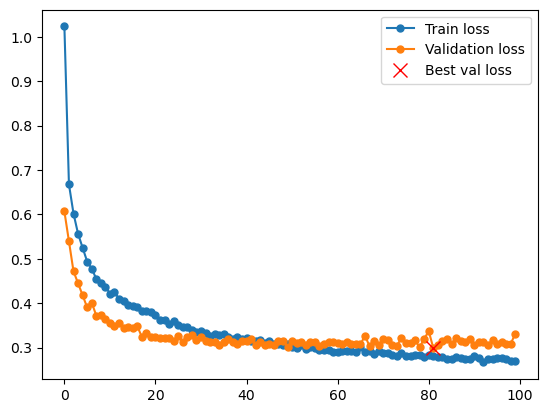

<All keys matched successfully>

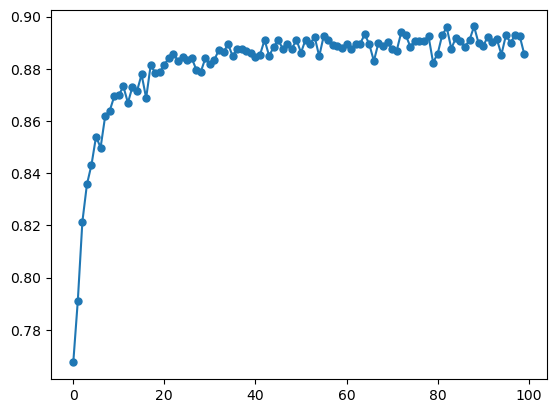

In [308]:
model53ab = ConvModel53().to(device)
optimizer53ab = torch.optim.Adam(model53ab.parameters())
train_more_epochs_es(100,50,model53ab,loss_fn,optimizer53ab,training_loader2,validation_loader2)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model53ab.load_state_dict(torch.load(model_path))

Zvětšení batche výkonnost ovlivnilo, dostávám se na 0.896 validační accuracy. Teď ještě vyzkouším ento nejlepší model na standardizovaných a normalizovaných datech.

c:\Users\Pavel\miniconda3\envs\torchenv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


EPOCH 1:


100%|██████████| 493/493 [00:06<00:00, 77.23it/s]


TRAIN loss: 1.096, VALIDATION loss: 0.661, accuraccy: 0.753
Saving best model
EPOCH 2:


100%|██████████| 493/493 [00:05<00:00, 83.49it/s]


TRAIN loss: 0.716, VALIDATION loss: 0.575, accuraccy: 0.784
Saving best model
EPOCH 3:


100%|██████████| 493/493 [00:05<00:00, 84.51it/s]


TRAIN loss: 0.644, VALIDATION loss: 0.514, accuraccy: 0.817
Saving best model
EPOCH 4:


100%|██████████| 493/493 [00:06<00:00, 74.96it/s]


TRAIN loss: 0.593, VALIDATION loss: 0.473, accuraccy: 0.831
Saving best model
EPOCH 5:


100%|██████████| 493/493 [00:06<00:00, 81.12it/s]


TRAIN loss: 0.559, VALIDATION loss: 0.437, accuraccy: 0.837
Saving best model
EPOCH 6:


100%|██████████| 493/493 [00:06<00:00, 79.81it/s]


TRAIN loss: 0.535, VALIDATION loss: 0.419, accuraccy: 0.847
Saving best model
EPOCH 7:


100%|██████████| 493/493 [00:06<00:00, 80.36it/s]


TRAIN loss: 0.522, VALIDATION loss: 0.411, accuraccy: 0.850
Saving best model
EPOCH 8:


100%|██████████| 493/493 [00:06<00:00, 81.41it/s]


TRAIN loss: 0.498, VALIDATION loss: 0.381, accuraccy: 0.857
Saving best model
EPOCH 9:


100%|██████████| 493/493 [00:05<00:00, 86.84it/s]


TRAIN loss: 0.488, VALIDATION loss: 0.386, accuraccy: 0.858
Saving best model
EPOCH 10:


100%|██████████| 493/493 [00:05<00:00, 85.92it/s]


TRAIN loss: 0.473, VALIDATION loss: 0.386, accuraccy: 0.855
No improvement in this epoch.
EPOCH 11:


100%|██████████| 493/493 [00:05<00:00, 87.10it/s]


TRAIN loss: 0.460, VALIDATION loss: 0.388, accuraccy: 0.863
Saving best model
EPOCH 12:


100%|██████████| 493/493 [00:05<00:00, 83.84it/s]


TRAIN loss: 0.452, VALIDATION loss: 0.370, accuraccy: 0.864
Saving best model
EPOCH 13:


100%|██████████| 493/493 [00:05<00:00, 85.86it/s]


TRAIN loss: 0.436, VALIDATION loss: 0.366, accuraccy: 0.860
No improvement in this epoch.
EPOCH 14:


100%|██████████| 493/493 [00:05<00:00, 85.98it/s]


TRAIN loss: 0.429, VALIDATION loss: 0.366, accuraccy: 0.864
Saving best model
EPOCH 15:


100%|██████████| 493/493 [00:06<00:00, 72.48it/s]


TRAIN loss: 0.413, VALIDATION loss: 0.360, accuraccy: 0.868
Saving best model
EPOCH 16:


100%|██████████| 493/493 [00:06<00:00, 77.82it/s]


TRAIN loss: 0.413, VALIDATION loss: 0.354, accuraccy: 0.867
No improvement in this epoch.
EPOCH 17:


100%|██████████| 493/493 [00:05<00:00, 83.31it/s]


TRAIN loss: 0.407, VALIDATION loss: 0.356, accuraccy: 0.869
Saving best model
EPOCH 18:


100%|██████████| 493/493 [00:06<00:00, 82.16it/s]


TRAIN loss: 0.397, VALIDATION loss: 0.330, accuraccy: 0.880
Saving best model
EPOCH 19:


100%|██████████| 493/493 [00:05<00:00, 82.75it/s]


TRAIN loss: 0.390, VALIDATION loss: 0.334, accuraccy: 0.878
No improvement in this epoch.
EPOCH 20:


100%|██████████| 493/493 [00:05<00:00, 84.59it/s]


TRAIN loss: 0.385, VALIDATION loss: 0.333, accuraccy: 0.878
No improvement in this epoch.
EPOCH 21:


100%|██████████| 493/493 [00:05<00:00, 83.74it/s]


TRAIN loss: 0.381, VALIDATION loss: 0.322, accuraccy: 0.884
Saving best model
EPOCH 22:


100%|██████████| 493/493 [00:05<00:00, 83.91it/s]


TRAIN loss: 0.374, VALIDATION loss: 0.320, accuraccy: 0.884
Saving best model
EPOCH 23:


100%|██████████| 493/493 [00:06<00:00, 80.56it/s]


TRAIN loss: 0.366, VALIDATION loss: 0.322, accuraccy: 0.883
No improvement in this epoch.
EPOCH 24:


100%|██████████| 493/493 [00:05<00:00, 83.50it/s]


TRAIN loss: 0.363, VALIDATION loss: 0.324, accuraccy: 0.880
No improvement in this epoch.
EPOCH 25:


100%|██████████| 493/493 [00:05<00:00, 83.45it/s]


TRAIN loss: 0.366, VALIDATION loss: 0.327, accuraccy: 0.879
No improvement in this epoch.
EPOCH 26:


100%|██████████| 493/493 [00:06<00:00, 80.28it/s]


TRAIN loss: 0.353, VALIDATION loss: 0.332, accuraccy: 0.881
No improvement in this epoch.
EPOCH 27:


100%|██████████| 493/493 [00:06<00:00, 80.46it/s]


TRAIN loss: 0.354, VALIDATION loss: 0.319, accuraccy: 0.883
No improvement in this epoch.
EPOCH 28:


100%|██████████| 493/493 [00:05<00:00, 84.18it/s]


TRAIN loss: 0.355, VALIDATION loss: 0.326, accuraccy: 0.875
No improvement in this epoch.
EPOCH 29:


100%|██████████| 493/493 [00:06<00:00, 81.64it/s]


TRAIN loss: 0.353, VALIDATION loss: 0.317, accuraccy: 0.883
No improvement in this epoch.
EPOCH 30:


100%|██████████| 493/493 [00:06<00:00, 79.47it/s]


TRAIN loss: 0.348, VALIDATION loss: 0.323, accuraccy: 0.883
No improvement in this epoch.
EPOCH 31:


100%|██████████| 493/493 [00:05<00:00, 84.90it/s]


TRAIN loss: 0.346, VALIDATION loss: 0.344, accuraccy: 0.868
No improvement in this epoch.
EPOCH 32:


100%|██████████| 493/493 [00:05<00:00, 84.32it/s]


TRAIN loss: 0.342, VALIDATION loss: 0.328, accuraccy: 0.882
No improvement in this epoch.
EPOCH 33:


100%|██████████| 493/493 [00:05<00:00, 84.73it/s]


TRAIN loss: 0.341, VALIDATION loss: 0.325, accuraccy: 0.879
No improvement in this epoch.
EPOCH 34:


100%|██████████| 493/493 [00:06<00:00, 80.91it/s]


TRAIN loss: 0.333, VALIDATION loss: 0.326, accuraccy: 0.877
No improvement in this epoch.
EPOCH 35:


100%|██████████| 493/493 [00:06<00:00, 78.12it/s]


TRAIN loss: 0.339, VALIDATION loss: 0.315, accuraccy: 0.884
Saving best model
EPOCH 36:


100%|██████████| 493/493 [00:05<00:00, 84.40it/s]


TRAIN loss: 0.336, VALIDATION loss: 0.313, accuraccy: 0.887
Saving best model
EPOCH 37:


100%|██████████| 493/493 [00:05<00:00, 83.46it/s]


TRAIN loss: 0.334, VALIDATION loss: 0.319, accuraccy: 0.883
No improvement in this epoch.
EPOCH 38:


100%|██████████| 493/493 [00:06<00:00, 78.45it/s]


TRAIN loss: 0.328, VALIDATION loss: 0.314, accuraccy: 0.887
Saving best model
EPOCH 39:


100%|██████████| 493/493 [00:06<00:00, 81.56it/s]


TRAIN loss: 0.323, VALIDATION loss: 0.308, accuraccy: 0.888
Saving best model
EPOCH 40:


100%|██████████| 493/493 [00:05<00:00, 83.05it/s]


TRAIN loss: 0.323, VALIDATION loss: 0.338, accuraccy: 0.874
No improvement in this epoch.
EPOCH 41:


100%|██████████| 493/493 [00:06<00:00, 79.72it/s]


TRAIN loss: 0.325, VALIDATION loss: 0.322, accuraccy: 0.881
No improvement in this epoch.
EPOCH 42:


100%|██████████| 493/493 [00:05<00:00, 84.91it/s]


TRAIN loss: 0.327, VALIDATION loss: 0.307, accuraccy: 0.886
No improvement in this epoch.
EPOCH 43:


100%|██████████| 493/493 [00:05<00:00, 84.11it/s]


TRAIN loss: 0.321, VALIDATION loss: 0.320, accuraccy: 0.884
No improvement in this epoch.
EPOCH 44:


100%|██████████| 493/493 [00:06<00:00, 76.73it/s]


TRAIN loss: 0.319, VALIDATION loss: 0.306, accuraccy: 0.886
No improvement in this epoch.
EPOCH 45:


100%|██████████| 493/493 [00:05<00:00, 82.25it/s]


TRAIN loss: 0.321, VALIDATION loss: 0.329, accuraccy: 0.881
No improvement in this epoch.
EPOCH 46:


100%|██████████| 493/493 [00:05<00:00, 83.50it/s]


TRAIN loss: 0.317, VALIDATION loss: 0.303, accuraccy: 0.890
Saving best model
EPOCH 47:


100%|██████████| 493/493 [00:05<00:00, 83.30it/s]


TRAIN loss: 0.316, VALIDATION loss: 0.310, accuraccy: 0.888
No improvement in this epoch.
EPOCH 48:


100%|██████████| 493/493 [00:06<00:00, 80.73it/s]


TRAIN loss: 0.313, VALIDATION loss: 0.311, accuraccy: 0.889
No improvement in this epoch.
EPOCH 49:


100%|██████████| 493/493 [00:06<00:00, 80.75it/s]


TRAIN loss: 0.314, VALIDATION loss: 0.319, accuraccy: 0.883
No improvement in this epoch.
EPOCH 50:


100%|██████████| 493/493 [00:05<00:00, 84.49it/s]


TRAIN loss: 0.314, VALIDATION loss: 0.307, accuraccy: 0.887
No improvement in this epoch.
EPOCH 51:


100%|██████████| 493/493 [00:05<00:00, 83.49it/s]


TRAIN loss: 0.303, VALIDATION loss: 0.313, accuraccy: 0.887
No improvement in this epoch.
EPOCH 52:


100%|██████████| 493/493 [00:06<00:00, 80.27it/s]


TRAIN loss: 0.318, VALIDATION loss: 0.307, accuraccy: 0.887
No improvement in this epoch.
EPOCH 53:


100%|██████████| 493/493 [00:05<00:00, 82.90it/s]


TRAIN loss: 0.307, VALIDATION loss: 0.304, accuraccy: 0.888
No improvement in this epoch.
EPOCH 54:


100%|██████████| 493/493 [00:06<00:00, 77.88it/s]


TRAIN loss: 0.304, VALIDATION loss: 0.305, accuraccy: 0.890
No improvement in this epoch.
EPOCH 55:


100%|██████████| 493/493 [00:06<00:00, 80.08it/s]


TRAIN loss: 0.302, VALIDATION loss: 0.302, accuraccy: 0.889
No improvement in this epoch.
EPOCH 56:


100%|██████████| 493/493 [00:05<00:00, 84.37it/s]


TRAIN loss: 0.304, VALIDATION loss: 0.301, accuraccy: 0.890
Saving best model
EPOCH 57:


100%|██████████| 493/493 [00:06<00:00, 80.41it/s]


TRAIN loss: 0.300, VALIDATION loss: 0.306, accuraccy: 0.890
No improvement in this epoch.
EPOCH 58:


100%|██████████| 493/493 [00:05<00:00, 83.65it/s]


TRAIN loss: 0.303, VALIDATION loss: 0.305, accuraccy: 0.888
No improvement in this epoch.
EPOCH 59:


100%|██████████| 493/493 [00:06<00:00, 79.20it/s]


TRAIN loss: 0.302, VALIDATION loss: 0.305, accuraccy: 0.889
No improvement in this epoch.
EPOCH 60:


100%|██████████| 493/493 [00:05<00:00, 83.36it/s]


TRAIN loss: 0.304, VALIDATION loss: 0.325, accuraccy: 0.884
No improvement in this epoch.
EPOCH 61:


100%|██████████| 493/493 [00:05<00:00, 83.75it/s]


TRAIN loss: 0.295, VALIDATION loss: 0.317, accuraccy: 0.887
No improvement in this epoch.
EPOCH 62:


100%|██████████| 493/493 [00:06<00:00, 79.21it/s]


TRAIN loss: 0.296, VALIDATION loss: 0.297, accuraccy: 0.889
No improvement in this epoch.
EPOCH 63:


100%|██████████| 493/493 [00:06<00:00, 73.08it/s]


TRAIN loss: 0.295, VALIDATION loss: 0.312, accuraccy: 0.886
No improvement in this epoch.
EPOCH 64:


100%|██████████| 493/493 [00:05<00:00, 83.30it/s]


TRAIN loss: 0.297, VALIDATION loss: 0.321, accuraccy: 0.882
No improvement in this epoch.
EPOCH 65:


100%|██████████| 493/493 [00:05<00:00, 84.08it/s]


TRAIN loss: 0.293, VALIDATION loss: 0.308, accuraccy: 0.889
No improvement in this epoch.
EPOCH 66:


100%|██████████| 493/493 [00:06<00:00, 79.83it/s]


TRAIN loss: 0.296, VALIDATION loss: 0.309, accuraccy: 0.888
No improvement in this epoch.
EPOCH 67:


100%|██████████| 493/493 [00:05<00:00, 83.41it/s]


TRAIN loss: 0.294, VALIDATION loss: 0.313, accuraccy: 0.885
No improvement in this epoch.
EPOCH 68:


100%|██████████| 493/493 [00:05<00:00, 83.37it/s]


TRAIN loss: 0.291, VALIDATION loss: 0.312, accuraccy: 0.891
Saving best model
EPOCH 69:


100%|██████████| 493/493 [00:06<00:00, 81.36it/s]


TRAIN loss: 0.293, VALIDATION loss: 0.308, accuraccy: 0.889
No improvement in this epoch.
EPOCH 70:


100%|██████████| 493/493 [00:07<00:00, 69.44it/s]


TRAIN loss: 0.292, VALIDATION loss: 0.306, accuraccy: 0.888
No improvement in this epoch.
EPOCH 71:


100%|██████████| 493/493 [00:06<00:00, 78.01it/s]


TRAIN loss: 0.285, VALIDATION loss: 0.308, accuraccy: 0.889
No improvement in this epoch.
EPOCH 72:


100%|██████████| 493/493 [00:07<00:00, 70.24it/s]


TRAIN loss: 0.289, VALIDATION loss: 0.313, accuraccy: 0.889
No improvement in this epoch.
EPOCH 73:


100%|██████████| 493/493 [00:06<00:00, 74.63it/s]


TRAIN loss: 0.292, VALIDATION loss: 0.301, accuraccy: 0.891
Saving best model
EPOCH 74:


100%|██████████| 493/493 [00:06<00:00, 73.65it/s]


TRAIN loss: 0.289, VALIDATION loss: 0.314, accuraccy: 0.888
No improvement in this epoch.
EPOCH 75:


100%|██████████| 493/493 [00:06<00:00, 80.28it/s]


TRAIN loss: 0.293, VALIDATION loss: 0.316, accuraccy: 0.888
No improvement in this epoch.
EPOCH 76:


100%|██████████| 493/493 [00:06<00:00, 79.99it/s]


TRAIN loss: 0.291, VALIDATION loss: 0.312, accuraccy: 0.888
No improvement in this epoch.
EPOCH 77:


100%|██████████| 493/493 [00:06<00:00, 79.74it/s]


TRAIN loss: 0.287, VALIDATION loss: 0.308, accuraccy: 0.892
Saving best model
EPOCH 78:


100%|██████████| 493/493 [00:05<00:00, 82.47it/s]


TRAIN loss: 0.285, VALIDATION loss: 0.314, accuraccy: 0.889
No improvement in this epoch.
EPOCH 79:


100%|██████████| 493/493 [00:06<00:00, 80.27it/s]


TRAIN loss: 0.279, VALIDATION loss: 0.320, accuraccy: 0.886
No improvement in this epoch.
EPOCH 80:


100%|██████████| 493/493 [00:06<00:00, 79.17it/s]


TRAIN loss: 0.283, VALIDATION loss: 0.306, accuraccy: 0.890
No improvement in this epoch.
EPOCH 81:


100%|██████████| 493/493 [00:06<00:00, 74.72it/s]


TRAIN loss: 0.284, VALIDATION loss: 0.304, accuraccy: 0.889
No improvement in this epoch.
EPOCH 82:


100%|██████████| 493/493 [00:05<00:00, 82.21it/s]


TRAIN loss: 0.288, VALIDATION loss: 0.305, accuraccy: 0.892
No improvement in this epoch.
EPOCH 83:


100%|██████████| 493/493 [00:05<00:00, 82.95it/s]


TRAIN loss: 0.280, VALIDATION loss: 0.325, accuraccy: 0.888
No improvement in this epoch.
EPOCH 84:


100%|██████████| 493/493 [00:06<00:00, 77.70it/s]


TRAIN loss: 0.287, VALIDATION loss: 0.301, accuraccy: 0.893
Saving best model
EPOCH 85:


100%|██████████| 493/493 [00:06<00:00, 81.27it/s]


TRAIN loss: 0.278, VALIDATION loss: 0.309, accuraccy: 0.892
No improvement in this epoch.
EPOCH 86:


100%|██████████| 493/493 [00:05<00:00, 83.52it/s]


TRAIN loss: 0.282, VALIDATION loss: 0.317, accuraccy: 0.890
No improvement in this epoch.
EPOCH 87:


100%|██████████| 493/493 [00:06<00:00, 81.04it/s]


TRAIN loss: 0.282, VALIDATION loss: 0.305, accuraccy: 0.895
Saving best model
EPOCH 88:


100%|██████████| 493/493 [00:05<00:00, 82.50it/s]


TRAIN loss: 0.279, VALIDATION loss: 0.316, accuraccy: 0.887
No improvement in this epoch.
EPOCH 89:


100%|██████████| 493/493 [00:06<00:00, 80.19it/s]


TRAIN loss: 0.280, VALIDATION loss: 0.308, accuraccy: 0.890
No improvement in this epoch.
EPOCH 90:


100%|██████████| 493/493 [00:06<00:00, 70.92it/s]


TRAIN loss: 0.279, VALIDATION loss: 0.308, accuraccy: 0.890
No improvement in this epoch.
EPOCH 91:


100%|██████████| 493/493 [00:05<00:00, 82.77it/s]


TRAIN loss: 0.277, VALIDATION loss: 0.302, accuraccy: 0.892
No improvement in this epoch.
EPOCH 92:


100%|██████████| 493/493 [00:05<00:00, 82.98it/s]


TRAIN loss: 0.275, VALIDATION loss: 0.311, accuraccy: 0.890
No improvement in this epoch.
EPOCH 93:


100%|██████████| 493/493 [00:06<00:00, 80.23it/s]


TRAIN loss: 0.279, VALIDATION loss: 0.331, accuraccy: 0.886
No improvement in this epoch.
EPOCH 94:


100%|██████████| 493/493 [00:06<00:00, 78.93it/s]


TRAIN loss: 0.283, VALIDATION loss: 0.317, accuraccy: 0.884
No improvement in this epoch.
EPOCH 95:


100%|██████████| 493/493 [00:06<00:00, 82.08it/s]


TRAIN loss: 0.272, VALIDATION loss: 0.312, accuraccy: 0.888
No improvement in this epoch.
EPOCH 96:


100%|██████████| 493/493 [00:05<00:00, 82.29it/s]


TRAIN loss: 0.273, VALIDATION loss: 0.322, accuraccy: 0.887
No improvement in this epoch.
EPOCH 97:


100%|██████████| 493/493 [00:06<00:00, 80.84it/s]


TRAIN loss: 0.280, VALIDATION loss: 0.307, accuraccy: 0.890
No improvement in this epoch.
EPOCH 98:


100%|██████████| 493/493 [00:06<00:00, 79.81it/s]


TRAIN loss: 0.277, VALIDATION loss: 0.315, accuraccy: 0.888
No improvement in this epoch.
EPOCH 99:


100%|██████████| 493/493 [00:06<00:00, 72.47it/s]


TRAIN loss: 0.279, VALIDATION loss: 0.310, accuraccy: 0.885
No improvement in this epoch.
EPOCH 100:


100%|██████████| 493/493 [00:06<00:00, 81.53it/s]


TRAIN loss: 0.273, VALIDATION loss: 0.318, accuraccy: 0.888
No improvement in this epoch.


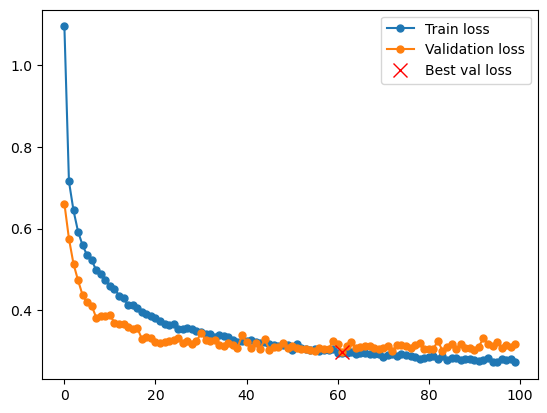

<All keys matched successfully>

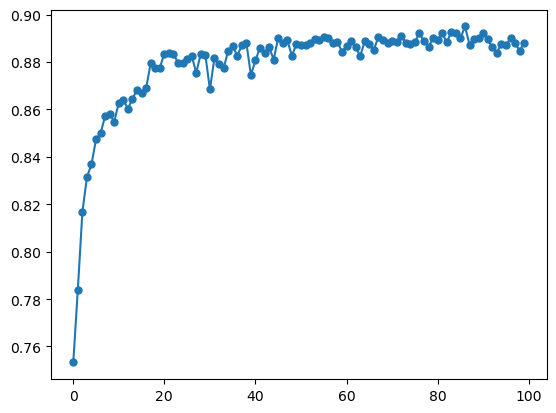

In [316]:
model53ab_mm = ConvModel53().to(device)
optimizer53ab_mm = torch.optim.Adam(model53ab_mm.parameters())
train_more_epochs_es(100,50,model53ab_mm,loss_fn,optimizer53ab_mm,training_loader2,validation_loader2)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model53ab_mm.load_state_dict(torch.load(model_path))

EPOCH 1:


100%|██████████| 493/493 [00:06<00:00, 77.52it/s]


TRAIN loss: 0.999, VALIDATION loss: 0.615, accuraccy: 0.765
Saving best model
EPOCH 2:


100%|██████████| 493/493 [00:05<00:00, 83.89it/s]


TRAIN loss: 0.658, VALIDATION loss: 0.504, accuraccy: 0.804
Saving best model
EPOCH 3:


100%|██████████| 493/493 [00:05<00:00, 84.76it/s]


TRAIN loss: 0.588, VALIDATION loss: 0.463, accuraccy: 0.833
Saving best model
EPOCH 4:


100%|██████████| 493/493 [00:06<00:00, 77.37it/s]


TRAIN loss: 0.553, VALIDATION loss: 0.443, accuraccy: 0.843
Saving best model
EPOCH 5:


100%|██████████| 493/493 [00:06<00:00, 75.15it/s]


TRAIN loss: 0.518, VALIDATION loss: 0.436, accuraccy: 0.840
No improvement in this epoch.
EPOCH 6:


100%|██████████| 493/493 [00:06<00:00, 77.10it/s]


TRAIN loss: 0.495, VALIDATION loss: 0.389, accuraccy: 0.858
Saving best model
EPOCH 7:


100%|██████████| 493/493 [00:07<00:00, 70.14it/s]


TRAIN loss: 0.481, VALIDATION loss: 0.385, accuraccy: 0.863
Saving best model
EPOCH 8:


100%|██████████| 493/493 [00:07<00:00, 68.81it/s]


TRAIN loss: 0.460, VALIDATION loss: 0.374, accuraccy: 0.866
Saving best model
EPOCH 9:


100%|██████████| 493/493 [00:07<00:00, 61.85it/s]


TRAIN loss: 0.449, VALIDATION loss: 0.376, accuraccy: 0.862
No improvement in this epoch.
EPOCH 10:


100%|██████████| 493/493 [00:07<00:00, 66.97it/s]


TRAIN loss: 0.433, VALIDATION loss: 0.364, accuraccy: 0.869
Saving best model
EPOCH 11:


100%|██████████| 493/493 [00:07<00:00, 63.86it/s]


TRAIN loss: 0.433, VALIDATION loss: 0.357, accuraccy: 0.870
Saving best model
EPOCH 12:


100%|██████████| 493/493 [00:06<00:00, 78.33it/s]


TRAIN loss: 0.422, VALIDATION loss: 0.348, accuraccy: 0.871
Saving best model
EPOCH 13:


100%|██████████| 493/493 [00:07<00:00, 66.94it/s]


TRAIN loss: 0.410, VALIDATION loss: 0.343, accuraccy: 0.874
Saving best model
EPOCH 14:


100%|██████████| 493/493 [00:08<00:00, 57.51it/s]


TRAIN loss: 0.401, VALIDATION loss: 0.334, accuraccy: 0.875
Saving best model
EPOCH 15:


100%|██████████| 493/493 [00:09<00:00, 54.23it/s]


TRAIN loss: 0.395, VALIDATION loss: 0.331, accuraccy: 0.877
Saving best model
EPOCH 16:


100%|██████████| 493/493 [00:07<00:00, 63.02it/s]


TRAIN loss: 0.392, VALIDATION loss: 0.345, accuraccy: 0.871
No improvement in this epoch.
EPOCH 17:


100%|██████████| 493/493 [00:06<00:00, 76.90it/s]


TRAIN loss: 0.387, VALIDATION loss: 0.339, accuraccy: 0.877
No improvement in this epoch.
EPOCH 18:


100%|██████████| 493/493 [00:06<00:00, 80.66it/s]


TRAIN loss: 0.382, VALIDATION loss: 0.332, accuraccy: 0.878
Saving best model
EPOCH 19:


100%|██████████| 493/493 [00:06<00:00, 74.77it/s]


TRAIN loss: 0.378, VALIDATION loss: 0.332, accuraccy: 0.879
Saving best model
EPOCH 20:


100%|██████████| 493/493 [00:06<00:00, 81.10it/s]


TRAIN loss: 0.368, VALIDATION loss: 0.323, accuraccy: 0.878
No improvement in this epoch.
EPOCH 21:


100%|██████████| 493/493 [00:06<00:00, 80.55it/s]


TRAIN loss: 0.368, VALIDATION loss: 0.318, accuraccy: 0.884
Saving best model
EPOCH 22:


100%|██████████| 493/493 [00:06<00:00, 75.48it/s]


TRAIN loss: 0.360, VALIDATION loss: 0.331, accuraccy: 0.877
No improvement in this epoch.
EPOCH 23:


100%|██████████| 493/493 [00:06<00:00, 81.64it/s]


TRAIN loss: 0.360, VALIDATION loss: 0.323, accuraccy: 0.881
No improvement in this epoch.
EPOCH 24:


100%|██████████| 493/493 [00:07<00:00, 69.06it/s]


TRAIN loss: 0.357, VALIDATION loss: 0.325, accuraccy: 0.878
No improvement in this epoch.
EPOCH 25:


100%|██████████| 493/493 [00:06<00:00, 81.28it/s]


TRAIN loss: 0.357, VALIDATION loss: 0.330, accuraccy: 0.876
No improvement in this epoch.
EPOCH 26:


100%|██████████| 493/493 [00:06<00:00, 73.32it/s]


TRAIN loss: 0.350, VALIDATION loss: 0.309, accuraccy: 0.887
Saving best model
EPOCH 27:


100%|██████████| 493/493 [00:06<00:00, 78.46it/s]


TRAIN loss: 0.348, VALIDATION loss: 0.312, accuraccy: 0.887
Saving best model
EPOCH 28:


100%|██████████| 493/493 [00:06<00:00, 79.11it/s]


TRAIN loss: 0.345, VALIDATION loss: 0.333, accuraccy: 0.878
No improvement in this epoch.
EPOCH 29:


100%|██████████| 493/493 [00:06<00:00, 76.76it/s]


TRAIN loss: 0.341, VALIDATION loss: 0.311, accuraccy: 0.883
No improvement in this epoch.
EPOCH 30:


100%|██████████| 493/493 [00:06<00:00, 80.09it/s]


TRAIN loss: 0.335, VALIDATION loss: 0.319, accuraccy: 0.884
No improvement in this epoch.
EPOCH 31:


100%|██████████| 493/493 [00:06<00:00, 81.01it/s]


TRAIN loss: 0.336, VALIDATION loss: 0.313, accuraccy: 0.882
No improvement in this epoch.
EPOCH 32:


100%|██████████| 493/493 [00:06<00:00, 79.26it/s]


TRAIN loss: 0.339, VALIDATION loss: 0.322, accuraccy: 0.884
No improvement in this epoch.
EPOCH 33:


100%|██████████| 493/493 [00:07<00:00, 66.30it/s]


TRAIN loss: 0.327, VALIDATION loss: 0.310, accuraccy: 0.886
No improvement in this epoch.
EPOCH 34:


100%|██████████| 493/493 [00:06<00:00, 80.59it/s]


TRAIN loss: 0.334, VALIDATION loss: 0.312, accuraccy: 0.884
No improvement in this epoch.
EPOCH 35:


100%|██████████| 493/493 [00:06<00:00, 80.70it/s]


TRAIN loss: 0.328, VALIDATION loss: 0.317, accuraccy: 0.881
No improvement in this epoch.
EPOCH 36:


100%|██████████| 493/493 [00:06<00:00, 71.10it/s]


TRAIN loss: 0.324, VALIDATION loss: 0.310, accuraccy: 0.884
No improvement in this epoch.
EPOCH 37:


100%|██████████| 493/493 [00:06<00:00, 77.89it/s]


TRAIN loss: 0.321, VALIDATION loss: 0.307, accuraccy: 0.885
No improvement in this epoch.
EPOCH 38:


100%|██████████| 493/493 [00:06<00:00, 81.01it/s]


TRAIN loss: 0.321, VALIDATION loss: 0.318, accuraccy: 0.882
No improvement in this epoch.
EPOCH 39:


100%|██████████| 493/493 [00:06<00:00, 80.10it/s]


TRAIN loss: 0.324, VALIDATION loss: 0.324, accuraccy: 0.880
No improvement in this epoch.
EPOCH 40:


100%|██████████| 493/493 [00:06<00:00, 73.63it/s]


TRAIN loss: 0.326, VALIDATION loss: 0.320, accuraccy: 0.883
No improvement in this epoch.
EPOCH 41:


100%|██████████| 493/493 [00:06<00:00, 73.25it/s]


TRAIN loss: 0.319, VALIDATION loss: 0.319, accuraccy: 0.879
No improvement in this epoch.
EPOCH 42:


100%|██████████| 493/493 [00:06<00:00, 78.09it/s]


TRAIN loss: 0.317, VALIDATION loss: 0.317, accuraccy: 0.886
No improvement in this epoch.
EPOCH 43:


100%|██████████| 493/493 [00:06<00:00, 74.88it/s]


TRAIN loss: 0.314, VALIDATION loss: 0.331, accuraccy: 0.878
No improvement in this epoch.
EPOCH 44:


100%|██████████| 493/493 [00:06<00:00, 78.52it/s]


TRAIN loss: 0.312, VALIDATION loss: 0.324, accuraccy: 0.880
No improvement in this epoch.
EPOCH 45:


100%|██████████| 493/493 [00:06<00:00, 79.29it/s]


TRAIN loss: 0.315, VALIDATION loss: 0.331, accuraccy: 0.883
No improvement in this epoch.
EPOCH 46:


100%|██████████| 493/493 [00:07<00:00, 68.86it/s]


TRAIN loss: 0.321, VALIDATION loss: 0.314, accuraccy: 0.884
No improvement in this epoch.
EPOCH 47:


100%|██████████| 493/493 [00:07<00:00, 68.17it/s]


TRAIN loss: 0.313, VALIDATION loss: 0.318, accuraccy: 0.886
No improvement in this epoch.
EPOCH 48:


100%|██████████| 493/493 [00:06<00:00, 80.26it/s]


TRAIN loss: 0.311, VALIDATION loss: 0.317, accuraccy: 0.881
No improvement in this epoch.
EPOCH 49:


100%|██████████| 493/493 [00:06<00:00, 79.56it/s]


TRAIN loss: 0.314, VALIDATION loss: 0.300, accuraccy: 0.887
Saving best model
EPOCH 50:


100%|██████████| 493/493 [00:06<00:00, 70.63it/s]


TRAIN loss: 0.306, VALIDATION loss: 0.314, accuraccy: 0.888
Saving best model
EPOCH 51:


100%|██████████| 493/493 [00:06<00:00, 75.52it/s]


TRAIN loss: 0.308, VALIDATION loss: 0.307, accuraccy: 0.887
No improvement in this epoch.
EPOCH 52:


100%|██████████| 493/493 [00:06<00:00, 78.03it/s]


TRAIN loss: 0.311, VALIDATION loss: 0.306, accuraccy: 0.888
No improvement in this epoch.
EPOCH 53:


100%|██████████| 493/493 [00:06<00:00, 73.31it/s]


TRAIN loss: 0.301, VALIDATION loss: 0.310, accuraccy: 0.887
No improvement in this epoch.
EPOCH 54:


100%|██████████| 493/493 [00:06<00:00, 77.02it/s]


TRAIN loss: 0.296, VALIDATION loss: 0.313, accuraccy: 0.889
Saving best model
EPOCH 55:


100%|██████████| 493/493 [00:06<00:00, 75.58it/s]


TRAIN loss: 0.301, VALIDATION loss: 0.311, accuraccy: 0.887
No improvement in this epoch.
EPOCH 56:


100%|██████████| 493/493 [00:06<00:00, 78.57it/s]


TRAIN loss: 0.293, VALIDATION loss: 0.334, accuraccy: 0.880
No improvement in this epoch.
EPOCH 57:


100%|██████████| 493/493 [00:06<00:00, 72.34it/s]


TRAIN loss: 0.301, VALIDATION loss: 0.310, accuraccy: 0.891
Saving best model
EPOCH 58:


100%|██████████| 493/493 [00:06<00:00, 75.32it/s]


TRAIN loss: 0.300, VALIDATION loss: 0.304, accuraccy: 0.889
No improvement in this epoch.
EPOCH 59:


100%|██████████| 493/493 [00:07<00:00, 69.23it/s]


TRAIN loss: 0.302, VALIDATION loss: 0.306, accuraccy: 0.890
No improvement in this epoch.
EPOCH 60:


100%|██████████| 493/493 [00:06<00:00, 71.06it/s]


TRAIN loss: 0.287, VALIDATION loss: 0.310, accuraccy: 0.886
No improvement in this epoch.
EPOCH 61:


100%|██████████| 493/493 [00:06<00:00, 76.86it/s]


TRAIN loss: 0.295, VALIDATION loss: 0.302, accuraccy: 0.888
No improvement in this epoch.
EPOCH 62:


100%|██████████| 493/493 [00:06<00:00, 78.68it/s]


TRAIN loss: 0.300, VALIDATION loss: 0.305, accuraccy: 0.892
Saving best model
EPOCH 63:


100%|██████████| 493/493 [00:06<00:00, 73.09it/s]


TRAIN loss: 0.293, VALIDATION loss: 0.313, accuraccy: 0.888
No improvement in this epoch.
EPOCH 64:


100%|██████████| 493/493 [00:06<00:00, 71.85it/s]


TRAIN loss: 0.289, VALIDATION loss: 0.318, accuraccy: 0.886
No improvement in this epoch.
EPOCH 65:


100%|██████████| 493/493 [00:06<00:00, 72.10it/s]


TRAIN loss: 0.296, VALIDATION loss: 0.310, accuraccy: 0.888
No improvement in this epoch.
EPOCH 66:


100%|██████████| 493/493 [00:06<00:00, 76.66it/s]


TRAIN loss: 0.289, VALIDATION loss: 0.329, accuraccy: 0.882
No improvement in this epoch.
EPOCH 67:


100%|██████████| 493/493 [00:08<00:00, 60.82it/s]


TRAIN loss: 0.294, VALIDATION loss: 0.318, accuraccy: 0.888
No improvement in this epoch.
EPOCH 68:


100%|██████████| 493/493 [00:06<00:00, 75.38it/s]


TRAIN loss: 0.289, VALIDATION loss: 0.313, accuraccy: 0.888
No improvement in this epoch.
EPOCH 69:


100%|██████████| 493/493 [00:06<00:00, 76.98it/s]


TRAIN loss: 0.289, VALIDATION loss: 0.313, accuraccy: 0.890
No improvement in this epoch.
EPOCH 70:


100%|██████████| 493/493 [00:06<00:00, 70.86it/s]


TRAIN loss: 0.294, VALIDATION loss: 0.308, accuraccy: 0.888
No improvement in this epoch.
EPOCH 71:


100%|██████████| 493/493 [00:06<00:00, 71.81it/s]


TRAIN loss: 0.288, VALIDATION loss: 0.320, accuraccy: 0.884
No improvement in this epoch.
EPOCH 72:


100%|██████████| 493/493 [00:06<00:00, 77.61it/s]


TRAIN loss: 0.286, VALIDATION loss: 0.315, accuraccy: 0.885
No improvement in this epoch.
EPOCH 73:


100%|██████████| 493/493 [00:07<00:00, 65.71it/s]


TRAIN loss: 0.277, VALIDATION loss: 0.320, accuraccy: 0.883
No improvement in this epoch.
EPOCH 74:


100%|██████████| 493/493 [00:06<00:00, 72.85it/s]


TRAIN loss: 0.288, VALIDATION loss: 0.308, accuraccy: 0.888
No improvement in this epoch.
EPOCH 75:


100%|██████████| 493/493 [00:07<00:00, 61.87it/s]


TRAIN loss: 0.286, VALIDATION loss: 0.303, accuraccy: 0.889
No improvement in this epoch.
EPOCH 76:


100%|██████████| 493/493 [00:07<00:00, 68.85it/s]


TRAIN loss: 0.283, VALIDATION loss: 0.316, accuraccy: 0.891
No improvement in this epoch.
EPOCH 77:


100%|██████████| 493/493 [00:07<00:00, 68.22it/s]


TRAIN loss: 0.284, VALIDATION loss: 0.312, accuraccy: 0.888
No improvement in this epoch.
EPOCH 78:


100%|██████████| 493/493 [00:06<00:00, 72.93it/s]


TRAIN loss: 0.287, VALIDATION loss: 0.312, accuraccy: 0.890
No improvement in this epoch.
EPOCH 79:


100%|██████████| 493/493 [00:07<00:00, 70.17it/s]


TRAIN loss: 0.274, VALIDATION loss: 0.309, accuraccy: 0.888
No improvement in this epoch.
EPOCH 80:


100%|██████████| 493/493 [00:06<00:00, 77.44it/s]


TRAIN loss: 0.281, VALIDATION loss: 0.321, accuraccy: 0.884
No improvement in this epoch.
EPOCH 81:


100%|██████████| 493/493 [00:06<00:00, 79.79it/s]


TRAIN loss: 0.290, VALIDATION loss: 0.310, accuraccy: 0.887
No improvement in this epoch.
EPOCH 82:


100%|██████████| 493/493 [00:06<00:00, 71.66it/s]


TRAIN loss: 0.282, VALIDATION loss: 0.307, accuraccy: 0.892
No improvement in this epoch.
EPOCH 83:


100%|██████████| 493/493 [00:08<00:00, 58.68it/s]


TRAIN loss: 0.277, VALIDATION loss: 0.322, accuraccy: 0.887
No improvement in this epoch.
EPOCH 84:


100%|██████████| 493/493 [00:06<00:00, 74.17it/s]


TRAIN loss: 0.278, VALIDATION loss: 0.317, accuraccy: 0.888
No improvement in this epoch.
EPOCH 85:


100%|██████████| 493/493 [00:06<00:00, 75.76it/s]


TRAIN loss: 0.283, VALIDATION loss: 0.327, accuraccy: 0.886
No improvement in this epoch.
EPOCH 86:


100%|██████████| 493/493 [00:07<00:00, 66.51it/s]


TRAIN loss: 0.282, VALIDATION loss: 0.314, accuraccy: 0.888
No improvement in this epoch.
EPOCH 87:


100%|██████████| 493/493 [00:06<00:00, 71.01it/s]


TRAIN loss: 0.275, VALIDATION loss: 0.310, accuraccy: 0.893
Saving best model
EPOCH 88:


100%|██████████| 493/493 [00:06<00:00, 78.57it/s]


TRAIN loss: 0.281, VALIDATION loss: 0.309, accuraccy: 0.892
No improvement in this epoch.
EPOCH 89:


100%|██████████| 493/493 [00:06<00:00, 70.68it/s]


TRAIN loss: 0.276, VALIDATION loss: 0.309, accuraccy: 0.895
Saving best model
EPOCH 90:


100%|██████████| 493/493 [00:06<00:00, 75.44it/s]


TRAIN loss: 0.282, VALIDATION loss: 0.320, accuraccy: 0.886
No improvement in this epoch.
EPOCH 91:


100%|██████████| 493/493 [00:08<00:00, 61.25it/s]


TRAIN loss: 0.278, VALIDATION loss: 0.318, accuraccy: 0.886
No improvement in this epoch.
EPOCH 92:


100%|██████████| 493/493 [00:07<00:00, 69.48it/s]


TRAIN loss: 0.269, VALIDATION loss: 0.323, accuraccy: 0.890
No improvement in this epoch.
EPOCH 93:


100%|██████████| 493/493 [00:06<00:00, 76.25it/s]


TRAIN loss: 0.277, VALIDATION loss: 0.321, accuraccy: 0.890
No improvement in this epoch.
EPOCH 94:


100%|██████████| 493/493 [00:06<00:00, 74.48it/s]


TRAIN loss: 0.275, VALIDATION loss: 0.312, accuraccy: 0.891
No improvement in this epoch.
EPOCH 95:


100%|██████████| 493/493 [00:06<00:00, 73.77it/s]


TRAIN loss: 0.271, VALIDATION loss: 0.322, accuraccy: 0.889
No improvement in this epoch.
EPOCH 96:


100%|██████████| 493/493 [00:06<00:00, 70.43it/s]


TRAIN loss: 0.274, VALIDATION loss: 0.327, accuraccy: 0.887
No improvement in this epoch.
EPOCH 97:


100%|██████████| 493/493 [00:06<00:00, 77.95it/s]


TRAIN loss: 0.272, VALIDATION loss: 0.311, accuraccy: 0.893
No improvement in this epoch.
EPOCH 98:


100%|██████████| 493/493 [00:06<00:00, 77.81it/s]


TRAIN loss: 0.277, VALIDATION loss: 0.332, accuraccy: 0.880
No improvement in this epoch.
EPOCH 99:


100%|██████████| 493/493 [00:06<00:00, 71.47it/s]


TRAIN loss: 0.272, VALIDATION loss: 0.326, accuraccy: 0.890
No improvement in this epoch.
EPOCH 100:


100%|██████████| 493/493 [00:07<00:00, 62.45it/s]


TRAIN loss: 0.267, VALIDATION loss: 0.310, accuraccy: 0.888
No improvement in this epoch.


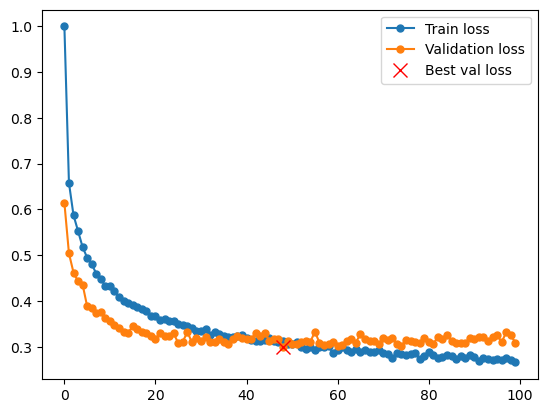

<All keys matched successfully>

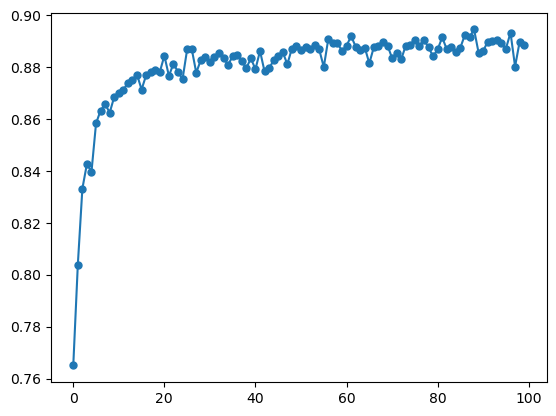

In [317]:
model53ab_sc = ConvModel53().to(device)
optimizer53ab_sc = torch.optim.Adam(model53ab_sc.parameters())
train_more_epochs_es(100,50,model53ab_sc,loss_fn,optimizer53ab_sc,training_loader2,validation_loader2)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model53ab_sc.load_state_dict(torch.load(model_path))

U standardizovaných i normalizovaných dat se dostává mode na 0.895 validační accuracy, což je dobré, ale stále lehce horší než na neupravených datech. Nyní ještě vyzkouším jiný optimizer - RMSprop.

EPOCH 1:


100%|██████████| 493/493 [00:09<00:00, 52.02it/s]


TRAIN loss: 50.258, VALIDATION loss: 0.915, accuraccy: 0.607
Saving best model
EPOCH 2:


100%|██████████| 493/493 [00:07<00:00, 67.93it/s]


TRAIN loss: 1.031, VALIDATION loss: 0.893, accuraccy: 0.640
Saving best model
EPOCH 3:


100%|██████████| 493/493 [00:08<00:00, 59.31it/s]


TRAIN loss: 1.073, VALIDATION loss: 1.403, accuraccy: 0.569
No improvement in this epoch.
EPOCH 4:


100%|██████████| 493/493 [00:07<00:00, 70.27it/s]


TRAIN loss: 0.980, VALIDATION loss: 0.761, accuraccy: 0.726
Saving best model
EPOCH 5:


100%|██████████| 493/493 [00:07<00:00, 62.45it/s]


TRAIN loss: 0.900, VALIDATION loss: 0.880, accuraccy: 0.651
No improvement in this epoch.
EPOCH 6:


100%|██████████| 493/493 [00:08<00:00, 56.79it/s]


TRAIN loss: 0.860, VALIDATION loss: 0.761, accuraccy: 0.694
No improvement in this epoch.
EPOCH 7:


100%|██████████| 493/493 [00:07<00:00, 68.82it/s]


TRAIN loss: 0.828, VALIDATION loss: 0.662, accuraccy: 0.733
Saving best model
EPOCH 8:


100%|██████████| 493/493 [00:08<00:00, 61.19it/s]


TRAIN loss: 0.834, VALIDATION loss: 0.782, accuraccy: 0.692
No improvement in this epoch.
EPOCH 9:


100%|██████████| 493/493 [00:07<00:00, 70.29it/s]


TRAIN loss: 0.813, VALIDATION loss: 0.700, accuraccy: 0.673
No improvement in this epoch.
EPOCH 10:


100%|██████████| 493/493 [00:07<00:00, 67.16it/s]


TRAIN loss: 0.793, VALIDATION loss: 0.736, accuraccy: 0.678
No improvement in this epoch.
EPOCH 11:


100%|██████████| 493/493 [00:07<00:00, 64.17it/s]


TRAIN loss: 0.796, VALIDATION loss: 0.861, accuraccy: 0.666
No improvement in this epoch.
EPOCH 12:


100%|██████████| 493/493 [00:06<00:00, 76.97it/s]


TRAIN loss: 0.797, VALIDATION loss: 0.626, accuraccy: 0.737
Saving best model
EPOCH 13:


100%|██████████| 493/493 [00:06<00:00, 74.95it/s]


TRAIN loss: 0.789, VALIDATION loss: 0.668, accuraccy: 0.726
No improvement in this epoch.
EPOCH 14:


100%|██████████| 493/493 [00:06<00:00, 71.67it/s]


TRAIN loss: 0.781, VALIDATION loss: 0.771, accuraccy: 0.699
No improvement in this epoch.
EPOCH 15:


100%|██████████| 493/493 [00:06<00:00, 75.33it/s]


TRAIN loss: 0.780, VALIDATION loss: 0.798, accuraccy: 0.692
No improvement in this epoch.
EPOCH 16:


100%|██████████| 493/493 [00:06<00:00, 75.14it/s]


TRAIN loss: 0.808, VALIDATION loss: 0.624, accuraccy: 0.753
Saving best model
EPOCH 17:


100%|██████████| 493/493 [00:06<00:00, 75.48it/s]


TRAIN loss: 0.783, VALIDATION loss: 0.718, accuraccy: 0.707
No improvement in this epoch.
EPOCH 18:


100%|██████████| 493/493 [00:07<00:00, 66.01it/s]


TRAIN loss: 0.770, VALIDATION loss: 0.601, accuraccy: 0.739
No improvement in this epoch.
EPOCH 19:


100%|██████████| 493/493 [00:06<00:00, 73.49it/s]


TRAIN loss: 0.770, VALIDATION loss: 0.624, accuraccy: 0.742
No improvement in this epoch.
EPOCH 20:


100%|██████████| 493/493 [00:07<00:00, 63.36it/s]


TRAIN loss: 0.780, VALIDATION loss: 0.599, accuraccy: 0.756
Saving best model
EPOCH 21:


100%|██████████| 493/493 [00:06<00:00, 71.43it/s]


TRAIN loss: 0.762, VALIDATION loss: 0.614, accuraccy: 0.763
Saving best model
EPOCH 22:


100%|██████████| 493/493 [00:06<00:00, 75.57it/s]


TRAIN loss: 0.794, VALIDATION loss: 0.616, accuraccy: 0.754
No improvement in this epoch.
EPOCH 23:


100%|██████████| 493/493 [00:06<00:00, 75.98it/s]


TRAIN loss: 0.794, VALIDATION loss: 0.622, accuraccy: 0.761
No improvement in this epoch.
EPOCH 24:


100%|██████████| 493/493 [00:07<00:00, 70.27it/s]


TRAIN loss: 0.779, VALIDATION loss: 0.650, accuraccy: 0.748
No improvement in this epoch.
EPOCH 25:


100%|██████████| 493/493 [00:06<00:00, 78.94it/s]


TRAIN loss: 0.776, VALIDATION loss: 0.622, accuraccy: 0.744
No improvement in this epoch.
EPOCH 26:


100%|██████████| 493/493 [00:06<00:00, 77.72it/s]


TRAIN loss: 0.791, VALIDATION loss: 0.675, accuraccy: 0.727
No improvement in this epoch.
EPOCH 27:


100%|██████████| 493/493 [00:06<00:00, 78.42it/s]


TRAIN loss: 0.780, VALIDATION loss: 0.646, accuraccy: 0.744
No improvement in this epoch.
EPOCH 28:


100%|██████████| 493/493 [00:06<00:00, 75.04it/s]


TRAIN loss: 0.788, VALIDATION loss: 0.662, accuraccy: 0.732
No improvement in this epoch.
EPOCH 29:


100%|██████████| 493/493 [00:06<00:00, 75.24it/s]


TRAIN loss: 0.796, VALIDATION loss: 0.606, accuraccy: 0.759
No improvement in this epoch.
Early stopping now


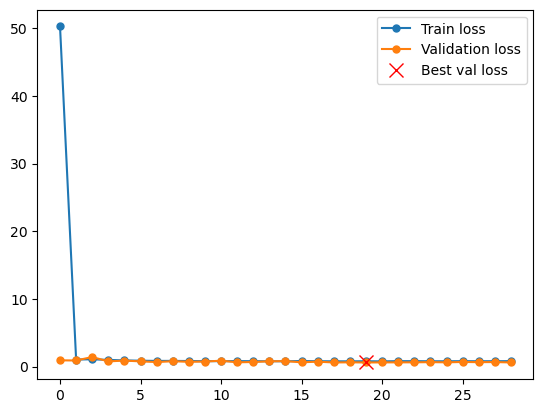

<All keys matched successfully>

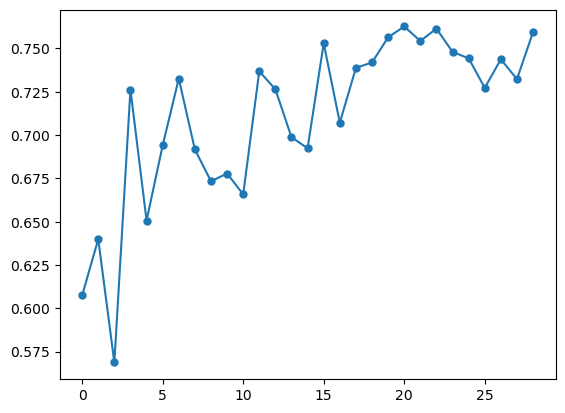

In [319]:
model53ab_rms = ConvModel53().to(device)
optimizer53ab_rms = torch.optim.RMSprop(model53ab_rms.parameters())
train_more_epochs_es(30,7,model53ab_rms,loss_fn,optimizer53ab_rms,training_loader2,validation_loader2)
torch.cuda.empty_cache()
model_path = "saves/best_model.pt"
model53ab_rms.load_state_dict(torch.load(model_path))

Výsledek s tímto optimizerem je o poznání horší.


Nejlepším modelem je tedy **model53ab**, který má 3 konvoluční vrstvy, 2 lineární, obsahuje max pooling i dropout. Je natrénovaný na klasických datech (nejsou standardizované ani normalizované), batch size 64 a optimizer Adam. Nejlepší dosažená hodnota validační accuracy je 0.896.

Tento model dále tedy použiju na testovací data, abych odhadla očekávanou chybu na předem nikdy neviděných datech.

In [337]:
from sklearn.metrics import accuracy_score
running_loss_test = 0.0
correct_test = 0
predicted_labels = []
true_labels = []
model_path = "saves/model53ab.pt"
model_53_ab_loaded.load_state_dict(torch.load(model_path))
for i, data_test in enumerate(test_loader2):
    inputs_test, labels_test = data_test
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)
    with torch.no_grad():
        outputs_test = model53ab(inputs_test)
        loss_test = loss_fn(outputs_test, labels_test)
    running_loss_test += loss_test * inputs_test.shape[0]

    correct_test += (outputs_test.argmax(1) == labels_test).float().sum()
    true_labels.extend(labels_test.cpu().detach().numpy())

    predicted_labels.extend(outputs_test.argmax(1).cpu().detach().numpy())

avg_loss_test = running_loss_test / len(Xtest_t)
acc_test = correct_test / len(Xtest_t)
print(avg_loss_test)
print(acc_test)
print(accuracy_score(true_labels, predicted_labels))

tensor(0.3082, device='cuda:0')
tensor(0.8987, device='cuda:0')
0.8986666666666666


Očekávaná přesnost modelu (accuracy) na nových datech je tedy 0.8987.

Nyní načtu data ze souboru evaluate.csv a pomocí modelu model53ab budu predikovat labels. 

Model53ab uložím do souboru "saves/model53ab.pt".

In [326]:
eval = pd.read_csv('evaluate.csv')

In [328]:
model53ab
model_path = "saves/model53ab.pt"
torch.save(model53ab.state_dict(), model_path)

In [342]:
print(eval.iloc[:,1:])

       pix1  pix2  pix3  pix4  pix5  pix6  pix7  pix8  pix9  pix10  ...  \
0         0     0     0     0     0     0     0     0     0      0  ...   
1         0     0     0     0     0     0     0     0     0      0  ...   
2         0     0     0     0     0     0     0     0     0      0  ...   
3         2     2     2     2     2     2     2     2     2      2  ...   
4         0     0     0     0     0     0     0     0     0      0  ...   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...    ...  ...   
17495     2     2     2     2     2     2     2     2     2      2  ...   
17496     0     0     0     0     0     0     0     0     0      0  ...   
17497     0     0     0     0     0     0     0     0     0      0  ...   
17498     0     0     0     0     0     0     0     0     0      0  ...   
17499     0     0     0     0     0     0     0     0     0      0  ...   

       pix1015  pix1016  pix1017  pix1018  pix1019  pix1020  pix1021  pix1022  \
0            0    

In [354]:
eval_t = torch.tensor(eval.iloc[:,1:].values.reshape(-1, 1, 32, 32), dtype=torch.float32)
#print(eval_t)

In [355]:
predicted_results = []
inputs_eval = eval_t.to(device)
#labels_test = labels_test.to(device)
with torch.no_grad():
    outputs_eval = model53ab(inputs_eval)

predicted_results.extend(outputs_eval.argmax(1).cpu().detach().numpy())
print(predicted_results)

[9, 4, 1, 7, 1, 9, 1, 6, 0, 0, 8, 4, 4, 3, 2, 1, 4, 9, 3, 9, 5, 9, 2, 2, 5, 4, 5, 3, 1, 8, 7, 5, 9, 6, 5, 6, 0, 0, 8, 2, 5, 6, 4, 9, 6, 5, 1, 5, 8, 4, 5, 0, 7, 4, 8, 6, 6, 9, 7, 1, 9, 6, 5, 3, 8, 2, 2, 1, 6, 9, 0, 3, 7, 7, 9, 8, 2, 5, 0, 1, 2, 8, 9, 5, 6, 8, 6, 5, 7, 0, 1, 4, 3, 9, 5, 5, 9, 4, 3, 4, 7, 7, 8, 4, 1, 0, 5, 6, 5, 5, 5, 8, 4, 7, 1, 8, 5, 7, 5, 2, 4, 6, 0, 7, 5, 2, 9, 2, 2, 2, 8, 2, 4, 3, 5, 7, 9, 7, 8, 6, 1, 1, 8, 6, 4, 4, 7, 1, 4, 0, 1, 0, 1, 6, 6, 5, 6, 6, 3, 0, 8, 1, 1, 7, 7, 8, 1, 3, 4, 0, 1, 6, 0, 5, 1, 7, 4, 5, 0, 3, 1, 6, 4, 2, 1, 3, 3, 8, 5, 3, 8, 9, 9, 8, 1, 3, 4, 1, 4, 8, 3, 6, 4, 8, 0, 4, 6, 0, 9, 7, 6, 4, 4, 8, 1, 8, 3, 2, 3, 5, 2, 9, 3, 9, 2, 4, 3, 2, 5, 8, 1, 5, 0, 1, 1, 8, 5, 2, 8, 0, 2, 4, 3, 1, 5, 2, 7, 6, 6, 2, 0, 2, 3, 5, 0, 7, 6, 7, 2, 9, 1, 6, 5, 2, 4, 6, 9, 2, 7, 1, 7, 7, 0, 1, 4, 2, 1, 1, 7, 4, 8, 0, 7, 9, 4, 6, 3, 4, 6, 6, 7, 9, 3, 7, 3, 7, 5, 1, 3, 5, 7, 3, 1, 4, 0, 3, 7, 0, 4, 8, 3, 8, 4, 5, 8, 1, 7, 3, 2, 4, 6, 9, 4, 6, 9, 9, 7, 4, 4, 1, 3, 2, 7, 

In [350]:
final = pd.concat([eval.iloc[:,0],pd.DataFrame(predicted_results)],axis=1)
final.rename(columns={0:'Label'},inplace=True)
final.head()

,ID,Label
0,0,9
1,1,4
2,2,1
3,3,7
4,4,1


In [353]:
final.to_csv('results.csv',index=False,sep = ',')